# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [65]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [66]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor

In [67]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
#         self.gamma = 1
        self.gamma = []#гаммы для всех estimators
        self.trees = []
        self.var = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]#варианты гамм
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = 0
        for i in range(self.n_estimators):
            crnt_y = self._fit_predict_tree(x, y - y_new)
            y_new += crnt_y
            # your code here

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        # your code here
        a = []
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        for i in self.var:#поиск оптимальной гаммы
            a.append(np.sum((y- i * self.learning_rate * tree.predict(x))**2)/len(x))
        a = np.array(a)
        ind = np.argmin(a)#минимальная MSE
        self.gamma.append(self.var[ind])#гамма, соответствующая минимальному MSE
        return self.var[ind] * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = 0
        for i in range(self.n_estimators):
            y_pred += self.gamma[i] * self.learning_rate * self.trees[i].predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [68]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.635844078917064

In [70]:
np.random.seed(19052019)

# your code here
gb = GradientBoosting(n_estimators = 640, max_depth = 10)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [71]:
mean_squared_error(y_test, y_pred)

12.461782355851891

In [72]:
res = []
c = 0
gbs = []
for i in [1,5, 6, 10, 20, 50, 80, 100, 500, 600, 700, 1000]:
    for j in [8, 10, 12, 15, 20, 30, 50]:
        for m in [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
            gb = GradientBoosting(n_estimators = i, max_depth = j, learning_rate = m)
            gb.fit(X_train, y_train)
            y_pred = gb.predict(X_test)
            res.append(mean_squared_error(y_test, y_pred))
            print(c, i, j, m, mean_squared_error(y_test, y_pred))
            c+=1

0 1 8 0.1 464.1846888512877
1 1 8 0.2 372.7798038288988
2 1 8 0.25 327.0383511514383
3 1 8 0.3 291.97126933637645
4 1 8 0.35 248.79100865214087
5 1 8 0.4 221.69360839756135
6 1 8 0.45 180.03024890974422
7 1 8 0.5 157.71205444027515
8 1 8 0.6 103.38762436478028
9 1 8 0.65 93.69309432661312
10 1 8 0.7 74.91746473778711
11 1 8 0.75 47.641232943118425
12 1 8 0.8 48.339945451465375
13 1 8 0.85 38.5377779163166
14 1 8 0.9 30.80490760489649
15 1 8 0.95 14.13075628995221
16 1 8 1 14.344969551754955
17 1 10 0.1 463.845632395858
18 1 10 0.2 375.1306908776689
19 1 10 0.25 330.61659238103044
20 1 10 0.3 290.4007126086726
21 1 10 0.35 256.01842838813855
22 1 10 0.4 223.9846748838287
23 1 10 0.45 181.72546267045524
24 1 10 0.5 162.7920639437324
25 1 10 0.6 104.78564308497128
26 1 10 0.65 85.61179964803372
27 1 10 0.7 76.27453752928176
28 1 10 0.75 52.05203423143099
29 1 10 0.8 47.53048075581211
30 1 10 0.85 39.48782826654001
31 1 10 0.9 21.417184489919702
32 1 10 0.95 14.364976577380215
33 1 10 1 13

268 6 10 0.85 11.496859515955787
269 6 10 0.9 14.498188655762384
270 6 10 0.95 24.472165537878276
271 6 10 1 27.241565753291535
272 6 12 0.1 169.36801222182575
273 6 12 0.2 53.15639864055277
274 6 12 0.25 32.33453935892244
275 6 12 0.3 20.8643772253079
276 6 12 0.35 15.790200056520634
277 6 12 0.4 15.93444007981373
278 6 12 0.45 16.22583404651897
279 6 12 0.5 17.741106776897354
280 6 12 0.6 12.510249293393318
281 6 12 0.65 10.046982089125585
282 6 12 0.7 19.302555762947105
283 6 12 0.75 11.546558468251666
284 6 12 0.8 13.042340904327501
285 6 12 0.85 22.529257476860295
286 6 12 0.9 14.031292168313232
287 6 12 0.95 16.151615132249564
288 6 12 1 15.197907890384549
289 6 15 0.1 172.66919430725483
290 6 15 0.2 56.90757524087255
291 6 15 0.25 32.11774731445762
292 6 15 0.3 20.476607410265267
293 6 15 0.35 23.035476062112405
294 6 15 0.4 17.197400801438945
295 6 15 0.45 20.470776087590615
296 6 15 0.5 22.11919209991191
297 6 15 0.6 21.72147744759863
298 6 15 0.65 12.436071936768
299 6 15 0.7

523 20 12 0.85 22.899177521071092
524 20 12 0.9 25.197568759461994
525 20 12 0.95 26.01226959193514
526 20 12 1 16.63355577108101
527 20 15 0.1 21.246369630044395
528 20 15 0.2 16.991866333370563
529 20 15 0.25 12.916297065932675
530 20 15 0.3 14.826207177751707
531 20 15 0.35 12.906208751031096
532 20 15 0.4 12.975903998406299
533 20 15 0.45 13.893374521227125
534 20 15 0.5 14.804302039506503
535 20 15 0.6 14.82634762721228
536 20 15 0.65 12.942142379326272
537 20 15 0.7 21.12569027666141
538 20 15 0.75 20.13061814061328
539 20 15 0.8 27.182259546277105
540 20 15 0.85 12.782407907306261
541 20 15 0.9 27.60782853764657
542 20 15 0.95 13.996988356709908
543 20 15 1 16.218746719160105
544 20 20 0.1 27.49920937974252
545 20 20 0.2 20.77279387953691
546 20 20 0.25 19.92335849775621
547 20 20 0.3 16.093911200994768
548 20 20 0.35 20.38862384112949
549 20 20 0.4 22.629190322425824
550 20 20 0.45 21.52817387503953
551 20 20 0.5 22.451727920125737
552 20 20 0.6 15.375847479432004
553 20 20 0.6

774 80 15 0.65 22.931713439036166
775 80 15 0.7 14.781826437228522
776 80 15 0.75 19.551662878380025
777 80 15 0.8 25.88383282494075
778 80 15 0.85 20.688438626447194
779 80 15 0.9 13.155350951736814
780 80 15 0.95 26.46767738796801
781 80 15 1 16.071345144356957
782 80 20 0.1 18.0373584806009
783 80 20 0.2 19.35460478249334
784 80 20 0.25 20.858685703819134
785 80 20 0.3 17.546714085434633
786 80 20 0.35 22.543541904071017
787 80 20 0.4 14.909639803409311
788 80 20 0.45 23.148808323895445
789 80 20 0.5 15.736193246995805
790 80 20 0.6 16.047966775133563
791 80 20 0.65 26.079693806281995
792 80 20 0.7 26.857486686501723
793 80 20 0.75 13.327548544116407
794 80 20 0.8 20.60040474530035
795 80 20 0.85 27.317292032073887
796 80 20 0.9 27.692568757799947
797 80 20 0.95 32.93640825169125
798 80 20 1 28.57456692913386
799 80 30 0.1 17.234303481123387
800 80 30 0.2 16.062434919182234
801 80 30 0.25 16.48715583714266
802 80 30 0.3 17.883322065262792
803 80 30 0.35 21.86963168865749
804 80 30 0

1018 500 15 0.95 14.429957516219892
1019 500 15 1 29.22898731408574
1020 500 20 0.1 16.88382841121555
1021 500 20 0.2 17.024949458856995
1022 500 20 0.25 16.046961254688334
1023 500 20 0.3 16.224474871155437
1024 500 20 0.35 15.214979717648527
1025 500 20 0.4 14.186650364730866
1026 500 20 0.45 20.427901888256557
1027 500 20 0.5 19.42489659168447
1028 500 20 0.6 14.36529718795145
1029 500 20 0.65 24.070512916687882
1030 500 20 0.7 15.856977204095028
1031 500 20 0.75 26.72140201677328
1032 500 20 0.8 26.075732227345462
1033 500 20 0.85 26.76870740051068
1034 500 20 0.9 16.26093672683542
1035 500 20 0.95 14.084899621830672
1036 500 20 1 20.900078740157483
1037 500 30 0.1 18.15743366128505
1038 500 30 0.2 23.0879973780359
1039 500 30 0.25 14.825362469101508
1040 500 30 0.3 20.387951487158965
1041 500 30 0.35 14.493031026980924
1042 500 30 0.4 17.06088512683953
1043 500 30 0.45 22.380737698911677
1044 500 30 0.5 14.230301014126011
1045 500 30 0.6 19.515995172642047
1046 500 30 0.65 20.2340

1254 700 15 0.85 26.046898970322122
1255 700 15 0.9 29.91065858167567
1256 700 15 0.95 31.98946842296724
1257 700 15 1 13.814061679790024
1258 700 20 0.1 16.916179954835616
1259 700 20 0.2 16.569889977646277
1260 700 20 0.25 19.185546098358834
1261 700 20 0.3 21.260702870651887
1262 700 20 0.35 18.558333463258023
1263 700 20 0.4 22.005629188111694
1264 700 20 0.45 13.895091693917054
1265 700 20 0.5 15.259469891924935
1266 700 20 0.6 15.942585567580847
1267 700 20 0.65 24.76629436292701
1268 700 20 0.7 23.709519973401886
1269 700 20 0.75 27.798094232407752
1270 700 20 0.8 25.178129107942176
1271 700 20 0.85 15.080548669881683
1272 700 20 0.9 21.073162035120056
1273 700 20 0.95 13.53420635407993
1274 700 20 1 32.32291338582677
1275 700 30 0.1 18.727741689178334
1276 700 30 0.2 21.895129385183193
1277 700 30 0.25 20.51628331183313
1278 700 30 0.3 20.06487622536113
1279 700 30 0.35 21.77113753644337
1280 700 30 0.4 24.272225108984077
1281 700 30 0.45 16.914178699223392
1282 700 30 0.5 15.2

In [73]:
print(res.index(min(res)))

604


In [74]:
y_pred = gbs[res.index(min(res))].predict(X_test)
print(mean_squared_error(y_test, y_pred))

9.01028291484198


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [47]:
import pandas as pd
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [48]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [49]:
# !pip install xgboost

In [50]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

C:\ANAC\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7044660982995791

In [52]:
# !pip install catboost

In [53]:
from catboost import CatBoostClassifier
# X_train = train.drop('dep_delayed_15min', axis = 1)
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [54]:
ctb = CatBoostClassifier()
ctb.fit(X_train_part, y_train_part)
y_pred = ctb.predict(X_valid)

Learning rate set to 0.063211
0:	learn: 0.6594327	total: 13.9ms	remaining: 13.9s
1:	learn: 0.6301564	total: 27.7ms	remaining: 13.8s
2:	learn: 0.6055001	total: 40.7ms	remaining: 13.5s
3:	learn: 0.5841283	total: 54.8ms	remaining: 13.6s
4:	learn: 0.5662805	total: 67.5ms	remaining: 13.4s
5:	learn: 0.5506843	total: 80.8ms	remaining: 13.4s
6:	learn: 0.5365555	total: 94.2ms	remaining: 13.4s
7:	learn: 0.5254470	total: 106ms	remaining: 13.2s
8:	learn: 0.5161585	total: 119ms	remaining: 13s
9:	learn: 0.5080404	total: 130ms	remaining: 12.9s
10:	learn: 0.5000010	total: 144ms	remaining: 12.9s
11:	learn: 0.4929201	total: 157ms	remaining: 13s
12:	learn: 0.4874863	total: 170ms	remaining: 12.9s
13:	learn: 0.4831059	total: 185ms	remaining: 13s
14:	learn: 0.4786430	total: 198ms	remaining: 13s
15:	learn: 0.4744171	total: 214ms	remaining: 13.1s
16:	learn: 0.4712782	total: 233ms	remaining: 13.5s
17:	learn: 0.4686914	total: 249ms	remaining: 13.6s
18:	learn: 0.4656762	total: 263ms	remaining: 13.6s
19:	learn: 0

164:	learn: 0.4419207	total: 2.39s	remaining: 12.1s
165:	learn: 0.4418891	total: 2.4s	remaining: 12.1s
166:	learn: 0.4418795	total: 2.42s	remaining: 12.1s
167:	learn: 0.4418613	total: 2.44s	remaining: 12.1s
168:	learn: 0.4418403	total: 2.45s	remaining: 12.1s
169:	learn: 0.4418036	total: 2.47s	remaining: 12s
170:	learn: 0.4417840	total: 2.48s	remaining: 12s
171:	learn: 0.4417428	total: 2.5s	remaining: 12s
172:	learn: 0.4417233	total: 2.51s	remaining: 12s
173:	learn: 0.4417122	total: 2.52s	remaining: 12s
174:	learn: 0.4416828	total: 2.54s	remaining: 12s
175:	learn: 0.4416577	total: 2.55s	remaining: 11.9s
176:	learn: 0.4416334	total: 2.57s	remaining: 11.9s
177:	learn: 0.4415821	total: 2.59s	remaining: 11.9s
178:	learn: 0.4415612	total: 2.6s	remaining: 11.9s
179:	learn: 0.4415424	total: 2.62s	remaining: 11.9s
180:	learn: 0.4415145	total: 2.63s	remaining: 11.9s
181:	learn: 0.4414959	total: 2.65s	remaining: 11.9s
182:	learn: 0.4414625	total: 2.66s	remaining: 11.9s
183:	learn: 0.4414290	total

327:	learn: 0.4373933	total: 4.97s	remaining: 10.2s
328:	learn: 0.4373624	total: 4.99s	remaining: 10.2s
329:	learn: 0.4373351	total: 5.01s	remaining: 10.2s
330:	learn: 0.4373122	total: 5.03s	remaining: 10.2s
331:	learn: 0.4372856	total: 5.04s	remaining: 10.1s
332:	learn: 0.4372622	total: 5.05s	remaining: 10.1s
333:	learn: 0.4372365	total: 5.07s	remaining: 10.1s
334:	learn: 0.4372191	total: 5.08s	remaining: 10.1s
335:	learn: 0.4371960	total: 5.1s	remaining: 10.1s
336:	learn: 0.4371748	total: 5.11s	remaining: 10.1s
337:	learn: 0.4371443	total: 5.13s	remaining: 10s
338:	learn: 0.4371075	total: 5.14s	remaining: 10s
339:	learn: 0.4370874	total: 5.16s	remaining: 10s
340:	learn: 0.4370492	total: 5.17s	remaining: 9.99s
341:	learn: 0.4370315	total: 5.19s	remaining: 9.98s
342:	learn: 0.4370045	total: 5.2s	remaining: 9.96s
343:	learn: 0.4369863	total: 5.21s	remaining: 9.95s
344:	learn: 0.4369683	total: 5.23s	remaining: 9.93s
345:	learn: 0.4369508	total: 5.24s	remaining: 9.91s
346:	learn: 0.436928

492:	learn: 0.4336086	total: 7.52s	remaining: 7.74s
493:	learn: 0.4335887	total: 7.54s	remaining: 7.72s
494:	learn: 0.4335640	total: 7.56s	remaining: 7.71s
495:	learn: 0.4335412	total: 7.57s	remaining: 7.69s
496:	learn: 0.4335120	total: 7.58s	remaining: 7.68s
497:	learn: 0.4334794	total: 7.6s	remaining: 7.66s
498:	learn: 0.4334573	total: 7.61s	remaining: 7.64s
499:	learn: 0.4334382	total: 7.63s	remaining: 7.63s
500:	learn: 0.4334222	total: 7.64s	remaining: 7.61s
501:	learn: 0.4334007	total: 7.66s	remaining: 7.6s
502:	learn: 0.4333747	total: 7.67s	remaining: 7.58s
503:	learn: 0.4333517	total: 7.69s	remaining: 7.56s
504:	learn: 0.4333315	total: 7.7s	remaining: 7.55s
505:	learn: 0.4333175	total: 7.72s	remaining: 7.53s
506:	learn: 0.4333038	total: 7.73s	remaining: 7.52s
507:	learn: 0.4332969	total: 7.75s	remaining: 7.5s
508:	learn: 0.4332756	total: 7.76s	remaining: 7.49s
509:	learn: 0.4332574	total: 7.77s	remaining: 7.47s
510:	learn: 0.4332261	total: 7.79s	remaining: 7.45s
511:	learn: 0.43

655:	learn: 0.4304321	total: 10.1s	remaining: 5.28s
656:	learn: 0.4304106	total: 10.1s	remaining: 5.26s
657:	learn: 0.4303935	total: 10.1s	remaining: 5.25s
658:	learn: 0.4303806	total: 10.1s	remaining: 5.23s
659:	learn: 0.4303601	total: 10.1s	remaining: 5.21s
660:	learn: 0.4303278	total: 10.1s	remaining: 5.2s
661:	learn: 0.4303184	total: 10.1s	remaining: 5.18s
662:	learn: 0.4302974	total: 10.2s	remaining: 5.17s
663:	learn: 0.4302760	total: 10.2s	remaining: 5.15s
664:	learn: 0.4302532	total: 10.2s	remaining: 5.13s
665:	learn: 0.4302356	total: 10.2s	remaining: 5.12s
666:	learn: 0.4302176	total: 10.2s	remaining: 5.1s
667:	learn: 0.4301938	total: 10.2s	remaining: 5.08s
668:	learn: 0.4301790	total: 10.2s	remaining: 5.07s
669:	learn: 0.4301735	total: 10.3s	remaining: 5.06s
670:	learn: 0.4301480	total: 10.3s	remaining: 5.04s
671:	learn: 0.4301322	total: 10.3s	remaining: 5.03s
672:	learn: 0.4301037	total: 10.3s	remaining: 5.01s
673:	learn: 0.4300811	total: 10.3s	remaining: 4.99s
674:	learn: 0.

817:	learn: 0.4276830	total: 12.6s	remaining: 2.81s
818:	learn: 0.4276664	total: 12.6s	remaining: 2.79s
819:	learn: 0.4276529	total: 12.7s	remaining: 2.78s
820:	learn: 0.4276421	total: 12.7s	remaining: 2.76s
821:	learn: 0.4276307	total: 12.7s	remaining: 2.75s
822:	learn: 0.4276175	total: 12.7s	remaining: 2.73s
823:	learn: 0.4276056	total: 12.7s	remaining: 2.72s
824:	learn: 0.4275786	total: 12.7s	remaining: 2.7s
825:	learn: 0.4275542	total: 12.8s	remaining: 2.69s
826:	learn: 0.4275216	total: 12.8s	remaining: 2.67s
827:	learn: 0.4275168	total: 12.8s	remaining: 2.65s
828:	learn: 0.4274901	total: 12.8s	remaining: 2.64s
829:	learn: 0.4274793	total: 12.8s	remaining: 2.62s
830:	learn: 0.4274569	total: 12.8s	remaining: 2.61s
831:	learn: 0.4274461	total: 12.8s	remaining: 2.59s
832:	learn: 0.4274394	total: 12.9s	remaining: 2.58s
833:	learn: 0.4274278	total: 12.9s	remaining: 2.56s
834:	learn: 0.4274092	total: 12.9s	remaining: 2.55s
835:	learn: 0.4273985	total: 12.9s	remaining: 2.53s
836:	learn: 0

980:	learn: 0.4251207	total: 15.2s	remaining: 294ms
981:	learn: 0.4250982	total: 15.2s	remaining: 278ms
982:	learn: 0.4250895	total: 15.2s	remaining: 263ms
983:	learn: 0.4250729	total: 15.2s	remaining: 247ms
984:	learn: 0.4250599	total: 15.2s	remaining: 232ms
985:	learn: 0.4250507	total: 15.2s	remaining: 216ms
986:	learn: 0.4250346	total: 15.3s	remaining: 201ms
987:	learn: 0.4250178	total: 15.3s	remaining: 186ms
988:	learn: 0.4250075	total: 15.3s	remaining: 170ms
989:	learn: 0.4249988	total: 15.3s	remaining: 155ms
990:	learn: 0.4249922	total: 15.3s	remaining: 139ms
991:	learn: 0.4249782	total: 15.3s	remaining: 124ms
992:	learn: 0.4249684	total: 15.4s	remaining: 108ms
993:	learn: 0.4249503	total: 15.4s	remaining: 92.8ms
994:	learn: 0.4249278	total: 15.4s	remaining: 77.3ms
995:	learn: 0.4249094	total: 15.4s	remaining: 61.9ms
996:	learn: 0.4248834	total: 15.4s	remaining: 46.4ms
997:	learn: 0.4248681	total: 15.4s	remaining: 30.9ms
998:	learn: 0.4248474	total: 15.4s	remaining: 15.5ms
999:	l

In [55]:
print(roc_auc_score(y_pred, y_valid))

0.7153054993021907


In [59]:
from sklearn.model_selection import GridSearchCV
params = {'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006], 'depth':[6], 'l2_leaf_reg':[6], 'random_seed': [1337]}
grid_search = GridSearchCV(CatBoostClassifier(), params, scoring= 'roc_auc', cv = 3)
grid_search.fit(X_train_part, y_train_part)

0:	learn: 0.6925901	total: 19.5ms	remaining: 19.5s
1:	learn: 0.6920691	total: 31.5ms	remaining: 15.7s
2:	learn: 0.6915190	total: 44.1ms	remaining: 14.6s
3:	learn: 0.6909711	total: 56.6ms	remaining: 14.1s
4:	learn: 0.6904205	total: 67.8ms	remaining: 13.5s
5:	learn: 0.6898730	total: 80.8ms	remaining: 13.4s
6:	learn: 0.6893304	total: 92.9ms	remaining: 13.2s
7:	learn: 0.6887803	total: 105ms	remaining: 13s
8:	learn: 0.6882433	total: 116ms	remaining: 12.8s
9:	learn: 0.6877021	total: 129ms	remaining: 12.8s
10:	learn: 0.6871779	total: 139ms	remaining: 12.5s
11:	learn: 0.6866682	total: 150ms	remaining: 12.4s
12:	learn: 0.6861358	total: 162ms	remaining: 12.3s
13:	learn: 0.6855908	total: 174ms	remaining: 12.2s
14:	learn: 0.6850579	total: 184ms	remaining: 12.1s
15:	learn: 0.6845230	total: 196ms	remaining: 12.1s
16:	learn: 0.6839935	total: 207ms	remaining: 12s
17:	learn: 0.6834485	total: 220ms	remaining: 12s
18:	learn: 0.6829216	total: 232ms	remaining: 12s
19:	learn: 0.6823892	total: 244ms	remainin

167:	learn: 0.6164666	total: 2.01s	remaining: 9.97s
168:	learn: 0.6160710	total: 2.02s	remaining: 9.96s
169:	learn: 0.6156982	total: 2.04s	remaining: 9.95s
170:	learn: 0.6153323	total: 2.05s	remaining: 9.93s
171:	learn: 0.6149563	total: 2.06s	remaining: 9.92s
172:	learn: 0.6145783	total: 2.07s	remaining: 9.9s
173:	learn: 0.6142264	total: 2.08s	remaining: 9.88s
174:	learn: 0.6138554	total: 2.09s	remaining: 9.86s
175:	learn: 0.6134867	total: 2.1s	remaining: 9.84s
176:	learn: 0.6131343	total: 2.11s	remaining: 9.83s
177:	learn: 0.6127766	total: 2.12s	remaining: 9.8s
178:	learn: 0.6124079	total: 2.13s	remaining: 9.79s
179:	learn: 0.6120478	total: 2.15s	remaining: 9.77s
180:	learn: 0.6116826	total: 2.15s	remaining: 9.75s
181:	learn: 0.6113372	total: 2.17s	remaining: 9.74s
182:	learn: 0.6109705	total: 2.18s	remaining: 9.72s
183:	learn: 0.6106056	total: 2.19s	remaining: 9.7s
184:	learn: 0.6102409	total: 2.2s	remaining: 9.7s
185:	learn: 0.6098831	total: 2.21s	remaining: 9.69s
186:	learn: 0.6095

329:	learn: 0.5662375	total: 3.82s	remaining: 7.76s
330:	learn: 0.5659790	total: 3.83s	remaining: 7.75s
331:	learn: 0.5657241	total: 3.85s	remaining: 7.74s
332:	learn: 0.5654757	total: 3.86s	remaining: 7.73s
333:	learn: 0.5652254	total: 3.87s	remaining: 7.72s
334:	learn: 0.5649637	total: 3.89s	remaining: 7.72s
335:	learn: 0.5647107	total: 3.9s	remaining: 7.71s
336:	learn: 0.5644600	total: 3.92s	remaining: 7.71s
337:	learn: 0.5642004	total: 3.93s	remaining: 7.7s
338:	learn: 0.5639465	total: 3.94s	remaining: 7.69s
339:	learn: 0.5636951	total: 3.96s	remaining: 7.68s
340:	learn: 0.5634525	total: 3.97s	remaining: 7.67s
341:	learn: 0.5631979	total: 3.98s	remaining: 7.67s
342:	learn: 0.5629555	total: 4s	remaining: 7.66s
343:	learn: 0.5627039	total: 4.01s	remaining: 7.65s
344:	learn: 0.5624682	total: 4.03s	remaining: 7.64s
345:	learn: 0.5622227	total: 4.04s	remaining: 7.63s
346:	learn: 0.5619742	total: 4.05s	remaining: 7.62s
347:	learn: 0.5617276	total: 4.06s	remaining: 7.61s
348:	learn: 0.561

496:	learn: 0.5307774	total: 5.8s	remaining: 5.87s
497:	learn: 0.5306035	total: 5.82s	remaining: 5.86s
498:	learn: 0.5304276	total: 5.83s	remaining: 5.85s
499:	learn: 0.5302528	total: 5.84s	remaining: 5.84s
500:	learn: 0.5300644	total: 5.85s	remaining: 5.83s
501:	learn: 0.5299009	total: 5.87s	remaining: 5.82s
502:	learn: 0.5297371	total: 5.88s	remaining: 5.81s
503:	learn: 0.5295657	total: 5.89s	remaining: 5.79s
504:	learn: 0.5293924	total: 5.9s	remaining: 5.78s
505:	learn: 0.5292280	total: 5.91s	remaining: 5.77s
506:	learn: 0.5290413	total: 5.93s	remaining: 5.76s
507:	learn: 0.5288846	total: 5.94s	remaining: 5.75s
508:	learn: 0.5287178	total: 5.95s	remaining: 5.74s
509:	learn: 0.5285523	total: 5.96s	remaining: 5.73s
510:	learn: 0.5283805	total: 5.98s	remaining: 5.72s
511:	learn: 0.5282180	total: 5.99s	remaining: 5.71s
512:	learn: 0.5280377	total: 6.01s	remaining: 5.7s
513:	learn: 0.5278676	total: 6.02s	remaining: 5.69s
514:	learn: 0.5277084	total: 6.03s	remaining: 5.68s
515:	learn: 0.5

661:	learn: 0.5067325	total: 8.01s	remaining: 4.09s
662:	learn: 0.5066172	total: 8.02s	remaining: 4.08s
663:	learn: 0.5065095	total: 8.04s	remaining: 4.07s
664:	learn: 0.5063909	total: 8.06s	remaining: 4.06s
665:	learn: 0.5062744	total: 8.07s	remaining: 4.05s
666:	learn: 0.5061437	total: 8.09s	remaining: 4.04s
667:	learn: 0.5060414	total: 8.1s	remaining: 4.02s
668:	learn: 0.5059320	total: 8.11s	remaining: 4.01s
669:	learn: 0.5058129	total: 8.12s	remaining: 4s
670:	learn: 0.5056910	total: 8.13s	remaining: 3.99s
671:	learn: 0.5055769	total: 8.14s	remaining: 3.97s
672:	learn: 0.5054630	total: 8.15s	remaining: 3.96s
673:	learn: 0.5053364	total: 8.16s	remaining: 3.95s
674:	learn: 0.5052246	total: 8.18s	remaining: 3.94s
675:	learn: 0.5050995	total: 8.19s	remaining: 3.93s
676:	learn: 0.5049847	total: 8.2s	remaining: 3.91s
677:	learn: 0.5048709	total: 8.22s	remaining: 3.9s
678:	learn: 0.5047508	total: 8.23s	remaining: 3.89s
679:	learn: 0.5046464	total: 8.24s	remaining: 3.88s
680:	learn: 0.5045

832:	learn: 0.4896801	total: 10.4s	remaining: 2.08s
833:	learn: 0.4895966	total: 10.4s	remaining: 2.06s
834:	learn: 0.4895163	total: 10.4s	remaining: 2.05s
835:	learn: 0.4894388	total: 10.4s	remaining: 2.04s
836:	learn: 0.4893633	total: 10.4s	remaining: 2.03s
837:	learn: 0.4892753	total: 10.4s	remaining: 2.01s
838:	learn: 0.4891875	total: 10.4s	remaining: 2s
839:	learn: 0.4891070	total: 10.4s	remaining: 1.99s
840:	learn: 0.4890317	total: 10.5s	remaining: 1.98s
841:	learn: 0.4889510	total: 10.5s	remaining: 1.96s
842:	learn: 0.4888680	total: 10.5s	remaining: 1.95s
843:	learn: 0.4887839	total: 10.5s	remaining: 1.94s
844:	learn: 0.4887016	total: 10.5s	remaining: 1.93s
845:	learn: 0.4886224	total: 10.5s	remaining: 1.91s
846:	learn: 0.4885371	total: 10.5s	remaining: 1.9s
847:	learn: 0.4884511	total: 10.6s	remaining: 1.89s
848:	learn: 0.4883729	total: 10.6s	remaining: 1.88s
849:	learn: 0.4882888	total: 10.6s	remaining: 1.87s
850:	learn: 0.4882090	total: 10.6s	remaining: 1.85s
851:	learn: 0.48

996:	learn: 0.4780978	total: 12.4s	remaining: 37.2ms
997:	learn: 0.4780354	total: 12.4s	remaining: 24.8ms
998:	learn: 0.4779704	total: 12.4s	remaining: 12.4ms
999:	learn: 0.4779186	total: 12.4s	remaining: 0us
0:	learn: 0.6925870	total: 10.6ms	remaining: 10.6s
1:	learn: 0.6920633	total: 22ms	remaining: 11s
2:	learn: 0.6915177	total: 33.7ms	remaining: 11.2s
3:	learn: 0.6909691	total: 46.7ms	remaining: 11.6s
4:	learn: 0.6904216	total: 61.1ms	remaining: 12.2s
5:	learn: 0.6898645	total: 72.5ms	remaining: 12s
6:	learn: 0.6893199	total: 82.7ms	remaining: 11.7s
7:	learn: 0.6887619	total: 93.2ms	remaining: 11.6s
8:	learn: 0.6882302	total: 103ms	remaining: 11.4s
9:	learn: 0.6876789	total: 114ms	remaining: 11.2s
10:	learn: 0.6871539	total: 126ms	remaining: 11.3s
11:	learn: 0.6866286	total: 137ms	remaining: 11.3s
12:	learn: 0.6860927	total: 148ms	remaining: 11.2s
13:	learn: 0.6855623	total: 161ms	remaining: 11.3s
14:	learn: 0.6850430	total: 173ms	remaining: 11.3s
15:	learn: 0.6845209	total: 185ms	

168:	learn: 0.6157549	total: 2s	remaining: 9.81s
169:	learn: 0.6153850	total: 2.01s	remaining: 9.81s
170:	learn: 0.6150141	total: 2.02s	remaining: 9.81s
171:	learn: 0.6146354	total: 2.04s	remaining: 9.8s
172:	learn: 0.6142644	total: 2.05s	remaining: 9.79s
173:	learn: 0.6139020	total: 2.06s	remaining: 9.77s
174:	learn: 0.6135358	total: 2.07s	remaining: 9.76s
175:	learn: 0.6131592	total: 2.08s	remaining: 9.75s
176:	learn: 0.6127927	total: 2.09s	remaining: 9.73s
177:	learn: 0.6124173	total: 2.11s	remaining: 9.73s
178:	learn: 0.6120492	total: 2.12s	remaining: 9.71s
179:	learn: 0.6116883	total: 2.13s	remaining: 9.7s
180:	learn: 0.6113209	total: 2.14s	remaining: 9.7s
181:	learn: 0.6109514	total: 2.15s	remaining: 9.69s
182:	learn: 0.6105901	total: 2.17s	remaining: 9.67s
183:	learn: 0.6102248	total: 2.18s	remaining: 9.67s
184:	learn: 0.6098610	total: 2.19s	remaining: 9.67s
185:	learn: 0.6094984	total: 2.21s	remaining: 9.66s
186:	learn: 0.6091413	total: 2.22s	remaining: 9.65s
187:	learn: 0.6087

339:	learn: 0.5631477	total: 4.16s	remaining: 8.07s
340:	learn: 0.5628957	total: 4.17s	remaining: 8.05s
341:	learn: 0.5626541	total: 4.18s	remaining: 8.04s
342:	learn: 0.5624057	total: 4.19s	remaining: 8.03s
343:	learn: 0.5621579	total: 4.2s	remaining: 8.02s
344:	learn: 0.5619158	total: 4.21s	remaining: 8s
345:	learn: 0.5616675	total: 4.22s	remaining: 7.99s
346:	learn: 0.5614165	total: 4.24s	remaining: 7.97s
347:	learn: 0.5611662	total: 4.25s	remaining: 7.96s
348:	learn: 0.5609182	total: 4.26s	remaining: 7.95s
349:	learn: 0.5606736	total: 4.27s	remaining: 7.93s
350:	learn: 0.5604281	total: 4.28s	remaining: 7.92s
351:	learn: 0.5601914	total: 4.29s	remaining: 7.9s
352:	learn: 0.5599444	total: 4.3s	remaining: 7.89s
353:	learn: 0.5597021	total: 4.31s	remaining: 7.87s
354:	learn: 0.5594410	total: 4.33s	remaining: 7.86s
355:	learn: 0.5591990	total: 4.34s	remaining: 7.85s
356:	learn: 0.5589589	total: 4.35s	remaining: 7.83s
357:	learn: 0.5587262	total: 4.36s	remaining: 7.82s
358:	learn: 0.5584

507:	learn: 0.5281138	total: 6.13s	remaining: 5.93s
508:	learn: 0.5279524	total: 6.14s	remaining: 5.92s
509:	learn: 0.5277875	total: 6.15s	remaining: 5.91s
510:	learn: 0.5276263	total: 6.17s	remaining: 5.9s
511:	learn: 0.5274663	total: 6.18s	remaining: 5.89s
512:	learn: 0.5272979	total: 6.2s	remaining: 5.88s
513:	learn: 0.5271388	total: 6.21s	remaining: 5.87s
514:	learn: 0.5269542	total: 6.22s	remaining: 5.86s
515:	learn: 0.5267996	total: 6.23s	remaining: 5.84s
516:	learn: 0.5266202	total: 6.24s	remaining: 5.83s
517:	learn: 0.5264514	total: 6.25s	remaining: 5.82s
518:	learn: 0.5262789	total: 6.27s	remaining: 5.81s
519:	learn: 0.5261095	total: 6.28s	remaining: 5.79s
520:	learn: 0.5259445	total: 6.29s	remaining: 5.78s
521:	learn: 0.5257672	total: 6.3s	remaining: 5.77s
522:	learn: 0.5255838	total: 6.31s	remaining: 5.76s
523:	learn: 0.5254151	total: 6.33s	remaining: 5.75s
524:	learn: 0.5252581	total: 6.34s	remaining: 5.73s
525:	learn: 0.5250812	total: 6.35s	remaining: 5.72s
526:	learn: 0.5

676:	learn: 0.5040448	total: 8.28s	remaining: 3.95s
677:	learn: 0.5039327	total: 8.29s	remaining: 3.94s
678:	learn: 0.5038229	total: 8.31s	remaining: 3.93s
679:	learn: 0.5037014	total: 8.32s	remaining: 3.91s
680:	learn: 0.5035882	total: 8.33s	remaining: 3.9s
681:	learn: 0.5034772	total: 8.34s	remaining: 3.89s
682:	learn: 0.5033704	total: 8.36s	remaining: 3.88s
683:	learn: 0.5032535	total: 8.37s	remaining: 3.87s
684:	learn: 0.5031365	total: 8.38s	remaining: 3.85s
685:	learn: 0.5030114	total: 8.39s	remaining: 3.84s
686:	learn: 0.5028972	total: 8.41s	remaining: 3.83s
687:	learn: 0.5027709	total: 8.42s	remaining: 3.82s
688:	learn: 0.5026550	total: 8.44s	remaining: 3.81s
689:	learn: 0.5025534	total: 8.45s	remaining: 3.8s
690:	learn: 0.5024419	total: 8.46s	remaining: 3.79s
691:	learn: 0.5023219	total: 8.48s	remaining: 3.77s
692:	learn: 0.5022190	total: 8.49s	remaining: 3.76s
693:	learn: 0.5021098	total: 8.51s	remaining: 3.75s
694:	learn: 0.5019876	total: 8.52s	remaining: 3.74s
695:	learn: 0.

846:	learn: 0.4875434	total: 10.3s	remaining: 1.85s
847:	learn: 0.4874566	total: 10.3s	remaining: 1.84s
848:	learn: 0.4873772	total: 10.3s	remaining: 1.83s
849:	learn: 0.4872974	total: 10.3s	remaining: 1.81s
850:	learn: 0.4872110	total: 10.3s	remaining: 1.8s
851:	learn: 0.4871186	total: 10.3s	remaining: 1.79s
852:	learn: 0.4870420	total: 10.3s	remaining: 1.78s
853:	learn: 0.4869644	total: 10.3s	remaining: 1.77s
854:	learn: 0.4868893	total: 10.3s	remaining: 1.75s
855:	learn: 0.4868146	total: 10.4s	remaining: 1.74s
856:	learn: 0.4867347	total: 10.4s	remaining: 1.73s
857:	learn: 0.4866466	total: 10.4s	remaining: 1.72s
858:	learn: 0.4865745	total: 10.4s	remaining: 1.7s
859:	learn: 0.4864921	total: 10.4s	remaining: 1.69s
860:	learn: 0.4864108	total: 10.4s	remaining: 1.68s
861:	learn: 0.4863327	total: 10.4s	remaining: 1.67s
862:	learn: 0.4862522	total: 10.4s	remaining: 1.66s
863:	learn: 0.4861806	total: 10.4s	remaining: 1.64s
864:	learn: 0.4861093	total: 10.5s	remaining: 1.63s
865:	learn: 0.

19:	learn: 0.6822407	total: 205ms	remaining: 10s
20:	learn: 0.6817134	total: 217ms	remaining: 10.1s
21:	learn: 0.6811971	total: 228ms	remaining: 10.1s
22:	learn: 0.6806593	total: 240ms	remaining: 10.2s
23:	learn: 0.6801278	total: 250ms	remaining: 10.2s
24:	learn: 0.6795936	total: 261ms	remaining: 10.2s
25:	learn: 0.6790783	total: 272ms	remaining: 10.2s
26:	learn: 0.6785620	total: 282ms	remaining: 10.2s
27:	learn: 0.6780441	total: 292ms	remaining: 10.2s
28:	learn: 0.6775368	total: 304ms	remaining: 10.2s
29:	learn: 0.6770161	total: 314ms	remaining: 10.2s
30:	learn: 0.6765030	total: 325ms	remaining: 10.2s
31:	learn: 0.6759836	total: 336ms	remaining: 10.2s
32:	learn: 0.6754613	total: 348ms	remaining: 10.2s
33:	learn: 0.6749473	total: 360ms	remaining: 10.2s
34:	learn: 0.6744244	total: 370ms	remaining: 10.2s
35:	learn: 0.6739057	total: 383ms	remaining: 10.3s
36:	learn: 0.6733819	total: 395ms	remaining: 10.3s
37:	learn: 0.6728658	total: 406ms	remaining: 10.3s
38:	learn: 0.6723528	total: 417ms

180:	learn: 0.6110280	total: 2.01s	remaining: 9.11s
181:	learn: 0.6106792	total: 2.02s	remaining: 9.1s
182:	learn: 0.6103384	total: 2.04s	remaining: 9.09s
183:	learn: 0.6099757	total: 2.05s	remaining: 9.09s
184:	learn: 0.6096243	total: 2.06s	remaining: 9.07s
185:	learn: 0.6092594	total: 2.07s	remaining: 9.07s
186:	learn: 0.6089120	total: 2.08s	remaining: 9.06s
187:	learn: 0.6085634	total: 2.1s	remaining: 9.05s
188:	learn: 0.6082043	total: 2.11s	remaining: 9.04s
189:	learn: 0.6078524	total: 2.12s	remaining: 9.02s
190:	learn: 0.6074928	total: 2.13s	remaining: 9.02s
191:	learn: 0.6071358	total: 2.14s	remaining: 9.01s
192:	learn: 0.6067896	total: 2.15s	remaining: 8.99s
193:	learn: 0.6064370	total: 2.16s	remaining: 8.98s
194:	learn: 0.6060839	total: 2.17s	remaining: 8.97s
195:	learn: 0.6057272	total: 2.19s	remaining: 8.97s
196:	learn: 0.6053685	total: 2.2s	remaining: 8.96s
197:	learn: 0.6050185	total: 2.21s	remaining: 8.95s
198:	learn: 0.6046631	total: 2.22s	remaining: 8.94s
199:	learn: 0.6

341:	learn: 0.5623641	total: 3.81s	remaining: 7.34s
342:	learn: 0.5621109	total: 3.83s	remaining: 7.33s
343:	learn: 0.5618625	total: 3.84s	remaining: 7.32s
344:	learn: 0.5616221	total: 3.85s	remaining: 7.31s
345:	learn: 0.5613694	total: 3.86s	remaining: 7.3s
346:	learn: 0.5611291	total: 3.87s	remaining: 7.29s
347:	learn: 0.5608922	total: 3.88s	remaining: 7.28s
348:	learn: 0.5606487	total: 3.89s	remaining: 7.26s
349:	learn: 0.5603978	total: 3.91s	remaining: 7.25s
350:	learn: 0.5601560	total: 3.92s	remaining: 7.25s
351:	learn: 0.5599093	total: 3.93s	remaining: 7.24s
352:	learn: 0.5596825	total: 3.94s	remaining: 7.22s
353:	learn: 0.5594367	total: 3.95s	remaining: 7.21s
354:	learn: 0.5591943	total: 3.96s	remaining: 7.2s
355:	learn: 0.5589601	total: 3.97s	remaining: 7.19s
356:	learn: 0.5587330	total: 3.98s	remaining: 7.18s
357:	learn: 0.5585072	total: 4s	remaining: 7.17s
358:	learn: 0.5582643	total: 4.01s	remaining: 7.16s
359:	learn: 0.5580293	total: 4.02s	remaining: 7.15s
360:	learn: 0.557

503:	learn: 0.5287901	total: 5.64s	remaining: 5.55s
504:	learn: 0.5286245	total: 5.65s	remaining: 5.54s
505:	learn: 0.5284585	total: 5.66s	remaining: 5.53s
506:	learn: 0.5282896	total: 5.67s	remaining: 5.52s
507:	learn: 0.5281176	total: 5.68s	remaining: 5.51s
508:	learn: 0.5279471	total: 5.7s	remaining: 5.49s
509:	learn: 0.5277891	total: 5.71s	remaining: 5.48s
510:	learn: 0.5276102	total: 5.72s	remaining: 5.47s
511:	learn: 0.5274410	total: 5.73s	remaining: 5.46s
512:	learn: 0.5272774	total: 5.74s	remaining: 5.45s
513:	learn: 0.5271179	total: 5.75s	remaining: 5.44s
514:	learn: 0.5269454	total: 5.76s	remaining: 5.42s
515:	learn: 0.5267812	total: 5.77s	remaining: 5.41s
516:	learn: 0.5265986	total: 5.78s	remaining: 5.4s
517:	learn: 0.5264424	total: 5.79s	remaining: 5.39s
518:	learn: 0.5262626	total: 5.8s	remaining: 5.38s
519:	learn: 0.5260975	total: 5.82s	remaining: 5.37s
520:	learn: 0.5259312	total: 5.83s	remaining: 5.36s
521:	learn: 0.5257769	total: 5.84s	remaining: 5.35s
522:	learn: 0.5

666:	learn: 0.5053493	total: 7.62s	remaining: 3.81s
667:	learn: 0.5052312	total: 7.63s	remaining: 3.79s
668:	learn: 0.5051081	total: 7.65s	remaining: 3.78s
669:	learn: 0.5049945	total: 7.66s	remaining: 3.77s
670:	learn: 0.5048793	total: 7.67s	remaining: 3.76s
671:	learn: 0.5047494	total: 7.68s	remaining: 3.75s
672:	learn: 0.5046362	total: 7.69s	remaining: 3.74s
673:	learn: 0.5045229	total: 7.7s	remaining: 3.73s
674:	learn: 0.5044091	total: 7.71s	remaining: 3.71s
675:	learn: 0.5042957	total: 7.72s	remaining: 3.7s
676:	learn: 0.5041749	total: 7.73s	remaining: 3.69s
677:	learn: 0.5040580	total: 7.75s	remaining: 3.68s
678:	learn: 0.5039488	total: 7.76s	remaining: 3.67s
679:	learn: 0.5038351	total: 7.77s	remaining: 3.66s
680:	learn: 0.5037248	total: 7.78s	remaining: 3.64s
681:	learn: 0.5036104	total: 7.79s	remaining: 3.63s
682:	learn: 0.5034935	total: 7.8s	remaining: 3.62s
683:	learn: 0.5033844	total: 7.82s	remaining: 3.61s
684:	learn: 0.5032712	total: 7.83s	remaining: 3.6s
685:	learn: 0.50

826:	learn: 0.4893015	total: 9.44s	remaining: 1.97s
827:	learn: 0.4892179	total: 9.45s	remaining: 1.96s
828:	learn: 0.4891382	total: 9.46s	remaining: 1.95s
829:	learn: 0.4890553	total: 9.47s	remaining: 1.94s
830:	learn: 0.4889780	total: 9.48s	remaining: 1.93s
831:	learn: 0.4888998	total: 9.49s	remaining: 1.92s
832:	learn: 0.4888179	total: 9.51s	remaining: 1.91s
833:	learn: 0.4887365	total: 9.52s	remaining: 1.89s
834:	learn: 0.4886617	total: 9.53s	remaining: 1.88s
835:	learn: 0.4885747	total: 9.54s	remaining: 1.87s
836:	learn: 0.4884917	total: 9.55s	remaining: 1.86s
837:	learn: 0.4884148	total: 9.56s	remaining: 1.85s
838:	learn: 0.4883221	total: 9.57s	remaining: 1.84s
839:	learn: 0.4882414	total: 9.58s	remaining: 1.82s
840:	learn: 0.4881584	total: 9.6s	remaining: 1.81s
841:	learn: 0.4880751	total: 9.61s	remaining: 1.8s
842:	learn: 0.4879838	total: 9.62s	remaining: 1.79s
843:	learn: 0.4878999	total: 9.63s	remaining: 1.78s
844:	learn: 0.4878165	total: 9.64s	remaining: 1.77s
845:	learn: 0.

996:	learn: 0.4772388	total: 11.4s	remaining: 34.3ms
997:	learn: 0.4771787	total: 11.4s	remaining: 22.9ms
998:	learn: 0.4771273	total: 11.4s	remaining: 11.4ms
999:	learn: 0.4770762	total: 11.4s	remaining: 0us
0:	learn: 0.6920337	total: 10.2ms	remaining: 10.2s
1:	learn: 0.6909948	total: 21.3ms	remaining: 10.6s
2:	learn: 0.6898922	total: 31.3ms	remaining: 10.4s
3:	learn: 0.6888052	total: 42.5ms	remaining: 10.6s
4:	learn: 0.6877451	total: 53.3ms	remaining: 10.6s
5:	learn: 0.6867059	total: 65ms	remaining: 10.8s
6:	learn: 0.6856164	total: 75.5ms	remaining: 10.7s
7:	learn: 0.6845588	total: 85.4ms	remaining: 10.6s
8:	learn: 0.6835307	total: 95.9ms	remaining: 10.6s
9:	learn: 0.6824733	total: 106ms	remaining: 10.5s
10:	learn: 0.6814296	total: 117ms	remaining: 10.5s
11:	learn: 0.6804161	total: 127ms	remaining: 10.4s
12:	learn: 0.6793654	total: 137ms	remaining: 10.4s
13:	learn: 0.6783465	total: 146ms	remaining: 10.3s
14:	learn: 0.6773447	total: 157ms	remaining: 10.3s
15:	learn: 0.6763114	total: 1

161:	learn: 0.5677719	total: 1.81s	remaining: 9.35s
162:	learn: 0.5672459	total: 1.82s	remaining: 9.34s
163:	learn: 0.5667260	total: 1.83s	remaining: 9.34s
164:	learn: 0.5662145	total: 1.84s	remaining: 9.33s
165:	learn: 0.5656923	total: 1.85s	remaining: 9.32s
166:	learn: 0.5651808	total: 1.87s	remaining: 9.31s
167:	learn: 0.5646950	total: 1.88s	remaining: 9.29s
168:	learn: 0.5641786	total: 1.89s	remaining: 9.28s
169:	learn: 0.5636680	total: 1.9s	remaining: 9.27s
170:	learn: 0.5631670	total: 1.91s	remaining: 9.26s
171:	learn: 0.5626663	total: 1.92s	remaining: 9.25s
172:	learn: 0.5622022	total: 1.93s	remaining: 9.23s
173:	learn: 0.5617083	total: 1.94s	remaining: 9.23s
174:	learn: 0.5612138	total: 1.95s	remaining: 9.22s
175:	learn: 0.5607169	total: 1.97s	remaining: 9.21s
176:	learn: 0.5602580	total: 1.98s	remaining: 9.2s
177:	learn: 0.5597855	total: 1.99s	remaining: 9.19s
178:	learn: 0.5593056	total: 2s	remaining: 9.19s
179:	learn: 0.5588305	total: 2.02s	remaining: 9.18s
180:	learn: 0.558

320:	learn: 0.5095274	total: 3.6s	remaining: 7.62s
321:	learn: 0.5092958	total: 3.61s	remaining: 7.61s
322:	learn: 0.5090447	total: 3.63s	remaining: 7.6s
323:	learn: 0.5088115	total: 3.64s	remaining: 7.59s
324:	learn: 0.5085857	total: 3.65s	remaining: 7.58s
325:	learn: 0.5083397	total: 3.66s	remaining: 7.56s
326:	learn: 0.5080877	total: 3.67s	remaining: 7.55s
327:	learn: 0.5078668	total: 3.68s	remaining: 7.54s
328:	learn: 0.5076468	total: 3.69s	remaining: 7.53s
329:	learn: 0.5074014	total: 3.7s	remaining: 7.52s
330:	learn: 0.5071664	total: 3.71s	remaining: 7.51s
331:	learn: 0.5069300	total: 3.73s	remaining: 7.5s
332:	learn: 0.5067101	total: 3.74s	remaining: 7.49s
333:	learn: 0.5064952	total: 3.75s	remaining: 7.47s
334:	learn: 0.5062667	total: 3.76s	remaining: 7.46s
335:	learn: 0.5060477	total: 3.77s	remaining: 7.45s
336:	learn: 0.5058190	total: 3.78s	remaining: 7.44s
337:	learn: 0.5056024	total: 3.79s	remaining: 7.43s
338:	learn: 0.5053622	total: 3.8s	remaining: 7.42s
339:	learn: 0.505

490:	learn: 0.4792452	total: 5.58s	remaining: 5.79s
491:	learn: 0.4791407	total: 5.59s	remaining: 5.78s
492:	learn: 0.4790021	total: 5.61s	remaining: 5.77s
493:	learn: 0.4788926	total: 5.62s	remaining: 5.76s
494:	learn: 0.4787730	total: 5.63s	remaining: 5.74s
495:	learn: 0.4786292	total: 5.64s	remaining: 5.73s
496:	learn: 0.4785200	total: 5.65s	remaining: 5.72s
497:	learn: 0.4783951	total: 5.66s	remaining: 5.71s
498:	learn: 0.4782852	total: 5.68s	remaining: 5.7s
499:	learn: 0.4781668	total: 5.69s	remaining: 5.69s
500:	learn: 0.4780524	total: 5.7s	remaining: 5.67s
501:	learn: 0.4779266	total: 5.71s	remaining: 5.66s
502:	learn: 0.4778108	total: 5.72s	remaining: 5.65s
503:	learn: 0.4777155	total: 5.73s	remaining: 5.64s
504:	learn: 0.4776118	total: 5.74s	remaining: 5.63s
505:	learn: 0.4774957	total: 5.76s	remaining: 5.62s
506:	learn: 0.4773856	total: 5.77s	remaining: 5.61s
507:	learn: 0.4772807	total: 5.78s	remaining: 5.6s
508:	learn: 0.4771553	total: 5.79s	remaining: 5.59s
509:	learn: 0.4

657:	learn: 0.4643246	total: 7.57s	remaining: 3.93s
658:	learn: 0.4642513	total: 7.58s	remaining: 3.92s
659:	learn: 0.4641975	total: 7.6s	remaining: 3.91s
660:	learn: 0.4641485	total: 7.61s	remaining: 3.9s
661:	learn: 0.4640873	total: 7.62s	remaining: 3.89s
662:	learn: 0.4640318	total: 7.63s	remaining: 3.88s
663:	learn: 0.4639796	total: 7.64s	remaining: 3.87s
664:	learn: 0.4639099	total: 7.65s	remaining: 3.85s
665:	learn: 0.4638526	total: 7.67s	remaining: 3.84s
666:	learn: 0.4637814	total: 7.68s	remaining: 3.83s
667:	learn: 0.4637320	total: 7.69s	remaining: 3.82s
668:	learn: 0.4636650	total: 7.7s	remaining: 3.81s
669:	learn: 0.4636074	total: 7.71s	remaining: 3.8s
670:	learn: 0.4635501	total: 7.72s	remaining: 3.79s
671:	learn: 0.4634795	total: 7.73s	remaining: 3.77s
672:	learn: 0.4634259	total: 7.75s	remaining: 3.76s
673:	learn: 0.4633673	total: 7.76s	remaining: 3.75s
674:	learn: 0.4633003	total: 7.77s	remaining: 3.74s
675:	learn: 0.4632345	total: 7.79s	remaining: 3.73s
676:	learn: 0.46

819:	learn: 0.4566958	total: 9.55s	remaining: 2.1s
820:	learn: 0.4566600	total: 9.56s	remaining: 2.08s
821:	learn: 0.4566249	total: 9.57s	remaining: 2.07s
822:	learn: 0.4565865	total: 9.59s	remaining: 2.06s
823:	learn: 0.4565571	total: 9.6s	remaining: 2.05s
824:	learn: 0.4565214	total: 9.61s	remaining: 2.04s
825:	learn: 0.4564848	total: 9.62s	remaining: 2.03s
826:	learn: 0.4564485	total: 9.64s	remaining: 2.02s
827:	learn: 0.4564201	total: 9.65s	remaining: 2s
828:	learn: 0.4563767	total: 9.66s	remaining: 1.99s
829:	learn: 0.4563352	total: 9.67s	remaining: 1.98s
830:	learn: 0.4562987	total: 9.69s	remaining: 1.97s
831:	learn: 0.4562594	total: 9.7s	remaining: 1.96s
832:	learn: 0.4562253	total: 9.72s	remaining: 1.95s
833:	learn: 0.4561992	total: 9.73s	remaining: 1.94s
834:	learn: 0.4561707	total: 9.75s	remaining: 1.93s
835:	learn: 0.4561388	total: 9.76s	remaining: 1.92s
836:	learn: 0.4561081	total: 9.78s	remaining: 1.9s
837:	learn: 0.4560755	total: 9.79s	remaining: 1.89s
838:	learn: 0.45604

992:	learn: 0.4521959	total: 11.7s	remaining: 82.6ms
993:	learn: 0.4521792	total: 11.7s	remaining: 70.8ms
994:	learn: 0.4521619	total: 11.8s	remaining: 59ms
995:	learn: 0.4521461	total: 11.8s	remaining: 47.2ms
996:	learn: 0.4521279	total: 11.8s	remaining: 35.4ms
997:	learn: 0.4521084	total: 11.8s	remaining: 23.6ms
998:	learn: 0.4520891	total: 11.8s	remaining: 11.8ms
999:	learn: 0.4520699	total: 11.8s	remaining: 0us
0:	learn: 0.6920275	total: 10.1ms	remaining: 10.1s
1:	learn: 0.6909834	total: 21.5ms	remaining: 10.7s
2:	learn: 0.6898782	total: 32.2ms	remaining: 10.7s
3:	learn: 0.6887892	total: 44.1ms	remaining: 11s
4:	learn: 0.6876956	total: 54.7ms	remaining: 10.9s
5:	learn: 0.6866142	total: 66.2ms	remaining: 11s
6:	learn: 0.6855807	total: 77.1ms	remaining: 10.9s
7:	learn: 0.6844831	total: 87.6ms	remaining: 10.9s
8:	learn: 0.6834226	total: 98.6ms	remaining: 10.9s
9:	learn: 0.6823461	total: 110ms	remaining: 10.9s
10:	learn: 0.6813118	total: 120ms	remaining: 10.8s
11:	learn: 0.6802488	tota

156:	learn: 0.5697588	total: 1.84s	remaining: 9.9s
157:	learn: 0.5692433	total: 1.86s	remaining: 9.89s
158:	learn: 0.5687056	total: 1.87s	remaining: 9.88s
159:	learn: 0.5682022	total: 1.88s	remaining: 9.87s
160:	learn: 0.5676777	total: 1.89s	remaining: 9.86s
161:	learn: 0.5671601	total: 1.9s	remaining: 9.84s
162:	learn: 0.5666774	total: 1.91s	remaining: 9.82s
163:	learn: 0.5661559	total: 1.92s	remaining: 9.81s
164:	learn: 0.5656390	total: 1.94s	remaining: 9.79s
165:	learn: 0.5651137	total: 1.95s	remaining: 9.78s
166:	learn: 0.5646031	total: 1.96s	remaining: 9.76s
167:	learn: 0.5641133	total: 1.97s	remaining: 9.74s
168:	learn: 0.5636044	total: 1.98s	remaining: 9.73s
169:	learn: 0.5631412	total: 1.99s	remaining: 9.71s
170:	learn: 0.5626739	total: 2s	remaining: 9.69s
171:	learn: 0.5622031	total: 2.01s	remaining: 9.67s
172:	learn: 0.5616576	total: 2.02s	remaining: 9.66s
173:	learn: 0.5611922	total: 2.04s	remaining: 9.66s
174:	learn: 0.5607221	total: 2.05s	remaining: 9.65s
175:	learn: 0.560

325:	learn: 0.5073137	total: 3.81s	remaining: 7.89s
326:	learn: 0.5070779	total: 3.83s	remaining: 7.88s
327:	learn: 0.5068345	total: 3.84s	remaining: 7.87s
328:	learn: 0.5065989	total: 3.85s	remaining: 7.86s
329:	learn: 0.5063516	total: 3.86s	remaining: 7.84s
330:	learn: 0.5061041	total: 3.87s	remaining: 7.83s
331:	learn: 0.5058782	total: 3.89s	remaining: 7.82s
332:	learn: 0.5056342	total: 3.9s	remaining: 7.81s
333:	learn: 0.5053875	total: 3.91s	remaining: 7.8s
334:	learn: 0.5051456	total: 3.92s	remaining: 7.79s
335:	learn: 0.5049115	total: 3.94s	remaining: 7.78s
336:	learn: 0.5046861	total: 3.95s	remaining: 7.76s
337:	learn: 0.5044203	total: 3.96s	remaining: 7.75s
338:	learn: 0.5041881	total: 3.97s	remaining: 7.74s
339:	learn: 0.5039747	total: 3.98s	remaining: 7.72s
340:	learn: 0.5037139	total: 3.99s	remaining: 7.71s
341:	learn: 0.5034884	total: 4s	remaining: 7.7s
342:	learn: 0.5032369	total: 4.02s	remaining: 7.69s
343:	learn: 0.5029792	total: 4.03s	remaining: 7.68s
344:	learn: 0.5027

494:	learn: 0.4776597	total: 5.81s	remaining: 5.92s
495:	learn: 0.4775373	total: 5.82s	remaining: 5.91s
496:	learn: 0.4774221	total: 5.83s	remaining: 5.9s
497:	learn: 0.4773028	total: 5.84s	remaining: 5.89s
498:	learn: 0.4771922	total: 5.86s	remaining: 5.88s
499:	learn: 0.4770736	total: 5.87s	remaining: 5.87s
500:	learn: 0.4769575	total: 5.88s	remaining: 5.86s
501:	learn: 0.4768296	total: 5.89s	remaining: 5.84s
502:	learn: 0.4767182	total: 5.9s	remaining: 5.83s
503:	learn: 0.4765940	total: 5.91s	remaining: 5.82s
504:	learn: 0.4764886	total: 5.92s	remaining: 5.81s
505:	learn: 0.4763798	total: 5.94s	remaining: 5.79s
506:	learn: 0.4762747	total: 5.95s	remaining: 5.78s
507:	learn: 0.4761468	total: 5.96s	remaining: 5.77s
508:	learn: 0.4760451	total: 5.97s	remaining: 5.76s
509:	learn: 0.4759168	total: 5.99s	remaining: 5.75s
510:	learn: 0.4758007	total: 6s	remaining: 5.74s
511:	learn: 0.4757038	total: 6.01s	remaining: 5.73s
512:	learn: 0.4755844	total: 6.02s	remaining: 5.72s
513:	learn: 0.475

663:	learn: 0.4626374	total: 7.96s	remaining: 4.03s
664:	learn: 0.4625635	total: 7.97s	remaining: 4.02s
665:	learn: 0.4624941	total: 7.99s	remaining: 4.01s
666:	learn: 0.4624345	total: 8s	remaining: 3.99s
667:	learn: 0.4623743	total: 8.01s	remaining: 3.98s
668:	learn: 0.4623013	total: 8.03s	remaining: 3.97s
669:	learn: 0.4622354	total: 8.04s	remaining: 3.96s
670:	learn: 0.4621695	total: 8.05s	remaining: 3.95s
671:	learn: 0.4621009	total: 8.07s	remaining: 3.94s
672:	learn: 0.4620492	total: 8.08s	remaining: 3.92s
673:	learn: 0.4619908	total: 8.09s	remaining: 3.91s
674:	learn: 0.4619347	total: 8.11s	remaining: 3.9s
675:	learn: 0.4618730	total: 8.12s	remaining: 3.89s
676:	learn: 0.4618137	total: 8.13s	remaining: 3.88s
677:	learn: 0.4617490	total: 8.14s	remaining: 3.87s
678:	learn: 0.4616938	total: 8.16s	remaining: 3.86s
679:	learn: 0.4616251	total: 8.17s	remaining: 3.85s
680:	learn: 0.4615704	total: 8.19s	remaining: 3.83s
681:	learn: 0.4615097	total: 8.2s	remaining: 3.82s
682:	learn: 0.461

834:	learn: 0.4548650	total: 10.2s	remaining: 2.01s
835:	learn: 0.4548352	total: 10.2s	remaining: 2s
836:	learn: 0.4548004	total: 10.2s	remaining: 1.99s
837:	learn: 0.4547642	total: 10.2s	remaining: 1.97s
838:	learn: 0.4547326	total: 10.2s	remaining: 1.96s
839:	learn: 0.4546961	total: 10.2s	remaining: 1.95s
840:	learn: 0.4546651	total: 10.3s	remaining: 1.94s
841:	learn: 0.4546360	total: 10.3s	remaining: 1.93s
842:	learn: 0.4546046	total: 10.3s	remaining: 1.91s
843:	learn: 0.4545749	total: 10.3s	remaining: 1.9s
844:	learn: 0.4545457	total: 10.3s	remaining: 1.89s
845:	learn: 0.4545194	total: 10.3s	remaining: 1.88s
846:	learn: 0.4544919	total: 10.3s	remaining: 1.86s
847:	learn: 0.4544511	total: 10.3s	remaining: 1.85s
848:	learn: 0.4544206	total: 10.4s	remaining: 1.84s
849:	learn: 0.4543942	total: 10.4s	remaining: 1.83s
850:	learn: 0.4543598	total: 10.4s	remaining: 1.82s
851:	learn: 0.4543317	total: 10.4s	remaining: 1.8s
852:	learn: 0.4543050	total: 10.4s	remaining: 1.79s
853:	learn: 0.454

0:	learn: 0.6920265	total: 12.2ms	remaining: 12.2s
1:	learn: 0.6909150	total: 24.2ms	remaining: 12.1s
2:	learn: 0.6897970	total: 36.2ms	remaining: 12s
3:	learn: 0.6886942	total: 47.8ms	remaining: 11.9s
4:	learn: 0.6876101	total: 59.4ms	remaining: 11.8s
5:	learn: 0.6865181	total: 71.9ms	remaining: 11.9s
6:	learn: 0.6854063	total: 85.8ms	remaining: 12.2s
7:	learn: 0.6843204	total: 97.9ms	remaining: 12.1s
8:	learn: 0.6832385	total: 111ms	remaining: 12.2s
9:	learn: 0.6821672	total: 123ms	remaining: 12.2s
10:	learn: 0.6810946	total: 135ms	remaining: 12.1s
11:	learn: 0.6800715	total: 146ms	remaining: 12s
12:	learn: 0.6790324	total: 158ms	remaining: 12s
13:	learn: 0.6779931	total: 170ms	remaining: 12s
14:	learn: 0.6769457	total: 183ms	remaining: 12s
15:	learn: 0.6758975	total: 195ms	remaining: 12s
16:	learn: 0.6748547	total: 210ms	remaining: 12.1s
17:	learn: 0.6738670	total: 222ms	remaining: 12.1s
18:	learn: 0.6728439	total: 234ms	remaining: 12.1s
19:	learn: 0.6718066	total: 246ms	remaining: 

161:	learn: 0.5668963	total: 2.38s	remaining: 12.3s
162:	learn: 0.5663781	total: 2.39s	remaining: 12.3s
163:	learn: 0.5658529	total: 2.41s	remaining: 12.3s
164:	learn: 0.5653322	total: 2.42s	remaining: 12.3s
165:	learn: 0.5648360	total: 2.44s	remaining: 12.3s
166:	learn: 0.5642905	total: 2.45s	remaining: 12.2s
167:	learn: 0.5637919	total: 2.47s	remaining: 12.2s
168:	learn: 0.5632799	total: 2.48s	remaining: 12.2s
169:	learn: 0.5627466	total: 2.5s	remaining: 12.2s
170:	learn: 0.5622406	total: 2.52s	remaining: 12.2s
171:	learn: 0.5617408	total: 2.54s	remaining: 12.2s
172:	learn: 0.5612311	total: 2.56s	remaining: 12.2s
173:	learn: 0.5607366	total: 2.57s	remaining: 12.2s
174:	learn: 0.5602431	total: 2.59s	remaining: 12.2s
175:	learn: 0.5597951	total: 2.61s	remaining: 12.2s
176:	learn: 0.5593020	total: 2.63s	remaining: 12.2s
177:	learn: 0.5588283	total: 2.64s	remaining: 12.2s
178:	learn: 0.5583530	total: 2.66s	remaining: 12.2s
179:	learn: 0.5578657	total: 2.68s	remaining: 12.2s
180:	learn: 0

331:	learn: 0.5056991	total: 4.73s	remaining: 9.52s
332:	learn: 0.5054817	total: 4.75s	remaining: 9.51s
333:	learn: 0.5052571	total: 4.76s	remaining: 9.49s
334:	learn: 0.5050275	total: 4.77s	remaining: 9.47s
335:	learn: 0.5047882	total: 4.79s	remaining: 9.46s
336:	learn: 0.5045596	total: 4.8s	remaining: 9.44s
337:	learn: 0.5043273	total: 4.81s	remaining: 9.42s
338:	learn: 0.5041139	total: 4.82s	remaining: 9.4s
339:	learn: 0.5038724	total: 4.83s	remaining: 9.38s
340:	learn: 0.5036540	total: 4.85s	remaining: 9.37s
341:	learn: 0.5034261	total: 4.86s	remaining: 9.35s
342:	learn: 0.5031866	total: 4.87s	remaining: 9.34s
343:	learn: 0.5029464	total: 4.89s	remaining: 9.32s
344:	learn: 0.5026984	total: 4.9s	remaining: 9.3s
345:	learn: 0.5024798	total: 4.91s	remaining: 9.29s
346:	learn: 0.5022348	total: 4.93s	remaining: 9.27s
347:	learn: 0.5019875	total: 4.94s	remaining: 9.26s
348:	learn: 0.5017586	total: 4.96s	remaining: 9.24s
349:	learn: 0.5015353	total: 4.97s	remaining: 9.22s
350:	learn: 0.50

500:	learn: 0.4770272	total: 6.92s	remaining: 6.89s
501:	learn: 0.4769312	total: 6.93s	remaining: 6.87s
502:	learn: 0.4768102	total: 6.94s	remaining: 6.86s
503:	learn: 0.4766998	total: 6.96s	remaining: 6.85s
504:	learn: 0.4765947	total: 6.97s	remaining: 6.83s
505:	learn: 0.4764868	total: 6.98s	remaining: 6.82s
506:	learn: 0.4763870	total: 6.99s	remaining: 6.8s
507:	learn: 0.4762530	total: 7.01s	remaining: 6.79s
508:	learn: 0.4761242	total: 7.02s	remaining: 6.77s
509:	learn: 0.4760226	total: 7.03s	remaining: 6.76s
510:	learn: 0.4759034	total: 7.05s	remaining: 6.74s
511:	learn: 0.4757886	total: 7.06s	remaining: 6.73s
512:	learn: 0.4756622	total: 7.07s	remaining: 6.71s
513:	learn: 0.4755422	total: 7.08s	remaining: 6.7s
514:	learn: 0.4754250	total: 7.1s	remaining: 6.68s
515:	learn: 0.4753010	total: 7.11s	remaining: 6.67s
516:	learn: 0.4751716	total: 7.13s	remaining: 6.66s
517:	learn: 0.4750642	total: 7.14s	remaining: 6.64s
518:	learn: 0.4749476	total: 7.15s	remaining: 6.63s
519:	learn: 0.4

660:	learn: 0.4631598	total: 9.08s	remaining: 4.66s
661:	learn: 0.4631017	total: 9.1s	remaining: 4.64s
662:	learn: 0.4630427	total: 9.11s	remaining: 4.63s
663:	learn: 0.4629734	total: 9.13s	remaining: 4.62s
664:	learn: 0.4629075	total: 9.14s	remaining: 4.61s
665:	learn: 0.4628410	total: 9.16s	remaining: 4.59s
666:	learn: 0.4627778	total: 9.17s	remaining: 4.58s
667:	learn: 0.4627092	total: 9.18s	remaining: 4.56s
668:	learn: 0.4626547	total: 9.2s	remaining: 4.55s
669:	learn: 0.4625997	total: 9.21s	remaining: 4.53s
670:	learn: 0.4625481	total: 9.22s	remaining: 4.52s
671:	learn: 0.4624785	total: 9.23s	remaining: 4.51s
672:	learn: 0.4624113	total: 9.25s	remaining: 4.49s
673:	learn: 0.4623408	total: 9.26s	remaining: 4.48s
674:	learn: 0.4622874	total: 9.28s	remaining: 4.47s
675:	learn: 0.4622275	total: 9.29s	remaining: 4.45s
676:	learn: 0.4621571	total: 9.31s	remaining: 4.44s
677:	learn: 0.4621074	total: 9.33s	remaining: 4.43s
678:	learn: 0.4620528	total: 9.34s	remaining: 4.42s
679:	learn: 0.

828:	learn: 0.4553729	total: 11.6s	remaining: 2.4s
829:	learn: 0.4553413	total: 11.6s	remaining: 2.38s
830:	learn: 0.4553125	total: 11.7s	remaining: 2.37s
831:	learn: 0.4552838	total: 11.7s	remaining: 2.36s
832:	learn: 0.4552553	total: 11.7s	remaining: 2.34s
833:	learn: 0.4552254	total: 11.7s	remaining: 2.33s
834:	learn: 0.4551925	total: 11.7s	remaining: 2.31s
835:	learn: 0.4551638	total: 11.7s	remaining: 2.3s
836:	learn: 0.4551293	total: 11.8s	remaining: 2.29s
837:	learn: 0.4551040	total: 11.8s	remaining: 2.27s
838:	learn: 0.4550710	total: 11.8s	remaining: 2.26s
839:	learn: 0.4550418	total: 11.8s	remaining: 2.25s
840:	learn: 0.4550085	total: 11.8s	remaining: 2.23s
841:	learn: 0.4549781	total: 11.8s	remaining: 2.22s
842:	learn: 0.4549414	total: 11.8s	remaining: 2.2s
843:	learn: 0.4549111	total: 11.8s	remaining: 2.19s
844:	learn: 0.4548802	total: 11.9s	remaining: 2.18s
845:	learn: 0.4548563	total: 11.9s	remaining: 2.16s
846:	learn: 0.4548257	total: 11.9s	remaining: 2.15s
847:	learn: 0.4

992:	learn: 0.4512304	total: 14s	remaining: 98.9ms
993:	learn: 0.4512128	total: 14s	remaining: 84.8ms
994:	learn: 0.4511974	total: 14.1s	remaining: 70.7ms
995:	learn: 0.4511714	total: 14.1s	remaining: 56.6ms
996:	learn: 0.4511468	total: 14.1s	remaining: 42.4ms
997:	learn: 0.4511320	total: 14.1s	remaining: 28.3ms
998:	learn: 0.4511085	total: 14.1s	remaining: 14.1ms
999:	learn: 0.4510892	total: 14.1s	remaining: 0us
0:	learn: 0.6914781	total: 11.3ms	remaining: 11.3s
1:	learn: 0.6899244	total: 23.4ms	remaining: 11.7s
2:	learn: 0.6882787	total: 34.6ms	remaining: 11.5s
3:	learn: 0.6866597	total: 46.3ms	remaining: 11.5s
4:	learn: 0.6850501	total: 60.5ms	remaining: 12s
5:	learn: 0.6834283	total: 72.6ms	remaining: 12s
6:	learn: 0.6818871	total: 83.7ms	remaining: 11.9s
7:	learn: 0.6802910	total: 95.5ms	remaining: 11.8s
8:	learn: 0.6787104	total: 109ms	remaining: 12s
9:	learn: 0.6771410	total: 120ms	remaining: 11.9s
10:	learn: 0.6755854	total: 132ms	remaining: 11.8s
11:	learn: 0.6740635	total: 14

160:	learn: 0.5331725	total: 2.19s	remaining: 11.4s
161:	learn: 0.5326170	total: 2.21s	remaining: 11.4s
162:	learn: 0.5320894	total: 2.22s	remaining: 11.4s
163:	learn: 0.5315515	total: 2.24s	remaining: 11.4s
164:	learn: 0.5310586	total: 2.25s	remaining: 11.4s
165:	learn: 0.5305507	total: 2.27s	remaining: 11.4s
166:	learn: 0.5300748	total: 2.28s	remaining: 11.4s
167:	learn: 0.5295779	total: 2.3s	remaining: 11.4s
168:	learn: 0.5290698	total: 2.31s	remaining: 11.4s
169:	learn: 0.5285284	total: 2.33s	remaining: 11.4s
170:	learn: 0.5280140	total: 2.34s	remaining: 11.3s
171:	learn: 0.5275102	total: 2.35s	remaining: 11.3s
172:	learn: 0.5269491	total: 2.37s	remaining: 11.3s
173:	learn: 0.5264836	total: 2.39s	remaining: 11.3s
174:	learn: 0.5260130	total: 2.4s	remaining: 11.3s
175:	learn: 0.5255632	total: 2.42s	remaining: 11.3s
176:	learn: 0.5250700	total: 2.43s	remaining: 11.3s
177:	learn: 0.5245921	total: 2.44s	remaining: 11.3s
178:	learn: 0.5241246	total: 2.46s	remaining: 11.3s
179:	learn: 0.

319:	learn: 0.4805035	total: 4.37s	remaining: 9.29s
320:	learn: 0.4803269	total: 4.39s	remaining: 9.28s
321:	learn: 0.4801505	total: 4.4s	remaining: 9.27s
322:	learn: 0.4799662	total: 4.42s	remaining: 9.26s
323:	learn: 0.4797969	total: 4.43s	remaining: 9.24s
324:	learn: 0.4796376	total: 4.44s	remaining: 9.22s
325:	learn: 0.4794554	total: 4.45s	remaining: 9.21s
326:	learn: 0.4792763	total: 4.47s	remaining: 9.19s
327:	learn: 0.4791170	total: 4.48s	remaining: 9.18s
328:	learn: 0.4789594	total: 4.49s	remaining: 9.16s
329:	learn: 0.4787801	total: 4.5s	remaining: 9.15s
330:	learn: 0.4785708	total: 4.52s	remaining: 9.13s
331:	learn: 0.4783727	total: 4.53s	remaining: 9.12s
332:	learn: 0.4782182	total: 4.54s	remaining: 9.1s
333:	learn: 0.4780292	total: 4.56s	remaining: 9.09s
334:	learn: 0.4778618	total: 4.57s	remaining: 9.08s
335:	learn: 0.4776826	total: 4.59s	remaining: 9.07s
336:	learn: 0.4774836	total: 4.6s	remaining: 9.05s
337:	learn: 0.4772902	total: 4.62s	remaining: 9.04s
338:	learn: 0.47

480:	learn: 0.4607263	total: 6.55s	remaining: 7.07s
481:	learn: 0.4606655	total: 6.56s	remaining: 7.05s
482:	learn: 0.4605839	total: 6.58s	remaining: 7.04s
483:	learn: 0.4605032	total: 6.59s	remaining: 7.03s
484:	learn: 0.4604367	total: 6.61s	remaining: 7.02s
485:	learn: 0.4603655	total: 6.62s	remaining: 7s
486:	learn: 0.4602941	total: 6.64s	remaining: 6.99s
487:	learn: 0.4602307	total: 6.65s	remaining: 6.98s
488:	learn: 0.4601579	total: 6.66s	remaining: 6.96s
489:	learn: 0.4600927	total: 6.68s	remaining: 6.95s
490:	learn: 0.4600308	total: 6.69s	remaining: 6.94s
491:	learn: 0.4599475	total: 6.71s	remaining: 6.92s
492:	learn: 0.4598845	total: 6.72s	remaining: 6.91s
493:	learn: 0.4598251	total: 6.73s	remaining: 6.9s
494:	learn: 0.4597419	total: 6.75s	remaining: 6.88s
495:	learn: 0.4596759	total: 6.76s	remaining: 6.87s
496:	learn: 0.4596035	total: 6.78s	remaining: 6.86s
497:	learn: 0.4595408	total: 6.79s	remaining: 6.84s
498:	learn: 0.4594744	total: 6.8s	remaining: 6.83s
499:	learn: 0.459

652:	learn: 0.4524892	total: 8.91s	remaining: 4.74s
653:	learn: 0.4524627	total: 8.93s	remaining: 4.72s
654:	learn: 0.4524349	total: 8.94s	remaining: 4.71s
655:	learn: 0.4524073	total: 8.96s	remaining: 4.7s
656:	learn: 0.4523703	total: 8.97s	remaining: 4.68s
657:	learn: 0.4523397	total: 8.98s	remaining: 4.67s
658:	learn: 0.4523110	total: 8.99s	remaining: 4.65s
659:	learn: 0.4522814	total: 9.01s	remaining: 4.64s
660:	learn: 0.4522484	total: 9.02s	remaining: 4.63s
661:	learn: 0.4522059	total: 9.03s	remaining: 4.61s
662:	learn: 0.4521812	total: 9.05s	remaining: 4.6s
663:	learn: 0.4521604	total: 9.06s	remaining: 4.59s
664:	learn: 0.4521241	total: 9.08s	remaining: 4.57s
665:	learn: 0.4521039	total: 9.09s	remaining: 4.56s
666:	learn: 0.4520803	total: 9.1s	remaining: 4.54s
667:	learn: 0.4520476	total: 9.12s	remaining: 4.53s
668:	learn: 0.4520267	total: 9.13s	remaining: 4.52s
669:	learn: 0.4519963	total: 9.14s	remaining: 4.5s
670:	learn: 0.4519698	total: 9.16s	remaining: 4.49s
671:	learn: 0.45

823:	learn: 0.4490188	total: 11.3s	remaining: 2.41s
824:	learn: 0.4490085	total: 11.3s	remaining: 2.4s
825:	learn: 0.4489931	total: 11.3s	remaining: 2.38s
826:	learn: 0.4489796	total: 11.3s	remaining: 2.37s
827:	learn: 0.4489635	total: 11.3s	remaining: 2.35s
828:	learn: 0.4489534	total: 11.3s	remaining: 2.34s
829:	learn: 0.4489400	total: 11.4s	remaining: 2.33s
830:	learn: 0.4489289	total: 11.4s	remaining: 2.31s
831:	learn: 0.4489181	total: 11.4s	remaining: 2.3s
832:	learn: 0.4489077	total: 11.4s	remaining: 2.29s
833:	learn: 0.4488861	total: 11.4s	remaining: 2.27s
834:	learn: 0.4488728	total: 11.4s	remaining: 2.26s
835:	learn: 0.4488609	total: 11.4s	remaining: 2.25s
836:	learn: 0.4488433	total: 11.5s	remaining: 2.23s
837:	learn: 0.4488251	total: 11.5s	remaining: 2.22s
838:	learn: 0.4488131	total: 11.5s	remaining: 2.21s
839:	learn: 0.4488025	total: 11.5s	remaining: 2.19s
840:	learn: 0.4487942	total: 11.5s	remaining: 2.18s
841:	learn: 0.4487777	total: 11.5s	remaining: 2.16s
842:	learn: 0.

987:	learn: 0.4473671	total: 13.6s	remaining: 166ms
988:	learn: 0.4473610	total: 13.7s	remaining: 152ms
989:	learn: 0.4473538	total: 13.7s	remaining: 138ms
990:	learn: 0.4473481	total: 13.7s	remaining: 124ms
991:	learn: 0.4473385	total: 13.7s	remaining: 110ms
992:	learn: 0.4473339	total: 13.7s	remaining: 96.7ms
993:	learn: 0.4473287	total: 13.7s	remaining: 82.8ms
994:	learn: 0.4473174	total: 13.7s	remaining: 69ms
995:	learn: 0.4473099	total: 13.8s	remaining: 55.2ms
996:	learn: 0.4473040	total: 13.8s	remaining: 41.4ms
997:	learn: 0.4472948	total: 13.8s	remaining: 27.6ms
998:	learn: 0.4472882	total: 13.8s	remaining: 13.8ms
999:	learn: 0.4472822	total: 13.8s	remaining: 0us
0:	learn: 0.6914688	total: 10.7ms	remaining: 10.7s
1:	learn: 0.6899073	total: 21.6ms	remaining: 10.8s
2:	learn: 0.6882581	total: 33ms	remaining: 11s
3:	learn: 0.6866369	total: 48.3ms	remaining: 12s
4:	learn: 0.6850127	total: 61.3ms	remaining: 12.2s
5:	learn: 0.6834087	total: 75.6ms	remaining: 12.5s
6:	learn: 0.6818037	t

150:	learn: 0.5383187	total: 2.03s	remaining: 11.4s
151:	learn: 0.5377452	total: 2.04s	remaining: 11.4s
152:	learn: 0.5371705	total: 2.06s	remaining: 11.4s
153:	learn: 0.5365992	total: 2.07s	remaining: 11.4s
154:	learn: 0.5360211	total: 2.08s	remaining: 11.4s
155:	learn: 0.5354177	total: 2.1s	remaining: 11.4s
156:	learn: 0.5348595	total: 2.11s	remaining: 11.4s
157:	learn: 0.5342903	total: 2.13s	remaining: 11.3s
158:	learn: 0.5338001	total: 2.14s	remaining: 11.3s
159:	learn: 0.5332577	total: 2.15s	remaining: 11.3s
160:	learn: 0.5326647	total: 2.16s	remaining: 11.3s
161:	learn: 0.5320999	total: 2.18s	remaining: 11.3s
162:	learn: 0.5315709	total: 2.19s	remaining: 11.3s
163:	learn: 0.5310282	total: 2.21s	remaining: 11.2s
164:	learn: 0.5305236	total: 2.22s	remaining: 11.2s
165:	learn: 0.5299488	total: 2.23s	remaining: 11.2s
166:	learn: 0.5294224	total: 2.25s	remaining: 11.2s
167:	learn: 0.5288918	total: 2.26s	remaining: 11.2s
168:	learn: 0.5283399	total: 2.28s	remaining: 11.2s
169:	learn: 0

318:	learn: 0.4793801	total: 4.57s	remaining: 9.76s
319:	learn: 0.4791946	total: 4.59s	remaining: 9.75s
320:	learn: 0.4790218	total: 4.61s	remaining: 9.74s
321:	learn: 0.4788204	total: 4.62s	remaining: 9.74s
322:	learn: 0.4786272	total: 4.65s	remaining: 9.74s
323:	learn: 0.4784569	total: 4.66s	remaining: 9.73s
324:	learn: 0.4782544	total: 4.68s	remaining: 9.72s
325:	learn: 0.4780680	total: 4.7s	remaining: 9.71s
326:	learn: 0.4778908	total: 4.71s	remaining: 9.7s
327:	learn: 0.4776787	total: 4.73s	remaining: 9.69s
328:	learn: 0.4775032	total: 4.74s	remaining: 9.67s
329:	learn: 0.4773221	total: 4.76s	remaining: 9.66s
330:	learn: 0.4771213	total: 4.78s	remaining: 9.66s
331:	learn: 0.4769464	total: 4.79s	remaining: 9.64s
332:	learn: 0.4767711	total: 4.81s	remaining: 9.63s
333:	learn: 0.4765933	total: 4.83s	remaining: 9.62s
334:	learn: 0.4764203	total: 4.84s	remaining: 9.61s
335:	learn: 0.4762584	total: 4.86s	remaining: 9.6s
336:	learn: 0.4760600	total: 4.87s	remaining: 9.59s
337:	learn: 0.4

481:	learn: 0.4593407	total: 6.96s	remaining: 7.48s
482:	learn: 0.4592699	total: 6.97s	remaining: 7.46s
483:	learn: 0.4592044	total: 6.99s	remaining: 7.45s
484:	learn: 0.4591376	total: 7s	remaining: 7.44s
485:	learn: 0.4590738	total: 7.02s	remaining: 7.42s
486:	learn: 0.4589848	total: 7.03s	remaining: 7.41s
487:	learn: 0.4589228	total: 7.04s	remaining: 7.39s
488:	learn: 0.4588540	total: 7.06s	remaining: 7.38s
489:	learn: 0.4587884	total: 7.07s	remaining: 7.36s
490:	learn: 0.4587193	total: 7.09s	remaining: 7.35s
491:	learn: 0.4586633	total: 7.1s	remaining: 7.33s
492:	learn: 0.4585959	total: 7.12s	remaining: 7.32s
493:	learn: 0.4585186	total: 7.13s	remaining: 7.3s
494:	learn: 0.4584359	total: 7.14s	remaining: 7.29s
495:	learn: 0.4583774	total: 7.16s	remaining: 7.27s
496:	learn: 0.4583112	total: 7.17s	remaining: 7.26s
497:	learn: 0.4582324	total: 7.18s	remaining: 7.24s
498:	learn: 0.4581720	total: 7.2s	remaining: 7.23s
499:	learn: 0.4581116	total: 7.21s	remaining: 7.21s
500:	learn: 0.4580

646:	learn: 0.4514381	total: 9.32s	remaining: 5.08s
647:	learn: 0.4514013	total: 9.34s	remaining: 5.07s
648:	learn: 0.4513747	total: 9.35s	remaining: 5.06s
649:	learn: 0.4513453	total: 9.37s	remaining: 5.04s
650:	learn: 0.4513183	total: 9.38s	remaining: 5.03s
651:	learn: 0.4512890	total: 9.39s	remaining: 5.01s
652:	learn: 0.4512662	total: 9.41s	remaining: 5s
653:	learn: 0.4512351	total: 9.42s	remaining: 4.98s
654:	learn: 0.4512122	total: 9.44s	remaining: 4.97s
655:	learn: 0.4511815	total: 9.45s	remaining: 4.96s
656:	learn: 0.4511570	total: 9.46s	remaining: 4.94s
657:	learn: 0.4511235	total: 9.47s	remaining: 4.92s
658:	learn: 0.4510858	total: 9.49s	remaining: 4.91s
659:	learn: 0.4510637	total: 9.5s	remaining: 4.89s
660:	learn: 0.4510360	total: 9.52s	remaining: 4.88s
661:	learn: 0.4510002	total: 9.53s	remaining: 4.87s
662:	learn: 0.4509707	total: 9.55s	remaining: 4.85s
663:	learn: 0.4509444	total: 9.56s	remaining: 4.84s
664:	learn: 0.4509056	total: 9.58s	remaining: 4.82s
665:	learn: 0.45

810:	learn: 0.4479149	total: 11.7s	remaining: 2.72s
811:	learn: 0.4478977	total: 11.7s	remaining: 2.71s
812:	learn: 0.4478866	total: 11.7s	remaining: 2.69s
813:	learn: 0.4478666	total: 11.7s	remaining: 2.68s
814:	learn: 0.4478517	total: 11.8s	remaining: 2.67s
815:	learn: 0.4478382	total: 11.8s	remaining: 2.65s
816:	learn: 0.4478243	total: 11.8s	remaining: 2.64s
817:	learn: 0.4478066	total: 11.8s	remaining: 2.62s
818:	learn: 0.4477939	total: 11.8s	remaining: 2.61s
819:	learn: 0.4477786	total: 11.8s	remaining: 2.6s
820:	learn: 0.4477660	total: 11.8s	remaining: 2.58s
821:	learn: 0.4477508	total: 11.9s	remaining: 2.57s
822:	learn: 0.4477344	total: 11.9s	remaining: 2.55s
823:	learn: 0.4477192	total: 11.9s	remaining: 2.54s
824:	learn: 0.4477018	total: 11.9s	remaining: 2.52s
825:	learn: 0.4476909	total: 11.9s	remaining: 2.51s
826:	learn: 0.4476734	total: 11.9s	remaining: 2.49s
827:	learn: 0.4476563	total: 11.9s	remaining: 2.48s
828:	learn: 0.4476397	total: 12s	remaining: 2.46s
829:	learn: 0.4

972:	learn: 0.4461951	total: 14s	remaining: 389ms
973:	learn: 0.4461882	total: 14s	remaining: 375ms
974:	learn: 0.4461820	total: 14.1s	remaining: 361ms
975:	learn: 0.4461755	total: 14.1s	remaining: 346ms
976:	learn: 0.4461684	total: 14.1s	remaining: 332ms
977:	learn: 0.4461568	total: 14.1s	remaining: 317ms
978:	learn: 0.4461520	total: 14.1s	remaining: 303ms
979:	learn: 0.4461459	total: 14.1s	remaining: 289ms
980:	learn: 0.4461403	total: 14.2s	remaining: 274ms
981:	learn: 0.4461332	total: 14.2s	remaining: 260ms
982:	learn: 0.4461266	total: 14.2s	remaining: 245ms
983:	learn: 0.4461181	total: 14.2s	remaining: 231ms
984:	learn: 0.4461119	total: 14.2s	remaining: 216ms
985:	learn: 0.4461033	total: 14.2s	remaining: 202ms
986:	learn: 0.4460975	total: 14.2s	remaining: 187ms
987:	learn: 0.4460922	total: 14.2s	remaining: 173ms
988:	learn: 0.4460825	total: 14.3s	remaining: 159ms
989:	learn: 0.4460783	total: 14.3s	remaining: 144ms
990:	learn: 0.4460719	total: 14.3s	remaining: 130ms
991:	learn: 0.44

135:	learn: 0.5467687	total: 1.85s	remaining: 11.8s
136:	learn: 0.5461585	total: 1.87s	remaining: 11.8s
137:	learn: 0.5455337	total: 1.89s	remaining: 11.8s
138:	learn: 0.5449325	total: 1.9s	remaining: 11.8s
139:	learn: 0.5442882	total: 1.92s	remaining: 11.8s
140:	learn: 0.5436538	total: 1.93s	remaining: 11.8s
141:	learn: 0.5430061	total: 1.95s	remaining: 11.8s
142:	learn: 0.5423845	total: 1.96s	remaining: 11.8s
143:	learn: 0.5418396	total: 1.98s	remaining: 11.8s
144:	learn: 0.5412336	total: 1.99s	remaining: 11.7s
145:	learn: 0.5406295	total: 2.01s	remaining: 11.7s
146:	learn: 0.5400615	total: 2.02s	remaining: 11.7s
147:	learn: 0.5394656	total: 2.03s	remaining: 11.7s
148:	learn: 0.5389092	total: 2.05s	remaining: 11.7s
149:	learn: 0.5383121	total: 2.06s	remaining: 11.7s
150:	learn: 0.5377592	total: 2.08s	remaining: 11.7s
151:	learn: 0.5371750	total: 2.09s	remaining: 11.7s
152:	learn: 0.5366202	total: 2.1s	remaining: 11.7s
153:	learn: 0.5360428	total: 2.12s	remaining: 11.6s
154:	learn: 0.

296:	learn: 0.4842505	total: 4.24s	remaining: 10s
297:	learn: 0.4840321	total: 4.25s	remaining: 10s
298:	learn: 0.4838167	total: 4.27s	remaining: 10s
299:	learn: 0.4836051	total: 4.29s	remaining: 10s
300:	learn: 0.4834084	total: 4.3s	remaining: 9.99s
301:	learn: 0.4831942	total: 4.32s	remaining: 9.98s
302:	learn: 0.4829631	total: 4.34s	remaining: 9.97s
303:	learn: 0.4827742	total: 4.35s	remaining: 9.96s
304:	learn: 0.4825612	total: 4.37s	remaining: 9.96s
305:	learn: 0.4823450	total: 4.39s	remaining: 9.95s
306:	learn: 0.4821271	total: 4.4s	remaining: 9.94s
307:	learn: 0.4819193	total: 4.42s	remaining: 9.93s
308:	learn: 0.4817317	total: 4.44s	remaining: 9.92s
309:	learn: 0.4815047	total: 4.46s	remaining: 9.92s
310:	learn: 0.4813103	total: 4.47s	remaining: 9.91s
311:	learn: 0.4811171	total: 4.49s	remaining: 9.9s
312:	learn: 0.4809168	total: 4.51s	remaining: 9.89s
313:	learn: 0.4807268	total: 4.52s	remaining: 9.88s
314:	learn: 0.4805035	total: 4.54s	remaining: 9.87s
315:	learn: 0.4802871	t

461:	learn: 0.4614665	total: 6.8s	remaining: 7.92s
462:	learn: 0.4613932	total: 6.82s	remaining: 7.91s
463:	learn: 0.4613208	total: 6.84s	remaining: 7.9s
464:	learn: 0.4612406	total: 6.85s	remaining: 7.89s
465:	learn: 0.4611701	total: 6.87s	remaining: 7.87s
466:	learn: 0.4610838	total: 6.88s	remaining: 7.86s
467:	learn: 0.4609903	total: 6.9s	remaining: 7.84s
468:	learn: 0.4609043	total: 6.91s	remaining: 7.83s
469:	learn: 0.4608298	total: 6.93s	remaining: 7.81s
470:	learn: 0.4607589	total: 6.94s	remaining: 7.8s
471:	learn: 0.4606976	total: 6.95s	remaining: 7.78s
472:	learn: 0.4606202	total: 6.97s	remaining: 7.76s
473:	learn: 0.4605326	total: 6.98s	remaining: 7.75s
474:	learn: 0.4604514	total: 7s	remaining: 7.74s
475:	learn: 0.4603619	total: 7.01s	remaining: 7.72s
476:	learn: 0.4602885	total: 7.03s	remaining: 7.71s
477:	learn: 0.4602178	total: 7.05s	remaining: 7.7s
478:	learn: 0.4601349	total: 7.06s	remaining: 7.68s
479:	learn: 0.4600554	total: 7.08s	remaining: 7.67s
480:	learn: 0.459982

620:	learn: 0.4525307	total: 9.16s	remaining: 5.59s
621:	learn: 0.4524947	total: 9.17s	remaining: 5.58s
622:	learn: 0.4524566	total: 9.19s	remaining: 5.56s
623:	learn: 0.4524243	total: 9.21s	remaining: 5.55s
624:	learn: 0.4523955	total: 9.22s	remaining: 5.53s
625:	learn: 0.4523672	total: 9.24s	remaining: 5.52s
626:	learn: 0.4523357	total: 9.25s	remaining: 5.5s
627:	learn: 0.4523066	total: 9.27s	remaining: 5.49s
628:	learn: 0.4522780	total: 9.28s	remaining: 5.47s
629:	learn: 0.4522543	total: 9.3s	remaining: 5.46s
630:	learn: 0.4522275	total: 9.31s	remaining: 5.44s
631:	learn: 0.4522023	total: 9.33s	remaining: 5.43s
632:	learn: 0.4521694	total: 9.34s	remaining: 5.42s
633:	learn: 0.4521406	total: 9.36s	remaining: 5.4s
634:	learn: 0.4520969	total: 9.38s	remaining: 5.39s
635:	learn: 0.4520675	total: 9.39s	remaining: 5.37s
636:	learn: 0.4520299	total: 9.4s	remaining: 5.36s
637:	learn: 0.4519937	total: 9.42s	remaining: 5.34s
638:	learn: 0.4519653	total: 9.43s	remaining: 5.33s
639:	learn: 0.45

788:	learn: 0.4485421	total: 11.7s	remaining: 3.13s
789:	learn: 0.4485285	total: 11.7s	remaining: 3.12s
790:	learn: 0.4485168	total: 11.7s	remaining: 3.1s
791:	learn: 0.4485012	total: 11.8s	remaining: 3.09s
792:	learn: 0.4484874	total: 11.8s	remaining: 3.07s
793:	learn: 0.4484726	total: 11.8s	remaining: 3.06s
794:	learn: 0.4484499	total: 11.8s	remaining: 3.04s
795:	learn: 0.4484397	total: 11.8s	remaining: 3.03s
796:	learn: 0.4484293	total: 11.8s	remaining: 3.01s
797:	learn: 0.4484190	total: 11.8s	remaining: 3s
798:	learn: 0.4483990	total: 11.9s	remaining: 2.98s
799:	learn: 0.4483905	total: 11.9s	remaining: 2.97s
800:	learn: 0.4483757	total: 11.9s	remaining: 2.95s
801:	learn: 0.4483613	total: 11.9s	remaining: 2.94s
802:	learn: 0.4483425	total: 11.9s	remaining: 2.92s
803:	learn: 0.4483306	total: 11.9s	remaining: 2.91s
804:	learn: 0.4483190	total: 11.9s	remaining: 2.89s
805:	learn: 0.4483067	total: 12s	remaining: 2.88s
806:	learn: 0.4482952	total: 12s	remaining: 2.86s
807:	learn: 0.448281

955:	learn: 0.4466463	total: 14.2s	remaining: 655ms
956:	learn: 0.4466408	total: 14.3s	remaining: 640ms
957:	learn: 0.4466349	total: 14.3s	remaining: 626ms
958:	learn: 0.4466240	total: 14.3s	remaining: 611ms
959:	learn: 0.4466167	total: 14.3s	remaining: 596ms
960:	learn: 0.4466066	total: 14.3s	remaining: 581ms
961:	learn: 0.4466010	total: 14.3s	remaining: 566ms
962:	learn: 0.4465927	total: 14.3s	remaining: 551ms
963:	learn: 0.4465862	total: 14.4s	remaining: 536ms
964:	learn: 0.4465789	total: 14.4s	remaining: 521ms
965:	learn: 0.4465678	total: 14.4s	remaining: 507ms
966:	learn: 0.4465566	total: 14.4s	remaining: 492ms
967:	learn: 0.4465482	total: 14.4s	remaining: 477ms
968:	learn: 0.4465405	total: 14.4s	remaining: 462ms
969:	learn: 0.4465346	total: 14.4s	remaining: 447ms
970:	learn: 0.4465297	total: 14.5s	remaining: 432ms
971:	learn: 0.4465199	total: 14.5s	remaining: 417ms
972:	learn: 0.4465142	total: 14.5s	remaining: 402ms
973:	learn: 0.4465098	total: 14.5s	remaining: 387ms
974:	learn: 

117:	learn: 0.5350830	total: 1.66s	remaining: 12.4s
118:	learn: 0.5343205	total: 1.67s	remaining: 12.4s
119:	learn: 0.5335916	total: 1.69s	remaining: 12.4s
120:	learn: 0.5328893	total: 1.7s	remaining: 12.4s
121:	learn: 0.5322532	total: 1.72s	remaining: 12.4s
122:	learn: 0.5315624	total: 1.73s	remaining: 12.3s
123:	learn: 0.5308641	total: 1.74s	remaining: 12.3s
124:	learn: 0.5301888	total: 1.76s	remaining: 12.3s
125:	learn: 0.5294772	total: 1.77s	remaining: 12.3s
126:	learn: 0.5287788	total: 1.78s	remaining: 12.3s
127:	learn: 0.5281095	total: 1.8s	remaining: 12.2s
128:	learn: 0.5273889	total: 1.81s	remaining: 12.2s
129:	learn: 0.5266852	total: 1.82s	remaining: 12.2s
130:	learn: 0.5260198	total: 1.84s	remaining: 12.2s
131:	learn: 0.5254098	total: 1.85s	remaining: 12.2s
132:	learn: 0.5247926	total: 1.87s	remaining: 12.2s
133:	learn: 0.5241262	total: 1.89s	remaining: 12.2s
134:	learn: 0.5234904	total: 1.9s	remaining: 12.2s
135:	learn: 0.5228640	total: 1.91s	remaining: 12.2s
136:	learn: 0.5

279:	learn: 0.4716093	total: 4.02s	remaining: 10.3s
280:	learn: 0.4714249	total: 4.04s	remaining: 10.3s
281:	learn: 0.4712359	total: 4.05s	remaining: 10.3s
282:	learn: 0.4710664	total: 4.07s	remaining: 10.3s
283:	learn: 0.4708620	total: 4.08s	remaining: 10.3s
284:	learn: 0.4706633	total: 4.1s	remaining: 10.3s
285:	learn: 0.4705101	total: 4.11s	remaining: 10.3s
286:	learn: 0.4703870	total: 4.12s	remaining: 10.2s
287:	learn: 0.4702093	total: 4.14s	remaining: 10.2s
288:	learn: 0.4700601	total: 4.15s	remaining: 10.2s
289:	learn: 0.4698948	total: 4.17s	remaining: 10.2s
290:	learn: 0.4697202	total: 4.18s	remaining: 10.2s
291:	learn: 0.4695597	total: 4.2s	remaining: 10.2s
292:	learn: 0.4694030	total: 4.21s	remaining: 10.2s
293:	learn: 0.4692386	total: 4.23s	remaining: 10.2s
294:	learn: 0.4690926	total: 4.25s	remaining: 10.2s
295:	learn: 0.4689368	total: 4.27s	remaining: 10.1s
296:	learn: 0.4687795	total: 4.28s	remaining: 10.1s
297:	learn: 0.4686256	total: 4.3s	remaining: 10.1s
298:	learn: 0.4

438:	learn: 0.4548657	total: 6.56s	remaining: 8.38s
439:	learn: 0.4547925	total: 6.58s	remaining: 8.37s
440:	learn: 0.4547369	total: 6.59s	remaining: 8.36s
441:	learn: 0.4546760	total: 6.61s	remaining: 8.34s
442:	learn: 0.4546097	total: 6.62s	remaining: 8.33s
443:	learn: 0.4545617	total: 6.64s	remaining: 8.31s
444:	learn: 0.4545053	total: 6.65s	remaining: 8.3s
445:	learn: 0.4544507	total: 6.67s	remaining: 8.29s
446:	learn: 0.4543835	total: 6.68s	remaining: 8.27s
447:	learn: 0.4543243	total: 6.7s	remaining: 8.26s
448:	learn: 0.4542813	total: 6.71s	remaining: 8.24s
449:	learn: 0.4542271	total: 6.73s	remaining: 8.22s
450:	learn: 0.4541676	total: 6.75s	remaining: 8.21s
451:	learn: 0.4541159	total: 6.76s	remaining: 8.2s
452:	learn: 0.4540756	total: 6.78s	remaining: 8.18s
453:	learn: 0.4540182	total: 6.79s	remaining: 8.17s
454:	learn: 0.4539590	total: 6.81s	remaining: 8.15s
455:	learn: 0.4539002	total: 6.82s	remaining: 8.14s
456:	learn: 0.4538630	total: 6.84s	remaining: 8.12s
457:	learn: 0.4

608:	learn: 0.4491887	total: 9.14s	remaining: 5.87s
609:	learn: 0.4491607	total: 9.16s	remaining: 5.86s
610:	learn: 0.4491397	total: 9.18s	remaining: 5.84s
611:	learn: 0.4491225	total: 9.2s	remaining: 5.83s
612:	learn: 0.4491008	total: 9.21s	remaining: 5.82s
613:	learn: 0.4490806	total: 9.24s	remaining: 5.81s
614:	learn: 0.4490610	total: 9.26s	remaining: 5.79s
615:	learn: 0.4490373	total: 9.28s	remaining: 5.78s
616:	learn: 0.4490248	total: 9.29s	remaining: 5.77s
617:	learn: 0.4490020	total: 9.31s	remaining: 5.75s
618:	learn: 0.4489783	total: 9.33s	remaining: 5.74s
619:	learn: 0.4489551	total: 9.35s	remaining: 5.73s
620:	learn: 0.4489377	total: 9.37s	remaining: 5.72s
621:	learn: 0.4489242	total: 9.38s	remaining: 5.7s
622:	learn: 0.4489067	total: 9.4s	remaining: 5.69s
623:	learn: 0.4488908	total: 9.42s	remaining: 5.67s
624:	learn: 0.4488729	total: 9.44s	remaining: 5.66s
625:	learn: 0.4488591	total: 9.45s	remaining: 5.65s
626:	learn: 0.4488421	total: 9.47s	remaining: 5.63s
627:	learn: 0.4

767:	learn: 0.4471243	total: 11.7s	remaining: 3.52s
768:	learn: 0.4471165	total: 11.7s	remaining: 3.51s
769:	learn: 0.4471094	total: 11.7s	remaining: 3.49s
770:	learn: 0.4471015	total: 11.7s	remaining: 3.48s
771:	learn: 0.4470928	total: 11.7s	remaining: 3.46s
772:	learn: 0.4470837	total: 11.7s	remaining: 3.45s
773:	learn: 0.4470701	total: 11.8s	remaining: 3.43s
774:	learn: 0.4470624	total: 11.8s	remaining: 3.42s
775:	learn: 0.4470572	total: 11.8s	remaining: 3.4s
776:	learn: 0.4470472	total: 11.8s	remaining: 3.38s
777:	learn: 0.4470424	total: 11.8s	remaining: 3.37s
778:	learn: 0.4470365	total: 11.8s	remaining: 3.35s
779:	learn: 0.4470315	total: 11.8s	remaining: 3.34s
780:	learn: 0.4470234	total: 11.9s	remaining: 3.33s
781:	learn: 0.4470174	total: 11.9s	remaining: 3.31s
782:	learn: 0.4470031	total: 11.9s	remaining: 3.3s
783:	learn: 0.4469956	total: 11.9s	remaining: 3.28s
784:	learn: 0.4469875	total: 11.9s	remaining: 3.27s
785:	learn: 0.4469806	total: 11.9s	remaining: 3.25s
786:	learn: 0.

933:	learn: 0.4460491	total: 14.2s	remaining: 1s
934:	learn: 0.4460449	total: 14.3s	remaining: 991ms
935:	learn: 0.4460398	total: 14.3s	remaining: 976ms
936:	learn: 0.4460357	total: 14.3s	remaining: 961ms
937:	learn: 0.4460284	total: 14.3s	remaining: 946ms
938:	learn: 0.4460252	total: 14.3s	remaining: 930ms
939:	learn: 0.4460209	total: 14.3s	remaining: 915ms
940:	learn: 0.4460171	total: 14.4s	remaining: 900ms
941:	learn: 0.4460127	total: 14.4s	remaining: 885ms
942:	learn: 0.4460093	total: 14.4s	remaining: 870ms
943:	learn: 0.4460009	total: 14.4s	remaining: 854ms
944:	learn: 0.4459913	total: 14.4s	remaining: 839ms
945:	learn: 0.4459869	total: 14.4s	remaining: 824ms
946:	learn: 0.4459773	total: 14.5s	remaining: 809ms
947:	learn: 0.4459699	total: 14.5s	remaining: 794ms
948:	learn: 0.4459660	total: 14.5s	remaining: 778ms
949:	learn: 0.4459612	total: 14.5s	remaining: 763ms
950:	learn: 0.4459554	total: 14.5s	remaining: 748ms
951:	learn: 0.4459519	total: 14.5s	remaining: 732ms
952:	learn: 0.4

98:	learn: 0.5500300	total: 1.67s	remaining: 15.2s
99:	learn: 0.5490892	total: 1.69s	remaining: 15.2s
100:	learn: 0.5481498	total: 1.7s	remaining: 15.2s
101:	learn: 0.5473218	total: 1.72s	remaining: 15.1s
102:	learn: 0.5465316	total: 1.73s	remaining: 15.1s
103:	learn: 0.5457207	total: 1.75s	remaining: 15.1s
104:	learn: 0.5449112	total: 1.76s	remaining: 15s
105:	learn: 0.5441207	total: 1.77s	remaining: 15s
106:	learn: 0.5433346	total: 1.79s	remaining: 14.9s
107:	learn: 0.5425094	total: 1.8s	remaining: 14.9s
108:	learn: 0.5416835	total: 1.82s	remaining: 14.9s
109:	learn: 0.5408915	total: 1.83s	remaining: 14.8s
110:	learn: 0.5400999	total: 1.85s	remaining: 14.8s
111:	learn: 0.5393079	total: 1.86s	remaining: 14.8s
112:	learn: 0.5385104	total: 1.88s	remaining: 14.7s
113:	learn: 0.5377271	total: 1.89s	remaining: 14.7s
114:	learn: 0.5370101	total: 1.91s	remaining: 14.7s
115:	learn: 0.5362480	total: 1.92s	remaining: 14.6s
116:	learn: 0.5355177	total: 1.94s	remaining: 14.6s
117:	learn: 0.534754

257:	learn: 0.4750098	total: 4.2s	remaining: 12.1s
258:	learn: 0.4748236	total: 4.22s	remaining: 12.1s
259:	learn: 0.4745906	total: 4.24s	remaining: 12.1s
260:	learn: 0.4743575	total: 4.25s	remaining: 12s
261:	learn: 0.4741649	total: 4.27s	remaining: 12s
262:	learn: 0.4739690	total: 4.29s	remaining: 12s
263:	learn: 0.4737770	total: 4.3s	remaining: 12s
264:	learn: 0.4735470	total: 4.32s	remaining: 12s
265:	learn: 0.4733385	total: 4.34s	remaining: 12s
266:	learn: 0.4731407	total: 4.36s	remaining: 12s
267:	learn: 0.4729418	total: 4.38s	remaining: 12s
268:	learn: 0.4727652	total: 4.4s	remaining: 12s
269:	learn: 0.4725397	total: 4.43s	remaining: 12s
270:	learn: 0.4723478	total: 4.45s	remaining: 12s
271:	learn: 0.4721205	total: 4.46s	remaining: 11.9s
272:	learn: 0.4718992	total: 4.48s	remaining: 11.9s
273:	learn: 0.4717183	total: 4.5s	remaining: 11.9s
274:	learn: 0.4715329	total: 4.51s	remaining: 11.9s
275:	learn: 0.4713172	total: 4.53s	remaining: 11.9s
276:	learn: 0.4711354	total: 4.55s	rem

418:	learn: 0.4548794	total: 6.78s	remaining: 9.4s
419:	learn: 0.4548175	total: 6.79s	remaining: 9.38s
420:	learn: 0.4547507	total: 6.81s	remaining: 9.37s
421:	learn: 0.4547013	total: 6.83s	remaining: 9.35s
422:	learn: 0.4546482	total: 6.84s	remaining: 9.33s
423:	learn: 0.4545726	total: 6.86s	remaining: 9.31s
424:	learn: 0.4545102	total: 6.87s	remaining: 9.3s
425:	learn: 0.4544507	total: 6.88s	remaining: 9.28s
426:	learn: 0.4543849	total: 6.9s	remaining: 9.26s
427:	learn: 0.4543141	total: 6.92s	remaining: 9.24s
428:	learn: 0.4542571	total: 6.93s	remaining: 9.22s
429:	learn: 0.4541798	total: 6.94s	remaining: 9.21s
430:	learn: 0.4541203	total: 6.96s	remaining: 9.19s
431:	learn: 0.4540595	total: 6.98s	remaining: 9.17s
432:	learn: 0.4540119	total: 6.99s	remaining: 9.16s
433:	learn: 0.4539402	total: 7.01s	remaining: 9.14s
434:	learn: 0.4538821	total: 7.03s	remaining: 9.13s
435:	learn: 0.4538308	total: 7.04s	remaining: 9.11s
436:	learn: 0.4537656	total: 7.05s	remaining: 9.09s
437:	learn: 0.4

582:	learn: 0.4483986	total: 9.31s	remaining: 6.66s
583:	learn: 0.4483773	total: 9.32s	remaining: 6.64s
584:	learn: 0.4483563	total: 9.34s	remaining: 6.63s
585:	learn: 0.4483310	total: 9.36s	remaining: 6.61s
586:	learn: 0.4483108	total: 9.37s	remaining: 6.59s
587:	learn: 0.4482907	total: 9.39s	remaining: 6.58s
588:	learn: 0.4482630	total: 9.4s	remaining: 6.56s
589:	learn: 0.4482350	total: 9.42s	remaining: 6.54s
590:	learn: 0.4482143	total: 9.43s	remaining: 6.53s
591:	learn: 0.4481964	total: 9.45s	remaining: 6.51s
592:	learn: 0.4481751	total: 9.46s	remaining: 6.5s
593:	learn: 0.4481571	total: 9.48s	remaining: 6.48s
594:	learn: 0.4481314	total: 9.49s	remaining: 6.46s
595:	learn: 0.4481192	total: 9.51s	remaining: 6.45s
596:	learn: 0.4480909	total: 9.53s	remaining: 6.43s
597:	learn: 0.4480659	total: 9.54s	remaining: 6.42s
598:	learn: 0.4480524	total: 9.56s	remaining: 6.4s
599:	learn: 0.4480279	total: 9.57s	remaining: 6.38s
600:	learn: 0.4480121	total: 9.59s	remaining: 6.36s
601:	learn: 0.4

750:	learn: 0.4459443	total: 11.8s	remaining: 3.93s
751:	learn: 0.4459365	total: 11.9s	remaining: 3.91s
752:	learn: 0.4459279	total: 11.9s	remaining: 3.9s
753:	learn: 0.4459204	total: 11.9s	remaining: 3.88s
754:	learn: 0.4459126	total: 11.9s	remaining: 3.86s
755:	learn: 0.4459021	total: 11.9s	remaining: 3.85s
756:	learn: 0.4458892	total: 11.9s	remaining: 3.83s
757:	learn: 0.4458775	total: 12s	remaining: 3.82s
758:	learn: 0.4458710	total: 12s	remaining: 3.8s
759:	learn: 0.4458655	total: 12s	remaining: 3.79s
760:	learn: 0.4458582	total: 12s	remaining: 3.77s
761:	learn: 0.4458474	total: 12s	remaining: 3.75s
762:	learn: 0.4458392	total: 12s	remaining: 3.74s
763:	learn: 0.4458308	total: 12s	remaining: 3.72s
764:	learn: 0.4458199	total: 12.1s	remaining: 3.71s
765:	learn: 0.4458135	total: 12.1s	remaining: 3.69s
766:	learn: 0.4458022	total: 12.1s	remaining: 3.67s
767:	learn: 0.4457934	total: 12.1s	remaining: 3.66s
768:	learn: 0.4457858	total: 12.1s	remaining: 3.64s
769:	learn: 0.4457799	total:

909:	learn: 0.4448187	total: 14.2s	remaining: 1.41s
910:	learn: 0.4448102	total: 14.2s	remaining: 1.39s
911:	learn: 0.4448053	total: 14.3s	remaining: 1.38s
912:	learn: 0.4447987	total: 14.3s	remaining: 1.36s
913:	learn: 0.4447932	total: 14.3s	remaining: 1.34s
914:	learn: 0.4447893	total: 14.3s	remaining: 1.33s
915:	learn: 0.4447860	total: 14.3s	remaining: 1.31s
916:	learn: 0.4447804	total: 14.3s	remaining: 1.3s
917:	learn: 0.4447772	total: 14.3s	remaining: 1.28s
918:	learn: 0.4447736	total: 14.4s	remaining: 1.26s
919:	learn: 0.4447699	total: 14.4s	remaining: 1.25s
920:	learn: 0.4447639	total: 14.4s	remaining: 1.23s
921:	learn: 0.4447585	total: 14.4s	remaining: 1.22s
922:	learn: 0.4447523	total: 14.4s	remaining: 1.2s
923:	learn: 0.4447473	total: 14.4s	remaining: 1.19s
924:	learn: 0.4447427	total: 14.4s	remaining: 1.17s
925:	learn: 0.4447360	total: 14.5s	remaining: 1.16s
926:	learn: 0.4447324	total: 14.5s	remaining: 1.14s
927:	learn: 0.4447273	total: 14.5s	remaining: 1.12s
928:	learn: 0.

79:	learn: 0.5680141	total: 1.13s	remaining: 13s
80:	learn: 0.5669874	total: 1.14s	remaining: 13s
81:	learn: 0.5659596	total: 1.16s	remaining: 13s
82:	learn: 0.5649184	total: 1.18s	remaining: 13s
83:	learn: 0.5639171	total: 1.19s	remaining: 13s
84:	learn: 0.5629437	total: 1.2s	remaining: 13s
85:	learn: 0.5619716	total: 1.22s	remaining: 12.9s
86:	learn: 0.5610165	total: 1.23s	remaining: 12.9s
87:	learn: 0.5600837	total: 1.25s	remaining: 12.9s
88:	learn: 0.5591242	total: 1.26s	remaining: 12.9s
89:	learn: 0.5581545	total: 1.27s	remaining: 12.9s
90:	learn: 0.5571518	total: 1.29s	remaining: 12.9s
91:	learn: 0.5561975	total: 1.31s	remaining: 12.9s
92:	learn: 0.5552560	total: 1.32s	remaining: 12.9s
93:	learn: 0.5543040	total: 1.34s	remaining: 12.9s
94:	learn: 0.5534199	total: 1.35s	remaining: 12.9s
95:	learn: 0.5525049	total: 1.36s	remaining: 12.9s
96:	learn: 0.5516097	total: 1.38s	remaining: 12.8s
97:	learn: 0.5507317	total: 1.39s	remaining: 12.8s
98:	learn: 0.5498370	total: 1.41s	remaining:

240:	learn: 0.4792902	total: 3.47s	remaining: 10.9s
241:	learn: 0.4790533	total: 3.49s	remaining: 10.9s
242:	learn: 0.4787886	total: 3.5s	remaining: 10.9s
243:	learn: 0.4785549	total: 3.52s	remaining: 10.9s
244:	learn: 0.4782754	total: 3.53s	remaining: 10.9s
245:	learn: 0.4780259	total: 3.54s	remaining: 10.9s
246:	learn: 0.4777578	total: 3.56s	remaining: 10.9s
247:	learn: 0.4775491	total: 3.58s	remaining: 10.8s
248:	learn: 0.4772673	total: 3.59s	remaining: 10.8s
249:	learn: 0.4770308	total: 3.6s	remaining: 10.8s
250:	learn: 0.4768220	total: 3.62s	remaining: 10.8s
251:	learn: 0.4765672	total: 3.63s	remaining: 10.8s
252:	learn: 0.4763400	total: 3.65s	remaining: 10.8s
253:	learn: 0.4761065	total: 3.66s	remaining: 10.8s
254:	learn: 0.4758855	total: 3.68s	remaining: 10.7s
255:	learn: 0.4756395	total: 3.69s	remaining: 10.7s
256:	learn: 0.4754281	total: 3.71s	remaining: 10.7s
257:	learn: 0.4752040	total: 3.72s	remaining: 10.7s
258:	learn: 0.4749847	total: 3.74s	remaining: 10.7s
259:	learn: 0.

399:	learn: 0.4564478	total: 6.02s	remaining: 9.03s
400:	learn: 0.4563749	total: 6.03s	remaining: 9.01s
401:	learn: 0.4563128	total: 6.05s	remaining: 9s
402:	learn: 0.4562530	total: 6.07s	remaining: 8.99s
403:	learn: 0.4561582	total: 6.08s	remaining: 8.97s
404:	learn: 0.4560743	total: 6.1s	remaining: 8.96s
405:	learn: 0.4560033	total: 6.11s	remaining: 8.94s
406:	learn: 0.4559194	total: 6.12s	remaining: 8.92s
407:	learn: 0.4558390	total: 6.14s	remaining: 8.91s
408:	learn: 0.4557789	total: 6.15s	remaining: 8.89s
409:	learn: 0.4557139	total: 6.17s	remaining: 8.88s
410:	learn: 0.4556332	total: 6.18s	remaining: 8.86s
411:	learn: 0.4555677	total: 6.2s	remaining: 8.85s
412:	learn: 0.4554832	total: 6.21s	remaining: 8.83s
413:	learn: 0.4554026	total: 6.23s	remaining: 8.82s
414:	learn: 0.4553485	total: 6.25s	remaining: 8.8s
415:	learn: 0.4552709	total: 6.26s	remaining: 8.79s
416:	learn: 0.4552020	total: 6.28s	remaining: 8.77s
417:	learn: 0.4551478	total: 6.29s	remaining: 8.76s
418:	learn: 0.4550

569:	learn: 0.4490989	total: 8.56s	remaining: 6.46s
570:	learn: 0.4490793	total: 8.58s	remaining: 6.45s
571:	learn: 0.4490561	total: 8.6s	remaining: 6.43s
572:	learn: 0.4490400	total: 8.61s	remaining: 6.42s
573:	learn: 0.4490241	total: 8.62s	remaining: 6.4s
574:	learn: 0.4490025	total: 8.64s	remaining: 6.38s
575:	learn: 0.4489813	total: 8.65s	remaining: 6.37s
576:	learn: 0.4489512	total: 8.67s	remaining: 6.36s
577:	learn: 0.4489322	total: 8.68s	remaining: 6.34s
578:	learn: 0.4489140	total: 8.7s	remaining: 6.32s
579:	learn: 0.4488932	total: 8.71s	remaining: 6.31s
580:	learn: 0.4488655	total: 8.73s	remaining: 6.29s
581:	learn: 0.4488472	total: 8.74s	remaining: 6.28s
582:	learn: 0.4488127	total: 8.76s	remaining: 6.26s
583:	learn: 0.4487899	total: 8.77s	remaining: 6.25s
584:	learn: 0.4487644	total: 8.79s	remaining: 6.23s
585:	learn: 0.4487366	total: 8.8s	remaining: 6.22s
586:	learn: 0.4487128	total: 8.82s	remaining: 6.21s
587:	learn: 0.4486908	total: 8.83s	remaining: 6.19s
588:	learn: 0.44

737:	learn: 0.4465034	total: 11.1s	remaining: 3.94s
738:	learn: 0.4464917	total: 11.1s	remaining: 3.93s
739:	learn: 0.4464829	total: 11.1s	remaining: 3.92s
740:	learn: 0.4464716	total: 11.2s	remaining: 3.9s
741:	learn: 0.4464658	total: 11.2s	remaining: 3.89s
742:	learn: 0.4464545	total: 11.2s	remaining: 3.87s
743:	learn: 0.4464481	total: 11.2s	remaining: 3.86s
744:	learn: 0.4464391	total: 11.2s	remaining: 3.84s
745:	learn: 0.4464313	total: 11.2s	remaining: 3.83s
746:	learn: 0.4464215	total: 11.3s	remaining: 3.81s
747:	learn: 0.4464042	total: 11.3s	remaining: 3.79s
748:	learn: 0.4463991	total: 11.3s	remaining: 3.78s
749:	learn: 0.4463908	total: 11.3s	remaining: 3.77s
750:	learn: 0.4463831	total: 11.3s	remaining: 3.75s
751:	learn: 0.4463693	total: 11.3s	remaining: 3.73s
752:	learn: 0.4463526	total: 11.3s	remaining: 3.72s
753:	learn: 0.4463449	total: 11.4s	remaining: 3.71s
754:	learn: 0.4463363	total: 11.4s	remaining: 3.69s
755:	learn: 0.4463277	total: 11.4s	remaining: 3.68s
756:	learn: 0

905:	learn: 0.4452722	total: 13.7s	remaining: 1.42s
906:	learn: 0.4452683	total: 13.7s	remaining: 1.4s
907:	learn: 0.4452641	total: 13.7s	remaining: 1.39s
908:	learn: 0.4452611	total: 13.7s	remaining: 1.37s
909:	learn: 0.4452554	total: 13.7s	remaining: 1.36s
910:	learn: 0.4452477	total: 13.8s	remaining: 1.34s
911:	learn: 0.4452432	total: 13.8s	remaining: 1.33s
912:	learn: 0.4452386	total: 13.8s	remaining: 1.31s
913:	learn: 0.4452328	total: 13.8s	remaining: 1.3s
914:	learn: 0.4452286	total: 13.8s	remaining: 1.28s
915:	learn: 0.4452257	total: 13.8s	remaining: 1.27s
916:	learn: 0.4452200	total: 13.8s	remaining: 1.25s
917:	learn: 0.4452144	total: 13.9s	remaining: 1.24s
918:	learn: 0.4452085	total: 13.9s	remaining: 1.22s
919:	learn: 0.4452047	total: 13.9s	remaining: 1.21s
920:	learn: 0.4452019	total: 13.9s	remaining: 1.19s
921:	learn: 0.4451932	total: 13.9s	remaining: 1.18s
922:	learn: 0.4451881	total: 13.9s	remaining: 1.16s
923:	learn: 0.4451832	total: 14s	remaining: 1.15s
924:	learn: 0.44

77:	learn: 0.5518659	total: 1.11s	remaining: 13.1s
78:	learn: 0.5506675	total: 1.12s	remaining: 13.1s
79:	learn: 0.5495712	total: 1.14s	remaining: 13.1s
80:	learn: 0.5484694	total: 1.15s	remaining: 13.1s
81:	learn: 0.5473866	total: 1.17s	remaining: 13.1s
82:	learn: 0.5462990	total: 1.19s	remaining: 13.1s
83:	learn: 0.5452670	total: 1.2s	remaining: 13.1s
84:	learn: 0.5442554	total: 1.21s	remaining: 13.1s
85:	learn: 0.5432314	total: 1.23s	remaining: 13s
86:	learn: 0.5422147	total: 1.24s	remaining: 13.1s
87:	learn: 0.5411928	total: 1.26s	remaining: 13.1s
88:	learn: 0.5402347	total: 1.27s	remaining: 13s
89:	learn: 0.5392547	total: 1.29s	remaining: 13.1s
90:	learn: 0.5382670	total: 1.31s	remaining: 13.1s
91:	learn: 0.5372982	total: 1.32s	remaining: 13.1s
92:	learn: 0.5363195	total: 1.34s	remaining: 13.1s
93:	learn: 0.5352912	total: 1.35s	remaining: 13.1s
94:	learn: 0.5343510	total: 1.37s	remaining: 13s
95:	learn: 0.5334599	total: 1.38s	remaining: 13s
96:	learn: 0.5325505	total: 1.4s	remaini

247:	learn: 0.4664129	total: 3.65s	remaining: 11.1s
248:	learn: 0.4662388	total: 3.66s	remaining: 11s
249:	learn: 0.4660688	total: 3.68s	remaining: 11s
250:	learn: 0.4659005	total: 3.69s	remaining: 11s
251:	learn: 0.4657638	total: 3.71s	remaining: 11s
252:	learn: 0.4656102	total: 3.72s	remaining: 11s
253:	learn: 0.4654552	total: 3.73s	remaining: 11s
254:	learn: 0.4652605	total: 3.75s	remaining: 11s
255:	learn: 0.4651064	total: 3.77s	remaining: 10.9s
256:	learn: 0.4649186	total: 3.78s	remaining: 10.9s
257:	learn: 0.4647208	total: 3.8s	remaining: 10.9s
258:	learn: 0.4645729	total: 3.81s	remaining: 10.9s
259:	learn: 0.4644099	total: 3.83s	remaining: 10.9s
260:	learn: 0.4642580	total: 3.84s	remaining: 10.9s
261:	learn: 0.4640851	total: 3.86s	remaining: 10.9s
262:	learn: 0.4639299	total: 3.87s	remaining: 10.8s
263:	learn: 0.4637852	total: 3.89s	remaining: 10.8s
264:	learn: 0.4636250	total: 3.9s	remaining: 10.8s
265:	learn: 0.4634738	total: 3.92s	remaining: 10.8s
266:	learn: 0.4633310	total:

406:	learn: 0.4516171	total: 6.2s	remaining: 9.03s
407:	learn: 0.4515774	total: 6.21s	remaining: 9.02s
408:	learn: 0.4515363	total: 6.23s	remaining: 9.01s
409:	learn: 0.4514900	total: 6.25s	remaining: 8.99s
410:	learn: 0.4514434	total: 6.27s	remaining: 8.98s
411:	learn: 0.4513941	total: 6.28s	remaining: 8.96s
412:	learn: 0.4513552	total: 6.29s	remaining: 8.95s
413:	learn: 0.4513147	total: 6.31s	remaining: 8.93s
414:	learn: 0.4512804	total: 6.32s	remaining: 8.91s
415:	learn: 0.4512425	total: 6.34s	remaining: 8.9s
416:	learn: 0.4512016	total: 6.36s	remaining: 8.88s
417:	learn: 0.4511459	total: 6.37s	remaining: 8.87s
418:	learn: 0.4510980	total: 6.39s	remaining: 8.86s
419:	learn: 0.4510586	total: 6.4s	remaining: 8.84s
420:	learn: 0.4510254	total: 6.42s	remaining: 8.83s
421:	learn: 0.4509899	total: 6.43s	remaining: 8.81s
422:	learn: 0.4509625	total: 6.45s	remaining: 8.8s
423:	learn: 0.4509182	total: 6.46s	remaining: 8.78s
424:	learn: 0.4508792	total: 6.48s	remaining: 8.77s
425:	learn: 0.45

577:	learn: 0.4475036	total: 8.78s	remaining: 6.41s
578:	learn: 0.4474919	total: 8.8s	remaining: 6.4s
579:	learn: 0.4474811	total: 8.82s	remaining: 6.38s
580:	learn: 0.4474710	total: 8.83s	remaining: 6.37s
581:	learn: 0.4474589	total: 8.84s	remaining: 6.35s
582:	learn: 0.4474481	total: 8.86s	remaining: 6.33s
583:	learn: 0.4474382	total: 8.87s	remaining: 6.32s
584:	learn: 0.4474294	total: 8.88s	remaining: 6.3s
585:	learn: 0.4474178	total: 8.9s	remaining: 6.29s
586:	learn: 0.4474085	total: 8.91s	remaining: 6.27s
587:	learn: 0.4473943	total: 8.93s	remaining: 6.25s
588:	learn: 0.4473819	total: 8.94s	remaining: 6.24s
589:	learn: 0.4473746	total: 8.96s	remaining: 6.22s
590:	learn: 0.4473673	total: 8.97s	remaining: 6.21s
591:	learn: 0.4473557	total: 8.99s	remaining: 6.19s
592:	learn: 0.4473462	total: 9s	remaining: 6.18s
593:	learn: 0.4473371	total: 9.02s	remaining: 6.16s
594:	learn: 0.4473195	total: 9.03s	remaining: 6.15s
595:	learn: 0.4473112	total: 9.05s	remaining: 6.13s
596:	learn: 0.44729

748:	learn: 0.4460339	total: 11.3s	remaining: 3.79s
749:	learn: 0.4460272	total: 11.3s	remaining: 3.78s
750:	learn: 0.4460182	total: 11.4s	remaining: 3.76s
751:	learn: 0.4460127	total: 11.4s	remaining: 3.75s
752:	learn: 0.4460054	total: 11.4s	remaining: 3.73s
753:	learn: 0.4459999	total: 11.4s	remaining: 3.72s
754:	learn: 0.4459961	total: 11.4s	remaining: 3.7s
755:	learn: 0.4459827	total: 11.4s	remaining: 3.69s
756:	learn: 0.4459774	total: 11.4s	remaining: 3.67s
757:	learn: 0.4459708	total: 11.5s	remaining: 3.66s
758:	learn: 0.4459664	total: 11.5s	remaining: 3.64s
759:	learn: 0.4459622	total: 11.5s	remaining: 3.63s
760:	learn: 0.4459572	total: 11.5s	remaining: 3.61s
761:	learn: 0.4459526	total: 11.5s	remaining: 3.6s
762:	learn: 0.4459435	total: 11.5s	remaining: 3.58s
763:	learn: 0.4459373	total: 11.5s	remaining: 3.57s
764:	learn: 0.4459313	total: 11.6s	remaining: 3.55s
765:	learn: 0.4459226	total: 11.6s	remaining: 3.54s
766:	learn: 0.4459111	total: 11.6s	remaining: 3.52s
767:	learn: 0.

917:	learn: 0.4451613	total: 13.9s	remaining: 1.24s
918:	learn: 0.4451585	total: 13.9s	remaining: 1.23s
919:	learn: 0.4451546	total: 13.9s	remaining: 1.21s
920:	learn: 0.4451520	total: 13.9s	remaining: 1.2s
921:	learn: 0.4451481	total: 14s	remaining: 1.18s
922:	learn: 0.4451451	total: 14s	remaining: 1.17s
923:	learn: 0.4451391	total: 14s	remaining: 1.15s
924:	learn: 0.4451353	total: 14s	remaining: 1.14s
925:	learn: 0.4451329	total: 14s	remaining: 1.12s
926:	learn: 0.4451275	total: 14s	remaining: 1.1s
927:	learn: 0.4451248	total: 14s	remaining: 1.09s
928:	learn: 0.4451208	total: 14.1s	remaining: 1.07s
929:	learn: 0.4451183	total: 14.1s	remaining: 1.06s
930:	learn: 0.4451144	total: 14.1s	remaining: 1.04s
931:	learn: 0.4451106	total: 14.1s	remaining: 1.03s
932:	learn: 0.4451059	total: 14.1s	remaining: 1.01s
933:	learn: 0.4451030	total: 14.1s	remaining: 999ms
934:	learn: 0.4450997	total: 14.2s	remaining: 984ms
935:	learn: 0.4450966	total: 14.2s	remaining: 969ms
936:	learn: 0.4450941	total:

83:	learn: 0.5446686	total: 1.18s	remaining: 12.9s
84:	learn: 0.5435935	total: 1.2s	remaining: 12.9s
85:	learn: 0.5426209	total: 1.21s	remaining: 12.9s
86:	learn: 0.5415281	total: 1.23s	remaining: 12.9s
87:	learn: 0.5405486	total: 1.24s	remaining: 12.9s
88:	learn: 0.5394807	total: 1.25s	remaining: 12.9s
89:	learn: 0.5385302	total: 1.27s	remaining: 12.8s
90:	learn: 0.5375749	total: 1.28s	remaining: 12.8s
91:	learn: 0.5366065	total: 1.3s	remaining: 12.8s
92:	learn: 0.5356176	total: 1.31s	remaining: 12.8s
93:	learn: 0.5346719	total: 1.32s	remaining: 12.8s
94:	learn: 0.5337354	total: 1.34s	remaining: 12.7s
95:	learn: 0.5328234	total: 1.35s	remaining: 12.8s
96:	learn: 0.5319180	total: 1.37s	remaining: 12.8s
97:	learn: 0.5310212	total: 1.39s	remaining: 12.8s
98:	learn: 0.5302037	total: 1.4s	remaining: 12.7s
99:	learn: 0.5293353	total: 1.41s	remaining: 12.7s
100:	learn: 0.5285194	total: 1.43s	remaining: 12.7s
101:	learn: 0.5276787	total: 1.44s	remaining: 12.7s
102:	learn: 0.5268548	total: 1.4

243:	learn: 0.4663693	total: 3.53s	remaining: 10.9s
244:	learn: 0.4661466	total: 3.55s	remaining: 10.9s
245:	learn: 0.4659709	total: 3.56s	remaining: 10.9s
246:	learn: 0.4657987	total: 3.58s	remaining: 10.9s
247:	learn: 0.4656011	total: 3.59s	remaining: 10.9s
248:	learn: 0.4654364	total: 3.61s	remaining: 10.9s
249:	learn: 0.4652869	total: 3.62s	remaining: 10.9s
250:	learn: 0.4650855	total: 3.63s	remaining: 10.8s
251:	learn: 0.4649064	total: 3.65s	remaining: 10.8s
252:	learn: 0.4647252	total: 3.66s	remaining: 10.8s
253:	learn: 0.4645647	total: 3.67s	remaining: 10.8s
254:	learn: 0.4643714	total: 3.69s	remaining: 10.8s
255:	learn: 0.4641707	total: 3.71s	remaining: 10.8s
256:	learn: 0.4639799	total: 3.72s	remaining: 10.8s
257:	learn: 0.4638263	total: 3.74s	remaining: 10.7s
258:	learn: 0.4636743	total: 3.75s	remaining: 10.7s
259:	learn: 0.4635112	total: 3.76s	remaining: 10.7s
260:	learn: 0.4633610	total: 3.77s	remaining: 10.7s
261:	learn: 0.4632002	total: 3.79s	remaining: 10.7s
262:	learn: 

404:	learn: 0.4505696	total: 6.11s	remaining: 8.98s
405:	learn: 0.4505274	total: 6.13s	remaining: 8.97s
406:	learn: 0.4504821	total: 6.15s	remaining: 8.95s
407:	learn: 0.4504468	total: 6.16s	remaining: 8.94s
408:	learn: 0.4503906	total: 6.17s	remaining: 8.92s
409:	learn: 0.4503486	total: 6.19s	remaining: 8.91s
410:	learn: 0.4502964	total: 6.21s	remaining: 8.89s
411:	learn: 0.4502485	total: 6.22s	remaining: 8.88s
412:	learn: 0.4502122	total: 6.24s	remaining: 8.86s
413:	learn: 0.4501741	total: 6.25s	remaining: 8.85s
414:	learn: 0.4501375	total: 6.26s	remaining: 8.83s
415:	learn: 0.4501048	total: 6.28s	remaining: 8.81s
416:	learn: 0.4500528	total: 6.29s	remaining: 8.8s
417:	learn: 0.4500087	total: 6.31s	remaining: 8.79s
418:	learn: 0.4499638	total: 6.33s	remaining: 8.77s
419:	learn: 0.4499265	total: 6.34s	remaining: 8.76s
420:	learn: 0.4498903	total: 6.36s	remaining: 8.74s
421:	learn: 0.4498471	total: 6.37s	remaining: 8.73s
422:	learn: 0.4498058	total: 6.39s	remaining: 8.71s
423:	learn: 0

574:	learn: 0.4462106	total: 8.68s	remaining: 6.42s
575:	learn: 0.4462019	total: 8.69s	remaining: 6.4s
576:	learn: 0.4461875	total: 8.71s	remaining: 6.38s
577:	learn: 0.4461752	total: 8.72s	remaining: 6.37s
578:	learn: 0.4461634	total: 8.74s	remaining: 6.36s
579:	learn: 0.4461546	total: 8.75s	remaining: 6.34s
580:	learn: 0.4461421	total: 8.77s	remaining: 6.32s
581:	learn: 0.4461302	total: 8.79s	remaining: 6.31s
582:	learn: 0.4461205	total: 8.8s	remaining: 6.29s
583:	learn: 0.4461118	total: 8.82s	remaining: 6.28s
584:	learn: 0.4460979	total: 8.83s	remaining: 6.26s
585:	learn: 0.4460888	total: 8.85s	remaining: 6.25s
586:	learn: 0.4460707	total: 8.86s	remaining: 6.24s
587:	learn: 0.4460601	total: 8.88s	remaining: 6.22s
588:	learn: 0.4460475	total: 8.89s	remaining: 6.21s
589:	learn: 0.4460367	total: 8.91s	remaining: 6.19s
590:	learn: 0.4460263	total: 8.93s	remaining: 6.18s
591:	learn: 0.4460145	total: 8.94s	remaining: 6.16s
592:	learn: 0.4460012	total: 8.96s	remaining: 6.15s
593:	learn: 0.

743:	learn: 0.4447079	total: 11.2s	remaining: 3.87s
744:	learn: 0.4447042	total: 11.3s	remaining: 3.85s
745:	learn: 0.4447006	total: 11.3s	remaining: 3.84s
746:	learn: 0.4446926	total: 11.3s	remaining: 3.83s
747:	learn: 0.4446880	total: 11.3s	remaining: 3.81s
748:	learn: 0.4446841	total: 11.3s	remaining: 3.8s
749:	learn: 0.4446781	total: 11.3s	remaining: 3.78s
750:	learn: 0.4446726	total: 11.4s	remaining: 3.77s
751:	learn: 0.4446657	total: 11.4s	remaining: 3.75s
752:	learn: 0.4446608	total: 11.4s	remaining: 3.73s
753:	learn: 0.4446542	total: 11.4s	remaining: 3.72s
754:	learn: 0.4446460	total: 11.4s	remaining: 3.71s
755:	learn: 0.4446413	total: 11.4s	remaining: 3.69s
756:	learn: 0.4446369	total: 11.4s	remaining: 3.67s
757:	learn: 0.4446311	total: 11.5s	remaining: 3.66s
758:	learn: 0.4446259	total: 11.5s	remaining: 3.65s
759:	learn: 0.4446218	total: 11.5s	remaining: 3.63s
760:	learn: 0.4446129	total: 11.5s	remaining: 3.62s
761:	learn: 0.4446038	total: 11.5s	remaining: 3.6s
762:	learn: 0.

910:	learn: 0.4438977	total: 13.8s	remaining: 1.35s
911:	learn: 0.4438943	total: 13.8s	remaining: 1.33s
912:	learn: 0.4438906	total: 13.8s	remaining: 1.32s
913:	learn: 0.4438865	total: 13.8s	remaining: 1.3s
914:	learn: 0.4438841	total: 13.9s	remaining: 1.29s
915:	learn: 0.4438804	total: 13.9s	remaining: 1.27s
916:	learn: 0.4438776	total: 13.9s	remaining: 1.26s
917:	learn: 0.4438744	total: 13.9s	remaining: 1.24s
918:	learn: 0.4438719	total: 13.9s	remaining: 1.23s
919:	learn: 0.4438676	total: 13.9s	remaining: 1.21s
920:	learn: 0.4438647	total: 13.9s	remaining: 1.2s
921:	learn: 0.4438597	total: 14s	remaining: 1.18s
922:	learn: 0.4438566	total: 14s	remaining: 1.17s
923:	learn: 0.4438533	total: 14s	remaining: 1.15s
924:	learn: 0.4438468	total: 14s	remaining: 1.14s
925:	learn: 0.4438422	total: 14s	remaining: 1.12s
926:	learn: 0.4438384	total: 14s	remaining: 1.1s
927:	learn: 0.4438343	total: 14s	remaining: 1.09s
928:	learn: 0.4438277	total: 14.1s	remaining: 1.07s
929:	learn: 0.4438220	total: 

74:	learn: 0.5541625	total: 1.14s	remaining: 14s
75:	learn: 0.5530025	total: 1.15s	remaining: 14s
76:	learn: 0.5518907	total: 1.17s	remaining: 14s
77:	learn: 0.5507555	total: 1.18s	remaining: 14s
78:	learn: 0.5497114	total: 1.2s	remaining: 14s
79:	learn: 0.5486080	total: 1.21s	remaining: 13.9s
80:	learn: 0.5475173	total: 1.23s	remaining: 13.9s
81:	learn: 0.5464208	total: 1.24s	remaining: 13.9s
82:	learn: 0.5453607	total: 1.26s	remaining: 13.9s
83:	learn: 0.5442624	total: 1.28s	remaining: 14s
84:	learn: 0.5432065	total: 1.3s	remaining: 14s
85:	learn: 0.5421574	total: 1.32s	remaining: 14s
86:	learn: 0.5411315	total: 1.34s	remaining: 14s
87:	learn: 0.5401198	total: 1.35s	remaining: 14s
88:	learn: 0.5391135	total: 1.37s	remaining: 14s
89:	learn: 0.5381625	total: 1.38s	remaining: 14s
90:	learn: 0.5371137	total: 1.4s	remaining: 14s
91:	learn: 0.5361562	total: 1.41s	remaining: 13.9s
92:	learn: 0.5353011	total: 1.43s	remaining: 13.9s
93:	learn: 0.5343565	total: 1.44s	remaining: 13.9s
94:	learn

241:	learn: 0.4669790	total: 3.88s	remaining: 12.2s
242:	learn: 0.4667951	total: 3.9s	remaining: 12.1s
243:	learn: 0.4665889	total: 3.91s	remaining: 12.1s
244:	learn: 0.4663722	total: 3.93s	remaining: 12.1s
245:	learn: 0.4661578	total: 3.95s	remaining: 12.1s
246:	learn: 0.4659513	total: 3.97s	remaining: 12.1s
247:	learn: 0.4657744	total: 3.99s	remaining: 12.1s
248:	learn: 0.4656195	total: 4s	remaining: 12.1s
249:	learn: 0.4654442	total: 4.02s	remaining: 12.1s
250:	learn: 0.4652825	total: 4.04s	remaining: 12.1s
251:	learn: 0.4650939	total: 4.06s	remaining: 12s
252:	learn: 0.4649309	total: 4.08s	remaining: 12s
253:	learn: 0.4647378	total: 4.1s	remaining: 12s
254:	learn: 0.4645917	total: 4.12s	remaining: 12s
255:	learn: 0.4644341	total: 4.14s	remaining: 12s
256:	learn: 0.4642744	total: 4.16s	remaining: 12s
257:	learn: 0.4641233	total: 4.17s	remaining: 12s
258:	learn: 0.4639394	total: 4.19s	remaining: 12s
259:	learn: 0.4637662	total: 4.21s	remaining: 12s
260:	learn: 0.4636142	total: 4.22s	

402:	learn: 0.4509353	total: 6.64s	remaining: 9.84s
403:	learn: 0.4508940	total: 6.66s	remaining: 9.82s
404:	learn: 0.4508384	total: 6.67s	remaining: 9.8s
405:	learn: 0.4507947	total: 6.69s	remaining: 9.79s
406:	learn: 0.4507579	total: 6.7s	remaining: 9.77s
407:	learn: 0.4507268	total: 6.72s	remaining: 9.75s
408:	learn: 0.4506780	total: 6.73s	remaining: 9.73s
409:	learn: 0.4506312	total: 6.75s	remaining: 9.71s
410:	learn: 0.4505757	total: 6.76s	remaining: 9.69s
411:	learn: 0.4505471	total: 6.78s	remaining: 9.67s
412:	learn: 0.4505102	total: 6.79s	remaining: 9.65s
413:	learn: 0.4504768	total: 6.8s	remaining: 9.63s
414:	learn: 0.4504308	total: 6.82s	remaining: 9.61s
415:	learn: 0.4503895	total: 6.83s	remaining: 9.6s
416:	learn: 0.4503315	total: 6.85s	remaining: 9.58s
417:	learn: 0.4502789	total: 6.87s	remaining: 9.56s
418:	learn: 0.4502350	total: 6.88s	remaining: 9.55s
419:	learn: 0.4501835	total: 6.9s	remaining: 9.53s
420:	learn: 0.4501477	total: 6.92s	remaining: 9.51s
421:	learn: 0.450

565:	learn: 0.4467108	total: 9.21s	remaining: 7.06s
566:	learn: 0.4466984	total: 9.22s	remaining: 7.04s
567:	learn: 0.4466887	total: 9.24s	remaining: 7.02s
568:	learn: 0.4466798	total: 9.25s	remaining: 7.01s
569:	learn: 0.4466735	total: 9.26s	remaining: 6.99s
570:	learn: 0.4466556	total: 9.28s	remaining: 6.97s
571:	learn: 0.4466461	total: 9.29s	remaining: 6.95s
572:	learn: 0.4466362	total: 9.3s	remaining: 6.93s
573:	learn: 0.4466240	total: 9.32s	remaining: 6.92s
574:	learn: 0.4466141	total: 9.34s	remaining: 6.9s
575:	learn: 0.4466026	total: 9.35s	remaining: 6.88s
576:	learn: 0.4465856	total: 9.37s	remaining: 6.87s
577:	learn: 0.4465645	total: 9.38s	remaining: 6.85s
578:	learn: 0.4465514	total: 9.4s	remaining: 6.83s
579:	learn: 0.4465422	total: 9.41s	remaining: 6.82s
580:	learn: 0.4465240	total: 9.43s	remaining: 6.8s
581:	learn: 0.4465088	total: 9.45s	remaining: 6.78s
582:	learn: 0.4464972	total: 9.46s	remaining: 6.76s
583:	learn: 0.4464874	total: 9.47s	remaining: 6.75s
584:	learn: 0.44

731:	learn: 0.4451394	total: 11.7s	remaining: 4.3s
732:	learn: 0.4451289	total: 11.8s	remaining: 4.28s
733:	learn: 0.4451216	total: 11.8s	remaining: 4.26s
734:	learn: 0.4451170	total: 11.8s	remaining: 4.25s
735:	learn: 0.4451120	total: 11.8s	remaining: 4.23s
736:	learn: 0.4451082	total: 11.8s	remaining: 4.22s
737:	learn: 0.4451036	total: 11.8s	remaining: 4.2s
738:	learn: 0.4450958	total: 11.8s	remaining: 4.18s
739:	learn: 0.4450894	total: 11.9s	remaining: 4.17s
740:	learn: 0.4450844	total: 11.9s	remaining: 4.15s
741:	learn: 0.4450775	total: 11.9s	remaining: 4.13s
742:	learn: 0.4450727	total: 11.9s	remaining: 4.12s
743:	learn: 0.4450618	total: 11.9s	remaining: 4.1s
744:	learn: 0.4450563	total: 11.9s	remaining: 4.09s
745:	learn: 0.4450513	total: 12s	remaining: 4.07s
746:	learn: 0.4450471	total: 12s	remaining: 4.05s
747:	learn: 0.4450353	total: 12s	remaining: 4.04s
748:	learn: 0.4450299	total: 12s	remaining: 4.02s
749:	learn: 0.4450260	total: 12s	remaining: 4.01s
750:	learn: 0.4450210	tot

898:	learn: 0.4443356	total: 14.3s	remaining: 1.61s
899:	learn: 0.4443314	total: 14.3s	remaining: 1.59s
900:	learn: 0.4443276	total: 14.3s	remaining: 1.57s
901:	learn: 0.4443235	total: 14.3s	remaining: 1.56s
902:	learn: 0.4443186	total: 14.4s	remaining: 1.54s
903:	learn: 0.4443152	total: 14.4s	remaining: 1.53s
904:	learn: 0.4443131	total: 14.4s	remaining: 1.51s
905:	learn: 0.4443097	total: 14.4s	remaining: 1.49s
906:	learn: 0.4443030	total: 14.4s	remaining: 1.48s
907:	learn: 0.4442943	total: 14.4s	remaining: 1.46s
908:	learn: 0.4442903	total: 14.4s	remaining: 1.45s
909:	learn: 0.4442854	total: 14.5s	remaining: 1.43s
910:	learn: 0.4442817	total: 14.5s	remaining: 1.41s
911:	learn: 0.4442758	total: 14.5s	remaining: 1.4s
912:	learn: 0.4442711	total: 14.5s	remaining: 1.38s
913:	learn: 0.4442680	total: 14.5s	remaining: 1.37s
914:	learn: 0.4442651	total: 14.5s	remaining: 1.35s
915:	learn: 0.4442639	total: 14.6s	remaining: 1.33s
916:	learn: 0.4442560	total: 14.6s	remaining: 1.32s
917:	learn: 0

67:	learn: 0.5555815	total: 940ms	remaining: 12.9s
68:	learn: 0.5541935	total: 957ms	remaining: 12.9s
69:	learn: 0.5529127	total: 973ms	remaining: 12.9s
70:	learn: 0.5516999	total: 988ms	remaining: 12.9s
71:	learn: 0.5505072	total: 1s	remaining: 12.9s
72:	learn: 0.5493543	total: 1.02s	remaining: 12.9s
73:	learn: 0.5481980	total: 1.03s	remaining: 12.9s
74:	learn: 0.5470111	total: 1.05s	remaining: 12.9s
75:	learn: 0.5458431	total: 1.06s	remaining: 12.9s
76:	learn: 0.5447241	total: 1.08s	remaining: 12.9s
77:	learn: 0.5436165	total: 1.09s	remaining: 12.9s
78:	learn: 0.5425292	total: 1.11s	remaining: 12.9s
79:	learn: 0.5414024	total: 1.12s	remaining: 12.9s
80:	learn: 0.5403055	total: 1.14s	remaining: 12.9s
81:	learn: 0.5391429	total: 1.16s	remaining: 12.9s
82:	learn: 0.5380433	total: 1.17s	remaining: 12.9s
83:	learn: 0.5369833	total: 1.18s	remaining: 12.9s
84:	learn: 0.5359846	total: 1.2s	remaining: 12.9s
85:	learn: 0.5348980	total: 1.21s	remaining: 12.9s
86:	learn: 0.5338723	total: 1.23s	r

238:	learn: 0.4642055	total: 3.49s	remaining: 11.1s
239:	learn: 0.4640037	total: 3.51s	remaining: 11.1s
240:	learn: 0.4638118	total: 3.53s	remaining: 11.1s
241:	learn: 0.4636530	total: 3.55s	remaining: 11.1s
242:	learn: 0.4635136	total: 3.56s	remaining: 11.1s
243:	learn: 0.4633288	total: 3.58s	remaining: 11.1s
244:	learn: 0.4631805	total: 3.59s	remaining: 11.1s
245:	learn: 0.4629869	total: 3.61s	remaining: 11.1s
246:	learn: 0.4628513	total: 3.63s	remaining: 11.1s
247:	learn: 0.4627241	total: 3.64s	remaining: 11s
248:	learn: 0.4625471	total: 3.66s	remaining: 11s
249:	learn: 0.4623869	total: 3.68s	remaining: 11s
250:	learn: 0.4622437	total: 3.69s	remaining: 11s
251:	learn: 0.4621025	total: 3.71s	remaining: 11s
252:	learn: 0.4619606	total: 3.73s	remaining: 11s
253:	learn: 0.4618283	total: 3.74s	remaining: 11s
254:	learn: 0.4616559	total: 3.76s	remaining: 11s
255:	learn: 0.4614863	total: 3.78s	remaining: 11s
256:	learn: 0.4613563	total: 3.79s	remaining: 11s
257:	learn: 0.4611891	total: 3.8

397:	learn: 0.4504060	total: 6.04s	remaining: 9.14s
398:	learn: 0.4503581	total: 6.06s	remaining: 9.13s
399:	learn: 0.4503301	total: 6.08s	remaining: 9.12s
400:	learn: 0.4502942	total: 6.09s	remaining: 9.1s
401:	learn: 0.4502560	total: 6.11s	remaining: 9.08s
402:	learn: 0.4502230	total: 6.12s	remaining: 9.07s
403:	learn: 0.4501887	total: 6.14s	remaining: 9.05s
404:	learn: 0.4501567	total: 6.15s	remaining: 9.04s
405:	learn: 0.4501321	total: 6.16s	remaining: 9.02s
406:	learn: 0.4501072	total: 6.18s	remaining: 9s
407:	learn: 0.4500785	total: 6.19s	remaining: 8.98s
408:	learn: 0.4500484	total: 6.21s	remaining: 8.97s
409:	learn: 0.4500134	total: 6.22s	remaining: 8.96s
410:	learn: 0.4499795	total: 6.24s	remaining: 8.95s
411:	learn: 0.4499515	total: 6.26s	remaining: 8.93s
412:	learn: 0.4499197	total: 6.27s	remaining: 8.91s
413:	learn: 0.4498910	total: 6.29s	remaining: 8.9s
414:	learn: 0.4498569	total: 6.3s	remaining: 8.88s
415:	learn: 0.4498317	total: 6.32s	remaining: 8.87s
416:	learn: 0.4497

566:	learn: 0.4469705	total: 8.6s	remaining: 6.56s
567:	learn: 0.4469597	total: 8.61s	remaining: 6.55s
568:	learn: 0.4469555	total: 8.62s	remaining: 6.53s
569:	learn: 0.4469410	total: 8.64s	remaining: 6.52s
570:	learn: 0.4469305	total: 8.65s	remaining: 6.5s
571:	learn: 0.4469206	total: 8.67s	remaining: 6.49s
572:	learn: 0.4469107	total: 8.68s	remaining: 6.47s
573:	learn: 0.4469027	total: 8.7s	remaining: 6.45s
574:	learn: 0.4468891	total: 8.71s	remaining: 6.44s
575:	learn: 0.4468801	total: 8.73s	remaining: 6.42s
576:	learn: 0.4468642	total: 8.74s	remaining: 6.41s
577:	learn: 0.4468542	total: 8.76s	remaining: 6.39s
578:	learn: 0.4468459	total: 8.77s	remaining: 6.38s
579:	learn: 0.4468311	total: 8.79s	remaining: 6.36s
580:	learn: 0.4468203	total: 8.8s	remaining: 6.35s
581:	learn: 0.4468139	total: 8.82s	remaining: 6.33s
582:	learn: 0.4468065	total: 8.83s	remaining: 6.32s
583:	learn: 0.4467939	total: 8.85s	remaining: 6.3s
584:	learn: 0.4467854	total: 8.86s	remaining: 6.29s
585:	learn: 0.446

725:	learn: 0.4457215	total: 11s	remaining: 4.14s
726:	learn: 0.4457122	total: 11s	remaining: 4.12s
727:	learn: 0.4457068	total: 11s	remaining: 4.11s
728:	learn: 0.4457000	total: 11s	remaining: 4.09s
729:	learn: 0.4456952	total: 11s	remaining: 4.08s
730:	learn: 0.4456874	total: 11s	remaining: 4.06s
731:	learn: 0.4456836	total: 11.1s	remaining: 4.05s
732:	learn: 0.4456787	total: 11.1s	remaining: 4.04s
733:	learn: 0.4456728	total: 11.1s	remaining: 4.02s
734:	learn: 0.4456681	total: 11.1s	remaining: 4s
735:	learn: 0.4456606	total: 11.1s	remaining: 3.99s
736:	learn: 0.4456525	total: 11.1s	remaining: 3.98s
737:	learn: 0.4456455	total: 11.2s	remaining: 3.96s
738:	learn: 0.4456379	total: 11.2s	remaining: 3.94s
739:	learn: 0.4456348	total: 11.2s	remaining: 3.93s
740:	learn: 0.4456313	total: 11.2s	remaining: 3.91s
741:	learn: 0.4456277	total: 11.2s	remaining: 3.9s
742:	learn: 0.4456217	total: 11.2s	remaining: 3.88s
743:	learn: 0.4456175	total: 11.2s	remaining: 3.87s
744:	learn: 0.4456121	total:

891:	learn: 0.4449218	total: 13.5s	remaining: 1.63s
892:	learn: 0.4449145	total: 13.5s	remaining: 1.62s
893:	learn: 0.4449098	total: 13.5s	remaining: 1.6s
894:	learn: 0.4449061	total: 13.5s	remaining: 1.59s
895:	learn: 0.4449039	total: 13.6s	remaining: 1.57s
896:	learn: 0.4448996	total: 13.6s	remaining: 1.56s
897:	learn: 0.4448957	total: 13.6s	remaining: 1.54s
898:	learn: 0.4448913	total: 13.6s	remaining: 1.53s
899:	learn: 0.4448875	total: 13.6s	remaining: 1.51s
900:	learn: 0.4448861	total: 13.6s	remaining: 1.5s
901:	learn: 0.4448835	total: 13.6s	remaining: 1.48s
902:	learn: 0.4448787	total: 13.7s	remaining: 1.47s
903:	learn: 0.4448773	total: 13.7s	remaining: 1.45s
904:	learn: 0.4448739	total: 13.7s	remaining: 1.44s
905:	learn: 0.4448690	total: 13.7s	remaining: 1.42s
906:	learn: 0.4448655	total: 13.7s	remaining: 1.41s
907:	learn: 0.4448618	total: 13.7s	remaining: 1.39s
908:	learn: 0.4448569	total: 13.7s	remaining: 1.38s
909:	learn: 0.4448492	total: 13.8s	remaining: 1.36s
910:	learn: 0.

54:	learn: 0.5730692	total: 766ms	remaining: 13.2s
55:	learn: 0.5715626	total: 781ms	remaining: 13.2s
56:	learn: 0.5701226	total: 793ms	remaining: 13.1s
57:	learn: 0.5685667	total: 810ms	remaining: 13.2s
58:	learn: 0.5671598	total: 824ms	remaining: 13.1s
59:	learn: 0.5657925	total: 838ms	remaining: 13.1s
60:	learn: 0.5642864	total: 854ms	remaining: 13.1s
61:	learn: 0.5629131	total: 867ms	remaining: 13.1s
62:	learn: 0.5615402	total: 883ms	remaining: 13.1s
63:	learn: 0.5602137	total: 899ms	remaining: 13.1s
64:	learn: 0.5589096	total: 912ms	remaining: 13.1s
65:	learn: 0.5575817	total: 926ms	remaining: 13.1s
66:	learn: 0.5562089	total: 939ms	remaining: 13.1s
67:	learn: 0.5550294	total: 953ms	remaining: 13.1s
68:	learn: 0.5537902	total: 968ms	remaining: 13.1s
69:	learn: 0.5524731	total: 985ms	remaining: 13.1s
70:	learn: 0.5511604	total: 1s	remaining: 13.1s
71:	learn: 0.5499680	total: 1.01s	remaining: 13.1s
72:	learn: 0.5487940	total: 1.03s	remaining: 13.1s
73:	learn: 0.5476293	total: 1.04s	

218:	learn: 0.4667931	total: 3.19s	remaining: 11.4s
219:	learn: 0.4665961	total: 3.2s	remaining: 11.3s
220:	learn: 0.4663575	total: 3.22s	remaining: 11.3s
221:	learn: 0.4661871	total: 3.23s	remaining: 11.3s
222:	learn: 0.4660046	total: 3.25s	remaining: 11.3s
223:	learn: 0.4658011	total: 3.26s	remaining: 11.3s
224:	learn: 0.4655950	total: 3.28s	remaining: 11.3s
225:	learn: 0.4654095	total: 3.29s	remaining: 11.3s
226:	learn: 0.4652261	total: 3.3s	remaining: 11.2s
227:	learn: 0.4650313	total: 3.31s	remaining: 11.2s
228:	learn: 0.4648054	total: 3.33s	remaining: 11.2s
229:	learn: 0.4646359	total: 3.34s	remaining: 11.2s
230:	learn: 0.4644559	total: 3.36s	remaining: 11.2s
231:	learn: 0.4642669	total: 3.37s	remaining: 11.2s
232:	learn: 0.4640967	total: 3.39s	remaining: 11.2s
233:	learn: 0.4639052	total: 3.4s	remaining: 11.1s
234:	learn: 0.4637188	total: 3.42s	remaining: 11.1s
235:	learn: 0.4635195	total: 3.44s	remaining: 11.1s
236:	learn: 0.4633478	total: 3.45s	remaining: 11.1s
237:	learn: 0.4

380:	learn: 0.4498892	total: 5.8s	remaining: 9.42s
381:	learn: 0.4498421	total: 5.81s	remaining: 9.4s
382:	learn: 0.4498111	total: 5.83s	remaining: 9.39s
383:	learn: 0.4497685	total: 5.85s	remaining: 9.38s
384:	learn: 0.4497151	total: 5.86s	remaining: 9.36s
385:	learn: 0.4496607	total: 5.88s	remaining: 9.35s
386:	learn: 0.4496120	total: 5.89s	remaining: 9.33s
387:	learn: 0.4495595	total: 5.91s	remaining: 9.32s
388:	learn: 0.4495217	total: 5.92s	remaining: 9.3s
389:	learn: 0.4494876	total: 5.93s	remaining: 9.28s
390:	learn: 0.4494558	total: 5.95s	remaining: 9.27s
391:	learn: 0.4494131	total: 5.96s	remaining: 9.25s
392:	learn: 0.4493739	total: 5.98s	remaining: 9.23s
393:	learn: 0.4493296	total: 6s	remaining: 9.22s
394:	learn: 0.4492939	total: 6.01s	remaining: 9.21s
395:	learn: 0.4492611	total: 6.03s	remaining: 9.19s
396:	learn: 0.4492293	total: 6.04s	remaining: 9.18s
397:	learn: 0.4491890	total: 6.06s	remaining: 9.16s
398:	learn: 0.4491539	total: 6.07s	remaining: 9.14s
399:	learn: 0.4491

548:	learn: 0.4458627	total: 8.35s	remaining: 6.86s
549:	learn: 0.4458486	total: 8.37s	remaining: 6.85s
550:	learn: 0.4458343	total: 8.38s	remaining: 6.83s
551:	learn: 0.4458236	total: 8.4s	remaining: 6.82s
552:	learn: 0.4458066	total: 8.42s	remaining: 6.8s
553:	learn: 0.4457972	total: 8.43s	remaining: 6.79s
554:	learn: 0.4457855	total: 8.45s	remaining: 6.77s
555:	learn: 0.4457729	total: 8.46s	remaining: 6.76s
556:	learn: 0.4457549	total: 8.48s	remaining: 6.74s
557:	learn: 0.4457468	total: 8.49s	remaining: 6.72s
558:	learn: 0.4457373	total: 8.5s	remaining: 6.71s
559:	learn: 0.4457244	total: 8.52s	remaining: 6.69s
560:	learn: 0.4457183	total: 8.53s	remaining: 6.68s
561:	learn: 0.4457094	total: 8.55s	remaining: 6.66s
562:	learn: 0.4457014	total: 8.56s	remaining: 6.65s
563:	learn: 0.4456896	total: 8.58s	remaining: 6.63s
564:	learn: 0.4456753	total: 8.6s	remaining: 6.62s
565:	learn: 0.4456638	total: 8.61s	remaining: 6.6s
566:	learn: 0.4456530	total: 8.62s	remaining: 6.58s
567:	learn: 0.445

714:	learn: 0.4444387	total: 10.9s	remaining: 4.33s
715:	learn: 0.4444344	total: 10.9s	remaining: 4.32s
716:	learn: 0.4444289	total: 10.9s	remaining: 4.3s
717:	learn: 0.4444216	total: 10.9s	remaining: 4.29s
718:	learn: 0.4444117	total: 10.9s	remaining: 4.28s
719:	learn: 0.4444076	total: 11s	remaining: 4.26s
720:	learn: 0.4444017	total: 11s	remaining: 4.24s
721:	learn: 0.4443962	total: 11s	remaining: 4.23s
722:	learn: 0.4443862	total: 11s	remaining: 4.21s
723:	learn: 0.4443817	total: 11s	remaining: 4.2s
724:	learn: 0.4443757	total: 11s	remaining: 4.18s
725:	learn: 0.4443712	total: 11s	remaining: 4.17s
726:	learn: 0.4443614	total: 11.1s	remaining: 4.15s
727:	learn: 0.4443554	total: 11.1s	remaining: 4.14s
728:	learn: 0.4443486	total: 11.1s	remaining: 4.12s
729:	learn: 0.4443393	total: 11.1s	remaining: 4.11s
730:	learn: 0.4443329	total: 11.1s	remaining: 4.09s
731:	learn: 0.4443283	total: 11.1s	remaining: 4.08s
732:	learn: 0.4443229	total: 11.2s	remaining: 4.06s
733:	learn: 0.4443157	total:

883:	learn: 0.4436330	total: 13.4s	remaining: 1.76s
884:	learn: 0.4436300	total: 13.5s	remaining: 1.75s
885:	learn: 0.4436228	total: 13.5s	remaining: 1.73s
886:	learn: 0.4436194	total: 13.5s	remaining: 1.72s
887:	learn: 0.4436139	total: 13.5s	remaining: 1.7s
888:	learn: 0.4436110	total: 13.5s	remaining: 1.69s
889:	learn: 0.4436031	total: 13.5s	remaining: 1.67s
890:	learn: 0.4436007	total: 13.6s	remaining: 1.66s
891:	learn: 0.4435971	total: 13.6s	remaining: 1.64s
892:	learn: 0.4435944	total: 13.6s	remaining: 1.63s
893:	learn: 0.4435917	total: 13.6s	remaining: 1.61s
894:	learn: 0.4435866	total: 13.6s	remaining: 1.6s
895:	learn: 0.4435842	total: 13.6s	remaining: 1.58s
896:	learn: 0.4435805	total: 13.6s	remaining: 1.57s
897:	learn: 0.4435768	total: 13.7s	remaining: 1.55s
898:	learn: 0.4435723	total: 13.7s	remaining: 1.54s
899:	learn: 0.4435680	total: 13.7s	remaining: 1.52s
900:	learn: 0.4435649	total: 13.7s	remaining: 1.51s
901:	learn: 0.4435624	total: 13.7s	remaining: 1.49s
902:	learn: 0.

53:	learn: 0.5738884	total: 753ms	remaining: 13.2s
54:	learn: 0.5723522	total: 768ms	remaining: 13.2s
55:	learn: 0.5709056	total: 783ms	remaining: 13.2s
56:	learn: 0.5694066	total: 800ms	remaining: 13.2s
57:	learn: 0.5679836	total: 814ms	remaining: 13.2s
58:	learn: 0.5666046	total: 828ms	remaining: 13.2s
59:	learn: 0.5650456	total: 843ms	remaining: 13.2s
60:	learn: 0.5636590	total: 857ms	remaining: 13.2s
61:	learn: 0.5622657	total: 873ms	remaining: 13.2s
62:	learn: 0.5609131	total: 889ms	remaining: 13.2s
63:	learn: 0.5595951	total: 904ms	remaining: 13.2s
64:	learn: 0.5582502	total: 919ms	remaining: 13.2s
65:	learn: 0.5568684	total: 934ms	remaining: 13.2s
66:	learn: 0.5556089	total: 948ms	remaining: 13.2s
67:	learn: 0.5543231	total: 963ms	remaining: 13.2s
68:	learn: 0.5530612	total: 979ms	remaining: 13.2s
69:	learn: 0.5518117	total: 992ms	remaining: 13.2s
70:	learn: 0.5505915	total: 1.01s	remaining: 13.2s
71:	learn: 0.5494020	total: 1.02s	remaining: 13.2s
72:	learn: 0.5481720	total: 1.0

224:	learn: 0.4659143	total: 3.29s	remaining: 11.3s
225:	learn: 0.4657348	total: 3.31s	remaining: 11.3s
226:	learn: 0.4655635	total: 3.33s	remaining: 11.3s
227:	learn: 0.4653691	total: 3.34s	remaining: 11.3s
228:	learn: 0.4651628	total: 3.36s	remaining: 11.3s
229:	learn: 0.4649922	total: 3.37s	remaining: 11.3s
230:	learn: 0.4648223	total: 3.38s	remaining: 11.3s
231:	learn: 0.4646487	total: 3.4s	remaining: 11.3s
232:	learn: 0.4644698	total: 3.41s	remaining: 11.2s
233:	learn: 0.4642599	total: 3.43s	remaining: 11.2s
234:	learn: 0.4640581	total: 3.44s	remaining: 11.2s
235:	learn: 0.4638723	total: 3.46s	remaining: 11.2s
236:	learn: 0.4637207	total: 3.47s	remaining: 11.2s
237:	learn: 0.4635208	total: 3.49s	remaining: 11.2s
238:	learn: 0.4633631	total: 3.51s	remaining: 11.2s
239:	learn: 0.4631841	total: 3.52s	remaining: 11.2s
240:	learn: 0.4630487	total: 3.53s	remaining: 11.1s
241:	learn: 0.4628564	total: 3.55s	remaining: 11.1s
242:	learn: 0.4626644	total: 3.57s	remaining: 11.1s
243:	learn: 0

383:	learn: 0.4501207	total: 5.86s	remaining: 9.41s
384:	learn: 0.4500697	total: 5.88s	remaining: 9.39s
385:	learn: 0.4500137	total: 5.9s	remaining: 9.38s
386:	learn: 0.4499836	total: 5.91s	remaining: 9.37s
387:	learn: 0.4499418	total: 5.93s	remaining: 9.35s
388:	learn: 0.4499062	total: 5.94s	remaining: 9.33s
389:	learn: 0.4498778	total: 5.96s	remaining: 9.32s
390:	learn: 0.4498423	total: 5.97s	remaining: 9.3s
391:	learn: 0.4498015	total: 5.99s	remaining: 9.29s
392:	learn: 0.4497633	total: 6s	remaining: 9.27s
393:	learn: 0.4497186	total: 6.02s	remaining: 9.26s
394:	learn: 0.4496686	total: 6.04s	remaining: 9.24s
395:	learn: 0.4496347	total: 6.05s	remaining: 9.23s
396:	learn: 0.4495918	total: 6.07s	remaining: 9.22s
397:	learn: 0.4495443	total: 6.08s	remaining: 9.2s
398:	learn: 0.4495107	total: 6.1s	remaining: 9.18s
399:	learn: 0.4494639	total: 6.11s	remaining: 9.17s
400:	learn: 0.4494287	total: 6.13s	remaining: 9.15s
401:	learn: 0.4493870	total: 6.14s	remaining: 9.13s
402:	learn: 0.44935

550:	learn: 0.4462129	total: 8.43s	remaining: 6.87s
551:	learn: 0.4462029	total: 8.44s	remaining: 6.85s
552:	learn: 0.4461905	total: 8.46s	remaining: 6.84s
553:	learn: 0.4461776	total: 8.47s	remaining: 6.82s
554:	learn: 0.4461686	total: 8.49s	remaining: 6.81s
555:	learn: 0.4461581	total: 8.5s	remaining: 6.79s
556:	learn: 0.4461467	total: 8.52s	remaining: 6.77s
557:	learn: 0.4461330	total: 8.53s	remaining: 6.76s
558:	learn: 0.4461226	total: 8.54s	remaining: 6.74s
559:	learn: 0.4461145	total: 8.56s	remaining: 6.72s
560:	learn: 0.4461014	total: 8.57s	remaining: 6.71s
561:	learn: 0.4460918	total: 8.59s	remaining: 6.69s
562:	learn: 0.4460796	total: 8.61s	remaining: 6.68s
563:	learn: 0.4460642	total: 8.62s	remaining: 6.67s
564:	learn: 0.4460543	total: 8.64s	remaining: 6.65s
565:	learn: 0.4460434	total: 8.65s	remaining: 6.63s
566:	learn: 0.4460326	total: 8.67s	remaining: 6.62s
567:	learn: 0.4460208	total: 8.68s	remaining: 6.6s
568:	learn: 0.4460132	total: 8.7s	remaining: 6.59s
569:	learn: 0.4

714:	learn: 0.4448518	total: 11s	remaining: 4.37s
715:	learn: 0.4448470	total: 11s	remaining: 4.35s
716:	learn: 0.4448397	total: 11s	remaining: 4.34s
717:	learn: 0.4448354	total: 11s	remaining: 4.32s
718:	learn: 0.4448246	total: 11s	remaining: 4.31s
719:	learn: 0.4448158	total: 11s	remaining: 4.29s
720:	learn: 0.4448113	total: 11.1s	remaining: 4.28s
721:	learn: 0.4448026	total: 11.1s	remaining: 4.26s
722:	learn: 0.4447966	total: 11.1s	remaining: 4.25s
723:	learn: 0.4447889	total: 11.1s	remaining: 4.23s
724:	learn: 0.4447850	total: 11.1s	remaining: 4.21s
725:	learn: 0.4447758	total: 11.1s	remaining: 4.2s
726:	learn: 0.4447709	total: 11.1s	remaining: 4.18s
727:	learn: 0.4447663	total: 11.2s	remaining: 4.17s
728:	learn: 0.4447564	total: 11.2s	remaining: 4.15s
729:	learn: 0.4447522	total: 11.2s	remaining: 4.14s
730:	learn: 0.4447481	total: 11.2s	remaining: 4.12s
731:	learn: 0.4447404	total: 11.2s	remaining: 4.11s
732:	learn: 0.4447334	total: 11.2s	remaining: 4.09s
733:	learn: 0.4447264	tot

883:	learn: 0.4440292	total: 13.5s	remaining: 1.77s
884:	learn: 0.4440235	total: 13.5s	remaining: 1.76s
885:	learn: 0.4440202	total: 13.6s	remaining: 1.74s
886:	learn: 0.4440175	total: 13.6s	remaining: 1.73s
887:	learn: 0.4440115	total: 13.6s	remaining: 1.71s
888:	learn: 0.4440083	total: 13.6s	remaining: 1.7s
889:	learn: 0.4440039	total: 13.6s	remaining: 1.68s
890:	learn: 0.4439972	total: 13.6s	remaining: 1.67s
891:	learn: 0.4439943	total: 13.6s	remaining: 1.65s
892:	learn: 0.4439898	total: 13.7s	remaining: 1.64s
893:	learn: 0.4439856	total: 13.7s	remaining: 1.62s
894:	learn: 0.4439821	total: 13.7s	remaining: 1.61s
895:	learn: 0.4439788	total: 13.7s	remaining: 1.59s
896:	learn: 0.4439755	total: 13.7s	remaining: 1.57s
897:	learn: 0.4439734	total: 13.7s	remaining: 1.56s
898:	learn: 0.4439677	total: 13.8s	remaining: 1.54s
899:	learn: 0.4439652	total: 13.8s	remaining: 1.53s
900:	learn: 0.4439626	total: 13.8s	remaining: 1.51s
901:	learn: 0.4439612	total: 13.8s	remaining: 1.5s
902:	learn: 0.

54:	learn: 0.5656972	total: 761ms	remaining: 13.1s
55:	learn: 0.5642365	total: 776ms	remaining: 13.1s
56:	learn: 0.5627110	total: 792ms	remaining: 13.1s
57:	learn: 0.5612132	total: 806ms	remaining: 13.1s
58:	learn: 0.5598352	total: 819ms	remaining: 13.1s
59:	learn: 0.5582668	total: 834ms	remaining: 13.1s
60:	learn: 0.5568614	total: 847ms	remaining: 13s
61:	learn: 0.5554684	total: 859ms	remaining: 13s
62:	learn: 0.5541271	total: 872ms	remaining: 13s
63:	learn: 0.5528165	total: 885ms	remaining: 12.9s
64:	learn: 0.5515071	total: 898ms	remaining: 12.9s
65:	learn: 0.5500537	total: 913ms	remaining: 12.9s
66:	learn: 0.5487896	total: 930ms	remaining: 12.9s
67:	learn: 0.5475113	total: 947ms	remaining: 13s
68:	learn: 0.5463551	total: 962ms	remaining: 13s
69:	learn: 0.5449866	total: 982ms	remaining: 13s
70:	learn: 0.5437502	total: 997ms	remaining: 13.1s
71:	learn: 0.5425483	total: 1.01s	remaining: 13.1s
72:	learn: 0.5413581	total: 1.03s	remaining: 13.1s
73:	learn: 0.5401998	total: 1.04s	remaining

224:	learn: 0.4628270	total: 3.46s	remaining: 11.9s
225:	learn: 0.4626243	total: 3.48s	remaining: 11.9s
226:	learn: 0.4624681	total: 3.5s	remaining: 11.9s
227:	learn: 0.4623095	total: 3.52s	remaining: 11.9s
228:	learn: 0.4621153	total: 3.54s	remaining: 11.9s
229:	learn: 0.4619608	total: 3.56s	remaining: 11.9s
230:	learn: 0.4617853	total: 3.58s	remaining: 11.9s
231:	learn: 0.4616286	total: 3.6s	remaining: 11.9s
232:	learn: 0.4614799	total: 3.62s	remaining: 11.9s
233:	learn: 0.4613090	total: 3.65s	remaining: 11.9s
234:	learn: 0.4611690	total: 3.67s	remaining: 12s
235:	learn: 0.4610164	total: 3.69s	remaining: 12s
236:	learn: 0.4608737	total: 3.71s	remaining: 11.9s
237:	learn: 0.4607374	total: 3.73s	remaining: 11.9s
238:	learn: 0.4606033	total: 3.75s	remaining: 11.9s
239:	learn: 0.4604602	total: 3.77s	remaining: 11.9s
240:	learn: 0.4603104	total: 3.79s	remaining: 11.9s
241:	learn: 0.4601898	total: 3.8s	remaining: 11.9s
242:	learn: 0.4600651	total: 3.82s	remaining: 11.9s
243:	learn: 0.45994

393:	learn: 0.4494207	total: 6.64s	remaining: 10.2s
394:	learn: 0.4493836	total: 6.66s	remaining: 10.2s
395:	learn: 0.4493530	total: 6.67s	remaining: 10.2s
396:	learn: 0.4493180	total: 6.69s	remaining: 10.2s
397:	learn: 0.4492892	total: 6.7s	remaining: 10.1s
398:	learn: 0.4492570	total: 6.72s	remaining: 10.1s
399:	learn: 0.4492254	total: 6.74s	remaining: 10.1s
400:	learn: 0.4491972	total: 6.76s	remaining: 10.1s
401:	learn: 0.4491610	total: 6.78s	remaining: 10.1s
402:	learn: 0.4491356	total: 6.79s	remaining: 10.1s
403:	learn: 0.4491093	total: 6.81s	remaining: 10.1s
404:	learn: 0.4490853	total: 6.83s	remaining: 10s
405:	learn: 0.4490602	total: 6.85s	remaining: 10s
406:	learn: 0.4490385	total: 6.87s	remaining: 10s
407:	learn: 0.4490064	total: 6.88s	remaining: 9.99s
408:	learn: 0.4489726	total: 6.9s	remaining: 9.97s
409:	learn: 0.4489406	total: 6.91s	remaining: 9.95s
410:	learn: 0.4489185	total: 6.93s	remaining: 9.93s
411:	learn: 0.4488914	total: 6.94s	remaining: 9.91s
412:	learn: 0.448869

563:	learn: 0.4463997	total: 9.35s	remaining: 7.23s
564:	learn: 0.4463913	total: 9.37s	remaining: 7.21s
565:	learn: 0.4463829	total: 9.38s	remaining: 7.19s
566:	learn: 0.4463731	total: 9.39s	remaining: 7.17s
567:	learn: 0.4463637	total: 9.41s	remaining: 7.16s
568:	learn: 0.4463573	total: 9.43s	remaining: 7.14s
569:	learn: 0.4463445	total: 9.44s	remaining: 7.12s
570:	learn: 0.4463327	total: 9.46s	remaining: 7.11s
571:	learn: 0.4463216	total: 9.47s	remaining: 7.09s
572:	learn: 0.4463125	total: 9.49s	remaining: 7.07s
573:	learn: 0.4463049	total: 9.5s	remaining: 7.05s
574:	learn: 0.4462961	total: 9.52s	remaining: 7.03s
575:	learn: 0.4462890	total: 9.53s	remaining: 7.02s
576:	learn: 0.4462760	total: 9.55s	remaining: 7s
577:	learn: 0.4462691	total: 9.57s	remaining: 6.98s
578:	learn: 0.4462613	total: 9.58s	remaining: 6.97s
579:	learn: 0.4462542	total: 9.6s	remaining: 6.95s
580:	learn: 0.4462460	total: 9.61s	remaining: 6.93s
581:	learn: 0.4462391	total: 9.63s	remaining: 6.91s
582:	learn: 0.446

723:	learn: 0.4453113	total: 11.7s	remaining: 4.48s
724:	learn: 0.4453082	total: 11.8s	remaining: 4.46s
725:	learn: 0.4453026	total: 11.8s	remaining: 4.45s
726:	learn: 0.4452992	total: 11.8s	remaining: 4.43s
727:	learn: 0.4452943	total: 11.8s	remaining: 4.41s
728:	learn: 0.4452874	total: 11.8s	remaining: 4.39s
729:	learn: 0.4452818	total: 11.8s	remaining: 4.38s
730:	learn: 0.4452759	total: 11.9s	remaining: 4.36s
731:	learn: 0.4452721	total: 11.9s	remaining: 4.34s
732:	learn: 0.4452664	total: 11.9s	remaining: 4.33s
733:	learn: 0.4452598	total: 11.9s	remaining: 4.31s
734:	learn: 0.4452548	total: 11.9s	remaining: 4.29s
735:	learn: 0.4452504	total: 11.9s	remaining: 4.28s
736:	learn: 0.4452443	total: 11.9s	remaining: 4.26s
737:	learn: 0.4452373	total: 12s	remaining: 4.25s
738:	learn: 0.4452317	total: 12s	remaining: 4.23s
739:	learn: 0.4452276	total: 12s	remaining: 4.21s
740:	learn: 0.4452215	total: 12s	remaining: 4.2s
741:	learn: 0.4452143	total: 12s	remaining: 4.18s
742:	learn: 0.4452106	t

883:	learn: 0.4446160	total: 14.2s	remaining: 1.86s
884:	learn: 0.4446136	total: 14.2s	remaining: 1.84s
885:	learn: 0.4446104	total: 14.2s	remaining: 1.83s
886:	learn: 0.4446062	total: 14.2s	remaining: 1.81s
887:	learn: 0.4446033	total: 14.2s	remaining: 1.79s
888:	learn: 0.4446000	total: 14.2s	remaining: 1.78s
889:	learn: 0.4445974	total: 14.3s	remaining: 1.76s
890:	learn: 0.4445929	total: 14.3s	remaining: 1.75s
891:	learn: 0.4445885	total: 14.3s	remaining: 1.73s
892:	learn: 0.4445815	total: 14.3s	remaining: 1.71s
893:	learn: 0.4445785	total: 14.3s	remaining: 1.7s
894:	learn: 0.4445722	total: 14.3s	remaining: 1.68s
895:	learn: 0.4445703	total: 14.3s	remaining: 1.67s
896:	learn: 0.4445666	total: 14.4s	remaining: 1.65s
897:	learn: 0.4445615	total: 14.4s	remaining: 1.63s
898:	learn: 0.4445582	total: 14.4s	remaining: 1.62s
899:	learn: 0.4445519	total: 14.4s	remaining: 1.6s
900:	learn: 0.4445489	total: 14.4s	remaining: 1.58s
901:	learn: 0.4445437	total: 14.4s	remaining: 1.57s
902:	learn: 0.

43:	learn: 0.5838928	total: 595ms	remaining: 12.9s
44:	learn: 0.5821613	total: 610ms	remaining: 12.9s
45:	learn: 0.5803923	total: 624ms	remaining: 12.9s
46:	learn: 0.5786347	total: 640ms	remaining: 13s
47:	learn: 0.5769322	total: 653ms	remaining: 13s
48:	learn: 0.5752353	total: 668ms	remaining: 13s
49:	learn: 0.5735454	total: 684ms	remaining: 13s
50:	learn: 0.5719475	total: 697ms	remaining: 13s
51:	learn: 0.5703159	total: 712ms	remaining: 13s
52:	learn: 0.5687155	total: 728ms	remaining: 13s
53:	learn: 0.5671229	total: 741ms	remaining: 13s
54:	learn: 0.5655470	total: 754ms	remaining: 13s
55:	learn: 0.5639548	total: 769ms	remaining: 13s
56:	learn: 0.5624261	total: 787ms	remaining: 13s
57:	learn: 0.5609519	total: 801ms	remaining: 13s
58:	learn: 0.5594811	total: 817ms	remaining: 13s
59:	learn: 0.5580578	total: 828ms	remaining: 13s
60:	learn: 0.5566082	total: 842ms	remaining: 13s
61:	learn: 0.5552299	total: 856ms	remaining: 12.9s
62:	learn: 0.5538699	total: 870ms	remaining: 12.9s
63:	learn:

211:	learn: 0.4643230	total: 3.18s	remaining: 11.8s
212:	learn: 0.4641290	total: 3.19s	remaining: 11.8s
213:	learn: 0.4639062	total: 3.21s	remaining: 11.8s
214:	learn: 0.4636958	total: 3.23s	remaining: 11.8s
215:	learn: 0.4635247	total: 3.25s	remaining: 11.8s
216:	learn: 0.4633149	total: 3.27s	remaining: 11.8s
217:	learn: 0.4631136	total: 3.28s	remaining: 11.8s
218:	learn: 0.4629291	total: 3.3s	remaining: 11.8s
219:	learn: 0.4627393	total: 3.32s	remaining: 11.8s
220:	learn: 0.4625842	total: 3.33s	remaining: 11.8s
221:	learn: 0.4624173	total: 3.35s	remaining: 11.7s
222:	learn: 0.4622063	total: 3.37s	remaining: 11.7s
223:	learn: 0.4620541	total: 3.38s	remaining: 11.7s
224:	learn: 0.4618500	total: 3.4s	remaining: 11.7s
225:	learn: 0.4616744	total: 3.42s	remaining: 11.7s
226:	learn: 0.4614969	total: 3.44s	remaining: 11.7s
227:	learn: 0.4613369	total: 3.46s	remaining: 11.7s
228:	learn: 0.4611833	total: 3.48s	remaining: 11.7s
229:	learn: 0.4610029	total: 3.49s	remaining: 11.7s
230:	learn: 0.

377:	learn: 0.4487906	total: 6.12s	remaining: 10.1s
378:	learn: 0.4487463	total: 6.14s	remaining: 10.1s
379:	learn: 0.4487081	total: 6.16s	remaining: 10s
380:	learn: 0.4486710	total: 6.18s	remaining: 10s
381:	learn: 0.4486397	total: 6.2s	remaining: 10s
382:	learn: 0.4486189	total: 6.21s	remaining: 10s
383:	learn: 0.4485738	total: 6.23s	remaining: 9.99s
384:	learn: 0.4485470	total: 6.24s	remaining: 9.97s
385:	learn: 0.4485168	total: 6.26s	remaining: 9.96s
386:	learn: 0.4484821	total: 6.27s	remaining: 9.94s
387:	learn: 0.4484526	total: 6.29s	remaining: 9.92s
388:	learn: 0.4484060	total: 6.31s	remaining: 9.9s
389:	learn: 0.4483721	total: 6.32s	remaining: 9.89s
390:	learn: 0.4483449	total: 6.34s	remaining: 9.88s
391:	learn: 0.4483123	total: 6.36s	remaining: 9.86s
392:	learn: 0.4482710	total: 6.37s	remaining: 9.84s
393:	learn: 0.4482362	total: 6.39s	remaining: 9.82s
394:	learn: 0.4482066	total: 6.4s	remaining: 9.8s
395:	learn: 0.4481773	total: 6.41s	remaining: 9.78s
396:	learn: 0.4481467	to

537:	learn: 0.4454986	total: 8.67s	remaining: 7.44s
538:	learn: 0.4454770	total: 8.68s	remaining: 7.42s
539:	learn: 0.4454695	total: 8.7s	remaining: 7.41s
540:	learn: 0.4454577	total: 8.71s	remaining: 7.39s
541:	learn: 0.4454458	total: 8.73s	remaining: 7.38s
542:	learn: 0.4454380	total: 8.74s	remaining: 7.36s
543:	learn: 0.4454273	total: 8.76s	remaining: 7.34s
544:	learn: 0.4454078	total: 8.77s	remaining: 7.32s
545:	learn: 0.4453942	total: 8.79s	remaining: 7.31s
546:	learn: 0.4453830	total: 8.8s	remaining: 7.29s
547:	learn: 0.4453776	total: 8.82s	remaining: 7.27s
548:	learn: 0.4453610	total: 8.83s	remaining: 7.26s
549:	learn: 0.4453519	total: 8.85s	remaining: 7.24s
550:	learn: 0.4453418	total: 8.87s	remaining: 7.22s
551:	learn: 0.4453321	total: 8.88s	remaining: 7.21s
552:	learn: 0.4453210	total: 8.9s	remaining: 7.19s
553:	learn: 0.4453049	total: 8.91s	remaining: 7.18s
554:	learn: 0.4452955	total: 8.93s	remaining: 7.16s
555:	learn: 0.4452865	total: 8.95s	remaining: 7.14s
556:	learn: 0.4

698:	learn: 0.4442092	total: 11.2s	remaining: 4.82s
699:	learn: 0.4442068	total: 11.2s	remaining: 4.8s
700:	learn: 0.4442018	total: 11.2s	remaining: 4.79s
701:	learn: 0.4441973	total: 11.2s	remaining: 4.77s
702:	learn: 0.4441931	total: 11.3s	remaining: 4.75s
703:	learn: 0.4441867	total: 11.3s	remaining: 4.74s
704:	learn: 0.4441816	total: 11.3s	remaining: 4.72s
705:	learn: 0.4441765	total: 11.3s	remaining: 4.71s
706:	learn: 0.4441731	total: 11.3s	remaining: 4.69s
707:	learn: 0.4441671	total: 11.3s	remaining: 4.67s
708:	learn: 0.4441612	total: 11.3s	remaining: 4.66s
709:	learn: 0.4441563	total: 11.4s	remaining: 4.64s
710:	learn: 0.4441460	total: 11.4s	remaining: 4.62s
711:	learn: 0.4441377	total: 11.4s	remaining: 4.61s
712:	learn: 0.4441303	total: 11.4s	remaining: 4.59s
713:	learn: 0.4441247	total: 11.4s	remaining: 4.58s
714:	learn: 0.4441187	total: 11.4s	remaining: 4.56s
715:	learn: 0.4441128	total: 11.5s	remaining: 4.54s
716:	learn: 0.4441089	total: 11.5s	remaining: 4.53s
717:	learn: 0

860:	learn: 0.4434556	total: 13.7s	remaining: 2.22s
861:	learn: 0.4434499	total: 13.8s	remaining: 2.2s
862:	learn: 0.4434442	total: 13.8s	remaining: 2.19s
863:	learn: 0.4434415	total: 13.8s	remaining: 2.17s
864:	learn: 0.4434382	total: 13.8s	remaining: 2.16s
865:	learn: 0.4434342	total: 13.8s	remaining: 2.14s
866:	learn: 0.4434294	total: 13.8s	remaining: 2.12s
867:	learn: 0.4434260	total: 13.9s	remaining: 2.11s
868:	learn: 0.4434207	total: 13.9s	remaining: 2.09s
869:	learn: 0.4434192	total: 13.9s	remaining: 2.08s
870:	learn: 0.4434157	total: 13.9s	remaining: 2.06s
871:	learn: 0.4434113	total: 13.9s	remaining: 2.04s
872:	learn: 0.4434058	total: 13.9s	remaining: 2.03s
873:	learn: 0.4434014	total: 14s	remaining: 2.01s
874:	learn: 0.4433982	total: 14s	remaining: 2s
875:	learn: 0.4433930	total: 14s	remaining: 1.98s
876:	learn: 0.4433894	total: 14s	remaining: 1.96s
877:	learn: 0.4433860	total: 14s	remaining: 1.95s
878:	learn: 0.4433800	total: 14s	remaining: 1.93s
879:	learn: 0.4433744	total:

27:	learn: 0.6155804	total: 394ms	remaining: 13.7s
28:	learn: 0.6133790	total: 409ms	remaining: 13.7s
29:	learn: 0.6111774	total: 425ms	remaining: 13.7s
30:	learn: 0.6090161	total: 441ms	remaining: 13.8s
31:	learn: 0.6068842	total: 456ms	remaining: 13.8s
32:	learn: 0.6047386	total: 469ms	remaining: 13.8s
33:	learn: 0.6026171	total: 484ms	remaining: 13.7s
34:	learn: 0.6005693	total: 497ms	remaining: 13.7s
35:	learn: 0.5985183	total: 513ms	remaining: 13.7s
36:	learn: 0.5965982	total: 527ms	remaining: 13.7s
37:	learn: 0.5945850	total: 541ms	remaining: 13.7s
38:	learn: 0.5926135	total: 556ms	remaining: 13.7s
39:	learn: 0.5907138	total: 571ms	remaining: 13.7s
40:	learn: 0.5888744	total: 587ms	remaining: 13.7s
41:	learn: 0.5869966	total: 605ms	remaining: 13.8s
42:	learn: 0.5851870	total: 620ms	remaining: 13.8s
43:	learn: 0.5833874	total: 634ms	remaining: 13.8s
44:	learn: 0.5816130	total: 649ms	remaining: 13.8s
45:	learn: 0.5798721	total: 664ms	remaining: 13.8s
46:	learn: 0.5781446	total: 678

189:	learn: 0.4696503	total: 2.95s	remaining: 12.6s
190:	learn: 0.4693775	total: 2.97s	remaining: 12.6s
191:	learn: 0.4691515	total: 2.98s	remaining: 12.6s
192:	learn: 0.4688494	total: 3s	remaining: 12.6s
193:	learn: 0.4685603	total: 3.02s	remaining: 12.5s
194:	learn: 0.4683408	total: 3.04s	remaining: 12.5s
195:	learn: 0.4681323	total: 3.05s	remaining: 12.5s
196:	learn: 0.4678918	total: 3.07s	remaining: 12.5s
197:	learn: 0.4676247	total: 3.09s	remaining: 12.5s
198:	learn: 0.4674369	total: 3.11s	remaining: 12.5s
199:	learn: 0.4672269	total: 3.12s	remaining: 12.5s
200:	learn: 0.4670048	total: 3.14s	remaining: 12.5s
201:	learn: 0.4667830	total: 3.16s	remaining: 12.5s
202:	learn: 0.4665881	total: 3.18s	remaining: 12.5s
203:	learn: 0.4663780	total: 3.19s	remaining: 12.5s
204:	learn: 0.4661832	total: 3.21s	remaining: 12.4s
205:	learn: 0.4659530	total: 3.23s	remaining: 12.4s
206:	learn: 0.4657282	total: 3.24s	remaining: 12.4s
207:	learn: 0.4655142	total: 3.26s	remaining: 12.4s
208:	learn: 0.4

350:	learn: 0.4502225	total: 5.91s	remaining: 10.9s
351:	learn: 0.4501673	total: 5.92s	remaining: 10.9s
352:	learn: 0.4501116	total: 5.94s	remaining: 10.9s
353:	learn: 0.4500809	total: 5.96s	remaining: 10.9s
354:	learn: 0.4500275	total: 5.97s	remaining: 10.8s
355:	learn: 0.4499891	total: 5.99s	remaining: 10.8s
356:	learn: 0.4499326	total: 6s	remaining: 10.8s
357:	learn: 0.4498748	total: 6.02s	remaining: 10.8s
358:	learn: 0.4498364	total: 6.03s	remaining: 10.8s
359:	learn: 0.4497993	total: 6.05s	remaining: 10.8s
360:	learn: 0.4497680	total: 6.06s	remaining: 10.7s
361:	learn: 0.4497223	total: 6.08s	remaining: 10.7s
362:	learn: 0.4496915	total: 6.09s	remaining: 10.7s
363:	learn: 0.4496430	total: 6.11s	remaining: 10.7s
364:	learn: 0.4495986	total: 6.13s	remaining: 10.7s
365:	learn: 0.4495669	total: 6.14s	remaining: 10.6s
366:	learn: 0.4495063	total: 6.16s	remaining: 10.6s
367:	learn: 0.4494729	total: 6.18s	remaining: 10.6s
368:	learn: 0.4494311	total: 6.19s	remaining: 10.6s
369:	learn: 0.4

512:	learn: 0.4461605	total: 8.68s	remaining: 8.24s
513:	learn: 0.4461526	total: 8.69s	remaining: 8.22s
514:	learn: 0.4461445	total: 8.71s	remaining: 8.2s
515:	learn: 0.4461338	total: 8.73s	remaining: 8.19s
516:	learn: 0.4461188	total: 8.75s	remaining: 8.18s
517:	learn: 0.4461092	total: 8.77s	remaining: 8.16s
518:	learn: 0.4460996	total: 8.79s	remaining: 8.15s
519:	learn: 0.4460881	total: 8.81s	remaining: 8.14s
520:	learn: 0.4460742	total: 8.84s	remaining: 8.13s
521:	learn: 0.4460610	total: 8.85s	remaining: 8.11s
522:	learn: 0.4460524	total: 8.87s	remaining: 8.09s
523:	learn: 0.4460453	total: 8.89s	remaining: 8.08s
524:	learn: 0.4460348	total: 8.91s	remaining: 8.06s
525:	learn: 0.4460142	total: 8.93s	remaining: 8.04s
526:	learn: 0.4460044	total: 8.95s	remaining: 8.03s
527:	learn: 0.4459936	total: 8.97s	remaining: 8.02s
528:	learn: 0.4459800	total: 8.98s	remaining: 8s
529:	learn: 0.4459717	total: 9s	remaining: 7.98s
530:	learn: 0.4459510	total: 9.02s	remaining: 7.97s
531:	learn: 0.44594

682:	learn: 0.4447645	total: 11.4s	remaining: 5.31s
683:	learn: 0.4447592	total: 11.5s	remaining: 5.29s
684:	learn: 0.4447545	total: 11.5s	remaining: 5.27s
685:	learn: 0.4447485	total: 11.5s	remaining: 5.25s
686:	learn: 0.4447448	total: 11.5s	remaining: 5.24s
687:	learn: 0.4447381	total: 11.5s	remaining: 5.22s
688:	learn: 0.4447301	total: 11.5s	remaining: 5.2s
689:	learn: 0.4447232	total: 11.5s	remaining: 5.18s
690:	learn: 0.4447174	total: 11.6s	remaining: 5.17s
691:	learn: 0.4447027	total: 11.6s	remaining: 5.15s
692:	learn: 0.4446993	total: 11.6s	remaining: 5.13s
693:	learn: 0.4446953	total: 11.6s	remaining: 5.11s
694:	learn: 0.4446864	total: 11.6s	remaining: 5.1s
695:	learn: 0.4446810	total: 11.6s	remaining: 5.08s
696:	learn: 0.4446741	total: 11.7s	remaining: 5.07s
697:	learn: 0.4446693	total: 11.7s	remaining: 5.05s
698:	learn: 0.4446636	total: 11.7s	remaining: 5.03s
699:	learn: 0.4446602	total: 11.7s	remaining: 5.01s
700:	learn: 0.4446548	total: 11.7s	remaining: 4.99s
701:	learn: 0.

851:	learn: 0.4439389	total: 14s	remaining: 2.43s
852:	learn: 0.4439356	total: 14s	remaining: 2.42s
853:	learn: 0.4439307	total: 14s	remaining: 2.4s
854:	learn: 0.4439272	total: 14s	remaining: 2.38s
855:	learn: 0.4439218	total: 14.1s	remaining: 2.37s
856:	learn: 0.4439179	total: 14.1s	remaining: 2.35s
857:	learn: 0.4439134	total: 14.1s	remaining: 2.33s
858:	learn: 0.4439071	total: 14.1s	remaining: 2.31s
859:	learn: 0.4439017	total: 14.1s	remaining: 2.3s
860:	learn: 0.4438984	total: 14.1s	remaining: 2.28s
861:	learn: 0.4438891	total: 14.2s	remaining: 2.27s
862:	learn: 0.4438850	total: 14.2s	remaining: 2.25s
863:	learn: 0.4438804	total: 14.2s	remaining: 2.23s
864:	learn: 0.4438771	total: 14.2s	remaining: 2.21s
865:	learn: 0.4438746	total: 14.2s	remaining: 2.2s
866:	learn: 0.4438693	total: 14.2s	remaining: 2.18s
867:	learn: 0.4438640	total: 14.2s	remaining: 2.17s
868:	learn: 0.4438592	total: 14.3s	remaining: 2.15s
869:	learn: 0.4438566	total: 14.3s	remaining: 2.13s
870:	learn: 0.4438521	t

12:	learn: 0.6533034	total: 209ms	remaining: 15.9s
13:	learn: 0.6505535	total: 227ms	remaining: 16s
14:	learn: 0.6478987	total: 244ms	remaining: 16s
15:	learn: 0.6451964	total: 262ms	remaining: 16.1s
16:	learn: 0.6425114	total: 277ms	remaining: 16s
17:	learn: 0.6398643	total: 298ms	remaining: 16.2s
18:	learn: 0.6373594	total: 320ms	remaining: 16.5s
19:	learn: 0.6347767	total: 336ms	remaining: 16.5s
20:	learn: 0.6322486	total: 353ms	remaining: 16.4s
21:	learn: 0.6298156	total: 368ms	remaining: 16.3s
22:	learn: 0.6274043	total: 386ms	remaining: 16.4s
23:	learn: 0.6249888	total: 404ms	remaining: 16.4s
24:	learn: 0.6225840	total: 423ms	remaining: 16.5s
25:	learn: 0.6202080	total: 441ms	remaining: 16.5s
26:	learn: 0.6179204	total: 459ms	remaining: 16.5s
27:	learn: 0.6156361	total: 476ms	remaining: 16.5s
28:	learn: 0.6134085	total: 491ms	remaining: 16.4s
29:	learn: 0.6111782	total: 508ms	remaining: 16.4s
30:	learn: 0.6091157	total: 524ms	remaining: 16.4s
31:	learn: 0.6069586	total: 540ms	rem

175:	learn: 0.4736203	total: 3.33s	remaining: 15.6s
176:	learn: 0.4732986	total: 3.35s	remaining: 15.6s
177:	learn: 0.4729951	total: 3.37s	remaining: 15.6s
178:	learn: 0.4727205	total: 3.39s	remaining: 15.6s
179:	learn: 0.4724080	total: 3.41s	remaining: 15.5s
180:	learn: 0.4721115	total: 3.43s	remaining: 15.5s
181:	learn: 0.4718001	total: 3.45s	remaining: 15.5s
182:	learn: 0.4714675	total: 3.47s	remaining: 15.5s
183:	learn: 0.4711532	total: 3.49s	remaining: 15.5s
184:	learn: 0.4708400	total: 3.51s	remaining: 15.5s
185:	learn: 0.4705237	total: 3.53s	remaining: 15.4s
186:	learn: 0.4702484	total: 3.55s	remaining: 15.4s
187:	learn: 0.4699822	total: 3.56s	remaining: 15.4s
188:	learn: 0.4696750	total: 3.58s	remaining: 15.4s
189:	learn: 0.4694112	total: 3.6s	remaining: 15.3s
190:	learn: 0.4691783	total: 3.61s	remaining: 15.3s
191:	learn: 0.4688869	total: 3.63s	remaining: 15.3s
192:	learn: 0.4686007	total: 3.65s	remaining: 15.3s
193:	learn: 0.4683925	total: 3.66s	remaining: 15.2s
194:	learn: 0

335:	learn: 0.4510119	total: 6.29s	remaining: 12.4s
336:	learn: 0.4509440	total: 6.31s	remaining: 12.4s
337:	learn: 0.4508919	total: 6.33s	remaining: 12.4s
338:	learn: 0.4508227	total: 6.35s	remaining: 12.4s
339:	learn: 0.4507714	total: 6.37s	remaining: 12.4s
340:	learn: 0.4507321	total: 6.38s	remaining: 12.3s
341:	learn: 0.4506877	total: 6.4s	remaining: 12.3s
342:	learn: 0.4506319	total: 6.42s	remaining: 12.3s
343:	learn: 0.4505789	total: 6.44s	remaining: 12.3s
344:	learn: 0.4505325	total: 6.46s	remaining: 12.3s
345:	learn: 0.4504793	total: 6.48s	remaining: 12.3s
346:	learn: 0.4504322	total: 6.5s	remaining: 12.2s
347:	learn: 0.4503913	total: 6.52s	remaining: 12.2s
348:	learn: 0.4503294	total: 6.54s	remaining: 12.2s
349:	learn: 0.4502868	total: 6.56s	remaining: 12.2s
350:	learn: 0.4502405	total: 6.57s	remaining: 12.2s
351:	learn: 0.4502037	total: 6.59s	remaining: 12.1s
352:	learn: 0.4501619	total: 6.61s	remaining: 12.1s
353:	learn: 0.4501087	total: 6.63s	remaining: 12.1s
354:	learn: 0.

494:	learn: 0.4465287	total: 9.39s	remaining: 9.58s
495:	learn: 0.4465166	total: 9.41s	remaining: 9.56s
496:	learn: 0.4465023	total: 9.44s	remaining: 9.55s
497:	learn: 0.4464905	total: 9.45s	remaining: 9.53s
498:	learn: 0.4464782	total: 9.47s	remaining: 9.51s
499:	learn: 0.4464705	total: 9.49s	remaining: 9.49s
500:	learn: 0.4464626	total: 9.51s	remaining: 9.47s
501:	learn: 0.4464481	total: 9.53s	remaining: 9.45s
502:	learn: 0.4464375	total: 9.54s	remaining: 9.43s
503:	learn: 0.4464214	total: 9.56s	remaining: 9.41s
504:	learn: 0.4464078	total: 9.58s	remaining: 9.39s
505:	learn: 0.4463958	total: 9.6s	remaining: 9.37s
506:	learn: 0.4463824	total: 9.62s	remaining: 9.35s
507:	learn: 0.4463726	total: 9.64s	remaining: 9.33s
508:	learn: 0.4463631	total: 9.65s	remaining: 9.31s
509:	learn: 0.4463465	total: 9.67s	remaining: 9.29s
510:	learn: 0.4463370	total: 9.69s	remaining: 9.27s
511:	learn: 0.4463255	total: 9.71s	remaining: 9.25s
512:	learn: 0.4463148	total: 9.72s	remaining: 9.23s
513:	learn: 0

656:	learn: 0.4451210	total: 12.6s	remaining: 6.56s
657:	learn: 0.4451146	total: 12.6s	remaining: 6.55s
658:	learn: 0.4451060	total: 12.6s	remaining: 6.53s
659:	learn: 0.4450975	total: 12.7s	remaining: 6.52s
660:	learn: 0.4450866	total: 12.7s	remaining: 6.51s
661:	learn: 0.4450817	total: 12.7s	remaining: 6.5s
662:	learn: 0.4450756	total: 12.8s	remaining: 6.49s
663:	learn: 0.4450702	total: 12.8s	remaining: 6.47s
664:	learn: 0.4450659	total: 12.8s	remaining: 6.46s
665:	learn: 0.4450606	total: 12.8s	remaining: 6.44s
666:	learn: 0.4450501	total: 12.9s	remaining: 6.43s
667:	learn: 0.4450454	total: 12.9s	remaining: 6.41s
668:	learn: 0.4450410	total: 12.9s	remaining: 6.39s
669:	learn: 0.4450382	total: 12.9s	remaining: 6.37s
670:	learn: 0.4450286	total: 13s	remaining: 6.36s
671:	learn: 0.4450236	total: 13s	remaining: 6.34s
672:	learn: 0.4450190	total: 13s	remaining: 6.32s
673:	learn: 0.4450132	total: 13s	remaining: 6.31s
674:	learn: 0.4450040	total: 13.1s	remaining: 6.29s
675:	learn: 0.4449984

819:	learn: 0.4443386	total: 16.7s	remaining: 3.66s
820:	learn: 0.4443335	total: 16.7s	remaining: 3.65s
821:	learn: 0.4443301	total: 16.8s	remaining: 3.63s
822:	learn: 0.4443265	total: 16.8s	remaining: 3.61s
823:	learn: 0.4443234	total: 16.8s	remaining: 3.59s
824:	learn: 0.4443194	total: 16.8s	remaining: 3.57s
825:	learn: 0.4443148	total: 16.8s	remaining: 3.55s
826:	learn: 0.4443109	total: 16.9s	remaining: 3.53s
827:	learn: 0.4443061	total: 16.9s	remaining: 3.51s
828:	learn: 0.4443032	total: 16.9s	remaining: 3.49s
829:	learn: 0.4442984	total: 16.9s	remaining: 3.47s
830:	learn: 0.4442942	total: 17s	remaining: 3.45s
831:	learn: 0.4442912	total: 17s	remaining: 3.43s
832:	learn: 0.4442867	total: 17s	remaining: 3.41s
833:	learn: 0.4442828	total: 17s	remaining: 3.39s
834:	learn: 0.4442790	total: 17.1s	remaining: 3.37s
835:	learn: 0.4442734	total: 17.1s	remaining: 3.35s
836:	learn: 0.4442711	total: 17.1s	remaining: 3.33s
837:	learn: 0.4442684	total: 17.1s	remaining: 3.31s
838:	learn: 0.444266

983:	learn: 0.4437886	total: 20.6s	remaining: 335ms
984:	learn: 0.4437857	total: 20.6s	remaining: 314ms
985:	learn: 0.4437844	total: 20.7s	remaining: 293ms
986:	learn: 0.4437807	total: 20.7s	remaining: 272ms
987:	learn: 0.4437782	total: 20.7s	remaining: 251ms
988:	learn: 0.4437722	total: 20.7s	remaining: 231ms
989:	learn: 0.4437679	total: 20.7s	remaining: 210ms
990:	learn: 0.4437658	total: 20.8s	remaining: 189ms
991:	learn: 0.4437633	total: 20.8s	remaining: 168ms
992:	learn: 0.4437608	total: 20.8s	remaining: 147ms
993:	learn: 0.4437591	total: 20.8s	remaining: 126ms
994:	learn: 0.4437550	total: 20.9s	remaining: 105ms
995:	learn: 0.4437522	total: 20.9s	remaining: 83.8ms
996:	learn: 0.4437507	total: 20.9s	remaining: 62.9ms
997:	learn: 0.4437468	total: 20.9s	remaining: 41.9ms
998:	learn: 0.4437446	total: 20.9s	remaining: 21ms
999:	learn: 0.4437389	total: 21s	remaining: 0us


GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E8C7049F48>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [6], 'l2_leaf_reg': [6],
                         'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005,
                                           0.0055, 0.006],
                         'random_seed': [1337]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [60]:
y_pr=grid_search.best_estimator_.predict(X_valid)
print('roc_auc > 0.72', roc_auc_score(y_pr, y_valid))

roc_auc > 0.72 0.7379177760241313


In [61]:
X_train = train.drop('dep_delayed_15min', axis = 1)#чтобы улучшить roc-auc показатель добавим в рассмотрения категориальные признаки
X_train = pd.get_dummies(X_train)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [63]:
params = {'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.0055, 0.006], 'depth':[6], 'l2_leaf_reg':[6], 'random_seed': [1337]}
grid_search = GridSearchCV(CatBoostClassifier(), params, scoring= 'roc_auc', cv = 3)
grid_search.fit(X_train_part, y_train_part)
y_pr=grid_search.best_estimator_.predict(X_valid)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6925955	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6920498	total: 30.1ms	remaining: 15s
2:	learn: 0.6914866	total: 45ms	remaining: 15s
3:	learn: 0.6909320	total: 61.8ms	remaining: 15.4s
4:	learn: 0.6903694	total: 76.3ms	remaining: 15.2s
5:	learn: 0.6898260	total: 89.9ms	remaining: 14.9s
6:	learn: 0.6892852	total: 104ms	remaining: 14.7s
7:	learn: 0.6887414	total: 118ms	remaining: 14.6s
8:	learn: 0.6882073	total: 131ms	remaining: 14.4s
9:	learn: 0.6876614	total: 145ms	remaining: 14.4s
10:	learn: 0.6871463	total: 159ms	remaining: 14.3s
11:	learn: 0.6866199	total: 173ms	remaining: 14.3s
12:	learn: 0.6860704	total: 187ms	remaining: 14.2s
13:	learn: 0.6855351	total: 201ms	remaining: 14.2s
14:	learn: 0.6849899	total: 217ms	remaining: 14.2s
15:	learn: 0.6844450	total: 232ms	remaining: 14.3s
16:	learn: 0.6839000	total: 250ms	remaining: 14.4s
17:	learn: 0.6833778	total: 265ms	remaining: 14.4s
18:	learn: 0.6828414	total: 279ms	remaining: 14.4s
19:	learn: 0.6823040	total: 292ms	remaini

162:	learn: 0.6177110	total: 2.38s	remaining: 12.2s
163:	learn: 0.6173405	total: 2.4s	remaining: 12.2s
164:	learn: 0.6169494	total: 2.42s	remaining: 12.2s
165:	learn: 0.6165631	total: 2.43s	remaining: 12.2s
166:	learn: 0.6161774	total: 2.44s	remaining: 12.2s
167:	learn: 0.6157931	total: 2.46s	remaining: 12.2s
168:	learn: 0.6154108	total: 2.47s	remaining: 12.1s
169:	learn: 0.6150583	total: 2.48s	remaining: 12.1s
170:	learn: 0.6146793	total: 2.5s	remaining: 12.1s
171:	learn: 0.6142955	total: 2.51s	remaining: 12.1s
172:	learn: 0.6139100	total: 2.52s	remaining: 12.1s
173:	learn: 0.6135494	total: 2.54s	remaining: 12s
174:	learn: 0.6131737	total: 2.55s	remaining: 12s
175:	learn: 0.6127979	total: 2.57s	remaining: 12s
176:	learn: 0.6124371	total: 2.58s	remaining: 12s
177:	learn: 0.6120593	total: 2.6s	remaining: 12s
178:	learn: 0.6117065	total: 2.61s	remaining: 12s
179:	learn: 0.6113512	total: 2.63s	remaining: 12s
180:	learn: 0.6109841	total: 2.64s	remaining: 11.9s
181:	learn: 0.6106093	total: 

328:	learn: 0.5651343	total: 4.79s	remaining: 9.77s
329:	learn: 0.5648705	total: 4.8s	remaining: 9.76s
330:	learn: 0.5646071	total: 4.82s	remaining: 9.74s
331:	learn: 0.5643457	total: 4.83s	remaining: 9.73s
332:	learn: 0.5641126	total: 4.85s	remaining: 9.71s
333:	learn: 0.5638479	total: 4.86s	remaining: 9.69s
334:	learn: 0.5635786	total: 4.88s	remaining: 9.68s
335:	learn: 0.5633409	total: 4.89s	remaining: 9.66s
336:	learn: 0.5630838	total: 4.9s	remaining: 9.64s
337:	learn: 0.5628391	total: 4.92s	remaining: 9.63s
338:	learn: 0.5625969	total: 4.93s	remaining: 9.61s
339:	learn: 0.5623480	total: 4.94s	remaining: 9.6s
340:	learn: 0.5620890	total: 4.96s	remaining: 9.58s
341:	learn: 0.5618311	total: 4.97s	remaining: 9.57s
342:	learn: 0.5615859	total: 4.99s	remaining: 9.56s
343:	learn: 0.5613466	total: 5s	remaining: 9.54s
344:	learn: 0.5611064	total: 5.02s	remaining: 9.53s
345:	learn: 0.5608507	total: 5.03s	remaining: 9.51s
346:	learn: 0.5606048	total: 5.05s	remaining: 9.5s
347:	learn: 0.56035

494:	learn: 0.5294662	total: 7.32s	remaining: 7.47s
495:	learn: 0.5292879	total: 7.34s	remaining: 7.45s
496:	learn: 0.5291223	total: 7.35s	remaining: 7.44s
497:	learn: 0.5289281	total: 7.36s	remaining: 7.42s
498:	learn: 0.5287461	total: 7.38s	remaining: 7.41s
499:	learn: 0.5285774	total: 7.39s	remaining: 7.39s
500:	learn: 0.5284027	total: 7.4s	remaining: 7.37s
501:	learn: 0.5282358	total: 7.42s	remaining: 7.36s
502:	learn: 0.5280676	total: 7.43s	remaining: 7.34s
503:	learn: 0.5278952	total: 7.45s	remaining: 7.33s
504:	learn: 0.5277188	total: 7.46s	remaining: 7.31s
505:	learn: 0.5275676	total: 7.47s	remaining: 7.3s
506:	learn: 0.5273996	total: 7.49s	remaining: 7.28s
507:	learn: 0.5272320	total: 7.5s	remaining: 7.27s
508:	learn: 0.5270688	total: 7.52s	remaining: 7.25s
509:	learn: 0.5268940	total: 7.53s	remaining: 7.24s
510:	learn: 0.5267289	total: 7.55s	remaining: 7.22s
511:	learn: 0.5265553	total: 7.56s	remaining: 7.21s
512:	learn: 0.5263851	total: 7.58s	remaining: 7.19s
513:	learn: 0.5

657:	learn: 0.5051827	total: 9.71s	remaining: 5.05s
658:	learn: 0.5050678	total: 9.73s	remaining: 5.03s
659:	learn: 0.5049553	total: 9.74s	remaining: 5.02s
660:	learn: 0.5048369	total: 9.76s	remaining: 5s
661:	learn: 0.5047269	total: 9.78s	remaining: 4.99s
662:	learn: 0.5045981	total: 9.79s	remaining: 4.98s
663:	learn: 0.5044686	total: 9.81s	remaining: 4.96s
664:	learn: 0.5043248	total: 9.82s	remaining: 4.95s
665:	learn: 0.5041861	total: 9.84s	remaining: 4.93s
666:	learn: 0.5040767	total: 9.85s	remaining: 4.92s
667:	learn: 0.5039666	total: 9.86s	remaining: 4.9s
668:	learn: 0.5038573	total: 9.88s	remaining: 4.89s
669:	learn: 0.5037475	total: 9.89s	remaining: 4.87s
670:	learn: 0.5036226	total: 9.91s	remaining: 4.86s
671:	learn: 0.5034971	total: 9.93s	remaining: 4.84s
672:	learn: 0.5033619	total: 9.94s	remaining: 4.83s
673:	learn: 0.5032302	total: 9.96s	remaining: 4.82s
674:	learn: 0.5031086	total: 9.97s	remaining: 4.8s
675:	learn: 0.5029987	total: 9.98s	remaining: 4.79s
676:	learn: 0.502

818:	learn: 0.4883338	total: 12.7s	remaining: 2.8s
819:	learn: 0.4882427	total: 12.7s	remaining: 2.79s
820:	learn: 0.4881650	total: 12.7s	remaining: 2.77s
821:	learn: 0.4880711	total: 12.8s	remaining: 2.76s
822:	learn: 0.4879779	total: 12.8s	remaining: 2.75s
823:	learn: 0.4878882	total: 12.8s	remaining: 2.73s
824:	learn: 0.4878028	total: 12.8s	remaining: 2.72s
825:	learn: 0.4877290	total: 12.9s	remaining: 2.71s
826:	learn: 0.4876411	total: 12.9s	remaining: 2.69s
827:	learn: 0.4875565	total: 12.9s	remaining: 2.68s
828:	learn: 0.4874801	total: 12.9s	remaining: 2.67s
829:	learn: 0.4874011	total: 12.9s	remaining: 2.65s
830:	learn: 0.4873127	total: 13s	remaining: 2.64s
831:	learn: 0.4872300	total: 13s	remaining: 2.62s
832:	learn: 0.4871413	total: 13s	remaining: 2.61s
833:	learn: 0.4870425	total: 13.1s	remaining: 2.6s
834:	learn: 0.4869457	total: 13.1s	remaining: 2.58s
835:	learn: 0.4868464	total: 13.1s	remaining: 2.57s
836:	learn: 0.4867720	total: 13.1s	remaining: 2.56s
837:	learn: 0.486693

983:	learn: 0.4758600	total: 16.6s	remaining: 270ms
984:	learn: 0.4757956	total: 16.6s	remaining: 253ms
985:	learn: 0.4757246	total: 16.7s	remaining: 237ms
986:	learn: 0.4756613	total: 16.7s	remaining: 220ms
987:	learn: 0.4755898	total: 16.7s	remaining: 203ms
988:	learn: 0.4755358	total: 16.7s	remaining: 186ms
989:	learn: 0.4754668	total: 16.8s	remaining: 169ms
990:	learn: 0.4753963	total: 16.8s	remaining: 153ms
991:	learn: 0.4753304	total: 16.8s	remaining: 136ms
992:	learn: 0.4752657	total: 16.8s	remaining: 119ms
993:	learn: 0.4751958	total: 16.9s	remaining: 102ms
994:	learn: 0.4751374	total: 16.9s	remaining: 84.9ms
995:	learn: 0.4750793	total: 16.9s	remaining: 67.9ms
996:	learn: 0.4750168	total: 16.9s	remaining: 51ms
997:	learn: 0.4749585	total: 17s	remaining: 34ms
998:	learn: 0.4748843	total: 17s	remaining: 17ms
999:	learn: 0.4748127	total: 17s	remaining: 0us
0:	learn: 0.6925955	total: 21.4ms	remaining: 21.4s
1:	learn: 0.6920318	total: 41.1ms	remaining: 20.5s
2:	learn: 0.6914768	tot

147:	learn: 0.6237709	total: 3.58s	remaining: 20.6s
148:	learn: 0.6233738	total: 3.6s	remaining: 20.6s
149:	learn: 0.6229668	total: 3.63s	remaining: 20.5s
150:	learn: 0.6225880	total: 3.65s	remaining: 20.5s
151:	learn: 0.6221957	total: 3.67s	remaining: 20.5s
152:	learn: 0.6218166	total: 3.69s	remaining: 20.4s
153:	learn: 0.6214198	total: 3.71s	remaining: 20.4s
154:	learn: 0.6210452	total: 3.73s	remaining: 20.4s
155:	learn: 0.6206442	total: 3.76s	remaining: 20.3s
156:	learn: 0.6202795	total: 3.78s	remaining: 20.3s
157:	learn: 0.6198905	total: 3.8s	remaining: 20.3s
158:	learn: 0.6195304	total: 3.83s	remaining: 20.2s
159:	learn: 0.6191616	total: 3.85s	remaining: 20.2s
160:	learn: 0.6187699	total: 3.87s	remaining: 20.2s
161:	learn: 0.6183721	total: 3.89s	remaining: 20.1s
162:	learn: 0.6179886	total: 3.92s	remaining: 20.1s
163:	learn: 0.6176070	total: 3.94s	remaining: 20.1s
164:	learn: 0.6172235	total: 3.97s	remaining: 20.1s
165:	learn: 0.6168541	total: 4s	remaining: 20.1s
166:	learn: 0.616

312:	learn: 0.5698093	total: 7.94s	remaining: 17.4s
313:	learn: 0.5695346	total: 7.96s	remaining: 17.4s
314:	learn: 0.5692645	total: 7.99s	remaining: 17.4s
315:	learn: 0.5689882	total: 8.02s	remaining: 17.4s
316:	learn: 0.5687131	total: 8.05s	remaining: 17.3s
317:	learn: 0.5684409	total: 8.08s	remaining: 17.3s
318:	learn: 0.5681723	total: 8.1s	remaining: 17.3s
319:	learn: 0.5679112	total: 8.13s	remaining: 17.3s
320:	learn: 0.5676431	total: 8.16s	remaining: 17.3s
321:	learn: 0.5673686	total: 8.18s	remaining: 17.2s
322:	learn: 0.5671010	total: 8.2s	remaining: 17.2s
323:	learn: 0.5668274	total: 8.21s	remaining: 17.1s
324:	learn: 0.5665725	total: 8.23s	remaining: 17.1s
325:	learn: 0.5663161	total: 8.26s	remaining: 17.1s
326:	learn: 0.5660564	total: 8.27s	remaining: 17s
327:	learn: 0.5658107	total: 8.29s	remaining: 17s
328:	learn: 0.5655545	total: 8.32s	remaining: 17s
329:	learn: 0.5652956	total: 8.34s	remaining: 16.9s
330:	learn: 0.5650343	total: 8.37s	remaining: 16.9s
331:	learn: 0.564780

472:	learn: 0.5338623	total: 11.7s	remaining: 13.1s
473:	learn: 0.5336676	total: 11.8s	remaining: 13s
474:	learn: 0.5334706	total: 11.8s	remaining: 13s
475:	learn: 0.5333010	total: 11.8s	remaining: 13s
476:	learn: 0.5331288	total: 11.8s	remaining: 13s
477:	learn: 0.5329533	total: 11.9s	remaining: 12.9s
478:	learn: 0.5327612	total: 11.9s	remaining: 12.9s
479:	learn: 0.5325938	total: 11.9s	remaining: 12.9s
480:	learn: 0.5324231	total: 11.9s	remaining: 12.9s
481:	learn: 0.5322526	total: 12s	remaining: 12.8s
482:	learn: 0.5320601	total: 12s	remaining: 12.8s
483:	learn: 0.5318779	total: 12s	remaining: 12.8s
484:	learn: 0.5316862	total: 12s	remaining: 12.8s
485:	learn: 0.5315187	total: 12s	remaining: 12.7s
486:	learn: 0.5313409	total: 12.1s	remaining: 12.7s
487:	learn: 0.5311571	total: 12.1s	remaining: 12.7s
488:	learn: 0.5309717	total: 12.1s	remaining: 12.6s
489:	learn: 0.5307929	total: 12.1s	remaining: 12.6s
490:	learn: 0.5306097	total: 12.1s	remaining: 12.6s
491:	learn: 0.5304264	total: 1

634:	learn: 0.5087256	total: 15.1s	remaining: 8.67s
635:	learn: 0.5085920	total: 15.1s	remaining: 8.65s
636:	learn: 0.5084692	total: 15.1s	remaining: 8.63s
637:	learn: 0.5083297	total: 15.2s	remaining: 8.6s
638:	learn: 0.5082035	total: 15.2s	remaining: 8.58s
639:	learn: 0.5080702	total: 15.2s	remaining: 8.56s
640:	learn: 0.5079224	total: 15.2s	remaining: 8.53s
641:	learn: 0.5077887	total: 15.3s	remaining: 8.51s
642:	learn: 0.5076662	total: 15.3s	remaining: 8.49s
643:	learn: 0.5075209	total: 15.3s	remaining: 8.46s
644:	learn: 0.5073929	total: 15.3s	remaining: 8.44s
645:	learn: 0.5072736	total: 15.4s	remaining: 8.42s
646:	learn: 0.5071591	total: 15.4s	remaining: 8.39s
647:	learn: 0.5070250	total: 15.4s	remaining: 8.37s
648:	learn: 0.5069078	total: 15.4s	remaining: 8.34s
649:	learn: 0.5067845	total: 15.4s	remaining: 8.32s
650:	learn: 0.5066551	total: 15.5s	remaining: 8.29s
651:	learn: 0.5065369	total: 15.5s	remaining: 8.27s
652:	learn: 0.5064159	total: 15.5s	remaining: 8.25s
653:	learn: 0

797:	learn: 0.4908706	total: 18.6s	remaining: 4.71s
798:	learn: 0.4907752	total: 18.6s	remaining: 4.69s
799:	learn: 0.4906793	total: 18.6s	remaining: 4.66s
800:	learn: 0.4905850	total: 18.7s	remaining: 4.64s
801:	learn: 0.4904952	total: 18.7s	remaining: 4.61s
802:	learn: 0.4904143	total: 18.7s	remaining: 4.59s
803:	learn: 0.4903218	total: 18.7s	remaining: 4.57s
804:	learn: 0.4902430	total: 18.7s	remaining: 4.54s
805:	learn: 0.4901613	total: 18.8s	remaining: 4.52s
806:	learn: 0.4900641	total: 18.8s	remaining: 4.49s
807:	learn: 0.4899819	total: 18.8s	remaining: 4.47s
808:	learn: 0.4898867	total: 18.8s	remaining: 4.45s
809:	learn: 0.4897804	total: 18.9s	remaining: 4.42s
810:	learn: 0.4896880	total: 18.9s	remaining: 4.4s
811:	learn: 0.4896059	total: 18.9s	remaining: 4.37s
812:	learn: 0.4895171	total: 18.9s	remaining: 4.35s
813:	learn: 0.4894370	total: 18.9s	remaining: 4.33s
814:	learn: 0.4893428	total: 19s	remaining: 4.3s
815:	learn: 0.4892488	total: 19s	remaining: 4.28s
816:	learn: 0.4891

961:	learn: 0.4781339	total: 22s	remaining: 870ms
962:	learn: 0.4780734	total: 22s	remaining: 847ms
963:	learn: 0.4780038	total: 22.1s	remaining: 824ms
964:	learn: 0.4779301	total: 22.1s	remaining: 801ms
965:	learn: 0.4778635	total: 22.1s	remaining: 778ms
966:	learn: 0.4777838	total: 22.1s	remaining: 755ms
967:	learn: 0.4777211	total: 22.1s	remaining: 732ms
968:	learn: 0.4776528	total: 22.2s	remaining: 709ms
969:	learn: 0.4775838	total: 22.2s	remaining: 686ms
970:	learn: 0.4775135	total: 22.2s	remaining: 663ms
971:	learn: 0.4774459	total: 22.2s	remaining: 640ms
972:	learn: 0.4773723	total: 22.3s	remaining: 617ms
973:	learn: 0.4773084	total: 22.3s	remaining: 595ms
974:	learn: 0.4772498	total: 22.3s	remaining: 572ms
975:	learn: 0.4771877	total: 22.3s	remaining: 549ms
976:	learn: 0.4771244	total: 22.4s	remaining: 526ms
977:	learn: 0.4770755	total: 22.4s	remaining: 503ms
978:	learn: 0.4770046	total: 22.4s	remaining: 481ms
979:	learn: 0.4769379	total: 22.4s	remaining: 458ms
980:	learn: 0.47

130:	learn: 0.6302891	total: 2.64s	remaining: 17.5s
131:	learn: 0.6298631	total: 2.66s	remaining: 17.5s
132:	learn: 0.6294778	total: 2.68s	remaining: 17.5s
133:	learn: 0.6290685	total: 2.7s	remaining: 17.5s
134:	learn: 0.6286454	total: 2.72s	remaining: 17.4s
135:	learn: 0.6282255	total: 2.74s	remaining: 17.4s
136:	learn: 0.6278177	total: 2.76s	remaining: 17.4s
137:	learn: 0.6274068	total: 2.78s	remaining: 17.3s
138:	learn: 0.6270053	total: 2.8s	remaining: 17.3s
139:	learn: 0.6265925	total: 2.81s	remaining: 17.3s
140:	learn: 0.6261748	total: 2.83s	remaining: 17.3s
141:	learn: 0.6257703	total: 2.86s	remaining: 17.3s
142:	learn: 0.6253980	total: 2.88s	remaining: 17.2s
143:	learn: 0.6249908	total: 2.89s	remaining: 17.2s
144:	learn: 0.6246024	total: 2.91s	remaining: 17.2s
145:	learn: 0.6242073	total: 2.93s	remaining: 17.2s
146:	learn: 0.6237996	total: 2.95s	remaining: 17.1s
147:	learn: 0.6234187	total: 2.97s	remaining: 17.1s
148:	learn: 0.6230411	total: 2.99s	remaining: 17.1s
149:	learn: 0.

293:	learn: 0.5748211	total: 5.8s	remaining: 13.9s
294:	learn: 0.5745535	total: 5.82s	remaining: 13.9s
295:	learn: 0.5742641	total: 5.84s	remaining: 13.9s
296:	learn: 0.5739899	total: 5.86s	remaining: 13.9s
297:	learn: 0.5736994	total: 5.88s	remaining: 13.9s
298:	learn: 0.5734258	total: 5.9s	remaining: 13.8s
299:	learn: 0.5731323	total: 5.92s	remaining: 13.8s
300:	learn: 0.5728764	total: 5.94s	remaining: 13.8s
301:	learn: 0.5726223	total: 5.96s	remaining: 13.8s
302:	learn: 0.5723585	total: 5.98s	remaining: 13.8s
303:	learn: 0.5720856	total: 6s	remaining: 13.7s
304:	learn: 0.5718094	total: 6.02s	remaining: 13.7s
305:	learn: 0.5715341	total: 6.04s	remaining: 13.7s
306:	learn: 0.5712588	total: 6.05s	remaining: 13.7s
307:	learn: 0.5709871	total: 6.07s	remaining: 13.6s
308:	learn: 0.5707238	total: 6.09s	remaining: 13.6s
309:	learn: 0.5704693	total: 6.11s	remaining: 13.6s
310:	learn: 0.5701877	total: 6.13s	remaining: 13.6s
311:	learn: 0.5699172	total: 6.14s	remaining: 13.6s
312:	learn: 0.569

454:	learn: 0.5371228	total: 8.91s	remaining: 10.7s
455:	learn: 0.5369228	total: 8.94s	remaining: 10.7s
456:	learn: 0.5367197	total: 8.95s	remaining: 10.6s
457:	learn: 0.5365323	total: 8.97s	remaining: 10.6s
458:	learn: 0.5363268	total: 8.99s	remaining: 10.6s
459:	learn: 0.5361300	total: 9.01s	remaining: 10.6s
460:	learn: 0.5359520	total: 9.03s	remaining: 10.6s
461:	learn: 0.5357735	total: 9.05s	remaining: 10.5s
462:	learn: 0.5355839	total: 9.07s	remaining: 10.5s
463:	learn: 0.5354078	total: 9.09s	remaining: 10.5s
464:	learn: 0.5352189	total: 9.11s	remaining: 10.5s
465:	learn: 0.5350252	total: 9.13s	remaining: 10.5s
466:	learn: 0.5348363	total: 9.15s	remaining: 10.4s
467:	learn: 0.5346429	total: 9.17s	remaining: 10.4s
468:	learn: 0.5344455	total: 9.19s	remaining: 10.4s
469:	learn: 0.5342637	total: 9.21s	remaining: 10.4s
470:	learn: 0.5340652	total: 9.23s	remaining: 10.4s
471:	learn: 0.5338721	total: 9.25s	remaining: 10.3s
472:	learn: 0.5336867	total: 9.27s	remaining: 10.3s
473:	learn: 

615:	learn: 0.5109066	total: 12s	remaining: 7.51s
616:	learn: 0.5107778	total: 12.1s	remaining: 7.49s
617:	learn: 0.5106513	total: 12.1s	remaining: 7.47s
618:	learn: 0.5105183	total: 12.1s	remaining: 7.46s
619:	learn: 0.5103920	total: 12.1s	remaining: 7.44s
620:	learn: 0.5102623	total: 12.2s	remaining: 7.42s
621:	learn: 0.5101216	total: 12.2s	remaining: 7.4s
622:	learn: 0.5099919	total: 12.2s	remaining: 7.38s
623:	learn: 0.5098705	total: 12.2s	remaining: 7.36s
624:	learn: 0.5097406	total: 12.2s	remaining: 7.34s
625:	learn: 0.5096063	total: 12.3s	remaining: 7.33s
626:	learn: 0.5094699	total: 12.3s	remaining: 7.31s
627:	learn: 0.5093508	total: 12.3s	remaining: 7.29s
628:	learn: 0.5092145	total: 12.3s	remaining: 7.27s
629:	learn: 0.5090910	total: 12.3s	remaining: 7.25s
630:	learn: 0.5089560	total: 12.4s	remaining: 7.23s
631:	learn: 0.5088274	total: 12.4s	remaining: 7.21s
632:	learn: 0.5086926	total: 12.4s	remaining: 7.2s
633:	learn: 0.5085588	total: 12.4s	remaining: 7.18s
634:	learn: 0.50

783:	learn: 0.4918348	total: 15.4s	remaining: 4.24s
784:	learn: 0.4917428	total: 15.4s	remaining: 4.22s
785:	learn: 0.4916350	total: 15.4s	remaining: 4.2s
786:	learn: 0.4915378	total: 15.4s	remaining: 4.18s
787:	learn: 0.4914498	total: 15.5s	remaining: 4.16s
788:	learn: 0.4913497	total: 15.5s	remaining: 4.14s
789:	learn: 0.4912496	total: 15.5s	remaining: 4.12s
790:	learn: 0.4911448	total: 15.5s	remaining: 4.1s
791:	learn: 0.4910491	total: 15.5s	remaining: 4.08s
792:	learn: 0.4909574	total: 15.6s	remaining: 4.06s
793:	learn: 0.4908640	total: 15.6s	remaining: 4.04s
794:	learn: 0.4907774	total: 15.6s	remaining: 4.02s
795:	learn: 0.4906791	total: 15.6s	remaining: 4s
796:	learn: 0.4905918	total: 15.6s	remaining: 3.98s
797:	learn: 0.4904927	total: 15.7s	remaining: 3.96s
798:	learn: 0.4904036	total: 15.7s	remaining: 3.94s
799:	learn: 0.4903205	total: 15.7s	remaining: 3.92s
800:	learn: 0.4902337	total: 15.7s	remaining: 3.9s
801:	learn: 0.4901371	total: 15.7s	remaining: 3.88s
802:	learn: 0.4900

943:	learn: 0.4788899	total: 18.6s	remaining: 1.1s
944:	learn: 0.4788185	total: 18.6s	remaining: 1.08s
945:	learn: 0.4787605	total: 18.6s	remaining: 1.06s
946:	learn: 0.4787002	total: 18.6s	remaining: 1.04s
947:	learn: 0.4786339	total: 18.6s	remaining: 1.02s
948:	learn: 0.4785681	total: 18.6s	remaining: 1s
949:	learn: 0.4784975	total: 18.7s	remaining: 983ms
950:	learn: 0.4784168	total: 18.7s	remaining: 963ms
951:	learn: 0.4783531	total: 18.7s	remaining: 943ms
952:	learn: 0.4782889	total: 18.7s	remaining: 924ms
953:	learn: 0.4782179	total: 18.8s	remaining: 904ms
954:	learn: 0.4781585	total: 18.8s	remaining: 885ms
955:	learn: 0.4780881	total: 18.8s	remaining: 865ms
956:	learn: 0.4780274	total: 18.8s	remaining: 845ms
957:	learn: 0.4779674	total: 18.8s	remaining: 826ms
958:	learn: 0.4778959	total: 18.9s	remaining: 806ms
959:	learn: 0.4778381	total: 18.9s	remaining: 787ms
960:	learn: 0.4777666	total: 18.9s	remaining: 768ms
961:	learn: 0.4777017	total: 18.9s	remaining: 748ms
962:	learn: 0.47

113:	learn: 0.5944077	total: 2.31s	remaining: 18s
114:	learn: 0.5937486	total: 2.33s	remaining: 17.9s
115:	learn: 0.5930855	total: 2.35s	remaining: 17.9s
116:	learn: 0.5924233	total: 2.37s	remaining: 17.9s
117:	learn: 0.5917664	total: 2.39s	remaining: 17.9s
118:	learn: 0.5911218	total: 2.41s	remaining: 17.8s
119:	learn: 0.5904579	total: 2.43s	remaining: 17.8s
120:	learn: 0.5898541	total: 2.45s	remaining: 17.8s
121:	learn: 0.5892196	total: 2.47s	remaining: 17.7s
122:	learn: 0.5885774	total: 2.49s	remaining: 17.7s
123:	learn: 0.5879382	total: 2.51s	remaining: 17.7s
124:	learn: 0.5872989	total: 2.53s	remaining: 17.7s
125:	learn: 0.5866735	total: 2.55s	remaining: 17.7s
126:	learn: 0.5860831	total: 2.56s	remaining: 17.6s
127:	learn: 0.5854650	total: 2.58s	remaining: 17.6s
128:	learn: 0.5848471	total: 2.61s	remaining: 17.6s
129:	learn: 0.5842267	total: 2.63s	remaining: 17.6s
130:	learn: 0.5836304	total: 2.65s	remaining: 17.6s
131:	learn: 0.5830027	total: 2.67s	remaining: 17.5s
132:	learn: 0.

277:	learn: 0.5191953	total: 5.64s	remaining: 14.6s
278:	learn: 0.5189098	total: 5.66s	remaining: 14.6s
279:	learn: 0.5186155	total: 5.68s	remaining: 14.6s
280:	learn: 0.5183328	total: 5.7s	remaining: 14.6s
281:	learn: 0.5180219	total: 5.72s	remaining: 14.6s
282:	learn: 0.5177193	total: 5.74s	remaining: 14.5s
283:	learn: 0.5174065	total: 5.76s	remaining: 14.5s
284:	learn: 0.5171052	total: 5.78s	remaining: 14.5s
285:	learn: 0.5168086	total: 5.8s	remaining: 14.5s
286:	learn: 0.5165238	total: 5.82s	remaining: 14.5s
287:	learn: 0.5162340	total: 5.84s	remaining: 14.4s
288:	learn: 0.5159300	total: 5.86s	remaining: 14.4s
289:	learn: 0.5156243	total: 5.88s	remaining: 14.4s
290:	learn: 0.5153001	total: 5.91s	remaining: 14.4s
291:	learn: 0.5150307	total: 5.92s	remaining: 14.4s
292:	learn: 0.5147609	total: 5.95s	remaining: 14.3s
293:	learn: 0.5144709	total: 5.96s	remaining: 14.3s
294:	learn: 0.5142177	total: 5.98s	remaining: 14.3s
295:	learn: 0.5139508	total: 6s	remaining: 14.3s
296:	learn: 0.513

437:	learn: 0.4834964	total: 8.95s	remaining: 11.5s
438:	learn: 0.4833545	total: 8.97s	remaining: 11.5s
439:	learn: 0.4831758	total: 8.99s	remaining: 11.4s
440:	learn: 0.4830432	total: 9.01s	remaining: 11.4s
441:	learn: 0.4829253	total: 9.03s	remaining: 11.4s
442:	learn: 0.4827692	total: 9.05s	remaining: 11.4s
443:	learn: 0.4826319	total: 9.07s	remaining: 11.4s
444:	learn: 0.4824901	total: 9.09s	remaining: 11.3s
445:	learn: 0.4823327	total: 9.11s	remaining: 11.3s
446:	learn: 0.4821917	total: 9.13s	remaining: 11.3s
447:	learn: 0.4820463	total: 9.15s	remaining: 11.3s
448:	learn: 0.4819046	total: 9.17s	remaining: 11.3s
449:	learn: 0.4817723	total: 9.19s	remaining: 11.2s
450:	learn: 0.4816192	total: 9.21s	remaining: 11.2s
451:	learn: 0.4814443	total: 9.23s	remaining: 11.2s
452:	learn: 0.4812985	total: 9.25s	remaining: 11.2s
453:	learn: 0.4811853	total: 9.26s	remaining: 11.1s
454:	learn: 0.4810346	total: 9.28s	remaining: 11.1s
455:	learn: 0.4808914	total: 9.3s	remaining: 11.1s
456:	learn: 0

601:	learn: 0.4645129	total: 12.3s	remaining: 8.14s
602:	learn: 0.4644376	total: 12.3s	remaining: 8.13s
603:	learn: 0.4643505	total: 12.4s	remaining: 8.11s
604:	learn: 0.4642645	total: 12.4s	remaining: 8.08s
605:	learn: 0.4641832	total: 12.4s	remaining: 8.06s
606:	learn: 0.4640982	total: 12.4s	remaining: 8.04s
607:	learn: 0.4640035	total: 12.4s	remaining: 8.02s
608:	learn: 0.4639039	total: 12.5s	remaining: 8s
609:	learn: 0.4638023	total: 12.5s	remaining: 7.98s
610:	learn: 0.4637257	total: 12.5s	remaining: 7.96s
611:	learn: 0.4636348	total: 12.5s	remaining: 7.93s
612:	learn: 0.4635458	total: 12.5s	remaining: 7.92s
613:	learn: 0.4634726	total: 12.6s	remaining: 7.9s
614:	learn: 0.4634031	total: 12.6s	remaining: 7.88s
615:	learn: 0.4633221	total: 12.6s	remaining: 7.86s
616:	learn: 0.4632249	total: 12.6s	remaining: 7.83s
617:	learn: 0.4631558	total: 12.6s	remaining: 7.81s
618:	learn: 0.4630637	total: 12.7s	remaining: 7.79s
619:	learn: 0.4629766	total: 12.7s	remaining: 7.77s
620:	learn: 0.46

760:	learn: 0.4540493	total: 15.5s	remaining: 4.86s
761:	learn: 0.4539997	total: 15.5s	remaining: 4.84s
762:	learn: 0.4539519	total: 15.5s	remaining: 4.82s
763:	learn: 0.4539177	total: 15.5s	remaining: 4.8s
764:	learn: 0.4538731	total: 15.6s	remaining: 4.78s
765:	learn: 0.4538206	total: 15.6s	remaining: 4.76s
766:	learn: 0.4537647	total: 15.6s	remaining: 4.74s
767:	learn: 0.4537103	total: 15.6s	remaining: 4.72s
768:	learn: 0.4536713	total: 15.6s	remaining: 4.7s
769:	learn: 0.4536278	total: 15.7s	remaining: 4.68s
770:	learn: 0.4535770	total: 15.7s	remaining: 4.66s
771:	learn: 0.4535125	total: 15.7s	remaining: 4.64s
772:	learn: 0.4534521	total: 15.7s	remaining: 4.62s
773:	learn: 0.4534019	total: 15.7s	remaining: 4.6s
774:	learn: 0.4533430	total: 15.8s	remaining: 4.58s
775:	learn: 0.4533091	total: 15.8s	remaining: 4.55s
776:	learn: 0.4532625	total: 15.8s	remaining: 4.53s
777:	learn: 0.4532223	total: 15.8s	remaining: 4.51s
778:	learn: 0.4531797	total: 15.8s	remaining: 4.49s
779:	learn: 0.4

923:	learn: 0.4475998	total: 18.8s	remaining: 1.54s
924:	learn: 0.4475588	total: 18.8s	remaining: 1.52s
925:	learn: 0.4475321	total: 18.8s	remaining: 1.5s
926:	learn: 0.4474900	total: 18.8s	remaining: 1.48s
927:	learn: 0.4474679	total: 18.8s	remaining: 1.46s
928:	learn: 0.4474404	total: 18.9s	remaining: 1.44s
929:	learn: 0.4474050	total: 18.9s	remaining: 1.42s
930:	learn: 0.4473793	total: 18.9s	remaining: 1.4s
931:	learn: 0.4473575	total: 18.9s	remaining: 1.38s
932:	learn: 0.4473309	total: 18.9s	remaining: 1.36s
933:	learn: 0.4472927	total: 19s	remaining: 1.34s
934:	learn: 0.4472620	total: 19s	remaining: 1.32s
935:	learn: 0.4472292	total: 19s	remaining: 1.3s
936:	learn: 0.4472031	total: 19s	remaining: 1.28s
937:	learn: 0.4471746	total: 19s	remaining: 1.26s
938:	learn: 0.4471399	total: 19.1s	remaining: 1.24s
939:	learn: 0.4471133	total: 19.1s	remaining: 1.22s
940:	learn: 0.4470726	total: 19.1s	remaining: 1.2s
941:	learn: 0.4470513	total: 19.1s	remaining: 1.18s
942:	learn: 0.4470228	tota

86:	learn: 0.6135360	total: 1.7s	remaining: 17.9s
87:	learn: 0.6127929	total: 1.72s	remaining: 17.9s
88:	learn: 0.6120282	total: 1.75s	remaining: 17.9s
89:	learn: 0.6113413	total: 1.77s	remaining: 17.9s
90:	learn: 0.6106184	total: 1.79s	remaining: 17.9s
91:	learn: 0.6099161	total: 1.81s	remaining: 17.9s
92:	learn: 0.6091890	total: 1.83s	remaining: 17.9s
93:	learn: 0.6084718	total: 1.85s	remaining: 17.9s
94:	learn: 0.6077375	total: 1.88s	remaining: 17.9s
95:	learn: 0.6070475	total: 1.9s	remaining: 17.9s
96:	learn: 0.6063303	total: 1.93s	remaining: 17.9s
97:	learn: 0.6056079	total: 1.95s	remaining: 17.9s
98:	learn: 0.6048807	total: 1.97s	remaining: 17.9s
99:	learn: 0.6041609	total: 1.99s	remaining: 17.9s
100:	learn: 0.6034333	total: 2.02s	remaining: 17.9s
101:	learn: 0.6027613	total: 2.04s	remaining: 17.9s
102:	learn: 0.6020610	total: 2.06s	remaining: 17.9s
103:	learn: 0.6013658	total: 2.08s	remaining: 18s
104:	learn: 0.6006950	total: 2.11s	remaining: 18s
105:	learn: 0.5999712	total: 2.1

249:	learn: 0.5289980	total: 5.21s	remaining: 15.6s
250:	learn: 0.5286388	total: 5.23s	remaining: 15.6s
251:	learn: 0.5283031	total: 5.25s	remaining: 15.6s
252:	learn: 0.5279443	total: 5.27s	remaining: 15.6s
253:	learn: 0.5276062	total: 5.29s	remaining: 15.5s
254:	learn: 0.5272705	total: 5.32s	remaining: 15.5s
255:	learn: 0.5269155	total: 5.34s	remaining: 15.5s
256:	learn: 0.5266097	total: 5.37s	remaining: 15.5s
257:	learn: 0.5263146	total: 5.39s	remaining: 15.5s
258:	learn: 0.5259622	total: 5.41s	remaining: 15.5s
259:	learn: 0.5256371	total: 5.44s	remaining: 15.5s
260:	learn: 0.5252940	total: 5.46s	remaining: 15.5s
261:	learn: 0.5249548	total: 5.48s	remaining: 15.4s
262:	learn: 0.5246142	total: 5.5s	remaining: 15.4s
263:	learn: 0.5242772	total: 5.52s	remaining: 15.4s
264:	learn: 0.5239490	total: 5.54s	remaining: 15.4s
265:	learn: 0.5236495	total: 5.56s	remaining: 15.3s
266:	learn: 0.5233102	total: 5.58s	remaining: 15.3s
267:	learn: 0.5229948	total: 5.6s	remaining: 15.3s
268:	learn: 0.

409:	learn: 0.4889362	total: 8.74s	remaining: 12.6s
410:	learn: 0.4887643	total: 8.77s	remaining: 12.6s
411:	learn: 0.4885788	total: 8.79s	remaining: 12.6s
412:	learn: 0.4884106	total: 8.82s	remaining: 12.5s
413:	learn: 0.4882204	total: 8.84s	remaining: 12.5s
414:	learn: 0.4880386	total: 8.87s	remaining: 12.5s
415:	learn: 0.4878454	total: 8.89s	remaining: 12.5s
416:	learn: 0.4876755	total: 8.92s	remaining: 12.5s
417:	learn: 0.4875102	total: 8.94s	remaining: 12.4s
418:	learn: 0.4873251	total: 8.96s	remaining: 12.4s
419:	learn: 0.4871701	total: 8.98s	remaining: 12.4s
420:	learn: 0.4869909	total: 9s	remaining: 12.4s
421:	learn: 0.4868340	total: 9.02s	remaining: 12.4s
422:	learn: 0.4866483	total: 9.04s	remaining: 12.3s
423:	learn: 0.4864805	total: 9.06s	remaining: 12.3s
424:	learn: 0.4863331	total: 9.08s	remaining: 12.3s
425:	learn: 0.4861684	total: 9.1s	remaining: 12.3s
426:	learn: 0.4860029	total: 9.12s	remaining: 12.2s
427:	learn: 0.4858161	total: 9.14s	remaining: 12.2s
428:	learn: 0.48

577:	learn: 0.4675323	total: 12.2s	remaining: 8.94s
578:	learn: 0.4674472	total: 12.3s	remaining: 8.92s
579:	learn: 0.4673339	total: 12.3s	remaining: 8.9s
580:	learn: 0.4672268	total: 12.3s	remaining: 8.88s
581:	learn: 0.4671275	total: 12.3s	remaining: 8.85s
582:	learn: 0.4670289	total: 12.3s	remaining: 8.83s
583:	learn: 0.4669317	total: 12.4s	remaining: 8.81s
584:	learn: 0.4668346	total: 12.4s	remaining: 8.79s
585:	learn: 0.4667468	total: 12.4s	remaining: 8.77s
586:	learn: 0.4666518	total: 12.4s	remaining: 8.74s
587:	learn: 0.4665643	total: 12.5s	remaining: 8.73s
588:	learn: 0.4664684	total: 12.5s	remaining: 8.7s
589:	learn: 0.4663846	total: 12.5s	remaining: 8.68s
590:	learn: 0.4662965	total: 12.5s	remaining: 8.66s
591:	learn: 0.4662073	total: 12.5s	remaining: 8.64s
592:	learn: 0.4661155	total: 12.6s	remaining: 8.62s
593:	learn: 0.4660431	total: 12.6s	remaining: 8.59s
594:	learn: 0.4659461	total: 12.6s	remaining: 8.57s
595:	learn: 0.4658739	total: 12.6s	remaining: 8.55s
596:	learn: 0.

744:	learn: 0.4559988	total: 15.6s	remaining: 5.33s
745:	learn: 0.4559446	total: 15.6s	remaining: 5.31s
746:	learn: 0.4558980	total: 15.6s	remaining: 5.29s
747:	learn: 0.4558347	total: 15.6s	remaining: 5.27s
748:	learn: 0.4557784	total: 15.7s	remaining: 5.25s
749:	learn: 0.4557318	total: 15.7s	remaining: 5.23s
750:	learn: 0.4556809	total: 15.7s	remaining: 5.21s
751:	learn: 0.4556359	total: 15.7s	remaining: 5.19s
752:	learn: 0.4555817	total: 15.7s	remaining: 5.16s
753:	learn: 0.4555297	total: 15.8s	remaining: 5.14s
754:	learn: 0.4554946	total: 15.8s	remaining: 5.12s
755:	learn: 0.4554533	total: 15.8s	remaining: 5.1s
756:	learn: 0.4554094	total: 15.8s	remaining: 5.08s
757:	learn: 0.4553555	total: 15.8s	remaining: 5.06s
758:	learn: 0.4552902	total: 15.9s	remaining: 5.04s
759:	learn: 0.4552479	total: 15.9s	remaining: 5.02s
760:	learn: 0.4551871	total: 15.9s	remaining: 5s
761:	learn: 0.4551351	total: 15.9s	remaining: 4.97s
762:	learn: 0.4550820	total: 15.9s	remaining: 4.95s
763:	learn: 0.45

909:	learn: 0.4492561	total: 19.1s	remaining: 1.89s
910:	learn: 0.4492187	total: 19.1s	remaining: 1.87s
911:	learn: 0.4491884	total: 19.2s	remaining: 1.85s
912:	learn: 0.4491631	total: 19.2s	remaining: 1.83s
913:	learn: 0.4491290	total: 19.2s	remaining: 1.81s
914:	learn: 0.4490970	total: 19.2s	remaining: 1.78s
915:	learn: 0.4490610	total: 19.2s	remaining: 1.76s
916:	learn: 0.4490204	total: 19.3s	remaining: 1.74s
917:	learn: 0.4489868	total: 19.3s	remaining: 1.72s
918:	learn: 0.4489576	total: 19.3s	remaining: 1.7s
919:	learn: 0.4489272	total: 19.3s	remaining: 1.68s
920:	learn: 0.4488962	total: 19.3s	remaining: 1.66s
921:	learn: 0.4488600	total: 19.4s	remaining: 1.64s
922:	learn: 0.4488357	total: 19.4s	remaining: 1.62s
923:	learn: 0.4488128	total: 19.4s	remaining: 1.6s
924:	learn: 0.4487839	total: 19.4s	remaining: 1.57s
925:	learn: 0.4487540	total: 19.4s	remaining: 1.55s
926:	learn: 0.4487324	total: 19.5s	remaining: 1.53s
927:	learn: 0.4486990	total: 19.5s	remaining: 1.51s
928:	learn: 0.

75:	learn: 0.6219259	total: 1.73s	remaining: 21s
76:	learn: 0.6211491	total: 1.75s	remaining: 21s
77:	learn: 0.6203679	total: 1.78s	remaining: 21s
78:	learn: 0.6196021	total: 1.8s	remaining: 21s
79:	learn: 0.6188267	total: 1.82s	remaining: 20.9s
80:	learn: 0.6180481	total: 1.84s	remaining: 20.9s
81:	learn: 0.6172713	total: 1.86s	remaining: 20.8s
82:	learn: 0.6165143	total: 1.88s	remaining: 20.8s
83:	learn: 0.6157738	total: 1.9s	remaining: 20.7s
84:	learn: 0.6150323	total: 1.92s	remaining: 20.7s
85:	learn: 0.6142722	total: 1.95s	remaining: 20.7s
86:	learn: 0.6134970	total: 1.97s	remaining: 20.7s
87:	learn: 0.6127633	total: 1.99s	remaining: 20.7s
88:	learn: 0.6120549	total: 2.02s	remaining: 20.7s
89:	learn: 0.6113258	total: 2.04s	remaining: 20.7s
90:	learn: 0.6105788	total: 2.06s	remaining: 20.6s
91:	learn: 0.6098580	total: 2.09s	remaining: 20.6s
92:	learn: 0.6091160	total: 2.11s	remaining: 20.6s
93:	learn: 0.6084078	total: 2.14s	remaining: 20.6s
94:	learn: 0.6076791	total: 2.16s	remaini

234:	learn: 0.5341590	total: 5.07s	remaining: 16.5s
235:	learn: 0.5337824	total: 5.1s	remaining: 16.5s
236:	learn: 0.5334172	total: 5.12s	remaining: 16.5s
237:	learn: 0.5330434	total: 5.15s	remaining: 16.5s
238:	learn: 0.5326744	total: 5.17s	remaining: 16.5s
239:	learn: 0.5323309	total: 5.2s	remaining: 16.5s
240:	learn: 0.5319822	total: 5.23s	remaining: 16.5s
241:	learn: 0.5316318	total: 5.26s	remaining: 16.5s
242:	learn: 0.5313001	total: 5.28s	remaining: 16.5s
243:	learn: 0.5309418	total: 5.31s	remaining: 16.4s
244:	learn: 0.5305715	total: 5.33s	remaining: 16.4s
245:	learn: 0.5301895	total: 5.36s	remaining: 16.4s
246:	learn: 0.5298218	total: 5.39s	remaining: 16.4s
247:	learn: 0.5294746	total: 5.42s	remaining: 16.4s
248:	learn: 0.5291184	total: 5.44s	remaining: 16.4s
249:	learn: 0.5287500	total: 5.46s	remaining: 16.4s
250:	learn: 0.5283889	total: 5.48s	remaining: 16.4s
251:	learn: 0.5280733	total: 5.5s	remaining: 16.3s
252:	learn: 0.5277291	total: 5.52s	remaining: 16.3s
253:	learn: 0.5

397:	learn: 0.4905268	total: 8.97s	remaining: 13.6s
398:	learn: 0.4903361	total: 8.99s	remaining: 13.5s
399:	learn: 0.4901461	total: 9.02s	remaining: 13.5s
400:	learn: 0.4899605	total: 9.04s	remaining: 13.5s
401:	learn: 0.4897527	total: 9.06s	remaining: 13.5s
402:	learn: 0.4895898	total: 9.09s	remaining: 13.5s
403:	learn: 0.4894189	total: 9.11s	remaining: 13.4s
404:	learn: 0.4892560	total: 9.13s	remaining: 13.4s
405:	learn: 0.4890869	total: 9.16s	remaining: 13.4s
406:	learn: 0.4889006	total: 9.19s	remaining: 13.4s
407:	learn: 0.4887331	total: 9.21s	remaining: 13.4s
408:	learn: 0.4885437	total: 9.23s	remaining: 13.3s
409:	learn: 0.4883678	total: 9.26s	remaining: 13.3s
410:	learn: 0.4882251	total: 9.28s	remaining: 13.3s
411:	learn: 0.4880429	total: 9.3s	remaining: 13.3s
412:	learn: 0.4878752	total: 9.32s	remaining: 13.3s
413:	learn: 0.4877144	total: 9.35s	remaining: 13.2s
414:	learn: 0.4875294	total: 9.37s	remaining: 13.2s
415:	learn: 0.4873299	total: 9.39s	remaining: 13.2s
416:	learn: 0

559:	learn: 0.4687841	total: 12.9s	remaining: 10.1s
560:	learn: 0.4686931	total: 12.9s	remaining: 10.1s
561:	learn: 0.4685894	total: 13s	remaining: 10.1s
562:	learn: 0.4684861	total: 13s	remaining: 10.1s
563:	learn: 0.4683944	total: 13s	remaining: 10s
564:	learn: 0.4683022	total: 13s	remaining: 10s
565:	learn: 0.4682316	total: 13s	remaining: 9.99s
566:	learn: 0.4681303	total: 13.1s	remaining: 9.97s
567:	learn: 0.4680311	total: 13.1s	remaining: 9.94s
568:	learn: 0.4679301	total: 13.1s	remaining: 9.92s
569:	learn: 0.4678461	total: 13.1s	remaining: 9.89s
570:	learn: 0.4677540	total: 13.1s	remaining: 9.87s
571:	learn: 0.4676645	total: 13.2s	remaining: 9.84s
572:	learn: 0.4675660	total: 13.2s	remaining: 9.82s
573:	learn: 0.4674775	total: 13.2s	remaining: 9.79s
574:	learn: 0.4673967	total: 13.2s	remaining: 9.77s
575:	learn: 0.4673113	total: 13.2s	remaining: 9.74s
576:	learn: 0.4672173	total: 13.3s	remaining: 9.71s
577:	learn: 0.4671327	total: 13.3s	remaining: 9.69s
578:	learn: 0.4670335	tota

725:	learn: 0.4566304	total: 16.2s	remaining: 6.13s
726:	learn: 0.4565833	total: 16.3s	remaining: 6.11s
727:	learn: 0.4565238	total: 16.3s	remaining: 6.09s
728:	learn: 0.4564586	total: 16.3s	remaining: 6.06s
729:	learn: 0.4564112	total: 16.3s	remaining: 6.04s
730:	learn: 0.4563580	total: 16.3s	remaining: 6.02s
731:	learn: 0.4563035	total: 16.4s	remaining: 5.99s
732:	learn: 0.4562406	total: 16.4s	remaining: 5.97s
733:	learn: 0.4561754	total: 16.4s	remaining: 5.95s
734:	learn: 0.4561243	total: 16.4s	remaining: 5.92s
735:	learn: 0.4560646	total: 16.4s	remaining: 5.9s
736:	learn: 0.4560195	total: 16.5s	remaining: 5.88s
737:	learn: 0.4559722	total: 16.5s	remaining: 5.85s
738:	learn: 0.4559161	total: 16.5s	remaining: 5.83s
739:	learn: 0.4558742	total: 16.5s	remaining: 5.81s
740:	learn: 0.4558296	total: 16.6s	remaining: 5.79s
741:	learn: 0.4557662	total: 16.6s	remaining: 5.76s
742:	learn: 0.4557136	total: 16.6s	remaining: 5.74s
743:	learn: 0.4556736	total: 16.6s	remaining: 5.71s
744:	learn: 0

892:	learn: 0.4493638	total: 19.6s	remaining: 2.35s
893:	learn: 0.4493296	total: 19.6s	remaining: 2.32s
894:	learn: 0.4492882	total: 19.6s	remaining: 2.3s
895:	learn: 0.4492481	total: 19.6s	remaining: 2.28s
896:	learn: 0.4492063	total: 19.7s	remaining: 2.26s
897:	learn: 0.4491816	total: 19.7s	remaining: 2.23s
898:	learn: 0.4491424	total: 19.7s	remaining: 2.21s
899:	learn: 0.4491152	total: 19.7s	remaining: 2.19s
900:	learn: 0.4490918	total: 19.7s	remaining: 2.17s
901:	learn: 0.4490530	total: 19.8s	remaining: 2.15s
902:	learn: 0.4490189	total: 19.8s	remaining: 2.12s
903:	learn: 0.4489790	total: 19.8s	remaining: 2.1s
904:	learn: 0.4489512	total: 19.8s	remaining: 2.08s
905:	learn: 0.4489182	total: 19.8s	remaining: 2.06s
906:	learn: 0.4488902	total: 19.9s	remaining: 2.04s
907:	learn: 0.4488518	total: 19.9s	remaining: 2.01s
908:	learn: 0.4488128	total: 19.9s	remaining: 1.99s
909:	learn: 0.4487840	total: 19.9s	remaining: 1.97s
910:	learn: 0.4487463	total: 19.9s	remaining: 1.95s
911:	learn: 0.

56:	learn: 0.6145667	total: 1.16s	remaining: 19.3s
57:	learn: 0.6133941	total: 1.19s	remaining: 19.3s
58:	learn: 0.6122624	total: 1.21s	remaining: 19.3s
59:	learn: 0.6111443	total: 1.23s	remaining: 19.3s
60:	learn: 0.6100342	total: 1.25s	remaining: 19.2s
61:	learn: 0.6089604	total: 1.27s	remaining: 19.2s
62:	learn: 0.6079611	total: 1.29s	remaining: 19.2s
63:	learn: 0.6068612	total: 1.31s	remaining: 19.2s
64:	learn: 0.6058124	total: 1.33s	remaining: 19.1s
65:	learn: 0.6047695	total: 1.35s	remaining: 19.1s
66:	learn: 0.6036736	total: 1.37s	remaining: 19.1s
67:	learn: 0.6026483	total: 1.39s	remaining: 19.1s
68:	learn: 0.6015993	total: 1.42s	remaining: 19.1s
69:	learn: 0.6005797	total: 1.44s	remaining: 19.1s
70:	learn: 0.5995378	total: 1.46s	remaining: 19.1s
71:	learn: 0.5985503	total: 1.48s	remaining: 19s
72:	learn: 0.5975286	total: 1.5s	remaining: 19s
73:	learn: 0.5966130	total: 1.52s	remaining: 19s
74:	learn: 0.5955964	total: 1.54s	remaining: 19s
75:	learn: 0.5945905	total: 1.56s	remain

224:	learn: 0.5031070	total: 4.74s	remaining: 16.3s
225:	learn: 0.5027293	total: 4.77s	remaining: 16.3s
226:	learn: 0.5023972	total: 4.79s	remaining: 16.3s
227:	learn: 0.5020835	total: 4.81s	remaining: 16.3s
228:	learn: 0.5016806	total: 4.83s	remaining: 16.3s
229:	learn: 0.5013416	total: 4.86s	remaining: 16.3s
230:	learn: 0.5009515	total: 4.88s	remaining: 16.2s
231:	learn: 0.5005577	total: 4.9s	remaining: 16.2s
232:	learn: 0.5002339	total: 4.92s	remaining: 16.2s
233:	learn: 0.4998459	total: 4.95s	remaining: 16.2s
234:	learn: 0.4995322	total: 4.97s	remaining: 16.2s
235:	learn: 0.4991749	total: 4.99s	remaining: 16.2s
236:	learn: 0.4988079	total: 5.01s	remaining: 16.1s
237:	learn: 0.4984704	total: 5.04s	remaining: 16.1s
238:	learn: 0.4980811	total: 5.06s	remaining: 16.1s
239:	learn: 0.4977721	total: 5.08s	remaining: 16.1s
240:	learn: 0.4974376	total: 5.11s	remaining: 16.1s
241:	learn: 0.4971153	total: 5.13s	remaining: 16.1s
242:	learn: 0.4967878	total: 5.15s	remaining: 16.1s
243:	learn: 0

389:	learn: 0.4658060	total: 8.29s	remaining: 13s
390:	learn: 0.4656878	total: 8.31s	remaining: 12.9s
391:	learn: 0.4655523	total: 8.34s	remaining: 12.9s
392:	learn: 0.4654049	total: 8.36s	remaining: 12.9s
393:	learn: 0.4652844	total: 8.38s	remaining: 12.9s
394:	learn: 0.4651580	total: 8.39s	remaining: 12.9s
395:	learn: 0.4650418	total: 8.41s	remaining: 12.8s
396:	learn: 0.4648943	total: 8.43s	remaining: 12.8s
397:	learn: 0.4647481	total: 8.45s	remaining: 12.8s
398:	learn: 0.4646222	total: 8.47s	remaining: 12.8s
399:	learn: 0.4645224	total: 8.5s	remaining: 12.7s
400:	learn: 0.4644050	total: 8.52s	remaining: 12.7s
401:	learn: 0.4642443	total: 8.54s	remaining: 12.7s
402:	learn: 0.4641009	total: 8.56s	remaining: 12.7s
403:	learn: 0.4639462	total: 8.58s	remaining: 12.7s
404:	learn: 0.4638139	total: 8.6s	remaining: 12.6s
405:	learn: 0.4636652	total: 8.63s	remaining: 12.6s
406:	learn: 0.4635601	total: 8.65s	remaining: 12.6s
407:	learn: 0.4634354	total: 8.67s	remaining: 12.6s
408:	learn: 0.46

549:	learn: 0.4509461	total: 11.6s	remaining: 9.51s
550:	learn: 0.4508713	total: 11.6s	remaining: 9.49s
551:	learn: 0.4508021	total: 11.7s	remaining: 9.46s
552:	learn: 0.4507544	total: 11.7s	remaining: 9.44s
553:	learn: 0.4507010	total: 11.7s	remaining: 9.42s
554:	learn: 0.4506488	total: 11.7s	remaining: 9.4s
555:	learn: 0.4505932	total: 11.7s	remaining: 9.37s
556:	learn: 0.4505283	total: 11.8s	remaining: 9.35s
557:	learn: 0.4504800	total: 11.8s	remaining: 9.33s
558:	learn: 0.4504188	total: 11.8s	remaining: 9.31s
559:	learn: 0.4503593	total: 11.8s	remaining: 9.29s
560:	learn: 0.4503171	total: 11.8s	remaining: 9.27s
561:	learn: 0.4502599	total: 11.9s	remaining: 9.25s
562:	learn: 0.4502151	total: 11.9s	remaining: 9.22s
563:	learn: 0.4501442	total: 11.9s	remaining: 9.2s
564:	learn: 0.4500691	total: 11.9s	remaining: 9.18s
565:	learn: 0.4500116	total: 11.9s	remaining: 9.15s
566:	learn: 0.4499388	total: 12s	remaining: 9.13s
567:	learn: 0.4498829	total: 12s	remaining: 9.11s
568:	learn: 0.4498

713:	learn: 0.4436777	total: 15s	remaining: 6s
714:	learn: 0.4436484	total: 15s	remaining: 5.98s
715:	learn: 0.4436090	total: 15s	remaining: 5.96s
716:	learn: 0.4435766	total: 15s	remaining: 5.93s
717:	learn: 0.4435374	total: 15.1s	remaining: 5.91s
718:	learn: 0.4435157	total: 15.1s	remaining: 5.89s
719:	learn: 0.4434810	total: 15.1s	remaining: 5.87s
720:	learn: 0.4434571	total: 15.1s	remaining: 5.84s
721:	learn: 0.4434201	total: 15.1s	remaining: 5.82s
722:	learn: 0.4433966	total: 15.1s	remaining: 5.8s
723:	learn: 0.4433595	total: 15.2s	remaining: 5.78s
724:	learn: 0.4433232	total: 15.2s	remaining: 5.76s
725:	learn: 0.4432915	total: 15.2s	remaining: 5.74s
726:	learn: 0.4432592	total: 15.2s	remaining: 5.72s
727:	learn: 0.4432284	total: 15.3s	remaining: 5.7s
728:	learn: 0.4431975	total: 15.3s	remaining: 5.68s
729:	learn: 0.4431664	total: 15.3s	remaining: 5.66s
730:	learn: 0.4431333	total: 15.3s	remaining: 5.64s
731:	learn: 0.4431067	total: 15.3s	remaining: 5.62s
732:	learn: 0.4430743	tot

874:	learn: 0.4396910	total: 18.5s	remaining: 2.65s
875:	learn: 0.4396666	total: 18.6s	remaining: 2.63s
876:	learn: 0.4396453	total: 18.6s	remaining: 2.6s
877:	learn: 0.4396269	total: 18.6s	remaining: 2.58s
878:	learn: 0.4396158	total: 18.6s	remaining: 2.56s
879:	learn: 0.4395933	total: 18.7s	remaining: 2.54s
880:	learn: 0.4395756	total: 18.7s	remaining: 2.52s
881:	learn: 0.4395562	total: 18.7s	remaining: 2.5s
882:	learn: 0.4395349	total: 18.7s	remaining: 2.48s
883:	learn: 0.4395154	total: 18.8s	remaining: 2.46s
884:	learn: 0.4394992	total: 18.8s	remaining: 2.44s
885:	learn: 0.4394804	total: 18.8s	remaining: 2.42s
886:	learn: 0.4394527	total: 18.8s	remaining: 2.4s
887:	learn: 0.4394299	total: 18.9s	remaining: 2.38s
888:	learn: 0.4394110	total: 18.9s	remaining: 2.36s
889:	learn: 0.4393954	total: 18.9s	remaining: 2.34s
890:	learn: 0.4393779	total: 18.9s	remaining: 2.31s
891:	learn: 0.4393691	total: 19s	remaining: 2.29s
892:	learn: 0.4393526	total: 19s	remaining: 2.27s
893:	learn: 0.43933

40:	learn: 0.6337555	total: 815ms	remaining: 19.1s
41:	learn: 0.6324946	total: 838ms	remaining: 19.1s
42:	learn: 0.6312376	total: 858ms	remaining: 19.1s
43:	learn: 0.6299703	total: 878ms	remaining: 19.1s
44:	learn: 0.6288004	total: 898ms	remaining: 19s
45:	learn: 0.6276462	total: 911ms	remaining: 18.9s
46:	learn: 0.6264622	total: 931ms	remaining: 18.9s
47:	learn: 0.6253192	total: 950ms	remaining: 18.8s
48:	learn: 0.6241318	total: 970ms	remaining: 18.8s
49:	learn: 0.6229048	total: 990ms	remaining: 18.8s
50:	learn: 0.6216932	total: 1.01s	remaining: 18.8s
51:	learn: 0.6205072	total: 1.03s	remaining: 18.8s
52:	learn: 0.6193162	total: 1.05s	remaining: 18.8s
53:	learn: 0.6181481	total: 1.07s	remaining: 18.8s
54:	learn: 0.6169680	total: 1.09s	remaining: 18.8s
55:	learn: 0.6158604	total: 1.11s	remaining: 18.7s
56:	learn: 0.6146988	total: 1.13s	remaining: 18.7s
57:	learn: 0.6135759	total: 1.15s	remaining: 18.7s
58:	learn: 0.6124586	total: 1.17s	remaining: 18.7s
59:	learn: 0.6114035	total: 1.19s

208:	learn: 0.5096780	total: 4.39s	remaining: 16.6s
209:	learn: 0.5092643	total: 4.41s	remaining: 16.6s
210:	learn: 0.5088828	total: 4.43s	remaining: 16.6s
211:	learn: 0.5084729	total: 4.45s	remaining: 16.6s
212:	learn: 0.5081063	total: 4.47s	remaining: 16.5s
213:	learn: 0.5076974	total: 4.5s	remaining: 16.5s
214:	learn: 0.5073214	total: 4.52s	remaining: 16.5s
215:	learn: 0.5069549	total: 4.54s	remaining: 16.5s
216:	learn: 0.5065617	total: 4.57s	remaining: 16.5s
217:	learn: 0.5061794	total: 4.61s	remaining: 16.5s
218:	learn: 0.5057966	total: 4.63s	remaining: 16.5s
219:	learn: 0.5054522	total: 4.66s	remaining: 16.5s
220:	learn: 0.5050500	total: 4.68s	remaining: 16.5s
221:	learn: 0.5047164	total: 4.71s	remaining: 16.5s
222:	learn: 0.5043689	total: 4.73s	remaining: 16.5s
223:	learn: 0.5040357	total: 4.76s	remaining: 16.5s
224:	learn: 0.5036747	total: 4.79s	remaining: 16.5s
225:	learn: 0.5033114	total: 4.82s	remaining: 16.5s
226:	learn: 0.5029710	total: 4.84s	remaining: 16.5s
227:	learn: 0

372:	learn: 0.4691376	total: 8.48s	remaining: 14.3s
373:	learn: 0.4689793	total: 8.5s	remaining: 14.2s
374:	learn: 0.4688309	total: 8.53s	remaining: 14.2s
375:	learn: 0.4686713	total: 8.55s	remaining: 14.2s
376:	learn: 0.4685187	total: 8.57s	remaining: 14.2s
377:	learn: 0.4683536	total: 8.6s	remaining: 14.1s
378:	learn: 0.4681923	total: 8.62s	remaining: 14.1s
379:	learn: 0.4680808	total: 8.64s	remaining: 14.1s
380:	learn: 0.4679435	total: 8.67s	remaining: 14.1s
381:	learn: 0.4678168	total: 8.69s	remaining: 14.1s
382:	learn: 0.4676542	total: 8.71s	remaining: 14s
383:	learn: 0.4675554	total: 8.73s	remaining: 14s
384:	learn: 0.4673907	total: 8.76s	remaining: 14s
385:	learn: 0.4672702	total: 8.78s	remaining: 14s
386:	learn: 0.4671489	total: 8.79s	remaining: 13.9s
387:	learn: 0.4670071	total: 8.81s	remaining: 13.9s
388:	learn: 0.4668593	total: 8.84s	remaining: 13.9s
389:	learn: 0.4667524	total: 8.86s	remaining: 13.9s
390:	learn: 0.4666261	total: 8.88s	remaining: 13.8s
391:	learn: 0.4665030	

535:	learn: 0.4531165	total: 11.8s	remaining: 10.2s
536:	learn: 0.4530398	total: 11.8s	remaining: 10.2s
537:	learn: 0.4529921	total: 11.9s	remaining: 10.2s
538:	learn: 0.4529405	total: 11.9s	remaining: 10.2s
539:	learn: 0.4528767	total: 11.9s	remaining: 10.1s
540:	learn: 0.4528215	total: 11.9s	remaining: 10.1s
541:	learn: 0.4527689	total: 11.9s	remaining: 10.1s
542:	learn: 0.4527128	total: 12s	remaining: 10.1s
543:	learn: 0.4526627	total: 12s	remaining: 10s
544:	learn: 0.4526063	total: 12s	remaining: 10s
545:	learn: 0.4525421	total: 12s	remaining: 10s
546:	learn: 0.4524782	total: 12s	remaining: 9.97s
547:	learn: 0.4524189	total: 12.1s	remaining: 9.95s
548:	learn: 0.4523409	total: 12.1s	remaining: 9.92s
549:	learn: 0.4522831	total: 12.1s	remaining: 9.9s
550:	learn: 0.4522201	total: 12.1s	remaining: 9.88s
551:	learn: 0.4521549	total: 12.1s	remaining: 9.85s
552:	learn: 0.4521070	total: 12.2s	remaining: 9.83s
553:	learn: 0.4520591	total: 12.2s	remaining: 9.8s
554:	learn: 0.4520127	total: 1

696:	learn: 0.4455486	total: 15.2s	remaining: 6.62s
697:	learn: 0.4455155	total: 15.2s	remaining: 6.59s
698:	learn: 0.4454853	total: 15.3s	remaining: 6.57s
699:	learn: 0.4454570	total: 15.3s	remaining: 6.55s
700:	learn: 0.4454256	total: 15.3s	remaining: 6.52s
701:	learn: 0.4453932	total: 15.3s	remaining: 6.5s
702:	learn: 0.4453603	total: 15.3s	remaining: 6.48s
703:	learn: 0.4453244	total: 15.4s	remaining: 6.46s
704:	learn: 0.4452847	total: 15.4s	remaining: 6.43s
705:	learn: 0.4452523	total: 15.4s	remaining: 6.41s
706:	learn: 0.4452289	total: 15.4s	remaining: 6.39s
707:	learn: 0.4451991	total: 15.4s	remaining: 6.37s
708:	learn: 0.4451767	total: 15.5s	remaining: 6.34s
709:	learn: 0.4451423	total: 15.5s	remaining: 6.32s
710:	learn: 0.4451126	total: 15.5s	remaining: 6.3s
711:	learn: 0.4450768	total: 15.5s	remaining: 6.28s
712:	learn: 0.4450469	total: 15.5s	remaining: 6.25s
713:	learn: 0.4450224	total: 15.6s	remaining: 6.23s
714:	learn: 0.4449944	total: 15.6s	remaining: 6.21s
715:	learn: 0.

860:	learn: 0.4412449	total: 18.5s	remaining: 2.99s
861:	learn: 0.4412231	total: 18.6s	remaining: 2.97s
862:	learn: 0.4412074	total: 18.6s	remaining: 2.95s
863:	learn: 0.4411906	total: 18.6s	remaining: 2.93s
864:	learn: 0.4411641	total: 18.6s	remaining: 2.9s
865:	learn: 0.4411426	total: 18.6s	remaining: 2.88s
866:	learn: 0.4411123	total: 18.7s	remaining: 2.86s
867:	learn: 0.4410806	total: 18.7s	remaining: 2.84s
868:	learn: 0.4410661	total: 18.7s	remaining: 2.82s
869:	learn: 0.4410507	total: 18.7s	remaining: 2.79s
870:	learn: 0.4410294	total: 18.7s	remaining: 2.77s
871:	learn: 0.4410035	total: 18.8s	remaining: 2.75s
872:	learn: 0.4409814	total: 18.8s	remaining: 2.73s
873:	learn: 0.4409519	total: 18.8s	remaining: 2.71s
874:	learn: 0.4409313	total: 18.8s	remaining: 2.69s
875:	learn: 0.4409070	total: 18.8s	remaining: 2.67s
876:	learn: 0.4408843	total: 18.9s	remaining: 2.64s
877:	learn: 0.4408651	total: 18.9s	remaining: 2.62s
878:	learn: 0.4408501	total: 18.9s	remaining: 2.6s
879:	learn: 0.

21:	learn: 0.6589880	total: 438ms	remaining: 19.5s
22:	learn: 0.6575920	total: 460ms	remaining: 19.5s
23:	learn: 0.6561259	total: 483ms	remaining: 19.6s
24:	learn: 0.6546727	total: 505ms	remaining: 19.7s
25:	learn: 0.6532511	total: 524ms	remaining: 19.6s
26:	learn: 0.6518402	total: 542ms	remaining: 19.5s
27:	learn: 0.6504354	total: 560ms	remaining: 19.4s
28:	learn: 0.6490633	total: 579ms	remaining: 19.4s
29:	learn: 0.6477329	total: 599ms	remaining: 19.4s
30:	learn: 0.6463615	total: 620ms	remaining: 19.4s
31:	learn: 0.6449725	total: 640ms	remaining: 19.4s
32:	learn: 0.6437049	total: 660ms	remaining: 19.3s
33:	learn: 0.6423766	total: 678ms	remaining: 19.3s
34:	learn: 0.6410449	total: 696ms	remaining: 19.2s
35:	learn: 0.6397217	total: 715ms	remaining: 19.2s
36:	learn: 0.6384062	total: 735ms	remaining: 19.1s
37:	learn: 0.6371029	total: 756ms	remaining: 19.1s
38:	learn: 0.6357888	total: 774ms	remaining: 19.1s
39:	learn: 0.6344916	total: 796ms	remaining: 19.1s
40:	learn: 0.6332768	total: 818

188:	learn: 0.5175791	total: 3.73s	remaining: 16s
189:	learn: 0.5171678	total: 3.75s	remaining: 16s
190:	learn: 0.5167335	total: 3.77s	remaining: 16s
191:	learn: 0.5162916	total: 3.79s	remaining: 15.9s
192:	learn: 0.5158951	total: 3.81s	remaining: 15.9s
193:	learn: 0.5154421	total: 3.83s	remaining: 15.9s
194:	learn: 0.5149794	total: 3.85s	remaining: 15.9s
195:	learn: 0.5145707	total: 3.86s	remaining: 15.9s
196:	learn: 0.5141570	total: 3.88s	remaining: 15.8s
197:	learn: 0.5137658	total: 3.9s	remaining: 15.8s
198:	learn: 0.5133696	total: 3.93s	remaining: 15.8s
199:	learn: 0.5129688	total: 3.95s	remaining: 15.8s
200:	learn: 0.5125240	total: 3.97s	remaining: 15.8s
201:	learn: 0.5120820	total: 3.99s	remaining: 15.8s
202:	learn: 0.5116475	total: 4.01s	remaining: 15.7s
203:	learn: 0.5112525	total: 4.03s	remaining: 15.7s
204:	learn: 0.5108708	total: 4.05s	remaining: 15.7s
205:	learn: 0.5104598	total: 4.07s	remaining: 15.7s
206:	learn: 0.5100831	total: 4.09s	remaining: 15.7s
207:	learn: 0.50966

353:	learn: 0.4717618	total: 7.12s	remaining: 13s
354:	learn: 0.4715947	total: 7.14s	remaining: 13s
355:	learn: 0.4714321	total: 7.16s	remaining: 13s
356:	learn: 0.4712813	total: 7.18s	remaining: 12.9s
357:	learn: 0.4711370	total: 7.21s	remaining: 12.9s
358:	learn: 0.4710113	total: 7.23s	remaining: 12.9s
359:	learn: 0.4708443	total: 7.25s	remaining: 12.9s
360:	learn: 0.4706608	total: 7.27s	remaining: 12.9s
361:	learn: 0.4704716	total: 7.3s	remaining: 12.9s
362:	learn: 0.4703107	total: 7.32s	remaining: 12.8s
363:	learn: 0.4701562	total: 7.34s	remaining: 12.8s
364:	learn: 0.4699775	total: 7.36s	remaining: 12.8s
365:	learn: 0.4698184	total: 7.38s	remaining: 12.8s
366:	learn: 0.4696671	total: 7.41s	remaining: 12.8s
367:	learn: 0.4695125	total: 7.43s	remaining: 12.8s
368:	learn: 0.4693887	total: 7.45s	remaining: 12.7s
369:	learn: 0.4692236	total: 7.47s	remaining: 12.7s
370:	learn: 0.4691055	total: 7.49s	remaining: 12.7s
371:	learn: 0.4689665	total: 7.52s	remaining: 12.7s
372:	learn: 0.46881

514:	learn: 0.4542579	total: 10.5s	remaining: 9.85s
515:	learn: 0.4541797	total: 10.5s	remaining: 9.83s
516:	learn: 0.4541197	total: 10.5s	remaining: 9.81s
517:	learn: 0.4540435	total: 10.5s	remaining: 9.79s
518:	learn: 0.4539807	total: 10.5s	remaining: 9.77s
519:	learn: 0.4539203	total: 10.6s	remaining: 9.75s
520:	learn: 0.4538343	total: 10.6s	remaining: 9.73s
521:	learn: 0.4537454	total: 10.6s	remaining: 9.71s
522:	learn: 0.4536614	total: 10.6s	remaining: 9.69s
523:	learn: 0.4536025	total: 10.6s	remaining: 9.67s
524:	learn: 0.4535399	total: 10.7s	remaining: 9.65s
525:	learn: 0.4534645	total: 10.7s	remaining: 9.63s
526:	learn: 0.4533927	total: 10.7s	remaining: 9.61s
527:	learn: 0.4533109	total: 10.7s	remaining: 9.58s
528:	learn: 0.4532412	total: 10.7s	remaining: 9.56s
529:	learn: 0.4531614	total: 10.8s	remaining: 9.54s
530:	learn: 0.4531009	total: 10.8s	remaining: 9.52s
531:	learn: 0.4530160	total: 10.8s	remaining: 9.5s
532:	learn: 0.4529347	total: 10.8s	remaining: 9.47s
533:	learn: 0

673:	learn: 0.4461175	total: 13.6s	remaining: 6.58s
674:	learn: 0.4460800	total: 13.6s	remaining: 6.56s
675:	learn: 0.4460467	total: 13.6s	remaining: 6.54s
676:	learn: 0.4460185	total: 13.7s	remaining: 6.52s
677:	learn: 0.4459822	total: 13.7s	remaining: 6.5s
678:	learn: 0.4459508	total: 13.7s	remaining: 6.48s
679:	learn: 0.4459064	total: 13.7s	remaining: 6.46s
680:	learn: 0.4458691	total: 13.7s	remaining: 6.43s
681:	learn: 0.4458315	total: 13.8s	remaining: 6.42s
682:	learn: 0.4458035	total: 13.8s	remaining: 6.39s
683:	learn: 0.4457711	total: 13.8s	remaining: 6.37s
684:	learn: 0.4457372	total: 13.8s	remaining: 6.35s
685:	learn: 0.4457006	total: 13.8s	remaining: 6.33s
686:	learn: 0.4456614	total: 13.9s	remaining: 6.31s
687:	learn: 0.4456355	total: 13.9s	remaining: 6.29s
688:	learn: 0.4455898	total: 13.9s	remaining: 6.27s
689:	learn: 0.4455600	total: 13.9s	remaining: 6.25s
690:	learn: 0.4455217	total: 13.9s	remaining: 6.23s
691:	learn: 0.4454944	total: 14s	remaining: 6.21s
692:	learn: 0.4

833:	learn: 0.4415585	total: 16.8s	remaining: 3.34s
834:	learn: 0.4415371	total: 16.8s	remaining: 3.32s
835:	learn: 0.4415171	total: 16.8s	remaining: 3.3s
836:	learn: 0.4414969	total: 16.9s	remaining: 3.28s
837:	learn: 0.4414787	total: 16.9s	remaining: 3.26s
838:	learn: 0.4414609	total: 16.9s	remaining: 3.24s
839:	learn: 0.4414417	total: 16.9s	remaining: 3.22s
840:	learn: 0.4414250	total: 16.9s	remaining: 3.2s
841:	learn: 0.4413973	total: 17s	remaining: 3.18s
842:	learn: 0.4413779	total: 17s	remaining: 3.16s
843:	learn: 0.4413585	total: 17s	remaining: 3.14s
844:	learn: 0.4413351	total: 17s	remaining: 3.12s
845:	learn: 0.4413133	total: 17s	remaining: 3.1s
846:	learn: 0.4412947	total: 17.1s	remaining: 3.08s
847:	learn: 0.4412769	total: 17.1s	remaining: 3.06s
848:	learn: 0.4412564	total: 17.1s	remaining: 3.04s
849:	learn: 0.4412294	total: 17.1s	remaining: 3.02s
850:	learn: 0.4412098	total: 17.1s	remaining: 3s
851:	learn: 0.4411851	total: 17.2s	remaining: 2.98s
852:	learn: 0.4411560	total:

992:	learn: 0.4386101	total: 20.2s	remaining: 142ms
993:	learn: 0.4385886	total: 20.2s	remaining: 122ms
994:	learn: 0.4385746	total: 20.2s	remaining: 102ms
995:	learn: 0.4385631	total: 20.2s	remaining: 81.3ms
996:	learn: 0.4385493	total: 20.3s	remaining: 60.9ms
997:	learn: 0.4385328	total: 20.3s	remaining: 40.6ms
998:	learn: 0.4385204	total: 20.3s	remaining: 20.3ms
999:	learn: 0.4385068	total: 20.3s	remaining: 0us
0:	learn: 0.6909448	total: 35.1ms	remaining: 35.1s
1:	learn: 0.6887813	total: 53.3ms	remaining: 26.6s
2:	learn: 0.6865632	total: 72.7ms	remaining: 24.1s
3:	learn: 0.6843944	total: 92.1ms	remaining: 22.9s
4:	learn: 0.6822091	total: 112ms	remaining: 22.2s
5:	learn: 0.6801138	total: 130ms	remaining: 21.6s
6:	learn: 0.6780436	total: 149ms	remaining: 21.2s
7:	learn: 0.6759758	total: 169ms	remaining: 20.9s
8:	learn: 0.6739588	total: 186ms	remaining: 20.4s
9:	learn: 0.6719104	total: 206ms	remaining: 20.4s
10:	learn: 0.6699922	total: 226ms	remaining: 20.3s
11:	learn: 0.6680447	total:

152:	learn: 0.5109366	total: 3.25s	remaining: 18s
153:	learn: 0.5103241	total: 3.27s	remaining: 18s
154:	learn: 0.5097581	total: 3.29s	remaining: 17.9s
155:	learn: 0.5092618	total: 3.31s	remaining: 17.9s
156:	learn: 0.5087398	total: 3.33s	remaining: 17.9s
157:	learn: 0.5082146	total: 3.35s	remaining: 17.9s
158:	learn: 0.5076729	total: 3.38s	remaining: 17.9s
159:	learn: 0.5071476	total: 3.39s	remaining: 17.8s
160:	learn: 0.5066762	total: 3.41s	remaining: 17.8s
161:	learn: 0.5061692	total: 3.44s	remaining: 17.8s
162:	learn: 0.5056640	total: 3.46s	remaining: 17.8s
163:	learn: 0.5052194	total: 3.48s	remaining: 17.7s
164:	learn: 0.5047288	total: 3.5s	remaining: 17.7s
165:	learn: 0.5042071	total: 3.52s	remaining: 17.7s
166:	learn: 0.5037084	total: 3.54s	remaining: 17.6s
167:	learn: 0.5032174	total: 3.56s	remaining: 17.6s
168:	learn: 0.5027139	total: 3.58s	remaining: 17.6s
169:	learn: 0.5022577	total: 3.6s	remaining: 17.6s
170:	learn: 0.5017612	total: 3.62s	remaining: 17.5s
171:	learn: 0.5013

311:	learn: 0.4624953	total: 6.61s	remaining: 14.6s
312:	learn: 0.4623668	total: 6.63s	remaining: 14.6s
313:	learn: 0.4622138	total: 6.65s	remaining: 14.5s
314:	learn: 0.4620266	total: 6.67s	remaining: 14.5s
315:	learn: 0.4618662	total: 6.69s	remaining: 14.5s
316:	learn: 0.4616768	total: 6.71s	remaining: 14.5s
317:	learn: 0.4615549	total: 6.73s	remaining: 14.4s
318:	learn: 0.4614364	total: 6.75s	remaining: 14.4s
319:	learn: 0.4613083	total: 6.77s	remaining: 14.4s
320:	learn: 0.4611671	total: 6.79s	remaining: 14.4s
321:	learn: 0.4610327	total: 6.82s	remaining: 14.4s
322:	learn: 0.4609002	total: 6.84s	remaining: 14.3s
323:	learn: 0.4607663	total: 6.86s	remaining: 14.3s
324:	learn: 0.4606606	total: 6.88s	remaining: 14.3s
325:	learn: 0.4605319	total: 6.9s	remaining: 14.3s
326:	learn: 0.4604024	total: 6.92s	remaining: 14.2s
327:	learn: 0.4602408	total: 6.94s	remaining: 14.2s
328:	learn: 0.4601054	total: 6.95s	remaining: 14.2s
329:	learn: 0.4599736	total: 6.97s	remaining: 14.2s
330:	learn: 0

478:	learn: 0.4467273	total: 9.92s	remaining: 10.8s
479:	learn: 0.4466757	total: 9.94s	remaining: 10.8s
480:	learn: 0.4466148	total: 9.96s	remaining: 10.8s
481:	learn: 0.4465725	total: 9.98s	remaining: 10.7s
482:	learn: 0.4465149	total: 10s	remaining: 10.7s
483:	learn: 0.4464685	total: 10s	remaining: 10.7s
484:	learn: 0.4464179	total: 10s	remaining: 10.7s
485:	learn: 0.4463672	total: 10.1s	remaining: 10.6s
486:	learn: 0.4463194	total: 10.1s	remaining: 10.6s
487:	learn: 0.4462717	total: 10.1s	remaining: 10.6s
488:	learn: 0.4462102	total: 10.1s	remaining: 10.6s
489:	learn: 0.4461637	total: 10.1s	remaining: 10.6s
490:	learn: 0.4460872	total: 10.2s	remaining: 10.5s
491:	learn: 0.4460414	total: 10.2s	remaining: 10.5s
492:	learn: 0.4459781	total: 10.2s	remaining: 10.5s
493:	learn: 0.4459062	total: 10.2s	remaining: 10.5s
494:	learn: 0.4458491	total: 10.2s	remaining: 10.4s
495:	learn: 0.4457846	total: 10.3s	remaining: 10.4s
496:	learn: 0.4457309	total: 10.3s	remaining: 10.4s
497:	learn: 0.4456

641:	learn: 0.4403214	total: 13.2s	remaining: 7.38s
642:	learn: 0.4402786	total: 13.3s	remaining: 7.37s
643:	learn: 0.4402568	total: 13.3s	remaining: 7.35s
644:	learn: 0.4402258	total: 13.3s	remaining: 7.33s
645:	learn: 0.4401989	total: 13.3s	remaining: 7.31s
646:	learn: 0.4401600	total: 13.4s	remaining: 7.29s
647:	learn: 0.4401286	total: 13.4s	remaining: 7.27s
648:	learn: 0.4401012	total: 13.4s	remaining: 7.25s
649:	learn: 0.4400776	total: 13.4s	remaining: 7.23s
650:	learn: 0.4400523	total: 13.4s	remaining: 7.21s
651:	learn: 0.4400293	total: 13.5s	remaining: 7.19s
652:	learn: 0.4399989	total: 13.5s	remaining: 7.17s
653:	learn: 0.4399669	total: 13.5s	remaining: 7.15s
654:	learn: 0.4399407	total: 13.5s	remaining: 7.13s
655:	learn: 0.4399106	total: 13.6s	remaining: 7.11s
656:	learn: 0.4398939	total: 13.6s	remaining: 7.08s
657:	learn: 0.4398602	total: 13.6s	remaining: 7.06s
658:	learn: 0.4398274	total: 13.6s	remaining: 7.04s
659:	learn: 0.4398048	total: 13.6s	remaining: 7.02s
660:	learn: 

806:	learn: 0.4366759	total: 16.6s	remaining: 3.97s
807:	learn: 0.4366561	total: 16.6s	remaining: 3.95s
808:	learn: 0.4366372	total: 16.6s	remaining: 3.93s
809:	learn: 0.4366236	total: 16.7s	remaining: 3.91s
810:	learn: 0.4366061	total: 16.7s	remaining: 3.89s
811:	learn: 0.4365915	total: 16.7s	remaining: 3.87s
812:	learn: 0.4365738	total: 16.7s	remaining: 3.84s
813:	learn: 0.4365549	total: 16.7s	remaining: 3.82s
814:	learn: 0.4365327	total: 16.8s	remaining: 3.8s
815:	learn: 0.4365070	total: 16.8s	remaining: 3.78s
816:	learn: 0.4364917	total: 16.8s	remaining: 3.76s
817:	learn: 0.4364757	total: 16.8s	remaining: 3.74s
818:	learn: 0.4364577	total: 16.8s	remaining: 3.72s
819:	learn: 0.4364442	total: 16.9s	remaining: 3.7s
820:	learn: 0.4364284	total: 16.9s	remaining: 3.68s
821:	learn: 0.4364127	total: 16.9s	remaining: 3.66s
822:	learn: 0.4363925	total: 16.9s	remaining: 3.64s
823:	learn: 0.4363768	total: 17s	remaining: 3.62s
824:	learn: 0.4363554	total: 17s	remaining: 3.6s
825:	learn: 0.43633

972:	learn: 0.4341407	total: 20.1s	remaining: 559ms
973:	learn: 0.4341285	total: 20.2s	remaining: 538ms
974:	learn: 0.4341151	total: 20.2s	remaining: 517ms
975:	learn: 0.4341032	total: 20.2s	remaining: 497ms
976:	learn: 0.4340949	total: 20.2s	remaining: 476ms
977:	learn: 0.4340828	total: 20.2s	remaining: 455ms
978:	learn: 0.4340663	total: 20.3s	remaining: 435ms
979:	learn: 0.4340534	total: 20.3s	remaining: 414ms
980:	learn: 0.4340414	total: 20.3s	remaining: 393ms
981:	learn: 0.4340278	total: 20.3s	remaining: 372ms
982:	learn: 0.4340060	total: 20.3s	remaining: 352ms
983:	learn: 0.4339919	total: 20.4s	remaining: 331ms
984:	learn: 0.4339800	total: 20.4s	remaining: 310ms
985:	learn: 0.4339647	total: 20.4s	remaining: 290ms
986:	learn: 0.4339507	total: 20.4s	remaining: 269ms
987:	learn: 0.4339381	total: 20.4s	remaining: 248ms
988:	learn: 0.4339220	total: 20.5s	remaining: 227ms
989:	learn: 0.4339087	total: 20.5s	remaining: 207ms
990:	learn: 0.4338969	total: 20.5s	remaining: 186ms
991:	learn: 

138:	learn: 0.5196559	total: 2.85s	remaining: 17.6s
139:	learn: 0.5190725	total: 2.87s	remaining: 17.6s
140:	learn: 0.5184079	total: 2.9s	remaining: 17.7s
141:	learn: 0.5178404	total: 2.92s	remaining: 17.7s
142:	learn: 0.5172684	total: 2.95s	remaining: 17.7s
143:	learn: 0.5166441	total: 2.97s	remaining: 17.7s
144:	learn: 0.5160459	total: 2.99s	remaining: 17.6s
145:	learn: 0.5154356	total: 3.01s	remaining: 17.6s
146:	learn: 0.5148770	total: 3.04s	remaining: 17.6s
147:	learn: 0.5143102	total: 3.06s	remaining: 17.6s
148:	learn: 0.5137957	total: 3.08s	remaining: 17.6s
149:	learn: 0.5132830	total: 3.1s	remaining: 17.6s
150:	learn: 0.5127727	total: 3.12s	remaining: 17.6s
151:	learn: 0.5121876	total: 3.14s	remaining: 17.5s
152:	learn: 0.5116986	total: 3.16s	remaining: 17.5s
153:	learn: 0.5110664	total: 3.18s	remaining: 17.5s
154:	learn: 0.5105129	total: 3.2s	remaining: 17.5s
155:	learn: 0.5100474	total: 3.22s	remaining: 17.4s
156:	learn: 0.5095015	total: 3.25s	remaining: 17.4s
157:	learn: 0.5

301:	learn: 0.4651392	total: 6.49s	remaining: 15s
302:	learn: 0.4649385	total: 6.51s	remaining: 15s
303:	learn: 0.4647882	total: 6.54s	remaining: 15s
304:	learn: 0.4646518	total: 6.56s	remaining: 15s
305:	learn: 0.4644566	total: 6.58s	remaining: 14.9s
306:	learn: 0.4643036	total: 6.6s	remaining: 14.9s
307:	learn: 0.4641328	total: 6.62s	remaining: 14.9s
308:	learn: 0.4639992	total: 6.64s	remaining: 14.8s
309:	learn: 0.4638361	total: 6.66s	remaining: 14.8s
310:	learn: 0.4636747	total: 6.69s	remaining: 14.8s
311:	learn: 0.4635026	total: 6.71s	remaining: 14.8s
312:	learn: 0.4633172	total: 6.74s	remaining: 14.8s
313:	learn: 0.4631744	total: 6.76s	remaining: 14.8s
314:	learn: 0.4630207	total: 6.78s	remaining: 14.8s
315:	learn: 0.4628552	total: 6.8s	remaining: 14.7s
316:	learn: 0.4626744	total: 6.83s	remaining: 14.7s
317:	learn: 0.4625319	total: 6.85s	remaining: 14.7s
318:	learn: 0.4623667	total: 6.87s	remaining: 14.7s
319:	learn: 0.4622163	total: 6.89s	remaining: 14.6s
320:	learn: 0.4620721	

465:	learn: 0.4485426	total: 9.94s	remaining: 11.4s
466:	learn: 0.4484963	total: 9.96s	remaining: 11.4s
467:	learn: 0.4484177	total: 9.98s	remaining: 11.3s
468:	learn: 0.4483525	total: 10s	remaining: 11.3s
469:	learn: 0.4483027	total: 10s	remaining: 11.3s
470:	learn: 0.4482303	total: 10s	remaining: 11.3s
471:	learn: 0.4481565	total: 10.1s	remaining: 11.3s
472:	learn: 0.4480968	total: 10.1s	remaining: 11.2s
473:	learn: 0.4480479	total: 10.1s	remaining: 11.2s
474:	learn: 0.4479948	total: 10.1s	remaining: 11.2s
475:	learn: 0.4479387	total: 10.1s	remaining: 11.2s
476:	learn: 0.4478804	total: 10.2s	remaining: 11.1s
477:	learn: 0.4478350	total: 10.2s	remaining: 11.1s
478:	learn: 0.4477769	total: 10.2s	remaining: 11.1s
479:	learn: 0.4477244	total: 10.2s	remaining: 11.1s
480:	learn: 0.4476766	total: 10.2s	remaining: 11s
481:	learn: 0.4476060	total: 10.3s	remaining: 11s
482:	learn: 0.4475563	total: 10.3s	remaining: 11s
483:	learn: 0.4475015	total: 10.3s	remaining: 11s
484:	learn: 0.4474481	tota

624:	learn: 0.4419277	total: 13.3s	remaining: 7.98s
625:	learn: 0.4418909	total: 13.3s	remaining: 7.96s
626:	learn: 0.4418583	total: 13.3s	remaining: 7.94s
627:	learn: 0.4418339	total: 13.4s	remaining: 7.92s
628:	learn: 0.4418021	total: 13.4s	remaining: 7.89s
629:	learn: 0.4417776	total: 13.4s	remaining: 7.87s
630:	learn: 0.4417516	total: 13.4s	remaining: 7.85s
631:	learn: 0.4417223	total: 13.4s	remaining: 7.83s
632:	learn: 0.4416935	total: 13.5s	remaining: 7.8s
633:	learn: 0.4416614	total: 13.5s	remaining: 7.78s
634:	learn: 0.4416339	total: 13.5s	remaining: 7.76s
635:	learn: 0.4416033	total: 13.5s	remaining: 7.74s
636:	learn: 0.4415731	total: 13.5s	remaining: 7.72s
637:	learn: 0.4415436	total: 13.6s	remaining: 7.7s
638:	learn: 0.4415189	total: 13.6s	remaining: 7.67s
639:	learn: 0.4414890	total: 13.6s	remaining: 7.65s
640:	learn: 0.4414658	total: 13.6s	remaining: 7.63s
641:	learn: 0.4414263	total: 13.6s	remaining: 7.61s
642:	learn: 0.4414029	total: 13.7s	remaining: 7.58s
643:	learn: 0.

789:	learn: 0.4379975	total: 16.7s	remaining: 4.43s
790:	learn: 0.4379823	total: 16.7s	remaining: 4.41s
791:	learn: 0.4379700	total: 16.7s	remaining: 4.39s
792:	learn: 0.4379541	total: 16.7s	remaining: 4.37s
793:	learn: 0.4379272	total: 16.8s	remaining: 4.35s
794:	learn: 0.4379066	total: 16.8s	remaining: 4.33s
795:	learn: 0.4378832	total: 16.8s	remaining: 4.31s
796:	learn: 0.4378617	total: 16.8s	remaining: 4.29s
797:	learn: 0.4378397	total: 16.9s	remaining: 4.26s
798:	learn: 0.4378219	total: 16.9s	remaining: 4.24s
799:	learn: 0.4377991	total: 16.9s	remaining: 4.22s
800:	learn: 0.4377783	total: 16.9s	remaining: 4.2s
801:	learn: 0.4377566	total: 16.9s	remaining: 4.18s
802:	learn: 0.4377403	total: 17s	remaining: 4.16s
803:	learn: 0.4377215	total: 17s	remaining: 4.14s
804:	learn: 0.4377063	total: 17s	remaining: 4.12s
805:	learn: 0.4376944	total: 17s	remaining: 4.09s
806:	learn: 0.4376781	total: 17s	remaining: 4.08s
807:	learn: 0.4376613	total: 17.1s	remaining: 4.05s
808:	learn: 0.4376407	t

956:	learn: 0.4352304	total: 20.4s	remaining: 918ms
957:	learn: 0.4352156	total: 20.4s	remaining: 897ms
958:	learn: 0.4351942	total: 20.5s	remaining: 875ms
959:	learn: 0.4351853	total: 20.5s	remaining: 854ms
960:	learn: 0.4351708	total: 20.5s	remaining: 832ms
961:	learn: 0.4351575	total: 20.5s	remaining: 811ms
962:	learn: 0.4351444	total: 20.6s	remaining: 790ms
963:	learn: 0.4351288	total: 20.6s	remaining: 768ms
964:	learn: 0.4351171	total: 20.6s	remaining: 747ms
965:	learn: 0.4351055	total: 20.6s	remaining: 726ms
966:	learn: 0.4350890	total: 20.6s	remaining: 704ms
967:	learn: 0.4350771	total: 20.7s	remaining: 683ms
968:	learn: 0.4350615	total: 20.7s	remaining: 662ms
969:	learn: 0.4350498	total: 20.7s	remaining: 640ms
970:	learn: 0.4350369	total: 20.7s	remaining: 619ms
971:	learn: 0.4350245	total: 20.7s	remaining: 597ms
972:	learn: 0.4350114	total: 20.8s	remaining: 576ms
973:	learn: 0.4349960	total: 20.8s	remaining: 555ms
974:	learn: 0.4349829	total: 20.8s	remaining: 533ms
975:	learn: 

122:	learn: 0.5298502	total: 2.67s	remaining: 19.1s
123:	learn: 0.5291814	total: 2.69s	remaining: 19s
124:	learn: 0.5284827	total: 2.71s	remaining: 19s
125:	learn: 0.5278205	total: 2.73s	remaining: 19s
126:	learn: 0.5271017	total: 2.75s	remaining: 18.9s
127:	learn: 0.5264345	total: 2.77s	remaining: 18.9s
128:	learn: 0.5257103	total: 2.79s	remaining: 18.8s
129:	learn: 0.5250396	total: 2.81s	remaining: 18.8s
130:	learn: 0.5243535	total: 2.83s	remaining: 18.8s
131:	learn: 0.5237430	total: 2.85s	remaining: 18.7s
132:	learn: 0.5230675	total: 2.87s	remaining: 18.7s
133:	learn: 0.5224134	total: 2.89s	remaining: 18.7s
134:	learn: 0.5217835	total: 2.91s	remaining: 18.6s
135:	learn: 0.5211959	total: 2.93s	remaining: 18.6s
136:	learn: 0.5205395	total: 2.95s	remaining: 18.6s
137:	learn: 0.5199161	total: 2.96s	remaining: 18.5s
138:	learn: 0.5192941	total: 2.98s	remaining: 18.5s
139:	learn: 0.5187195	total: 3s	remaining: 18.4s
140:	learn: 0.5180786	total: 3.02s	remaining: 18.4s
141:	learn: 0.5174347

285:	learn: 0.4672808	total: 6.04s	remaining: 15.1s
286:	learn: 0.4670652	total: 6.06s	remaining: 15.1s
287:	learn: 0.4668725	total: 6.08s	remaining: 15s
288:	learn: 0.4666742	total: 6.1s	remaining: 15s
289:	learn: 0.4665282	total: 6.13s	remaining: 15s
290:	learn: 0.4663781	total: 6.15s	remaining: 15s
291:	learn: 0.4662047	total: 6.17s	remaining: 15s
292:	learn: 0.4660342	total: 6.19s	remaining: 14.9s
293:	learn: 0.4658412	total: 6.21s	remaining: 14.9s
294:	learn: 0.4656648	total: 6.24s	remaining: 14.9s
295:	learn: 0.4655129	total: 6.26s	remaining: 14.9s
296:	learn: 0.4653371	total: 6.28s	remaining: 14.9s
297:	learn: 0.4651714	total: 6.31s	remaining: 14.9s
298:	learn: 0.4650122	total: 6.33s	remaining: 14.8s
299:	learn: 0.4648574	total: 6.35s	remaining: 14.8s
300:	learn: 0.4647326	total: 6.37s	remaining: 14.8s
301:	learn: 0.4645376	total: 6.39s	remaining: 14.8s
302:	learn: 0.4643667	total: 6.41s	remaining: 14.7s
303:	learn: 0.4642025	total: 6.43s	remaining: 14.7s
304:	learn: 0.4640168	t

445:	learn: 0.4494238	total: 9.28s	remaining: 11.5s
446:	learn: 0.4493464	total: 9.3s	remaining: 11.5s
447:	learn: 0.4492771	total: 9.33s	remaining: 11.5s
448:	learn: 0.4492211	total: 9.35s	remaining: 11.5s
449:	learn: 0.4491756	total: 9.37s	remaining: 11.4s
450:	learn: 0.4490990	total: 9.39s	remaining: 11.4s
451:	learn: 0.4490469	total: 9.4s	remaining: 11.4s
452:	learn: 0.4489808	total: 9.42s	remaining: 11.4s
453:	learn: 0.4489234	total: 9.44s	remaining: 11.4s
454:	learn: 0.4488643	total: 9.46s	remaining: 11.3s
455:	learn: 0.4487838	total: 9.49s	remaining: 11.3s
456:	learn: 0.4487254	total: 9.51s	remaining: 11.3s
457:	learn: 0.4486633	total: 9.52s	remaining: 11.3s
458:	learn: 0.4486149	total: 9.54s	remaining: 11.2s
459:	learn: 0.4485737	total: 9.56s	remaining: 11.2s
460:	learn: 0.4485188	total: 9.58s	remaining: 11.2s
461:	learn: 0.4484580	total: 9.6s	remaining: 11.2s
462:	learn: 0.4483881	total: 9.62s	remaining: 11.2s
463:	learn: 0.4483401	total: 9.64s	remaining: 11.1s
464:	learn: 0.4

610:	learn: 0.4418682	total: 12.6s	remaining: 8.01s
611:	learn: 0.4418393	total: 12.6s	remaining: 7.99s
612:	learn: 0.4418080	total: 12.6s	remaining: 7.97s
613:	learn: 0.4417812	total: 12.7s	remaining: 7.95s
614:	learn: 0.4417429	total: 12.7s	remaining: 7.93s
615:	learn: 0.4417199	total: 12.7s	remaining: 7.91s
616:	learn: 0.4416895	total: 12.7s	remaining: 7.89s
617:	learn: 0.4416565	total: 12.7s	remaining: 7.87s
618:	learn: 0.4416289	total: 12.7s	remaining: 7.85s
619:	learn: 0.4415931	total: 12.8s	remaining: 7.83s
620:	learn: 0.4415616	total: 12.8s	remaining: 7.81s
621:	learn: 0.4415340	total: 12.8s	remaining: 7.79s
622:	learn: 0.4415093	total: 12.8s	remaining: 7.76s
623:	learn: 0.4414837	total: 12.9s	remaining: 7.74s
624:	learn: 0.4414469	total: 12.9s	remaining: 7.72s
625:	learn: 0.4414162	total: 12.9s	remaining: 7.7s
626:	learn: 0.4413916	total: 12.9s	remaining: 7.68s
627:	learn: 0.4413662	total: 12.9s	remaining: 7.66s
628:	learn: 0.4413419	total: 13s	remaining: 7.64s
629:	learn: 0.4

770:	learn: 0.4379926	total: 15.9s	remaining: 4.72s
771:	learn: 0.4379749	total: 15.9s	remaining: 4.7s
772:	learn: 0.4379556	total: 16s	remaining: 4.68s
773:	learn: 0.4379354	total: 16s	remaining: 4.67s
774:	learn: 0.4379150	total: 16s	remaining: 4.64s
775:	learn: 0.4378962	total: 16s	remaining: 4.62s
776:	learn: 0.4378783	total: 16s	remaining: 4.6s
777:	learn: 0.4378600	total: 16.1s	remaining: 4.58s
778:	learn: 0.4378429	total: 16.1s	remaining: 4.56s
779:	learn: 0.4378268	total: 16.1s	remaining: 4.54s
780:	learn: 0.4378049	total: 16.1s	remaining: 4.52s
781:	learn: 0.4377868	total: 16.2s	remaining: 4.5s
782:	learn: 0.4377728	total: 16.2s	remaining: 4.48s
783:	learn: 0.4377586	total: 16.2s	remaining: 4.46s
784:	learn: 0.4377403	total: 16.2s	remaining: 4.44s
785:	learn: 0.4377182	total: 16.2s	remaining: 4.42s
786:	learn: 0.4376984	total: 16.3s	remaining: 4.4s
787:	learn: 0.4376779	total: 16.3s	remaining: 4.38s
788:	learn: 0.4376483	total: 16.3s	remaining: 4.36s
789:	learn: 0.4376374	tota

929:	learn: 0.4353772	total: 19.7s	remaining: 1.48s
930:	learn: 0.4353606	total: 19.7s	remaining: 1.46s
931:	learn: 0.4353467	total: 19.7s	remaining: 1.44s
932:	learn: 0.4353347	total: 19.7s	remaining: 1.42s
933:	learn: 0.4353234	total: 19.8s	remaining: 1.4s
934:	learn: 0.4353125	total: 19.8s	remaining: 1.38s
935:	learn: 0.4352920	total: 19.8s	remaining: 1.35s
936:	learn: 0.4352803	total: 19.8s	remaining: 1.33s
937:	learn: 0.4352637	total: 19.9s	remaining: 1.31s
938:	learn: 0.4352481	total: 19.9s	remaining: 1.29s
939:	learn: 0.4352371	total: 19.9s	remaining: 1.27s
940:	learn: 0.4352172	total: 19.9s	remaining: 1.25s
941:	learn: 0.4352027	total: 20s	remaining: 1.23s
942:	learn: 0.4351867	total: 20s	remaining: 1.21s
943:	learn: 0.4351679	total: 20s	remaining: 1.19s
944:	learn: 0.4351556	total: 20s	remaining: 1.17s
945:	learn: 0.4351365	total: 20.1s	remaining: 1.15s
946:	learn: 0.4351249	total: 20.1s	remaining: 1.12s
947:	learn: 0.4351123	total: 20.1s	remaining: 1.1s
948:	learn: 0.4350963	

93:	learn: 0.5339117	total: 2.09s	remaining: 20.1s
94:	learn: 0.5329672	total: 2.11s	remaining: 20.1s
95:	learn: 0.5319637	total: 2.13s	remaining: 20.1s
96:	learn: 0.5310649	total: 2.15s	remaining: 20s
97:	learn: 0.5302359	total: 2.17s	remaining: 20s
98:	learn: 0.5293977	total: 2.19s	remaining: 20s
99:	learn: 0.5284956	total: 2.21s	remaining: 19.9s
100:	learn: 0.5276016	total: 2.23s	remaining: 19.9s
101:	learn: 0.5266540	total: 2.25s	remaining: 19.8s
102:	learn: 0.5257392	total: 2.27s	remaining: 19.8s
103:	learn: 0.5248595	total: 2.29s	remaining: 19.8s
104:	learn: 0.5239308	total: 2.31s	remaining: 19.7s
105:	learn: 0.5230447	total: 2.33s	remaining: 19.7s
106:	learn: 0.5223047	total: 2.35s	remaining: 19.6s
107:	learn: 0.5214741	total: 2.37s	remaining: 19.6s
108:	learn: 0.5206585	total: 2.39s	remaining: 19.5s
109:	learn: 0.5198613	total: 2.41s	remaining: 19.5s
110:	learn: 0.5190497	total: 2.43s	remaining: 19.5s
111:	learn: 0.5181964	total: 2.45s	remaining: 19.4s
112:	learn: 0.5175010	tot

259:	learn: 0.4604881	total: 5.39s	remaining: 15.3s
260:	learn: 0.4603404	total: 5.41s	remaining: 15.3s
261:	learn: 0.4601653	total: 5.43s	remaining: 15.3s
262:	learn: 0.4599966	total: 5.45s	remaining: 15.3s
263:	learn: 0.4597843	total: 5.47s	remaining: 15.3s
264:	learn: 0.4596294	total: 5.49s	remaining: 15.2s
265:	learn: 0.4594620	total: 5.51s	remaining: 15.2s
266:	learn: 0.4592567	total: 5.53s	remaining: 15.2s
267:	learn: 0.4590765	total: 5.55s	remaining: 15.2s
268:	learn: 0.4589332	total: 5.57s	remaining: 15.1s
269:	learn: 0.4587295	total: 5.6s	remaining: 15.1s
270:	learn: 0.4585834	total: 5.62s	remaining: 15.1s
271:	learn: 0.4584253	total: 5.64s	remaining: 15.1s
272:	learn: 0.4583128	total: 5.66s	remaining: 15.1s
273:	learn: 0.4581894	total: 5.68s	remaining: 15s
274:	learn: 0.4580442	total: 5.69s	remaining: 15s
275:	learn: 0.4579042	total: 5.71s	remaining: 15s
276:	learn: 0.4577642	total: 5.74s	remaining: 15s
277:	learn: 0.4576105	total: 5.76s	remaining: 15s
278:	learn: 0.4574841	t

422:	learn: 0.4443284	total: 8.73s	remaining: 11.9s
423:	learn: 0.4442679	total: 8.75s	remaining: 11.9s
424:	learn: 0.4442099	total: 8.77s	remaining: 11.9s
425:	learn: 0.4441330	total: 8.79s	remaining: 11.8s
426:	learn: 0.4440823	total: 8.81s	remaining: 11.8s
427:	learn: 0.4440161	total: 8.83s	remaining: 11.8s
428:	learn: 0.4439691	total: 8.85s	remaining: 11.8s
429:	learn: 0.4439110	total: 8.87s	remaining: 11.8s
430:	learn: 0.4438491	total: 8.88s	remaining: 11.7s
431:	learn: 0.4438002	total: 8.9s	remaining: 11.7s
432:	learn: 0.4437626	total: 8.93s	remaining: 11.7s
433:	learn: 0.4437288	total: 8.95s	remaining: 11.7s
434:	learn: 0.4436791	total: 8.97s	remaining: 11.6s
435:	learn: 0.4436257	total: 8.99s	remaining: 11.6s
436:	learn: 0.4435836	total: 9.01s	remaining: 11.6s
437:	learn: 0.4435299	total: 9.03s	remaining: 11.6s
438:	learn: 0.4434816	total: 9.05s	remaining: 11.6s
439:	learn: 0.4434348	total: 9.07s	remaining: 11.5s
440:	learn: 0.4433968	total: 9.09s	remaining: 11.5s
441:	learn: 0

583:	learn: 0.4382251	total: 12.1s	remaining: 8.6s
584:	learn: 0.4382023	total: 12.1s	remaining: 8.58s
585:	learn: 0.4381836	total: 12.1s	remaining: 8.56s
586:	learn: 0.4381467	total: 12.1s	remaining: 8.54s
587:	learn: 0.4381241	total: 12.2s	remaining: 8.52s
588:	learn: 0.4381027	total: 12.2s	remaining: 8.5s
589:	learn: 0.4380769	total: 12.2s	remaining: 8.47s
590:	learn: 0.4380497	total: 12.2s	remaining: 8.45s
591:	learn: 0.4380249	total: 12.2s	remaining: 8.43s
592:	learn: 0.4380028	total: 12.3s	remaining: 8.41s
593:	learn: 0.4379853	total: 12.3s	remaining: 8.39s
594:	learn: 0.4379518	total: 12.3s	remaining: 8.37s
595:	learn: 0.4379286	total: 12.3s	remaining: 8.35s
596:	learn: 0.4379114	total: 12.3s	remaining: 8.33s
597:	learn: 0.4378882	total: 12.4s	remaining: 8.31s
598:	learn: 0.4378653	total: 12.4s	remaining: 8.29s
599:	learn: 0.4378314	total: 12.4s	remaining: 8.27s
600:	learn: 0.4378010	total: 12.4s	remaining: 8.25s
601:	learn: 0.4377813	total: 12.4s	remaining: 8.23s
602:	learn: 0.

742:	learn: 0.4347837	total: 15.4s	remaining: 5.33s
743:	learn: 0.4347652	total: 15.4s	remaining: 5.32s
744:	learn: 0.4347425	total: 15.5s	remaining: 5.29s
745:	learn: 0.4347283	total: 15.5s	remaining: 5.27s
746:	learn: 0.4347097	total: 15.5s	remaining: 5.25s
747:	learn: 0.4346902	total: 15.5s	remaining: 5.23s
748:	learn: 0.4346657	total: 15.5s	remaining: 5.21s
749:	learn: 0.4346417	total: 15.6s	remaining: 5.19s
750:	learn: 0.4346234	total: 15.6s	remaining: 5.17s
751:	learn: 0.4346058	total: 15.6s	remaining: 5.14s
752:	learn: 0.4345807	total: 15.6s	remaining: 5.12s
753:	learn: 0.4345621	total: 15.6s	remaining: 5.1s
754:	learn: 0.4345473	total: 15.7s	remaining: 5.08s
755:	learn: 0.4345341	total: 15.7s	remaining: 5.06s
756:	learn: 0.4345159	total: 15.7s	remaining: 5.04s
757:	learn: 0.4345032	total: 15.7s	remaining: 5.02s
758:	learn: 0.4344852	total: 15.7s	remaining: 5s
759:	learn: 0.4344682	total: 15.8s	remaining: 4.98s
760:	learn: 0.4344554	total: 15.8s	remaining: 4.96s
761:	learn: 0.43

903:	learn: 0.4322587	total: 18.8s	remaining: 2s
904:	learn: 0.4322470	total: 18.9s	remaining: 1.98s
905:	learn: 0.4322352	total: 18.9s	remaining: 1.96s
906:	learn: 0.4322215	total: 18.9s	remaining: 1.94s
907:	learn: 0.4322059	total: 18.9s	remaining: 1.92s
908:	learn: 0.4321929	total: 19s	remaining: 1.9s
909:	learn: 0.4321830	total: 19s	remaining: 1.88s
910:	learn: 0.4321701	total: 19s	remaining: 1.85s
911:	learn: 0.4321571	total: 19s	remaining: 1.83s
912:	learn: 0.4321417	total: 19s	remaining: 1.81s
913:	learn: 0.4321287	total: 19.1s	remaining: 1.79s
914:	learn: 0.4321158	total: 19.1s	remaining: 1.77s
915:	learn: 0.4321026	total: 19.1s	remaining: 1.75s
916:	learn: 0.4320906	total: 19.1s	remaining: 1.73s
917:	learn: 0.4320788	total: 19.1s	remaining: 1.71s
918:	learn: 0.4320673	total: 19.2s	remaining: 1.69s
919:	learn: 0.4320548	total: 19.2s	remaining: 1.67s
920:	learn: 0.4320408	total: 19.2s	remaining: 1.65s
921:	learn: 0.4320270	total: 19.3s	remaining: 1.63s
922:	learn: 0.4320118	tota

64:	learn: 0.5663009	total: 1.54s	remaining: 22.2s
65:	learn: 0.5649716	total: 1.57s	remaining: 22.2s
66:	learn: 0.5636835	total: 1.59s	remaining: 22.2s
67:	learn: 0.5623862	total: 1.62s	remaining: 22.2s
68:	learn: 0.5610896	total: 1.64s	remaining: 22.1s
69:	learn: 0.5598302	total: 1.66s	remaining: 22.1s
70:	learn: 0.5586753	total: 1.69s	remaining: 22.1s
71:	learn: 0.5574391	total: 1.71s	remaining: 22s
72:	learn: 0.5562070	total: 1.73s	remaining: 22s
73:	learn: 0.5549889	total: 1.75s	remaining: 22s
74:	learn: 0.5537867	total: 1.77s	remaining: 21.9s
75:	learn: 0.5527122	total: 1.79s	remaining: 21.8s
76:	learn: 0.5515408	total: 1.81s	remaining: 21.7s
77:	learn: 0.5503853	total: 1.83s	remaining: 21.6s
78:	learn: 0.5492344	total: 1.85s	remaining: 21.6s
79:	learn: 0.5481606	total: 1.87s	remaining: 21.5s
80:	learn: 0.5470882	total: 1.89s	remaining: 21.4s
81:	learn: 0.5460880	total: 1.91s	remaining: 21.4s
82:	learn: 0.5450361	total: 1.93s	remaining: 21.4s
83:	learn: 0.5439325	total: 1.95s	rem

227:	learn: 0.4682563	total: 5.28s	remaining: 17.9s
228:	learn: 0.4680094	total: 5.31s	remaining: 17.9s
229:	learn: 0.4677940	total: 5.33s	remaining: 17.9s
230:	learn: 0.4675852	total: 5.35s	remaining: 17.8s
231:	learn: 0.4673810	total: 5.38s	remaining: 17.8s
232:	learn: 0.4671053	total: 5.39s	remaining: 17.8s
233:	learn: 0.4669064	total: 5.42s	remaining: 17.7s
234:	learn: 0.4666758	total: 5.44s	remaining: 17.7s
235:	learn: 0.4664506	total: 5.46s	remaining: 17.7s
236:	learn: 0.4662491	total: 5.48s	remaining: 17.6s
237:	learn: 0.4660423	total: 5.5s	remaining: 17.6s
238:	learn: 0.4658389	total: 5.52s	remaining: 17.6s
239:	learn: 0.4656208	total: 5.54s	remaining: 17.6s
240:	learn: 0.4654446	total: 5.56s	remaining: 17.5s
241:	learn: 0.4652576	total: 5.58s	remaining: 17.5s
242:	learn: 0.4650104	total: 5.6s	remaining: 17.5s
243:	learn: 0.4647660	total: 5.62s	remaining: 17.4s
244:	learn: 0.4645943	total: 5.64s	remaining: 17.4s
245:	learn: 0.4644173	total: 5.66s	remaining: 17.4s
246:	learn: 0.

386:	learn: 0.4473537	total: 8.64s	remaining: 13.7s
387:	learn: 0.4472742	total: 8.66s	remaining: 13.7s
388:	learn: 0.4471979	total: 8.69s	remaining: 13.6s
389:	learn: 0.4471310	total: 8.71s	remaining: 13.6s
390:	learn: 0.4470723	total: 8.73s	remaining: 13.6s
391:	learn: 0.4470226	total: 8.75s	remaining: 13.6s
392:	learn: 0.4469616	total: 8.77s	remaining: 13.5s
393:	learn: 0.4469031	total: 8.79s	remaining: 13.5s
394:	learn: 0.4468412	total: 8.81s	remaining: 13.5s
395:	learn: 0.4467683	total: 8.84s	remaining: 13.5s
396:	learn: 0.4467095	total: 8.86s	remaining: 13.5s
397:	learn: 0.4466450	total: 8.88s	remaining: 13.4s
398:	learn: 0.4465619	total: 8.9s	remaining: 13.4s
399:	learn: 0.4465001	total: 8.93s	remaining: 13.4s
400:	learn: 0.4464213	total: 8.95s	remaining: 13.4s
401:	learn: 0.4463629	total: 8.97s	remaining: 13.3s
402:	learn: 0.4462977	total: 8.99s	remaining: 13.3s
403:	learn: 0.4462332	total: 9.01s	remaining: 13.3s
404:	learn: 0.4461629	total: 9.04s	remaining: 13.3s
405:	learn: 0

546:	learn: 0.4402151	total: 11.8s	remaining: 9.81s
547:	learn: 0.4401718	total: 11.9s	remaining: 9.79s
548:	learn: 0.4401455	total: 11.9s	remaining: 9.77s
549:	learn: 0.4401185	total: 11.9s	remaining: 9.74s
550:	learn: 0.4401014	total: 11.9s	remaining: 9.72s
551:	learn: 0.4400694	total: 11.9s	remaining: 9.7s
552:	learn: 0.4400461	total: 12s	remaining: 9.67s
553:	learn: 0.4400035	total: 12s	remaining: 9.65s
554:	learn: 0.4399726	total: 12s	remaining: 9.62s
555:	learn: 0.4399498	total: 12s	remaining: 9.6s
556:	learn: 0.4399122	total: 12s	remaining: 9.58s
557:	learn: 0.4398859	total: 12.1s	remaining: 9.56s
558:	learn: 0.4398472	total: 12.1s	remaining: 9.53s
559:	learn: 0.4398170	total: 12.1s	remaining: 9.51s
560:	learn: 0.4397877	total: 12.1s	remaining: 9.49s
561:	learn: 0.4397647	total: 12.1s	remaining: 9.46s
562:	learn: 0.4397375	total: 12.2s	remaining: 9.44s
563:	learn: 0.4397032	total: 12.2s	remaining: 9.42s
564:	learn: 0.4396796	total: 12.2s	remaining: 9.4s
565:	learn: 0.4396577	tot

706:	learn: 0.4362087	total: 15s	remaining: 6.23s
707:	learn: 0.4361814	total: 15s	remaining: 6.21s
708:	learn: 0.4361539	total: 15.1s	remaining: 6.18s
709:	learn: 0.4361400	total: 15.1s	remaining: 6.16s
710:	learn: 0.4361219	total: 15.1s	remaining: 6.14s
711:	learn: 0.4360937	total: 15.1s	remaining: 6.12s
712:	learn: 0.4360769	total: 15.1s	remaining: 6.1s
713:	learn: 0.4360573	total: 15.2s	remaining: 6.08s
714:	learn: 0.4360420	total: 15.2s	remaining: 6.05s
715:	learn: 0.4360214	total: 15.2s	remaining: 6.03s
716:	learn: 0.4360053	total: 15.2s	remaining: 6.01s
717:	learn: 0.4359851	total: 15.2s	remaining: 5.99s
718:	learn: 0.4359710	total: 15.3s	remaining: 5.97s
719:	learn: 0.4359552	total: 15.3s	remaining: 5.94s
720:	learn: 0.4359337	total: 15.3s	remaining: 5.92s
721:	learn: 0.4359044	total: 15.3s	remaining: 5.9s
722:	learn: 0.4358876	total: 15.3s	remaining: 5.88s
723:	learn: 0.4358678	total: 15.4s	remaining: 5.86s
724:	learn: 0.4358504	total: 15.4s	remaining: 5.83s
725:	learn: 0.4358

867:	learn: 0.4334777	total: 18.2s	remaining: 2.77s
868:	learn: 0.4334659	total: 18.2s	remaining: 2.75s
869:	learn: 0.4334521	total: 18.3s	remaining: 2.73s
870:	learn: 0.4334361	total: 18.3s	remaining: 2.71s
871:	learn: 0.4334178	total: 18.3s	remaining: 2.69s
872:	learn: 0.4334051	total: 18.3s	remaining: 2.66s
873:	learn: 0.4333903	total: 18.3s	remaining: 2.64s
874:	learn: 0.4333751	total: 18.4s	remaining: 2.62s
875:	learn: 0.4333577	total: 18.4s	remaining: 2.6s
876:	learn: 0.4333429	total: 18.4s	remaining: 2.58s
877:	learn: 0.4333315	total: 18.4s	remaining: 2.56s
878:	learn: 0.4333154	total: 18.4s	remaining: 2.54s
879:	learn: 0.4333010	total: 18.5s	remaining: 2.52s
880:	learn: 0.4332808	total: 18.5s	remaining: 2.5s
881:	learn: 0.4332660	total: 18.5s	remaining: 2.47s
882:	learn: 0.4332515	total: 18.5s	remaining: 2.45s
883:	learn: 0.4332394	total: 18.5s	remaining: 2.43s
884:	learn: 0.4332235	total: 18.5s	remaining: 2.41s
885:	learn: 0.4332101	total: 18.6s	remaining: 2.39s
886:	learn: 0.

31:	learn: 0.6183587	total: 608ms	remaining: 18.4s
32:	learn: 0.6165712	total: 628ms	remaining: 18.4s
33:	learn: 0.6146739	total: 649ms	remaining: 18.4s
34:	learn: 0.6127789	total: 668ms	remaining: 18.4s
35:	learn: 0.6109063	total: 687ms	remaining: 18.4s
36:	learn: 0.6090450	total: 706ms	remaining: 18.4s
37:	learn: 0.6072115	total: 725ms	remaining: 18.4s
38:	learn: 0.6053758	total: 744ms	remaining: 18.3s
39:	learn: 0.6035624	total: 764ms	remaining: 18.3s
40:	learn: 0.6018864	total: 783ms	remaining: 18.3s
41:	learn: 0.6002265	total: 804ms	remaining: 18.3s
42:	learn: 0.5985874	total: 825ms	remaining: 18.4s
43:	learn: 0.5970080	total: 843ms	remaining: 18.3s
44:	learn: 0.5953670	total: 863ms	remaining: 18.3s
45:	learn: 0.5937315	total: 882ms	remaining: 18.3s
46:	learn: 0.5921292	total: 902ms	remaining: 18.3s
47:	learn: 0.5905254	total: 921ms	remaining: 18.3s
48:	learn: 0.5889422	total: 940ms	remaining: 18.2s
49:	learn: 0.5873395	total: 958ms	remaining: 18.2s
50:	learn: 0.5858328	total: 978

195:	learn: 0.4766037	total: 4.02s	remaining: 16.5s
196:	learn: 0.4763319	total: 4.04s	remaining: 16.5s
197:	learn: 0.4759942	total: 4.06s	remaining: 16.5s
198:	learn: 0.4756695	total: 4.08s	remaining: 16.4s
199:	learn: 0.4753962	total: 4.1s	remaining: 16.4s
200:	learn: 0.4750923	total: 4.12s	remaining: 16.4s
201:	learn: 0.4748144	total: 4.14s	remaining: 16.3s
202:	learn: 0.4745017	total: 4.16s	remaining: 16.3s
203:	learn: 0.4742160	total: 4.17s	remaining: 16.3s
204:	learn: 0.4739635	total: 4.2s	remaining: 16.3s
205:	learn: 0.4737092	total: 4.21s	remaining: 16.2s
206:	learn: 0.4733671	total: 4.23s	remaining: 16.2s
207:	learn: 0.4730253	total: 4.25s	remaining: 16.2s
208:	learn: 0.4727646	total: 4.27s	remaining: 16.2s
209:	learn: 0.4724707	total: 4.29s	remaining: 16.1s
210:	learn: 0.4722100	total: 4.3s	remaining: 16.1s
211:	learn: 0.4719205	total: 4.32s	remaining: 16.1s
212:	learn: 0.4716342	total: 4.34s	remaining: 16s
213:	learn: 0.4713976	total: 4.36s	remaining: 16s
214:	learn: 0.47112

359:	learn: 0.4492546	total: 7.36s	remaining: 13.1s
360:	learn: 0.4491729	total: 7.38s	remaining: 13.1s
361:	learn: 0.4490975	total: 7.41s	remaining: 13.1s
362:	learn: 0.4490311	total: 7.42s	remaining: 13s
363:	learn: 0.4489219	total: 7.45s	remaining: 13s
364:	learn: 0.4488435	total: 7.46s	remaining: 13s
365:	learn: 0.4487852	total: 7.49s	remaining: 13s
366:	learn: 0.4487031	total: 7.5s	remaining: 12.9s
367:	learn: 0.4486343	total: 7.52s	remaining: 12.9s
368:	learn: 0.4485523	total: 7.55s	remaining: 12.9s
369:	learn: 0.4484867	total: 7.57s	remaining: 12.9s
370:	learn: 0.4483843	total: 7.59s	remaining: 12.9s
371:	learn: 0.4483091	total: 7.61s	remaining: 12.8s
372:	learn: 0.4482262	total: 7.63s	remaining: 12.8s
373:	learn: 0.4481617	total: 7.64s	remaining: 12.8s
374:	learn: 0.4480924	total: 7.66s	remaining: 12.8s
375:	learn: 0.4480443	total: 7.68s	remaining: 12.7s
376:	learn: 0.4479526	total: 7.7s	remaining: 12.7s
377:	learn: 0.4478589	total: 7.72s	remaining: 12.7s
378:	learn: 0.4477925	

519:	learn: 0.4408879	total: 10.5s	remaining: 9.71s
520:	learn: 0.4408533	total: 10.5s	remaining: 9.69s
521:	learn: 0.4408178	total: 10.6s	remaining: 9.67s
522:	learn: 0.4407867	total: 10.6s	remaining: 9.65s
523:	learn: 0.4407418	total: 10.6s	remaining: 9.63s
524:	learn: 0.4407029	total: 10.6s	remaining: 9.61s
525:	learn: 0.4406694	total: 10.6s	remaining: 9.58s
526:	learn: 0.4406257	total: 10.7s	remaining: 9.56s
527:	learn: 0.4405819	total: 10.7s	remaining: 9.54s
528:	learn: 0.4405498	total: 10.7s	remaining: 9.52s
529:	learn: 0.4405245	total: 10.7s	remaining: 9.51s
530:	learn: 0.4404962	total: 10.7s	remaining: 9.48s
531:	learn: 0.4404639	total: 10.8s	remaining: 9.46s
532:	learn: 0.4404313	total: 10.8s	remaining: 9.44s
533:	learn: 0.4403999	total: 10.8s	remaining: 9.42s
534:	learn: 0.4403595	total: 10.8s	remaining: 9.4s
535:	learn: 0.4403260	total: 10.8s	remaining: 9.39s
536:	learn: 0.4403004	total: 10.9s	remaining: 9.37s
537:	learn: 0.4402670	total: 10.9s	remaining: 9.35s
538:	learn: 0

683:	learn: 0.4365591	total: 13.9s	remaining: 6.41s
684:	learn: 0.4365413	total: 13.9s	remaining: 6.39s
685:	learn: 0.4365185	total: 13.9s	remaining: 6.37s
686:	learn: 0.4364966	total: 13.9s	remaining: 6.35s
687:	learn: 0.4364720	total: 14s	remaining: 6.33s
688:	learn: 0.4364532	total: 14s	remaining: 6.31s
689:	learn: 0.4364357	total: 14s	remaining: 6.29s
690:	learn: 0.4364124	total: 14s	remaining: 6.26s
691:	learn: 0.4363929	total: 14s	remaining: 6.24s
692:	learn: 0.4363711	total: 14.1s	remaining: 6.22s
693:	learn: 0.4363533	total: 14.1s	remaining: 6.2s
694:	learn: 0.4363374	total: 14.1s	remaining: 6.18s
695:	learn: 0.4363178	total: 14.1s	remaining: 6.16s
696:	learn: 0.4362935	total: 14.1s	remaining: 6.14s
697:	learn: 0.4362737	total: 14.1s	remaining: 6.12s
698:	learn: 0.4362506	total: 14.2s	remaining: 6.1s
699:	learn: 0.4362316	total: 14.2s	remaining: 6.08s
700:	learn: 0.4362121	total: 14.2s	remaining: 6.06s
701:	learn: 0.4361934	total: 14.2s	remaining: 6.04s
702:	learn: 0.4361784	to

844:	learn: 0.4337515	total: 17.1s	remaining: 3.13s
845:	learn: 0.4337391	total: 17.1s	remaining: 3.11s
846:	learn: 0.4337277	total: 17.1s	remaining: 3.09s
847:	learn: 0.4337131	total: 17.1s	remaining: 3.07s
848:	learn: 0.4336957	total: 17.2s	remaining: 3.05s
849:	learn: 0.4336835	total: 17.2s	remaining: 3.03s
850:	learn: 0.4336737	total: 17.2s	remaining: 3.01s
851:	learn: 0.4336592	total: 17.2s	remaining: 2.99s
852:	learn: 0.4336432	total: 17.2s	remaining: 2.97s
853:	learn: 0.4336325	total: 17.3s	remaining: 2.95s
854:	learn: 0.4336122	total: 17.3s	remaining: 2.93s
855:	learn: 0.4335948	total: 17.3s	remaining: 2.91s
856:	learn: 0.4335812	total: 17.3s	remaining: 2.89s
857:	learn: 0.4335647	total: 17.3s	remaining: 2.87s
858:	learn: 0.4335485	total: 17.4s	remaining: 2.85s
859:	learn: 0.4335357	total: 17.4s	remaining: 2.83s
860:	learn: 0.4335191	total: 17.4s	remaining: 2.81s
861:	learn: 0.4335041	total: 17.4s	remaining: 2.79s
862:	learn: 0.4334921	total: 17.4s	remaining: 2.77s
863:	learn: 

11:	learn: 0.6593016	total: 224ms	remaining: 18.4s
12:	learn: 0.6566356	total: 244ms	remaining: 18.5s
13:	learn: 0.6540050	total: 264ms	remaining: 18.6s
14:	learn: 0.6514144	total: 282ms	remaining: 18.5s
15:	learn: 0.6488524	total: 301ms	remaining: 18.5s
16:	learn: 0.6463178	total: 319ms	remaining: 18.4s
17:	learn: 0.6439214	total: 337ms	remaining: 18.4s
18:	learn: 0.6414799	total: 355ms	remaining: 18.3s
19:	learn: 0.6390438	total: 372ms	remaining: 18.2s
20:	learn: 0.6366610	total: 390ms	remaining: 18.2s
21:	learn: 0.6344333	total: 411ms	remaining: 18.3s
22:	learn: 0.6322506	total: 433ms	remaining: 18.4s
23:	learn: 0.6299949	total: 451ms	remaining: 18.3s
24:	learn: 0.6277737	total: 468ms	remaining: 18.3s
25:	learn: 0.6254793	total: 486ms	remaining: 18.2s
26:	learn: 0.6233362	total: 504ms	remaining: 18.2s
27:	learn: 0.6211217	total: 521ms	remaining: 18.1s
28:	learn: 0.6191477	total: 539ms	remaining: 18s
29:	learn: 0.6171249	total: 558ms	remaining: 18s
30:	learn: 0.6151955	total: 577ms	r

172:	learn: 0.4778810	total: 3.34s	remaining: 16s
173:	learn: 0.4774508	total: 3.37s	remaining: 16s
174:	learn: 0.4771235	total: 3.38s	remaining: 16s
175:	learn: 0.4767098	total: 3.4s	remaining: 15.9s
176:	learn: 0.4763335	total: 3.42s	remaining: 15.9s
177:	learn: 0.4760045	total: 3.44s	remaining: 15.9s
178:	learn: 0.4755772	total: 3.46s	remaining: 15.9s
179:	learn: 0.4751777	total: 3.48s	remaining: 15.9s
180:	learn: 0.4748700	total: 3.5s	remaining: 15.9s
181:	learn: 0.4745832	total: 3.53s	remaining: 15.8s
182:	learn: 0.4742350	total: 3.55s	remaining: 15.8s
183:	learn: 0.4738731	total: 3.57s	remaining: 15.8s
184:	learn: 0.4736158	total: 3.59s	remaining: 15.8s
185:	learn: 0.4732737	total: 3.61s	remaining: 15.8s
186:	learn: 0.4729286	total: 3.63s	remaining: 15.8s
187:	learn: 0.4726489	total: 3.65s	remaining: 15.8s
188:	learn: 0.4723107	total: 3.67s	remaining: 15.7s
189:	learn: 0.4719995	total: 3.69s	remaining: 15.7s
190:	learn: 0.4716647	total: 3.71s	remaining: 15.7s
191:	learn: 0.471304

333:	learn: 0.4478200	total: 6.49s	remaining: 12.9s
334:	learn: 0.4477596	total: 6.51s	remaining: 12.9s
335:	learn: 0.4476930	total: 6.53s	remaining: 12.9s
336:	learn: 0.4475742	total: 6.55s	remaining: 12.9s
337:	learn: 0.4474912	total: 6.57s	remaining: 12.9s
338:	learn: 0.4473682	total: 6.59s	remaining: 12.8s
339:	learn: 0.4472875	total: 6.61s	remaining: 12.8s
340:	learn: 0.4471826	total: 6.63s	remaining: 12.8s
341:	learn: 0.4470781	total: 6.64s	remaining: 12.8s
342:	learn: 0.4470191	total: 6.67s	remaining: 12.8s
343:	learn: 0.4469163	total: 6.68s	remaining: 12.7s
344:	learn: 0.4468471	total: 6.7s	remaining: 12.7s
345:	learn: 0.4467699	total: 6.72s	remaining: 12.7s
346:	learn: 0.4466758	total: 6.74s	remaining: 12.7s
347:	learn: 0.4465924	total: 6.76s	remaining: 12.7s
348:	learn: 0.4465227	total: 6.78s	remaining: 12.7s
349:	learn: 0.4464249	total: 6.8s	remaining: 12.6s
350:	learn: 0.4463609	total: 6.82s	remaining: 12.6s
351:	learn: 0.4463027	total: 6.84s	remaining: 12.6s
352:	learn: 0.

494:	learn: 0.4393288	total: 9.64s	remaining: 9.84s
495:	learn: 0.4392993	total: 9.66s	remaining: 9.82s
496:	learn: 0.4392655	total: 9.68s	remaining: 9.8s
497:	learn: 0.4392374	total: 9.7s	remaining: 9.78s
498:	learn: 0.4392076	total: 9.72s	remaining: 9.76s
499:	learn: 0.4391808	total: 9.74s	remaining: 9.74s
500:	learn: 0.4391362	total: 9.76s	remaining: 9.72s
501:	learn: 0.4391049	total: 9.78s	remaining: 9.7s
502:	learn: 0.4390659	total: 9.8s	remaining: 9.68s
503:	learn: 0.4390198	total: 9.82s	remaining: 9.66s
504:	learn: 0.4389823	total: 9.84s	remaining: 9.65s
505:	learn: 0.4389530	total: 9.86s	remaining: 9.63s
506:	learn: 0.4389213	total: 9.88s	remaining: 9.61s
507:	learn: 0.4388843	total: 9.9s	remaining: 9.59s
508:	learn: 0.4388478	total: 9.92s	remaining: 9.57s
509:	learn: 0.4388161	total: 9.94s	remaining: 9.55s
510:	learn: 0.4387765	total: 9.96s	remaining: 9.53s
511:	learn: 0.4387471	total: 9.98s	remaining: 9.51s
512:	learn: 0.4387087	total: 10s	remaining: 9.49s
513:	learn: 0.43867

658:	learn: 0.4350895	total: 13s	remaining: 6.74s
659:	learn: 0.4350764	total: 13s	remaining: 6.72s
660:	learn: 0.4350527	total: 13.1s	remaining: 6.7s
661:	learn: 0.4350358	total: 13.1s	remaining: 6.68s
662:	learn: 0.4350150	total: 13.1s	remaining: 6.66s
663:	learn: 0.4349986	total: 13.1s	remaining: 6.64s
664:	learn: 0.4349749	total: 13.2s	remaining: 6.63s
665:	learn: 0.4349546	total: 13.2s	remaining: 6.61s
666:	learn: 0.4349364	total: 13.2s	remaining: 6.59s
667:	learn: 0.4349198	total: 13.2s	remaining: 6.57s
668:	learn: 0.4348939	total: 13.2s	remaining: 6.55s
669:	learn: 0.4348775	total: 13.3s	remaining: 6.53s
670:	learn: 0.4348495	total: 13.3s	remaining: 6.51s
671:	learn: 0.4348285	total: 13.3s	remaining: 6.5s
672:	learn: 0.4348109	total: 13.3s	remaining: 6.48s
673:	learn: 0.4347933	total: 13.4s	remaining: 6.46s
674:	learn: 0.4347778	total: 13.4s	remaining: 6.44s
675:	learn: 0.4347586	total: 13.4s	remaining: 6.42s
676:	learn: 0.4347261	total: 13.4s	remaining: 6.4s
677:	learn: 0.43470

824:	learn: 0.4322299	total: 16.4s	remaining: 3.47s
825:	learn: 0.4322196	total: 16.4s	remaining: 3.45s
826:	learn: 0.4322083	total: 16.4s	remaining: 3.44s
827:	learn: 0.4321877	total: 16.4s	remaining: 3.42s
828:	learn: 0.4321725	total: 16.5s	remaining: 3.4s
829:	learn: 0.4321608	total: 16.5s	remaining: 3.38s
830:	learn: 0.4321452	total: 16.5s	remaining: 3.35s
831:	learn: 0.4321317	total: 16.5s	remaining: 3.33s
832:	learn: 0.4321164	total: 16.5s	remaining: 3.31s
833:	learn: 0.4320997	total: 16.6s	remaining: 3.29s
834:	learn: 0.4320858	total: 16.6s	remaining: 3.28s
835:	learn: 0.4320710	total: 16.6s	remaining: 3.26s
836:	learn: 0.4320609	total: 16.6s	remaining: 3.24s
837:	learn: 0.4320484	total: 16.6s	remaining: 3.22s
838:	learn: 0.4320332	total: 16.7s	remaining: 3.2s
839:	learn: 0.4320167	total: 16.7s	remaining: 3.18s
840:	learn: 0.4320031	total: 16.7s	remaining: 3.16s
841:	learn: 0.4319919	total: 16.7s	remaining: 3.14s
842:	learn: 0.4319747	total: 16.7s	remaining: 3.12s
843:	learn: 0.

985:	learn: 0.4300262	total: 19.5s	remaining: 277ms
986:	learn: 0.4300127	total: 19.6s	remaining: 258ms
987:	learn: 0.4300022	total: 19.6s	remaining: 238ms
988:	learn: 0.4299897	total: 19.6s	remaining: 218ms
989:	learn: 0.4299766	total: 19.6s	remaining: 198ms
990:	learn: 0.4299611	total: 19.6s	remaining: 178ms
991:	learn: 0.4299481	total: 19.7s	remaining: 159ms
992:	learn: 0.4299357	total: 19.7s	remaining: 139ms
993:	learn: 0.4299241	total: 19.7s	remaining: 119ms
994:	learn: 0.4299117	total: 19.7s	remaining: 99.1ms
995:	learn: 0.4299013	total: 19.7s	remaining: 79.3ms
996:	learn: 0.4298907	total: 19.8s	remaining: 59.5ms
997:	learn: 0.4298781	total: 19.8s	remaining: 39.6ms
998:	learn: 0.4298683	total: 19.8s	remaining: 19.8ms
999:	learn: 0.4298570	total: 19.8s	remaining: 0us
0:	learn: 0.6901218	total: 17.5ms	remaining: 17.5s
1:	learn: 0.6870621	total: 34.6ms	remaining: 17.2s
2:	learn: 0.6840819	total: 51.9ms	remaining: 17.2s
3:	learn: 0.6811824	total: 68.9ms	remaining: 17.2s
4:	learn: 0.6

147:	learn: 0.4892246	total: 3.04s	remaining: 17.5s
148:	learn: 0.4887082	total: 3.06s	remaining: 17.5s
149:	learn: 0.4882107	total: 3.08s	remaining: 17.5s
150:	learn: 0.4877556	total: 3.1s	remaining: 17.4s
151:	learn: 0.4873370	total: 3.12s	remaining: 17.4s
152:	learn: 0.4869243	total: 3.14s	remaining: 17.4s
153:	learn: 0.4863923	total: 3.16s	remaining: 17.4s
154:	learn: 0.4859218	total: 3.18s	remaining: 17.3s
155:	learn: 0.4854480	total: 3.19s	remaining: 17.3s
156:	learn: 0.4849499	total: 3.22s	remaining: 17.3s
157:	learn: 0.4845256	total: 3.24s	remaining: 17.3s
158:	learn: 0.4840832	total: 3.26s	remaining: 17.3s
159:	learn: 0.4836375	total: 3.29s	remaining: 17.3s
160:	learn: 0.4831758	total: 3.31s	remaining: 17.2s
161:	learn: 0.4826631	total: 3.33s	remaining: 17.2s
162:	learn: 0.4822747	total: 3.35s	remaining: 17.2s
163:	learn: 0.4819243	total: 3.37s	remaining: 17.2s
164:	learn: 0.4815596	total: 3.39s	remaining: 17.2s
165:	learn: 0.4811890	total: 3.41s	remaining: 17.1s
166:	learn: 0

313:	learn: 0.4508139	total: 6.6s	remaining: 14.4s
314:	learn: 0.4506947	total: 6.62s	remaining: 14.4s
315:	learn: 0.4505992	total: 6.64s	remaining: 14.4s
316:	learn: 0.4504703	total: 6.66s	remaining: 14.3s
317:	learn: 0.4503833	total: 6.68s	remaining: 14.3s
318:	learn: 0.4503003	total: 6.7s	remaining: 14.3s
319:	learn: 0.4501852	total: 6.71s	remaining: 14.3s
320:	learn: 0.4500909	total: 6.73s	remaining: 14.2s
321:	learn: 0.4500000	total: 6.75s	remaining: 14.2s
322:	learn: 0.4499136	total: 6.77s	remaining: 14.2s
323:	learn: 0.4498322	total: 6.79s	remaining: 14.2s
324:	learn: 0.4497159	total: 6.81s	remaining: 14.2s
325:	learn: 0.4496180	total: 6.83s	remaining: 14.1s
326:	learn: 0.4495357	total: 6.85s	remaining: 14.1s
327:	learn: 0.4494418	total: 6.88s	remaining: 14.1s
328:	learn: 0.4493650	total: 6.9s	remaining: 14.1s
329:	learn: 0.4492733	total: 6.92s	remaining: 14.1s
330:	learn: 0.4491939	total: 6.95s	remaining: 14s
331:	learn: 0.4491112	total: 6.97s	remaining: 14s
332:	learn: 0.44903

479:	learn: 0.4408566	total: 10.2s	remaining: 11.1s
480:	learn: 0.4408206	total: 10.3s	remaining: 11.1s
481:	learn: 0.4407848	total: 10.3s	remaining: 11s
482:	learn: 0.4407604	total: 10.3s	remaining: 11s
483:	learn: 0.4407259	total: 10.3s	remaining: 11s
484:	learn: 0.4406829	total: 10.3s	remaining: 11s
485:	learn: 0.4406411	total: 10.4s	remaining: 11s
486:	learn: 0.4406073	total: 10.4s	remaining: 10.9s
487:	learn: 0.4405718	total: 10.4s	remaining: 10.9s
488:	learn: 0.4405283	total: 10.4s	remaining: 10.9s
489:	learn: 0.4404861	total: 10.5s	remaining: 10.9s
490:	learn: 0.4404578	total: 10.5s	remaining: 10.9s
491:	learn: 0.4404290	total: 10.5s	remaining: 10.8s
492:	learn: 0.4404004	total: 10.5s	remaining: 10.8s
493:	learn: 0.4403608	total: 10.5s	remaining: 10.8s
494:	learn: 0.4403355	total: 10.6s	remaining: 10.8s
495:	learn: 0.4402895	total: 10.6s	remaining: 10.8s
496:	learn: 0.4402570	total: 10.6s	remaining: 10.7s
497:	learn: 0.4402182	total: 10.6s	remaining: 10.7s
498:	learn: 0.4401859	

643:	learn: 0.4362223	total: 13.6s	remaining: 7.54s
644:	learn: 0.4362042	total: 13.7s	remaining: 7.52s
645:	learn: 0.4361872	total: 13.7s	remaining: 7.5s
646:	learn: 0.4361702	total: 13.7s	remaining: 7.48s
647:	learn: 0.4361513	total: 13.7s	remaining: 7.46s
648:	learn: 0.4361275	total: 13.7s	remaining: 7.43s
649:	learn: 0.4361010	total: 13.8s	remaining: 7.41s
650:	learn: 0.4360763	total: 13.8s	remaining: 7.39s
651:	learn: 0.4360572	total: 13.8s	remaining: 7.37s
652:	learn: 0.4360315	total: 13.8s	remaining: 7.35s
653:	learn: 0.4360095	total: 13.8s	remaining: 7.33s
654:	learn: 0.4359855	total: 13.9s	remaining: 7.31s
655:	learn: 0.4359667	total: 13.9s	remaining: 7.28s
656:	learn: 0.4359454	total: 13.9s	remaining: 7.26s
657:	learn: 0.4359290	total: 13.9s	remaining: 7.24s
658:	learn: 0.4359097	total: 14s	remaining: 7.22s
659:	learn: 0.4358951	total: 14s	remaining: 7.2s
660:	learn: 0.4358748	total: 14s	remaining: 7.18s
661:	learn: 0.4358566	total: 14s	remaining: 7.15s
662:	learn: 0.4358376	

810:	learn: 0.4330759	total: 17s	remaining: 3.96s
811:	learn: 0.4330582	total: 17s	remaining: 3.94s
812:	learn: 0.4330389	total: 17s	remaining: 3.92s
813:	learn: 0.4330223	total: 17.1s	remaining: 3.9s
814:	learn: 0.4330018	total: 17.1s	remaining: 3.88s
815:	learn: 0.4329891	total: 17.1s	remaining: 3.85s
816:	learn: 0.4329718	total: 17.1s	remaining: 3.83s
817:	learn: 0.4329445	total: 17.1s	remaining: 3.81s
818:	learn: 0.4329213	total: 17.2s	remaining: 3.79s
819:	learn: 0.4329084	total: 17.2s	remaining: 3.77s
820:	learn: 0.4328924	total: 17.2s	remaining: 3.75s
821:	learn: 0.4328735	total: 17.2s	remaining: 3.73s
822:	learn: 0.4328592	total: 17.2s	remaining: 3.71s
823:	learn: 0.4328479	total: 17.3s	remaining: 3.69s
824:	learn: 0.4328351	total: 17.3s	remaining: 3.66s
825:	learn: 0.4328225	total: 17.3s	remaining: 3.64s
826:	learn: 0.4328018	total: 17.3s	remaining: 3.62s
827:	learn: 0.4327906	total: 17.3s	remaining: 3.6s
828:	learn: 0.4327715	total: 17.4s	remaining: 3.58s
829:	learn: 0.432754

976:	learn: 0.4306505	total: 20.3s	remaining: 477ms
977:	learn: 0.4306373	total: 20.3s	remaining: 456ms
978:	learn: 0.4306194	total: 20.3s	remaining: 436ms
979:	learn: 0.4306065	total: 20.3s	remaining: 415ms
980:	learn: 0.4305938	total: 20.4s	remaining: 394ms
981:	learn: 0.4305833	total: 20.4s	remaining: 374ms
982:	learn: 0.4305736	total: 20.4s	remaining: 353ms
983:	learn: 0.4305634	total: 20.4s	remaining: 332ms
984:	learn: 0.4305512	total: 20.4s	remaining: 311ms
985:	learn: 0.4305396	total: 20.5s	remaining: 290ms
986:	learn: 0.4305220	total: 20.5s	remaining: 270ms
987:	learn: 0.4305090	total: 20.5s	remaining: 249ms
988:	learn: 0.4304967	total: 20.5s	remaining: 228ms
989:	learn: 0.4304828	total: 20.5s	remaining: 207ms
990:	learn: 0.4304648	total: 20.6s	remaining: 187ms
991:	learn: 0.4304538	total: 20.6s	remaining: 166ms
992:	learn: 0.4304389	total: 20.6s	remaining: 145ms
993:	learn: 0.4304228	total: 20.6s	remaining: 124ms
994:	learn: 0.4304072	total: 20.6s	remaining: 104ms
995:	learn: 

138:	learn: 0.4931588	total: 3.02s	remaining: 18.7s
139:	learn: 0.4926307	total: 3.04s	remaining: 18.7s
140:	learn: 0.4920463	total: 3.06s	remaining: 18.7s
141:	learn: 0.4915565	total: 3.08s	remaining: 18.6s
142:	learn: 0.4910426	total: 3.1s	remaining: 18.6s
143:	learn: 0.4905308	total: 3.12s	remaining: 18.6s
144:	learn: 0.4900117	total: 3.14s	remaining: 18.5s
145:	learn: 0.4894855	total: 3.16s	remaining: 18.5s
146:	learn: 0.4890205	total: 3.18s	remaining: 18.5s
147:	learn: 0.4885009	total: 3.2s	remaining: 18.4s
148:	learn: 0.4880385	total: 3.22s	remaining: 18.4s
149:	learn: 0.4876022	total: 3.24s	remaining: 18.4s
150:	learn: 0.4870908	total: 3.26s	remaining: 18.3s
151:	learn: 0.4866374	total: 3.28s	remaining: 18.3s
152:	learn: 0.4861688	total: 3.3s	remaining: 18.3s
153:	learn: 0.4856877	total: 3.32s	remaining: 18.2s
154:	learn: 0.4852156	total: 3.34s	remaining: 18.2s
155:	learn: 0.4847278	total: 3.36s	remaining: 18.2s
156:	learn: 0.4842970	total: 3.38s	remaining: 18.2s
157:	learn: 0.4

300:	learn: 0.4514776	total: 6.19s	remaining: 14.4s
301:	learn: 0.4513763	total: 6.21s	remaining: 14.3s
302:	learn: 0.4512601	total: 6.23s	remaining: 14.3s
303:	learn: 0.4511547	total: 6.25s	remaining: 14.3s
304:	learn: 0.4510586	total: 6.27s	remaining: 14.3s
305:	learn: 0.4509638	total: 6.29s	remaining: 14.3s
306:	learn: 0.4508727	total: 6.31s	remaining: 14.2s
307:	learn: 0.4507808	total: 6.33s	remaining: 14.2s
308:	learn: 0.4506802	total: 6.34s	remaining: 14.2s
309:	learn: 0.4505973	total: 6.36s	remaining: 14.2s
310:	learn: 0.4505014	total: 6.38s	remaining: 14.1s
311:	learn: 0.4504083	total: 6.41s	remaining: 14.1s
312:	learn: 0.4503211	total: 6.42s	remaining: 14.1s
313:	learn: 0.4502341	total: 6.44s	remaining: 14.1s
314:	learn: 0.4501600	total: 6.46s	remaining: 14.1s
315:	learn: 0.4500784	total: 6.48s	remaining: 14s
316:	learn: 0.4499967	total: 6.5s	remaining: 14s
317:	learn: 0.4499164	total: 6.52s	remaining: 14s
318:	learn: 0.4498352	total: 6.54s	remaining: 14s
319:	learn: 0.4497721

459:	learn: 0.4413043	total: 9.35s	remaining: 11s
460:	learn: 0.4412726	total: 9.37s	remaining: 11s
461:	learn: 0.4412264	total: 9.39s	remaining: 10.9s
462:	learn: 0.4411890	total: 9.41s	remaining: 10.9s
463:	learn: 0.4411424	total: 9.43s	remaining: 10.9s
464:	learn: 0.4411134	total: 9.45s	remaining: 10.9s
465:	learn: 0.4410792	total: 9.47s	remaining: 10.8s
466:	learn: 0.4410356	total: 9.49s	remaining: 10.8s
467:	learn: 0.4409878	total: 9.5s	remaining: 10.8s
468:	learn: 0.4409361	total: 9.52s	remaining: 10.8s
469:	learn: 0.4409016	total: 9.55s	remaining: 10.8s
470:	learn: 0.4408546	total: 9.57s	remaining: 10.8s
471:	learn: 0.4408211	total: 9.59s	remaining: 10.7s
472:	learn: 0.4407794	total: 9.61s	remaining: 10.7s
473:	learn: 0.4407370	total: 9.63s	remaining: 10.7s
474:	learn: 0.4407052	total: 9.65s	remaining: 10.7s
475:	learn: 0.4406781	total: 9.67s	remaining: 10.6s
476:	learn: 0.4406278	total: 9.69s	remaining: 10.6s
477:	learn: 0.4405916	total: 9.71s	remaining: 10.6s
478:	learn: 0.440

619:	learn: 0.4366059	total: 12.5s	remaining: 7.68s
620:	learn: 0.4365830	total: 12.5s	remaining: 7.66s
621:	learn: 0.4365568	total: 12.6s	remaining: 7.64s
622:	learn: 0.4365337	total: 12.6s	remaining: 7.62s
623:	learn: 0.4365110	total: 12.6s	remaining: 7.6s
624:	learn: 0.4364914	total: 12.6s	remaining: 7.58s
625:	learn: 0.4364672	total: 12.6s	remaining: 7.55s
626:	learn: 0.4364476	total: 12.7s	remaining: 7.53s
627:	learn: 0.4364279	total: 12.7s	remaining: 7.51s
628:	learn: 0.4364020	total: 12.7s	remaining: 7.49s
629:	learn: 0.4363821	total: 12.7s	remaining: 7.47s
630:	learn: 0.4363638	total: 12.7s	remaining: 7.45s
631:	learn: 0.4363432	total: 12.8s	remaining: 7.43s
632:	learn: 0.4363180	total: 12.8s	remaining: 7.41s
633:	learn: 0.4362977	total: 12.8s	remaining: 7.39s
634:	learn: 0.4362791	total: 12.8s	remaining: 7.37s
635:	learn: 0.4362517	total: 12.8s	remaining: 7.35s
636:	learn: 0.4362288	total: 12.9s	remaining: 7.33s
637:	learn: 0.4362020	total: 12.9s	remaining: 7.31s
638:	learn: 0

778:	learn: 0.4335273	total: 15.7s	remaining: 4.45s
779:	learn: 0.4335112	total: 15.7s	remaining: 4.43s
780:	learn: 0.4334972	total: 15.7s	remaining: 4.41s
781:	learn: 0.4334870	total: 15.8s	remaining: 4.39s
782:	learn: 0.4334710	total: 15.8s	remaining: 4.37s
783:	learn: 0.4334595	total: 15.8s	remaining: 4.35s
784:	learn: 0.4334427	total: 15.8s	remaining: 4.33s
785:	learn: 0.4334307	total: 15.8s	remaining: 4.31s
786:	learn: 0.4334144	total: 15.9s	remaining: 4.29s
787:	learn: 0.4333958	total: 15.9s	remaining: 4.27s
788:	learn: 0.4333792	total: 15.9s	remaining: 4.25s
789:	learn: 0.4333632	total: 15.9s	remaining: 4.23s
790:	learn: 0.4333448	total: 15.9s	remaining: 4.21s
791:	learn: 0.4333348	total: 16s	remaining: 4.19s
792:	learn: 0.4333180	total: 16s	remaining: 4.17s
793:	learn: 0.4333030	total: 16s	remaining: 4.15s
794:	learn: 0.4332816	total: 16s	remaining: 4.13s
795:	learn: 0.4332671	total: 16s	remaining: 4.11s
796:	learn: 0.4332526	total: 16.1s	remaining: 4.09s
797:	learn: 0.4332375	

937:	learn: 0.4312405	total: 19.1s	remaining: 1.26s
938:	learn: 0.4312315	total: 19.1s	remaining: 1.24s
939:	learn: 0.4312168	total: 19.1s	remaining: 1.22s
940:	learn: 0.4312020	total: 19.1s	remaining: 1.2s
941:	learn: 0.4311873	total: 19.1s	remaining: 1.18s
942:	learn: 0.4311776	total: 19.2s	remaining: 1.16s
943:	learn: 0.4311634	total: 19.2s	remaining: 1.14s
944:	learn: 0.4311523	total: 19.2s	remaining: 1.12s
945:	learn: 0.4311399	total: 19.2s	remaining: 1.1s
946:	learn: 0.4311263	total: 19.2s	remaining: 1.08s
947:	learn: 0.4311126	total: 19.3s	remaining: 1.06s
948:	learn: 0.4310995	total: 19.3s	remaining: 1.04s
949:	learn: 0.4310864	total: 19.3s	remaining: 1.02s
950:	learn: 0.4310751	total: 19.3s	remaining: 996ms
951:	learn: 0.4310645	total: 19.3s	remaining: 975ms
952:	learn: 0.4310492	total: 19.4s	remaining: 955ms
953:	learn: 0.4310348	total: 19.4s	remaining: 935ms
954:	learn: 0.4310217	total: 19.4s	remaining: 914ms
955:	learn: 0.4310028	total: 19.4s	remaining: 894ms
956:	learn: 0.

98:	learn: 0.5138020	total: 1.9s	remaining: 17.3s
99:	learn: 0.5127828	total: 1.92s	remaining: 17.3s
100:	learn: 0.5119186	total: 1.94s	remaining: 17.3s
101:	learn: 0.5110312	total: 1.96s	remaining: 17.3s
102:	learn: 0.5101929	total: 1.98s	remaining: 17.3s
103:	learn: 0.5094681	total: 2s	remaining: 17.2s
104:	learn: 0.5087684	total: 2.02s	remaining: 17.2s
105:	learn: 0.5078708	total: 2.04s	remaining: 17.2s
106:	learn: 0.5070685	total: 2.06s	remaining: 17.2s
107:	learn: 0.5064128	total: 2.08s	remaining: 17.2s
108:	learn: 0.5056260	total: 2.1s	remaining: 17.2s
109:	learn: 0.5047591	total: 2.12s	remaining: 17.1s
110:	learn: 0.5040322	total: 2.14s	remaining: 17.1s
111:	learn: 0.5032760	total: 2.16s	remaining: 17.1s
112:	learn: 0.5025755	total: 2.17s	remaining: 17.1s
113:	learn: 0.5018890	total: 2.19s	remaining: 17s
114:	learn: 0.5011526	total: 2.21s	remaining: 17s
115:	learn: 0.5005040	total: 2.23s	remaining: 17s
116:	learn: 0.4998108	total: 2.25s	remaining: 17s
117:	learn: 0.4991151	total

260:	learn: 0.4529968	total: 5.07s	remaining: 14.4s
261:	learn: 0.4528484	total: 5.09s	remaining: 14.3s
262:	learn: 0.4527223	total: 5.11s	remaining: 14.3s
263:	learn: 0.4525693	total: 5.13s	remaining: 14.3s
264:	learn: 0.4524453	total: 5.15s	remaining: 14.3s
265:	learn: 0.4523181	total: 5.17s	remaining: 14.3s
266:	learn: 0.4521533	total: 5.19s	remaining: 14.2s
267:	learn: 0.4520255	total: 5.21s	remaining: 14.2s
268:	learn: 0.4519025	total: 5.22s	remaining: 14.2s
269:	learn: 0.4517596	total: 5.25s	remaining: 14.2s
270:	learn: 0.4516316	total: 5.27s	remaining: 14.2s
271:	learn: 0.4515056	total: 5.29s	remaining: 14.2s
272:	learn: 0.4513535	total: 5.31s	remaining: 14.1s
273:	learn: 0.4512238	total: 5.33s	remaining: 14.1s
274:	learn: 0.4511154	total: 5.34s	remaining: 14.1s
275:	learn: 0.4510032	total: 5.36s	remaining: 14.1s
276:	learn: 0.4508460	total: 5.38s	remaining: 14s
277:	learn: 0.4507276	total: 5.4s	remaining: 14s
278:	learn: 0.4505888	total: 5.42s	remaining: 14s
279:	learn: 0.45049

419:	learn: 0.4406705	total: 8.18s	remaining: 11.3s
420:	learn: 0.4406254	total: 8.2s	remaining: 11.3s
421:	learn: 0.4405966	total: 8.22s	remaining: 11.3s
422:	learn: 0.4405593	total: 8.24s	remaining: 11.2s
423:	learn: 0.4405267	total: 8.26s	remaining: 11.2s
424:	learn: 0.4404811	total: 8.28s	remaining: 11.2s
425:	learn: 0.4404482	total: 8.3s	remaining: 11.2s
426:	learn: 0.4403924	total: 8.32s	remaining: 11.2s
427:	learn: 0.4403398	total: 8.34s	remaining: 11.1s
428:	learn: 0.4402938	total: 8.36s	remaining: 11.1s
429:	learn: 0.4402510	total: 8.38s	remaining: 11.1s
430:	learn: 0.4402119	total: 8.4s	remaining: 11.1s
431:	learn: 0.4401736	total: 8.42s	remaining: 11.1s
432:	learn: 0.4401356	total: 8.44s	remaining: 11s
433:	learn: 0.4400919	total: 8.45s	remaining: 11s
434:	learn: 0.4400479	total: 8.47s	remaining: 11s
435:	learn: 0.4400168	total: 8.49s	remaining: 11s
436:	learn: 0.4399734	total: 8.51s	remaining: 11s
437:	learn: 0.4399335	total: 8.53s	remaining: 10.9s
438:	learn: 0.4398966	tot

582:	learn: 0.4354908	total: 11.4s	remaining: 8.13s
583:	learn: 0.4354661	total: 11.4s	remaining: 8.12s
584:	learn: 0.4354468	total: 11.4s	remaining: 8.1s
585:	learn: 0.4354257	total: 11.4s	remaining: 8.08s
586:	learn: 0.4353994	total: 11.5s	remaining: 8.06s
587:	learn: 0.4353760	total: 11.5s	remaining: 8.04s
588:	learn: 0.4353529	total: 11.5s	remaining: 8.02s
589:	learn: 0.4353347	total: 11.5s	remaining: 8s
590:	learn: 0.4353077	total: 11.5s	remaining: 7.98s
591:	learn: 0.4352851	total: 11.6s	remaining: 7.96s
592:	learn: 0.4352645	total: 11.6s	remaining: 7.94s
593:	learn: 0.4352392	total: 11.6s	remaining: 7.92s
594:	learn: 0.4352193	total: 11.6s	remaining: 7.9s
595:	learn: 0.4351949	total: 11.6s	remaining: 7.88s
596:	learn: 0.4351748	total: 11.7s	remaining: 7.87s
597:	learn: 0.4351582	total: 11.7s	remaining: 7.85s
598:	learn: 0.4351343	total: 11.7s	remaining: 7.83s
599:	learn: 0.4351183	total: 11.7s	remaining: 7.81s
600:	learn: 0.4350956	total: 11.7s	remaining: 7.8s
601:	learn: 0.4350

741:	learn: 0.4324121	total: 14.7s	remaining: 5.12s
742:	learn: 0.4323941	total: 14.7s	remaining: 5.1s
743:	learn: 0.4323766	total: 14.8s	remaining: 5.08s
744:	learn: 0.4323571	total: 14.8s	remaining: 5.06s
745:	learn: 0.4323426	total: 14.8s	remaining: 5.04s
746:	learn: 0.4323255	total: 14.8s	remaining: 5.02s
747:	learn: 0.4323049	total: 14.8s	remaining: 5s
748:	learn: 0.4322910	total: 14.9s	remaining: 4.98s
749:	learn: 0.4322779	total: 14.9s	remaining: 4.96s
750:	learn: 0.4322603	total: 14.9s	remaining: 4.94s
751:	learn: 0.4322462	total: 14.9s	remaining: 4.92s
752:	learn: 0.4322383	total: 14.9s	remaining: 4.9s
753:	learn: 0.4322264	total: 15s	remaining: 4.88s
754:	learn: 0.4322131	total: 15s	remaining: 4.86s
755:	learn: 0.4322007	total: 15s	remaining: 4.84s
756:	learn: 0.4321836	total: 15s	remaining: 4.82s
757:	learn: 0.4321686	total: 15s	remaining: 4.8s
758:	learn: 0.4321505	total: 15.1s	remaining: 4.78s
759:	learn: 0.4321302	total: 15.1s	remaining: 4.76s
760:	learn: 0.4321126	total:

902:	learn: 0.4300408	total: 17.9s	remaining: 1.92s
903:	learn: 0.4300278	total: 17.9s	remaining: 1.9s
904:	learn: 0.4300125	total: 18s	remaining: 1.88s
905:	learn: 0.4300021	total: 18s	remaining: 1.86s
906:	learn: 0.4299881	total: 18s	remaining: 1.84s
907:	learn: 0.4299754	total: 18s	remaining: 1.82s
908:	learn: 0.4299640	total: 18s	remaining: 1.8s
909:	learn: 0.4299560	total: 18.1s	remaining: 1.78s
910:	learn: 0.4299439	total: 18.1s	remaining: 1.76s
911:	learn: 0.4299307	total: 18.1s	remaining: 1.75s
912:	learn: 0.4299202	total: 18.1s	remaining: 1.73s
913:	learn: 0.4299053	total: 18.1s	remaining: 1.71s
914:	learn: 0.4298939	total: 18.2s	remaining: 1.69s
915:	learn: 0.4298757	total: 18.2s	remaining: 1.67s
916:	learn: 0.4298587	total: 18.2s	remaining: 1.65s
917:	learn: 0.4298405	total: 18.2s	remaining: 1.63s
918:	learn: 0.4298249	total: 18.2s	remaining: 1.61s
919:	learn: 0.4298119	total: 18.3s	remaining: 1.59s
920:	learn: 0.4298019	total: 18.3s	remaining: 1.57s
921:	learn: 0.4297897	to

69:	learn: 0.5438482	total: 1.35s	remaining: 17.9s
70:	learn: 0.5426721	total: 1.37s	remaining: 17.9s
71:	learn: 0.5413826	total: 1.39s	remaining: 17.9s
72:	learn: 0.5401280	total: 1.41s	remaining: 17.9s
73:	learn: 0.5388898	total: 1.43s	remaining: 17.9s
74:	learn: 0.5376710	total: 1.45s	remaining: 17.8s
75:	learn: 0.5365892	total: 1.47s	remaining: 17.8s
76:	learn: 0.5354057	total: 1.49s	remaining: 17.8s
77:	learn: 0.5342446	total: 1.5s	remaining: 17.8s
78:	learn: 0.5330884	total: 1.52s	remaining: 17.8s
79:	learn: 0.5320598	total: 1.55s	remaining: 17.8s
80:	learn: 0.5309899	total: 1.56s	remaining: 17.8s
81:	learn: 0.5299949	total: 1.58s	remaining: 17.7s
82:	learn: 0.5289497	total: 1.6s	remaining: 17.7s
83:	learn: 0.5280010	total: 1.62s	remaining: 17.7s
84:	learn: 0.5270133	total: 1.64s	remaining: 17.7s
85:	learn: 0.5259380	total: 1.66s	remaining: 17.7s
86:	learn: 0.5249096	total: 1.68s	remaining: 17.6s
87:	learn: 0.5239040	total: 1.7s	remaining: 17.6s
88:	learn: 0.5228833	total: 1.72s	

230:	learn: 0.4590159	total: 4.65s	remaining: 15.5s
231:	learn: 0.4588554	total: 4.68s	remaining: 15.5s
232:	learn: 0.4586291	total: 4.7s	remaining: 15.5s
233:	learn: 0.4584093	total: 4.72s	remaining: 15.4s
234:	learn: 0.4582370	total: 4.74s	remaining: 15.4s
235:	learn: 0.4580589	total: 4.76s	remaining: 15.4s
236:	learn: 0.4579042	total: 4.78s	remaining: 15.4s
237:	learn: 0.4577438	total: 4.8s	remaining: 15.4s
238:	learn: 0.4575751	total: 4.82s	remaining: 15.3s
239:	learn: 0.4574027	total: 4.84s	remaining: 15.3s
240:	learn: 0.4572716	total: 4.86s	remaining: 15.3s
241:	learn: 0.4570994	total: 4.88s	remaining: 15.3s
242:	learn: 0.4569019	total: 4.9s	remaining: 15.3s
243:	learn: 0.4567040	total: 4.91s	remaining: 15.2s
244:	learn: 0.4565758	total: 4.93s	remaining: 15.2s
245:	learn: 0.4564322	total: 4.95s	remaining: 15.2s
246:	learn: 0.4562350	total: 4.97s	remaining: 15.2s
247:	learn: 0.4560818	total: 4.99s	remaining: 15.1s
248:	learn: 0.4558957	total: 5.01s	remaining: 15.1s
249:	learn: 0.4

393:	learn: 0.4429168	total: 8.58s	remaining: 13.2s
394:	learn: 0.4428494	total: 8.61s	remaining: 13.2s
395:	learn: 0.4427942	total: 8.63s	remaining: 13.2s
396:	learn: 0.4427494	total: 8.65s	remaining: 13.1s
397:	learn: 0.4427008	total: 8.67s	remaining: 13.1s
398:	learn: 0.4426385	total: 8.69s	remaining: 13.1s
399:	learn: 0.4425861	total: 8.71s	remaining: 13.1s
400:	learn: 0.4425454	total: 8.73s	remaining: 13s
401:	learn: 0.4425009	total: 8.75s	remaining: 13s
402:	learn: 0.4424503	total: 8.77s	remaining: 13s
403:	learn: 0.4424131	total: 8.79s	remaining: 13s
404:	learn: 0.4423446	total: 8.81s	remaining: 12.9s
405:	learn: 0.4422917	total: 8.83s	remaining: 12.9s
406:	learn: 0.4422529	total: 8.85s	remaining: 12.9s
407:	learn: 0.4422084	total: 8.87s	remaining: 12.9s
408:	learn: 0.4421636	total: 8.9s	remaining: 12.9s
409:	learn: 0.4421229	total: 8.92s	remaining: 12.8s
410:	learn: 0.4420786	total: 8.95s	remaining: 12.8s
411:	learn: 0.4420193	total: 8.97s	remaining: 12.8s
412:	learn: 0.4419656

560:	learn: 0.4369681	total: 12s	remaining: 9.38s
561:	learn: 0.4369438	total: 12s	remaining: 9.36s
562:	learn: 0.4369111	total: 12s	remaining: 9.33s
563:	learn: 0.4368900	total: 12s	remaining: 9.31s
564:	learn: 0.4368616	total: 12.1s	remaining: 9.29s
565:	learn: 0.4368258	total: 12.1s	remaining: 9.27s
566:	learn: 0.4367886	total: 12.1s	remaining: 9.24s
567:	learn: 0.4367650	total: 12.1s	remaining: 9.22s
568:	learn: 0.4367337	total: 12.1s	remaining: 9.2s
569:	learn: 0.4367023	total: 12.2s	remaining: 9.18s
570:	learn: 0.4366711	total: 12.2s	remaining: 9.15s
571:	learn: 0.4366542	total: 12.2s	remaining: 9.13s
572:	learn: 0.4366339	total: 12.2s	remaining: 9.11s
573:	learn: 0.4365961	total: 12.2s	remaining: 9.08s
574:	learn: 0.4365767	total: 12.3s	remaining: 9.06s
575:	learn: 0.4365468	total: 12.3s	remaining: 9.04s
576:	learn: 0.4365220	total: 12.3s	remaining: 9.02s
577:	learn: 0.4364994	total: 12.3s	remaining: 8.99s
578:	learn: 0.4364778	total: 12.3s	remaining: 8.97s
579:	learn: 0.4364575

719:	learn: 0.4334285	total: 15.1s	remaining: 5.88s
720:	learn: 0.4334080	total: 15.1s	remaining: 5.86s
721:	learn: 0.4333899	total: 15.2s	remaining: 5.84s
722:	learn: 0.4333766	total: 15.2s	remaining: 5.82s
723:	learn: 0.4333608	total: 15.2s	remaining: 5.8s
724:	learn: 0.4333449	total: 15.2s	remaining: 5.78s
725:	learn: 0.4333272	total: 15.2s	remaining: 5.75s
726:	learn: 0.4333140	total: 15.3s	remaining: 5.73s
727:	learn: 0.4332967	total: 15.3s	remaining: 5.71s
728:	learn: 0.4332727	total: 15.3s	remaining: 5.69s
729:	learn: 0.4332542	total: 15.3s	remaining: 5.67s
730:	learn: 0.4332394	total: 15.3s	remaining: 5.65s
731:	learn: 0.4332248	total: 15.4s	remaining: 5.63s
732:	learn: 0.4332073	total: 15.4s	remaining: 5.6s
733:	learn: 0.4331934	total: 15.4s	remaining: 5.58s
734:	learn: 0.4331755	total: 15.4s	remaining: 5.56s
735:	learn: 0.4331576	total: 15.4s	remaining: 5.54s
736:	learn: 0.4331424	total: 15.5s	remaining: 5.52s
737:	learn: 0.4331246	total: 15.5s	remaining: 5.5s
738:	learn: 0.4

886:	learn: 0.4307699	total: 18.5s	remaining: 2.36s
887:	learn: 0.4307517	total: 18.5s	remaining: 2.34s
888:	learn: 0.4307367	total: 18.6s	remaining: 2.32s
889:	learn: 0.4307241	total: 18.6s	remaining: 2.3s
890:	learn: 0.4307135	total: 18.6s	remaining: 2.28s
891:	learn: 0.4306997	total: 18.6s	remaining: 2.25s
892:	learn: 0.4306851	total: 18.7s	remaining: 2.23s
893:	learn: 0.4306692	total: 18.7s	remaining: 2.21s
894:	learn: 0.4306598	total: 18.7s	remaining: 2.19s
895:	learn: 0.4306466	total: 18.7s	remaining: 2.17s
896:	learn: 0.4306333	total: 18.7s	remaining: 2.15s
897:	learn: 0.4306179	total: 18.8s	remaining: 2.13s
898:	learn: 0.4305985	total: 18.8s	remaining: 2.11s
899:	learn: 0.4305818	total: 18.8s	remaining: 2.09s
900:	learn: 0.4305693	total: 18.8s	remaining: 2.07s
901:	learn: 0.4305548	total: 18.9s	remaining: 2.05s
902:	learn: 0.4305395	total: 18.9s	remaining: 2.03s
903:	learn: 0.4305266	total: 18.9s	remaining: 2.01s
904:	learn: 0.4305120	total: 18.9s	remaining: 1.99s
905:	learn: 0

51:	learn: 0.5693291	total: 1.01s	remaining: 18.4s
52:	learn: 0.5676840	total: 1.03s	remaining: 18.4s
53:	learn: 0.5660485	total: 1.05s	remaining: 18.4s
54:	learn: 0.5644668	total: 1.07s	remaining: 18.5s
55:	learn: 0.5628880	total: 1.1s	remaining: 18.5s
56:	learn: 0.5612977	total: 1.12s	remaining: 18.6s
57:	learn: 0.5597423	total: 1.14s	remaining: 18.6s
58:	learn: 0.5582769	total: 1.17s	remaining: 18.6s
59:	learn: 0.5569254	total: 1.19s	remaining: 18.6s
60:	learn: 0.5554185	total: 1.21s	remaining: 18.6s
61:	learn: 0.5540031	total: 1.23s	remaining: 18.6s
62:	learn: 0.5526140	total: 1.25s	remaining: 18.6s
63:	learn: 0.5512087	total: 1.27s	remaining: 18.7s
64:	learn: 0.5498249	total: 1.3s	remaining: 18.7s
65:	learn: 0.5485475	total: 1.32s	remaining: 18.7s
66:	learn: 0.5472055	total: 1.34s	remaining: 18.7s
67:	learn: 0.5458532	total: 1.36s	remaining: 18.7s
68:	learn: 0.5445529	total: 1.39s	remaining: 18.8s
69:	learn: 0.5433127	total: 1.42s	remaining: 18.9s
70:	learn: 0.5420321	total: 1.44s

219:	learn: 0.4607263	total: 4.56s	remaining: 16.2s
220:	learn: 0.4604805	total: 4.58s	remaining: 16.2s
221:	learn: 0.4602369	total: 4.6s	remaining: 16.1s
222:	learn: 0.4600672	total: 4.62s	remaining: 16.1s
223:	learn: 0.4598305	total: 4.64s	remaining: 16.1s
224:	learn: 0.4596460	total: 4.66s	remaining: 16s
225:	learn: 0.4594786	total: 4.68s	remaining: 16s
226:	learn: 0.4592339	total: 4.7s	remaining: 16s
227:	learn: 0.4590662	total: 4.71s	remaining: 16s
228:	learn: 0.4588716	total: 4.74s	remaining: 15.9s
229:	learn: 0.4587108	total: 4.76s	remaining: 15.9s
230:	learn: 0.4585317	total: 4.78s	remaining: 15.9s
231:	learn: 0.4583864	total: 4.79s	remaining: 15.9s
232:	learn: 0.4581553	total: 4.81s	remaining: 15.8s
233:	learn: 0.4579770	total: 4.83s	remaining: 15.8s
234:	learn: 0.4578399	total: 4.85s	remaining: 15.8s
235:	learn: 0.4576544	total: 4.87s	remaining: 15.8s
236:	learn: 0.4574620	total: 4.9s	remaining: 15.8s
237:	learn: 0.4573109	total: 4.92s	remaining: 15.8s
238:	learn: 0.4571665	t

380:	learn: 0.4435023	total: 7.74s	remaining: 12.6s
381:	learn: 0.4434566	total: 7.76s	remaining: 12.6s
382:	learn: 0.4434039	total: 7.78s	remaining: 12.5s
383:	learn: 0.4433640	total: 7.8s	remaining: 12.5s
384:	learn: 0.4432905	total: 7.82s	remaining: 12.5s
385:	learn: 0.4432428	total: 7.84s	remaining: 12.5s
386:	learn: 0.4431726	total: 7.86s	remaining: 12.4s
387:	learn: 0.4431149	total: 7.88s	remaining: 12.4s
388:	learn: 0.4430513	total: 7.9s	remaining: 12.4s
389:	learn: 0.4430118	total: 7.92s	remaining: 12.4s
390:	learn: 0.4429627	total: 7.94s	remaining: 12.4s
391:	learn: 0.4429108	total: 7.96s	remaining: 12.3s
392:	learn: 0.4428633	total: 7.98s	remaining: 12.3s
393:	learn: 0.4428229	total: 8s	remaining: 12.3s
394:	learn: 0.4427797	total: 8.02s	remaining: 12.3s
395:	learn: 0.4427155	total: 8.04s	remaining: 12.3s
396:	learn: 0.4426642	total: 8.05s	remaining: 12.2s
397:	learn: 0.4426123	total: 8.07s	remaining: 12.2s
398:	learn: 0.4425690	total: 8.09s	remaining: 12.2s
399:	learn: 0.442

540:	learn: 0.4375113	total: 10.9s	remaining: 9.23s
541:	learn: 0.4374839	total: 10.9s	remaining: 9.21s
542:	learn: 0.4374539	total: 10.9s	remaining: 9.19s
543:	learn: 0.4374247	total: 10.9s	remaining: 9.17s
544:	learn: 0.4373899	total: 11s	remaining: 9.15s
545:	learn: 0.4373519	total: 11s	remaining: 9.13s
546:	learn: 0.4373278	total: 11s	remaining: 9.11s
547:	learn: 0.4373059	total: 11s	remaining: 9.09s
548:	learn: 0.4372833	total: 11s	remaining: 9.06s
549:	learn: 0.4372572	total: 11.1s	remaining: 9.05s
550:	learn: 0.4372316	total: 11.1s	remaining: 9.03s
551:	learn: 0.4372086	total: 11.1s	remaining: 9.01s
552:	learn: 0.4371754	total: 11.1s	remaining: 8.99s
553:	learn: 0.4371448	total: 11.1s	remaining: 8.96s
554:	learn: 0.4371151	total: 11.2s	remaining: 8.95s
555:	learn: 0.4370857	total: 11.2s	remaining: 8.93s
556:	learn: 0.4370624	total: 11.2s	remaining: 8.9s
557:	learn: 0.4370413	total: 11.2s	remaining: 8.88s
558:	learn: 0.4370183	total: 11.2s	remaining: 8.87s
559:	learn: 0.4369885	t

700:	learn: 0.4339874	total: 14.1s	remaining: 6s
701:	learn: 0.4339716	total: 14.1s	remaining: 5.98s
702:	learn: 0.4339515	total: 14.1s	remaining: 5.96s
703:	learn: 0.4339394	total: 14.1s	remaining: 5.94s
704:	learn: 0.4339272	total: 14.1s	remaining: 5.92s
705:	learn: 0.4339130	total: 14.2s	remaining: 5.9s
706:	learn: 0.4338957	total: 14.2s	remaining: 5.88s
707:	learn: 0.4338761	total: 14.2s	remaining: 5.86s
708:	learn: 0.4338612	total: 14.2s	remaining: 5.84s
709:	learn: 0.4338443	total: 14.2s	remaining: 5.82s
710:	learn: 0.4338230	total: 14.3s	remaining: 5.8s
711:	learn: 0.4338057	total: 14.3s	remaining: 5.78s
712:	learn: 0.4337895	total: 14.3s	remaining: 5.76s
713:	learn: 0.4337731	total: 14.3s	remaining: 5.74s
714:	learn: 0.4337573	total: 14.3s	remaining: 5.72s
715:	learn: 0.4337404	total: 14.4s	remaining: 5.7s
716:	learn: 0.4337225	total: 14.4s	remaining: 5.68s
717:	learn: 0.4336992	total: 14.4s	remaining: 5.66s
718:	learn: 0.4336786	total: 14.4s	remaining: 5.63s
719:	learn: 0.4336

862:	learn: 0.4313904	total: 17.4s	remaining: 2.76s
863:	learn: 0.4313769	total: 17.4s	remaining: 2.74s
864:	learn: 0.4313609	total: 17.4s	remaining: 2.72s
865:	learn: 0.4313421	total: 17.5s	remaining: 2.7s
866:	learn: 0.4313269	total: 17.5s	remaining: 2.68s
867:	learn: 0.4313123	total: 17.5s	remaining: 2.66s
868:	learn: 0.4312976	total: 17.5s	remaining: 2.64s
869:	learn: 0.4312841	total: 17.5s	remaining: 2.62s
870:	learn: 0.4312717	total: 17.6s	remaining: 2.6s
871:	learn: 0.4312561	total: 17.6s	remaining: 2.58s
872:	learn: 0.4312406	total: 17.6s	remaining: 2.56s
873:	learn: 0.4312285	total: 17.6s	remaining: 2.54s
874:	learn: 0.4312142	total: 17.7s	remaining: 2.52s
875:	learn: 0.4312019	total: 17.7s	remaining: 2.5s
876:	learn: 0.4311850	total: 17.7s	remaining: 2.48s
877:	learn: 0.4311688	total: 17.7s	remaining: 2.46s
878:	learn: 0.4311545	total: 17.7s	remaining: 2.44s
879:	learn: 0.4311378	total: 17.8s	remaining: 2.42s
880:	learn: 0.4311278	total: 17.8s	remaining: 2.4s
881:	learn: 0.43

25:	learn: 0.6200763	total: 608ms	remaining: 22.8s
26:	learn: 0.6177987	total: 634ms	remaining: 22.8s
27:	learn: 0.6154598	total: 658ms	remaining: 22.8s
28:	learn: 0.6132001	total: 679ms	remaining: 22.7s
29:	learn: 0.6109765	total: 701ms	remaining: 22.7s
30:	learn: 0.6087362	total: 726ms	remaining: 22.7s
31:	learn: 0.6065433	total: 749ms	remaining: 22.7s
32:	learn: 0.6043939	total: 771ms	remaining: 22.6s
33:	learn: 0.6023332	total: 794ms	remaining: 22.6s
34:	learn: 0.6002822	total: 820ms	remaining: 22.6s
35:	learn: 0.5981500	total: 842ms	remaining: 22.6s
36:	learn: 0.5960916	total: 862ms	remaining: 22.4s
37:	learn: 0.5942178	total: 884ms	remaining: 22.4s
38:	learn: 0.5922822	total: 906ms	remaining: 22.3s
39:	learn: 0.5902967	total: 928ms	remaining: 22.3s
40:	learn: 0.5884119	total: 951ms	remaining: 22.2s
41:	learn: 0.5865063	total: 977ms	remaining: 22.3s
42:	learn: 0.5846079	total: 1s	remaining: 22.3s
43:	learn: 0.5827582	total: 1.02s	remaining: 22.3s
44:	learn: 0.5808904	total: 1.05s	

191:	learn: 0.4665325	total: 4.52s	remaining: 19s
192:	learn: 0.4662095	total: 4.54s	remaining: 19s
193:	learn: 0.4658836	total: 4.57s	remaining: 19s
194:	learn: 0.4655926	total: 4.59s	remaining: 18.9s
195:	learn: 0.4653009	total: 4.61s	remaining: 18.9s
196:	learn: 0.4650410	total: 4.63s	remaining: 18.9s
197:	learn: 0.4647893	total: 4.65s	remaining: 18.9s
198:	learn: 0.4645321	total: 4.68s	remaining: 18.8s
199:	learn: 0.4642761	total: 4.7s	remaining: 18.8s
200:	learn: 0.4640118	total: 4.73s	remaining: 18.8s
201:	learn: 0.4637119	total: 4.75s	remaining: 18.8s
202:	learn: 0.4634979	total: 4.77s	remaining: 18.7s
203:	learn: 0.4632297	total: 4.8s	remaining: 18.7s
204:	learn: 0.4630372	total: 4.82s	remaining: 18.7s
205:	learn: 0.4627891	total: 4.84s	remaining: 18.7s
206:	learn: 0.4624941	total: 4.87s	remaining: 18.6s
207:	learn: 0.4622425	total: 4.89s	remaining: 18.6s
208:	learn: 0.4620522	total: 4.92s	remaining: 18.6s
209:	learn: 0.4618665	total: 4.95s	remaining: 18.6s
210:	learn: 0.461656

350:	learn: 0.4446018	total: 8.29s	remaining: 15.3s
351:	learn: 0.4445511	total: 8.32s	remaining: 15.3s
352:	learn: 0.4444836	total: 8.34s	remaining: 15.3s
353:	learn: 0.4444295	total: 8.36s	remaining: 15.3s
354:	learn: 0.4443571	total: 8.39s	remaining: 15.2s
355:	learn: 0.4442943	total: 8.41s	remaining: 15.2s
356:	learn: 0.4442410	total: 8.43s	remaining: 15.2s
357:	learn: 0.4441879	total: 8.46s	remaining: 15.2s
358:	learn: 0.4441380	total: 8.48s	remaining: 15.2s
359:	learn: 0.4440828	total: 8.51s	remaining: 15.1s
360:	learn: 0.4440327	total: 8.53s	remaining: 15.1s
361:	learn: 0.4439724	total: 8.55s	remaining: 15.1s
362:	learn: 0.4439085	total: 8.58s	remaining: 15.1s
363:	learn: 0.4438508	total: 8.6s	remaining: 15s
364:	learn: 0.4438028	total: 8.63s	remaining: 15s
365:	learn: 0.4437567	total: 8.65s	remaining: 15s
366:	learn: 0.4436922	total: 8.68s	remaining: 15s
367:	learn: 0.4436336	total: 8.7s	remaining: 14.9s
368:	learn: 0.4435722	total: 8.72s	remaining: 14.9s
369:	learn: 0.4435051	

509:	learn: 0.4378827	total: 12.2s	remaining: 11.7s
510:	learn: 0.4378465	total: 12.2s	remaining: 11.7s
511:	learn: 0.4378064	total: 12.3s	remaining: 11.7s
512:	learn: 0.4377803	total: 12.3s	remaining: 11.7s
513:	learn: 0.4377574	total: 12.3s	remaining: 11.6s
514:	learn: 0.4377332	total: 12.3s	remaining: 11.6s
515:	learn: 0.4377088	total: 12.4s	remaining: 11.6s
516:	learn: 0.4376827	total: 12.4s	remaining: 11.6s
517:	learn: 0.4376576	total: 12.4s	remaining: 11.6s
518:	learn: 0.4376289	total: 12.4s	remaining: 11.5s
519:	learn: 0.4376039	total: 12.5s	remaining: 11.5s
520:	learn: 0.4375685	total: 12.5s	remaining: 11.5s
521:	learn: 0.4375240	total: 12.5s	remaining: 11.5s
522:	learn: 0.4374953	total: 12.6s	remaining: 11.4s
523:	learn: 0.4374706	total: 12.6s	remaining: 11.4s
524:	learn: 0.4374482	total: 12.6s	remaining: 11.4s
525:	learn: 0.4374247	total: 12.6s	remaining: 11.4s
526:	learn: 0.4373945	total: 12.7s	remaining: 11.4s
527:	learn: 0.4373702	total: 12.7s	remaining: 11.3s
528:	learn: 

671:	learn: 0.4343019	total: 16.2s	remaining: 7.9s
672:	learn: 0.4342861	total: 16.2s	remaining: 7.88s
673:	learn: 0.4342720	total: 16.2s	remaining: 7.86s
674:	learn: 0.4342523	total: 16.3s	remaining: 7.83s
675:	learn: 0.4342326	total: 16.3s	remaining: 7.81s
676:	learn: 0.4342146	total: 16.3s	remaining: 7.79s
677:	learn: 0.4342016	total: 16.3s	remaining: 7.76s
678:	learn: 0.4341854	total: 16.4s	remaining: 7.74s
679:	learn: 0.4341652	total: 16.4s	remaining: 7.71s
680:	learn: 0.4341445	total: 16.4s	remaining: 7.69s
681:	learn: 0.4341313	total: 16.4s	remaining: 7.67s
682:	learn: 0.4341147	total: 16.5s	remaining: 7.64s
683:	learn: 0.4340969	total: 16.5s	remaining: 7.62s
684:	learn: 0.4340757	total: 16.5s	remaining: 7.59s
685:	learn: 0.4340584	total: 16.5s	remaining: 7.57s
686:	learn: 0.4340414	total: 16.6s	remaining: 7.54s
687:	learn: 0.4340276	total: 16.6s	remaining: 7.52s
688:	learn: 0.4340133	total: 16.6s	remaining: 7.5s
689:	learn: 0.4339960	total: 16.6s	remaining: 7.47s
690:	learn: 0.

836:	learn: 0.4317153	total: 20.2s	remaining: 3.93s
837:	learn: 0.4317044	total: 20.2s	remaining: 3.9s
838:	learn: 0.4316915	total: 20.2s	remaining: 3.88s
839:	learn: 0.4316778	total: 20.2s	remaining: 3.85s
840:	learn: 0.4316618	total: 20.3s	remaining: 3.83s
841:	learn: 0.4316511	total: 20.3s	remaining: 3.81s
842:	learn: 0.4316389	total: 20.3s	remaining: 3.78s
843:	learn: 0.4316258	total: 20.3s	remaining: 3.76s
844:	learn: 0.4316124	total: 20.4s	remaining: 3.73s
845:	learn: 0.4315969	total: 20.4s	remaining: 3.71s
846:	learn: 0.4315857	total: 20.4s	remaining: 3.69s
847:	learn: 0.4315743	total: 20.4s	remaining: 3.66s
848:	learn: 0.4315599	total: 20.5s	remaining: 3.64s
849:	learn: 0.4315489	total: 20.5s	remaining: 3.61s
850:	learn: 0.4315300	total: 20.5s	remaining: 3.59s
851:	learn: 0.4315149	total: 20.5s	remaining: 3.56s
852:	learn: 0.4315038	total: 20.5s	remaining: 3.54s
853:	learn: 0.4314911	total: 20.6s	remaining: 3.52s
854:	learn: 0.4314769	total: 20.6s	remaining: 3.49s
855:	learn: 0

999:	learn: 0.4297109	total: 24.1s	remaining: 0us


0.8015610696217779

In [64]:
roc_auc_score(y_pr, y_valid)

0.8015610696217779

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [36]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [37]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        self.clusters = []
        self.dots = []
        self.cl = 0
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        for i in X:
            self.dots.append({'class': -1, 'value': i})
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        for i in self.dots:
            if i['class']  == -1:                  
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
                nb = self.range_query(i)
                if len(nb) >= self.min_samples:
                    self.grow_cluster(i, nb)
                    self.cl += 1
        for i in self.dots:
            self.clusters.append(i['class'])
        return self.clusters

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        root['class'] = self.cl
        for i in neighbours:
            if i['class'] == -1:
                i['class'] = self.cl
                n = self.range_query(i)
                if len(n) >= self.min_samples:
                    self.grow_cluster(i, n)
        return
        

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        neibs = []
        for i in self.dots:
            if self.dist(x['value'], i['value']) <= self.eps:
                neibs.append(i)
        return neibs
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        return distance.euclidean(a,b)

Проверим себя на простом примере:

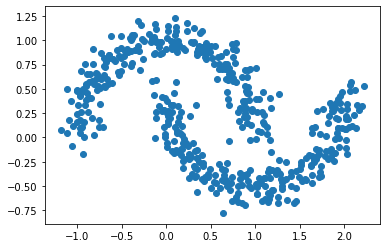

In [38]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

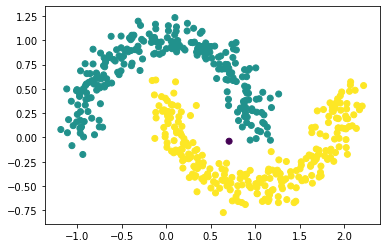

In [39]:
# your code here
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

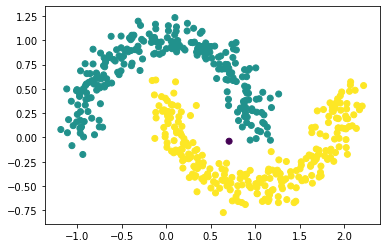

In [40]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

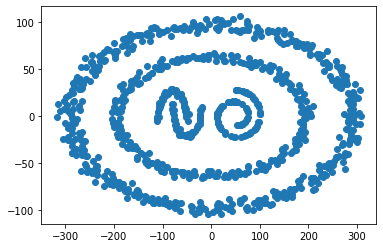

In [41]:
from sklearn.datasets import make_circles, make_blobs, make_moons, make_s_curve, make_swiss_roll
X1, _ = make_circles(n_samples=250, noise=0.03, factor = 0.95)
X2, _ = make_circles(n_samples=450, noise=0.03, factor = 0.95)
X3, _ = make_moons(n_samples=100, noise=0.05)
X4, _ = make_swiss_roll(n_samples=100, noise=0.1)
X4 = X4[:, [0,2]]
X1[:,0] = X1[:,0] * 200
X1[:,1] = X1[:,1] *65
X2[:,0] = X2[:,0] *300
X2[:,1] = X2[:,1] *100
X3[:,0] = 30 * X3[:,0] -80
X3[:,1] = X3[:,1] * 32 - 5
X4[:,0] = X4[:,0]*4 +50 
X4[:,1] = X4[:,1]*2
X = np.append(X1, X2, axis = 0)
X = np.append(X, X3, axis = 0)
X = np.append(X, X4, axis = 0)
plt.scatter(X[:,0], X[:,1])
plt.show()

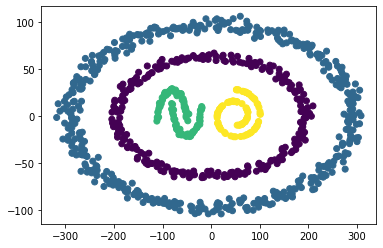

In [42]:
clusters = dbscan(eps=20, min_samples=5).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Или хотя бы что-нибудь такое: 

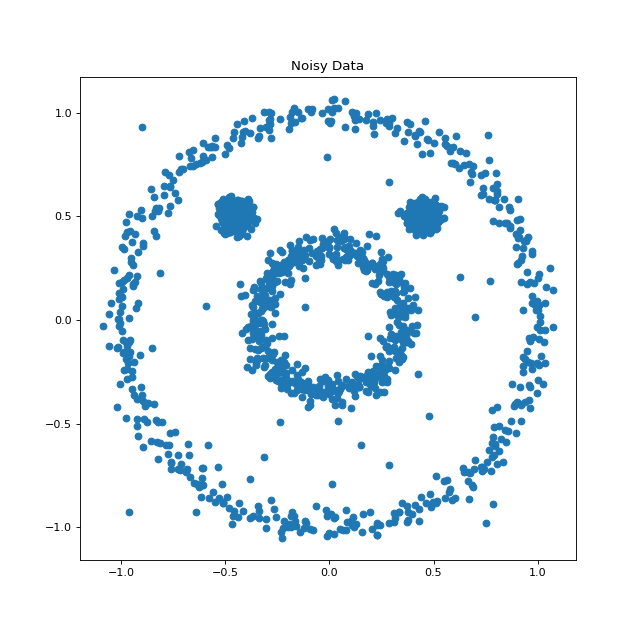

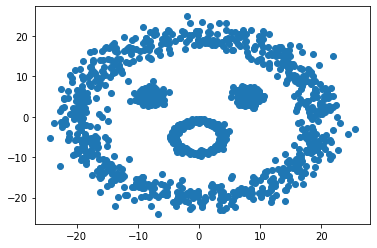

In [43]:
from sklearn.datasets import make_circles, make_blobs
X1, _ = make_circles(n_samples=200, noise=0.1, factor = 0.99)
X2, _ = make_circles(n_samples=750, noise=0.1, factor = 0.99)
X3, _ = make_blobs(n_samples=[300, 300], centers = [(-8,5), (8,5)], random_state = 42)
X1[:,1] = 4* X1[:,1] - 5
X1[:,0] = X1[:,0] * 4
X2[:,0] = X2[:,0] *20
X2[:,1] = X2[:,1] *20
X = np.append(X1, X2, axis = 0)
X = np.append(X, X3, axis = 0)
plt.scatter(X[:,0], X[:,1])
plt.show()

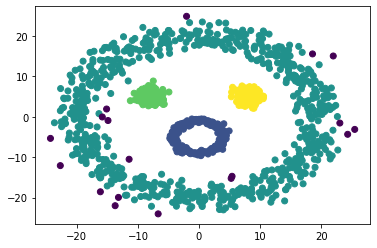

In [44]:
clusters = dbscan(eps=2.5, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем на 20%:

In [45]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 8.09 ms


In [46]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 23.2 s
